In [ ]:
%cd /Users/theunissenlab/code/pecking_analysis/
%matplotlib inline

import os
import copy
import numpy as np
from matplotlib import pyplot as plt
import random
import statsmodels.api as sm
import pandas as pd

from pecking_analysis.objects import *
from pecking_analysis.flicker_fusion import *

h5_file = "/Users/theunissenlab/Google Drive/pecking_test/experiment/data/flicker_fusion.h5"



# Makes LL/Nsamples graph / Bar chart of CFS

In [ ]:
results = pd.DataFrame()
full_lls = dict()
bird_names = ["GreLpi0307F","BlaLbl1387F","GraGre4401M","HpiGra4509M","GraGre0729M","WhiWhi3633M","BlaYel0208M","LblWhi0938F","LblGra2419F","LblGra2921F","YelGra5308M","GreGre7271M","HpiGra4434M"]

#start_date = "2015-12-02"
#end_date = "2016-1-22"

for bird in bird_names:
    blocks = get_blocks(h5_file, birds=bird)
    #blocks = get_blocks(h5_file, start_date=start_date, end_date=end_date, birds=bird)
    blocks = [blk for blk in blocks if "Probe" in blk.data["Class"].unique()]
    blocks = filter_blocks(blocks)
    
    
    max_samples = 3 * np.sum([len(blk.data[blk.data["Class"] == "Probe"]) for blk in blocks])
    nsamples = np.int32(np.linspace(100, max_samples, 10))
    
    bird_results = pd.DataFrame()

    for samples in nsamples:
        print("Computing models with %d samples" % samples)
        cfs, models = bootstrap_center_frequency(blocks, nsamples=samples, sample_function=sample_mean_probe_count)
        lls = [model.llf for model in models]
        full_lls.setdefault("lls", list()).extend(lls)
        full_lls.setdefault("Bird", list()).extend([bird] * len(lls))
        full_lls.setdefault("Nsamples", list()).extend([samples] * len(lls))
        df = pd.DataFrame({"Mean": [np.mean(cfs)],
                           "STD": [np.std(cfs)],
                           "LL Mean": [np.mean(lls)],
                           "LL STD": [np.std(lls)], 
                           "Nsamples": samples, 
                           "Bird": bird,
                           "LLperSample":[np.mean(lls)/samples]})
        bird_results = pd.concat([bird_results, df])

    results = pd.concat([results, bird_results])
        
    fig = plt.figure(facecolor="white")
    ax = fig.add_subplot(2, 1, 1)
    bx = fig.add_subplot(2, 1, 2)

    
    bird_results.plot(x='Nsamples', y='STD', ax=ax)
    bird_results.plot(x='Nsamples', y='LLperSample', ax=bx)

    bx.set_xlabel('Nsamples')
    ax.set_ylabel('STD of Center Freq.')
    bx.set_ylabel('LL/samples')
    fig.suptitle(bird)
    fig.show()
    fig.savefig("/Users/theunissenlab/Google Drive/Thesis_Milan/Graphs/LLgraph/%s.png" % bird, dpi=600, facecolor="white", edgecolor="white")
full_ll_df = pd.DataFrame(full_lls)

In [ ]:
results.to_csv("/Users/theunissenlab/Dropbox/data/milan/birds_10_13_likelihood.csv")

In [ ]:
full_ll_df.to_csv("/Users/theunissenlab/Dropbox/data/milan/birds_10_13_full_lls.csv")

In [ ]:
import scipy
ttest_results = dict()

for bird, bird_df in full_ll_df.groupby("Bird"):                                       
    grouped = bird_df.groupby("Nsamples")
    nsamples = bird_df["Nsamples"].unique()
    for ii in range(1, len(nsamples)):
        group1 = grouped.get_group(nsamples[ii-1])
        group2 = grouped.get_group(nsamples[ii])
        tstat, pvalue = scipy.stats.ttest_ind(group1["lls"].values / nsamples[ii-1], group2["lls"].values / nsamples[ii])                                                       
        ttest_results.setdefault(bird, list()).append((nsamples[ii-1], nsamples[ii], tstat, pvalue))

In [ ]:
results

In [ ]:
results.groupby("Bird").get_group("LblGra2419F")

In [ ]:
samples_per_bird = {"GreLpi0307F": (944, "High"), 
                    "BlaLbl1387F": (507,"High"),
                    "GraGre4401M": (1020,"High"),
                    "HpiGra4509M": (626,"High"),
                    "GraGre0729M": (1028,"Low"),
                    "WhiWhi3633M": (819,"Low"),
                    "BlaYel0208M": (1458,"Low"),
                    "LblWhi0938F": (637, "Low"),
                    "LblGra2419F": (637, "Low"),
                    "LblGra2921F": (637, "Low"),
                   }

In [ ]:
samples_per_bird

In [ ]:
bar_data = dict(bird=[], mean=[], std=list(), highlow=list())
for bn, (samples, highlow) in samples_per_bird.items():
    row = results.ix[(results["Bird"] == bn) & (results["Nsamples"] == samples)]
    bar_data["bird"].append(bn)
    bar_data["mean"].append(row["Mean"].values[0])
    bar_data["std"].append(row["STD"].values[0])
    bar_data["highlow"].append(highlow)
bar_data = pd.DataFrame(bar_data).set_index("bird") 


In [ ]:
bar_data

In [ ]:
fig = plt.figure(facecolor="white")
ax = fig.add_subplot(1, 1, 1)
bar_data.plot(ax=ax, xerr="std", y='mean', kind='barh', color='c', fontsize='16')

ax.set_xlabel('Cener Frequency',fontsize='20')

fig.show()
fig.set_size_inches(18, 8.5)
fig.savefig("/Users/Milan/Desktop/LabMeeting_021215/bargraph.png", dpi=600, facecolor="white", edgecolor="white")

# Compute likelihood for different numbers of endpoint samples
We know that the density of sampling in the reward and nonreward regions has a strong effect on the fit of the logistic function. Let's look at that effect by computing models with varying number of reward/nonreward samples, ranging from 20 to #Probes

In [2]:
%cd /Users/theunissenlab/code/pecking_analysis/
%matplotlib inline

import os
import copy
import numpy as np
from matplotlib import pyplot as plt
import random
import statsmodels.api as sm
import pandas as pd

from pecking_analysis.objects import *
from pecking_analysis.flicker_fusion import *

# This should be the path to your flicker_fusion.h5 file
filename = os.path.expanduser("/Users/theunissenlab/Google Drive/Lab/pecking_test/experiment/data/flicker_fusion.h5")

/Users/theunissenlab/code/pecking_analysis


In [7]:
results = pd.DataFrame()
from numpy.linalg.linalg import LinAlgError
bird_names = ["GreLpi0307F","BlaLbl1387F","GraGre4401M","HpiGra4509M","GraGre0729M","WhiWhi3633M","BlaYel0208M","LblWhi0938F","LblGra2419F","LblGra2921F","YelGra5308M","GreGre7271M","HpiGra4434M"]

for bird in bird_names:
    data = dict(bird=[], nsamples=[], ll_mean=[])
    blocks = get_blocks(filename, birds=bird)
    blocks = [blk for blk in blocks if "Probe" in blk.data["Class"].unique()]
    blocks = filter_blocks(blocks)
    
    # Get the number of probes
    nprobes = sum([len(blk.data.groupby("Class").get_group("Probe")) for blk in blocks])
    print("Found %d probe stimuli" % nprobes)

    # Choose number of samples for reward/nonreward
    nsample_list = np.linspace(20, nprobes, 50, dtype=int)
    
    bird_results = pd.DataFrame()
        
    for nsamples in nsample_list:
        print("Sampling %d points from reward and nonreward" % nsamples)

        # Create sampling function
        sample_function = lambda df: sample_nonprobe(df, nsamples)

        # Compute models
        try:
            models = get_response_by_frequency(blocks, sample_function=sample_function, do_plot=False, log=False)[0]
        except LinAlgError:
            print("Singular matrix error!")
            continue

        # Get likelihood from models
        lls = [model.llf for model in models]

        data["bird"].append(bird)
        data["nsamples"].append(2 * nsamples + nprobes)
        data["ll_mean"].append(np.mean(lls))
        
    df = pd.DataFrame(data)
    
    
    df["ll_per_sample"] = df["ll_mean"] / df["nsamples"]
    bird_results = pd.concat([bird_results, df])
    
    fig = plt.figure(facecolor="white")
    ax = fig.add_subplot(1, 1, 1)

    df.plot(x='nsamples', y='ll_per_sample', ax=ax)

    ax.set_xlabel('Nsamples')
    ax.set_ylabel('LLs')
    fig.suptitle(bird)
    fig.show()
    fig.savefig("/Users/theunissenlab/Google Drive/Lab/Thesis_Milan/Graphs/Diff_num_endpoint/%s.png" % bird, dpi=600, facecolor="white", edgecolor="white")

    


SyntaxError: invalid syntax (<ipython-input-7-2884efb365f2>, line 30)

# Linear Frequency

In [5]:
results = pd.DataFrame()
from numpy.linalg.linalg import LinAlgError
bird_names = ["BlaYel0208M"]

for bird in bird_names:
    data = dict(bird=[], nsamples=[], ll_mean=[])
    blocks = get_blocks(filename, birds=bird)
    blocks = [blk for blk in blocks if "Probe" in blk.data["Class"].unique()]
    blocks = filter_blocks(blocks)
    
    
    get_response_by_frequency(blocks, do_plot=True, log=True,filename= "/Users/theunissenlab/Google Drive/School/Thesis_Milan/Graphs/%s.png" % bird)
   
    


TypeError: model_logistic() got an unexpected keyword argument 'dpi'

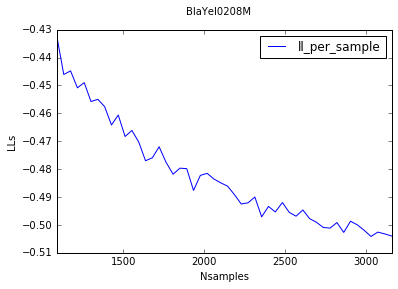

In [5]:
    df = pd.DataFrame(data)
    bird_results = pd.concat([bird_results, df])
    
    fig = plt.figure(facecolor="white")
    ax = fig.add_subplot(1, 1, 1)

    df["ll_per_sample"] = df["ll_mean"] / df["nsamples"]
    df.plot(x='nsamples', y='ll_per_sample', ax=ax)

    ax.set_xlabel('Nsamples')
    ax.set_ylabel('LLs')
    fig.suptitle(bird)
    fig.show()
    fig.savefig("/Users/theunissenlab/Google Drive/Thesis_Milan/Graphs/Diff_num_endpoint/%s.png" % bird, dpi=600, facecolor="white", edgecolor="white")


# Linear LLS

Computing models with 100 samples
Bootstrap 0 of 100: model p-value was 2.66e-04
Bootstrap 1 of 100: model p-value was 6.12e-04
Bootstrap 2 of 100: model p-value was 6.55e-04
Bootstrap 3 of 100: model p-value was 4.02e-09
Bootstrap 4 of 100: model p-value was 6.81e-10
Bootstrap 5 of 100: model p-value was 1.37e-08
Bootstrap 6 of 100: model p-value was 3.71e-06
Bootstrap 7 of 100: model p-value was 2.97e-09
Bootstrap 8 of 100: model p-value was 1.86e-08


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 9 of 100: model p-value was nan
Bootstrap 10 of 100: model p-value was 2.89e-07


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 11 of 100: model p-value was nan
Bootstrap 12 of 100: model p-value was 1.41e-05
Bootstrap 13 of 100: model p-value was 1.69e-03
Bootstrap 14 of 100: model p-value was 4.50e-06
Bootstrap 15 of 100: model p-value was 7.16e-07
Bootstrap 16 of 100: model p-value was 4.66e-03
Bootstrap 17 of 100: model p-value was 4.76e-04
Bootstrap 18 of 100: model p-value was 2.56e-06
Bootstrap 19 of 100: model p-value was 1.20e-05
Bootstrap 20 of 100: model p-value was 1.54e-06
Bootstrap 21 of 100: model p-value was 6.90e-06
Bootstrap 22 of 100: model p-value was 1.28e-06
Bootstrap 23 of 100: model p-value was 4.31e-07
Bootstrap 24 of 100: model p-value was 1.91e-07
Bootstrap 25 of 100: model p-value was 9.22e-06
Bootstrap 26 of 100: model p-value was 2.05e-04
Bootstrap 27 of 100: model p-value was 1.55e-04
Bootstrap 28 of 100: model p-value was 5.50e-08
Bootstrap 29 of 100: model p-value was 1.29e-03
Bootstrap 30 of 100: model p-value was 2.46e-05
Bootstrap 31 of 100: model p-value was 2.99e-

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 33 of 100: model p-value was nan
Bootstrap 34 of 100: model p-value was 1.88e-04
Bootstrap 35 of 100: model p-value was 3.61e-05
Bootstrap 36 of 100: model p-value was 7.09e-08
Bootstrap 37 of 100: model p-value was 3.90e-06
Bootstrap 38 of 100: model p-value was 5.33e-07


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 39 of 100: model p-value was nan
Bootstrap 40 of 100: model p-value was 8.39e-08
Bootstrap 41 of 100: model p-value was 5.94e-06
Bootstrap 42 of 100: model p-value was 5.13e-03
Bootstrap 43 of 100: model p-value was 1.03e-04
Bootstrap 44 of 100: model p-value was 7.73e-06
Bootstrap 45 of 100: model p-value was 6.59e-05
Bootstrap 46 of 100: model p-value was 1.26e-04
Bootstrap 47 of 100: model p-value was 1.83e-06
Bootstrap 48 of 100: model p-value was 5.68e-06
Bootstrap 49 of 100: model p-value was 1.61e-06
Bootstrap 50 of 100: model p-value was 6.28e-06
Bootstrap 51 of 100: model p-value was 1.07e-06
Bootstrap 52 of 100: model p-value was 5.91e-01


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 53 of 100: model p-value was 1.55e-06
Bootstrap 54 of 100: model p-value was 2.39e-05
Bootstrap 55 of 100: model p-value was 7.40e-06
Bootstrap 56 of 100: model p-value was 1.79e-07
Bootstrap 57 of 100: model p-value was 2.83e-08
Bootstrap 58 of 100: model p-value was 1.70e-06
Bootstrap 59 of 100: model p-value was 6.52e-08
Bootstrap 60 of 100: model p-value was 2.15e-07
Bootstrap 61 of 100: model p-value was 2.70e-10
Bootstrap 62 of 100: model p-value was 1.44e-04
Bootstrap 63 of 100: model p-value was 3.07e-07


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 64 of 100: model p-value was 3.67e-07
Bootstrap 65 of 100: model p-value was 7.99e-07
Bootstrap 66 of 100: model p-value was 3.32e-04
Bootstrap 67 of 100: model p-value was nan


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 68 of 100: model p-value was 8.57e-08
Bootstrap 69 of 100: model p-value was 3.99e-06
Bootstrap 70 of 100: model p-value was 2.19e-05
Bootstrap 71 of 100: model p-value was 4.81e-04
Bootstrap 72 of 100: model p-value was 1.99e-04
Bootstrap 73 of 100: model p-value was 3.62e-08
Bootstrap 74 of 100: model p-value was 5.71e-07
Bootstrap 75 of 100: model p-value was 1.70e-05
Bootstrap 76 of 100: model p-value was 2.76e-06
Bootstrap 77 of 100: model p-value was 6.52e-05
Bootstrap 78 of 100: model p-value was 5.62e-05
Bootstrap 79 of 100: model p-value was 1.25e-08
Bootstrap 80 of 100: model p-value was 5.22e-05
Bootstrap 81 of 100: model p-value was 6.27e-07
Bootstrap 82 of 100: model p-value was 1.34e-08


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 83 of 100: model p-value was nan
Bootstrap 84 of 100: model p-value was 2.42e-04
Bootstrap 85 of 100: model p-value was 1.03e-05
Bootstrap 86 of 100: model p-value was 1.04e-07
Bootstrap 87 of 100: model p-value was 2.42e-08
Bootstrap 88 of 100: model p-value was 2.88e-07
Bootstrap 89 of 100: model p-value was 1.01e-04
Bootstrap 90 of 100: model p-value was 1.06e-04
Bootstrap 91 of 100: model p-value was 1.55e-05
Bootstrap 92 of 100: model p-value was 2.55e-03
Bootstrap 93 of 100: model p-value was 5.52e-05
Bootstrap 94 of 100: model p-value was 9.08e-06
Bootstrap 95 of 100: model p-value was 4.32e-09


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 96 of 100: model p-value was nan
Bootstrap 97 of 100: model p-value was nan
Bootstrap 98 of 100: model p-value was 1.77e-06
Bootstrap 99 of 100: model p-value was 2.78e-03
9 models were not significant for 100 samples from bird GreLpi0307F
Computing models with 381 samples
Bootstrap 0 of 100: model p-value was 3.54e-13
Bootstrap 1 of 100: model p-value was 5.93e-08
Bootstrap 2 of 100: model p-value was 7.65e-10
Bootstrap 3 of 100: model p-value was 2.31e-13
Bootstrap 4 of 100: model p-value was 3.05e-16
Bootstrap 5 of 100: model p-value was 9.06e-13
Bootstrap 6 of 100: model p-value was 4.43e-09
Bootstrap 7 of 100: model p-value was 2.80e-11
Bootstrap 8 of 100: model p-value was 4.36e-10
Bootstrap 9 of 100: model p-value was 2.30e-10
Bootstrap 10 of 100: model p-value was 1.25e-08
Bootstrap 11 of 100: model p-value was 4.52e-09
Bootstrap 12 of 100: model p-value was 3.96e-12
Bootstrap 13 of 100: model p-value was 1.52e-13
Bootstrap 14 of 100: model p-value was 1.04e-12
Bootst

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 24 of 100: model p-value was 1.54e-08
Bootstrap 25 of 100: model p-value was 2.62e-10
Bootstrap 26 of 100: model p-value was 1.13e-10
Bootstrap 27 of 100: model p-value was 1.00e-06
Bootstrap 28 of 100: model p-value was 7.48e-11
Bootstrap 29 of 100: model p-value was 9.76e-12
Bootstrap 30 of 100: model p-value was 1.38e-08
Bootstrap 31 of 100: model p-value was 2.00e-08
Bootstrap 32 of 100: model p-value was 6.66e-08
Bootstrap 33 of 100: model p-value was 6.71e-13
Bootstrap 34 of 100: model p-value was 3.57e-07
Bootstrap 35 of 100: model p-value was 4.62e-06
Bootstrap 36 of 100: model p-value was 2.78e-12
Bootstrap 37 of 100: model p-value was 3.98e-10
Bootstrap 38 of 100: model p-value was 5.81e-10
Bootstrap 39 of 100: model p-value was 8.41e-10
Bootstrap 40 of 100: model p-value was 9.63e-08
Bootstrap 41 of 100: model p-value was 3.81e-09
Bootstrap 42 of 100: model p-value was 1.07e-07
Bootstrap 43 of 100: model p-value was 2.06e-11
Bootstrap 44 of 100: model p-value was 5

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 50 of 100: model p-value was 1.42e-07
Bootstrap 51 of 100: model p-value was 1.18e-08
Bootstrap 52 of 100: model p-value was 2.90e-08
Bootstrap 53 of 100: model p-value was 1.86e-12
Bootstrap 54 of 100: model p-value was 1.27e-14
Bootstrap 55 of 100: model p-value was 2.70e-10
Bootstrap 56 of 100: model p-value was 2.39e-07
Bootstrap 57 of 100: model p-value was 6.02e-11
Bootstrap 58 of 100: model p-value was 1.87e-10
Bootstrap 59 of 100: model p-value was 2.61e-07
Bootstrap 60 of 100: model p-value was 6.57e-13
Bootstrap 61 of 100: model p-value was 4.60e-10
Bootstrap 62 of 100: model p-value was 3.24e-10
Bootstrap 63 of 100: model p-value was 1.12e-08
Bootstrap 64 of 100: model p-value was 2.60e-07
Bootstrap 65 of 100: model p-value was 6.57e-13
Bootstrap 66 of 100: model p-value was 3.51e-11
Bootstrap 67 of 100: model p-value was 7.14e-09
Bootstrap 68 of 100: model p-value was 2.73e-06
Bootstrap 69 of 100: model p-value was 2.45e-07
Bootstrap 70 of 100: model p-value was 2

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 88 of 100: model p-value was 6.41e-16
Bootstrap 89 of 100: model p-value was 1.75e-12
Bootstrap 90 of 100: model p-value was 7.08e-08
Bootstrap 91 of 100: model p-value was 5.08e-08
Bootstrap 92 of 100: model p-value was 4.94e-08
Bootstrap 93 of 100: model p-value was 1.51e-17
Bootstrap 94 of 100: model p-value was 6.37e-12
Bootstrap 95 of 100: model p-value was 3.11e-10
Bootstrap 96 of 100: model p-value was 6.90e-06
Bootstrap 97 of 100: model p-value was 8.43e-09
Bootstrap 98 of 100: model p-value was 7.74e-11
Bootstrap 99 of 100: model p-value was 4.96e-09
0 models were not significant for 381 samples from bird GreLpi0307F
Computing models with 663 samples
Bootstrap 0 of 100: model p-value was 2.57e-13
Bootstrap 1 of 100: model p-value was 4.90e-06
Bootstrap 2 of 100: model p-value was 4.32e-10
Bootstrap 3 of 100: model p-value was 3.89e-12
Bootstrap 4 of 100: model p-value was 1.24e-17
Bootstrap 5 of 100: model p-value was 4.86e-13
Bootstrap 6 of 100: model p-value was 8.

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 9 of 100: model p-value was 5.40e-03
Bootstrap 10 of 100: model p-value was 3.76e-04
Bootstrap 11 of 100: model p-value was 1.00e+00
Bootstrap 12 of 100: model p-value was 9.03e-04


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 13 of 100: model p-value was 2.64e-01
Bootstrap 14 of 100: model p-value was 1.00e+00
Bootstrap 15 of 100: model p-value was 1.00e+00
Bootstrap 16 of 100: model p-value was 1.06e-01
Bootstrap 17 of 100: model p-value was 1.00e+00
Bootstrap 18 of 100: model p-value was 7.07e-04


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 19 of 100: model p-value was nan
Bootstrap 20 of 100: model p-value was 7.08e-04
Bootstrap 21 of 100: model p-value was 1.89e-01
Bootstrap 22 of 100: model p-value was 1.00e+00
Bootstrap 23 of 100: model p-value was 2.54e-04
Bootstrap 24 of 100: model p-value was 5.37e-01
Bootstrap 25 of 100: model p-value was 7.08e-04
Bootstrap 26 of 100: model p-value was 1.54e-04
Bootstrap 27 of 100: model p-value was 6.08e-02
Bootstrap 28 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 29 of 100: model p-value was 1.00e+00
Bootstrap 30 of 100: model p-value was 1.99e-03


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 31 of 100: model p-value was 7.28e-04
Bootstrap 32 of 100: model p-value was 5.14e-02
Bootstrap 33 of 100: model p-value was 3.14e-02
Bootstrap 34 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 35 of 100: model p-value was 1.27e-02
Bootstrap 36 of 100: model p-value was 9.22e-02


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 37 of 100: model p-value was nan
Bootstrap 38 of 100: model p-value was 1.10e-02


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 39 of 100: model p-value was 1.00e+00
Bootstrap 40 of 100: model p-value was 1.55e-02


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 41 of 100: model p-value was nan
Bootstrap 42 of 100: model p-value was 1.09e-02
Bootstrap 43 of 100: model p-value was 5.98e-04
Bootstrap 44 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 45 of 100: model p-value was 1.28e-04
Bootstrap 46 of 100: model p-value was 2.83e-04


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 47 of 100: model p-value was 3.32e-04
Bootstrap 48 of 100: model p-value was 1.19e-03
Bootstrap 49 of 100: model p-value was 1.00e+00
Bootstrap 50 of 100: model p-value was 3.90e-03
Bootstrap 51 of 100: model p-value was 2.13e-04


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 52 of 100: model p-value was nan
Bootstrap 53 of 100: model p-value was 4.61e-01
Bootstrap 54 of 100: model p-value was 3.03e-04
Bootstrap 55 of 100: model p-value was nan
Bootstrap 56 of 100: model p-value was 2.58e-01


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 57 of 100: model p-value was 2.97e-01
Bootstrap 58 of 100: model p-value was 1.00e+00
Bootstrap 59 of 100: model p-value was 1.52e-03
Bootstrap 60 of 100: model p-value was 5.22e-02
Bootstrap 61 of 100: model p-value was 1.00e+00
Bootstrap 62 of 100: model p-value was 1.00e+00
Bootstrap 63 of 100: model p-value was 1.48e-03


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 64 of 100: model p-value was 1.00e+00
Bootstrap 65 of 100: model p-value was 2.88e-02
Bootstrap 66 of 100: model p-value was 1.00e+00
Bootstrap 67 of 100: model p-value was 1.00e+00
Bootstrap 68 of 100: model p-value was 2.93e-02
Bootstrap 69 of 100: model p-value was 1.00e+00
Bootstrap 70 of 100: model p-value was 1.00e+00
Bootstrap 71 of 100: model p-value was 1.07e-01
Bootstrap 72 of 100: model p-value was 3.60e-03
Bootstrap 73 of 100: model p-value was 5.11e-02
Bootstrap 74 of 100: model p-value was 7.41e-02
Bootstrap 75 of 100: model p-value was 1.00e+00
Bootstrap 76 of 100: model p-value was 1.00e+00
Bootstrap 77 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 78 of 100: model p-value was nan
Bootstrap 79 of 100: model p-value was nan
Bootstrap 80 of 100: model p-value was 1.83e-04


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 81 of 100: model p-value was nan
Bootstrap 82 of 100: model p-value was 1.00e+00
Bootstrap 83 of 100: model p-value was 1.00e+00
Bootstrap 84 of 100: model p-value was 4.26e-04
Bootstrap 85 of 100: model p-value was 1.00e+00
Bootstrap 86 of 100: model p-value was 6.89e-04
Bootstrap 87 of 100: model p-value was 7.42e-04
Bootstrap 88 of 100: model p-value was 2.84e-03
Bootstrap 89 of 100: model p-value was 1.00e+00
Bootstrap 90 of 100: model p-value was 8.46e-04


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 91 of 100: model p-value was 1.37e-03
Bootstrap 92 of 100: model p-value was 2.32e-01
Bootstrap 93 of 100: model p-value was 1.13e-05
Bootstrap 94 of 100: model p-value was 2.78e-03
Bootstrap 95 of 100: model p-value was nan


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 96 of 100: model p-value was 3.11e-02
Bootstrap 97 of 100: model p-value was 2.87e-03
Bootstrap 98 of 100: model p-value was 4.98e-05


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 99 of 100: model p-value was 1.00e+00
57 models were not significant for 100 samples from bird BlaLbl1387F
Computing models with 158 samples
Bootstrap 0 of 100: model p-value was 3.99e-05


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 1 of 100: model p-value was 6.25e-04
Bootstrap 2 of 100: model p-value was 4.17e-01
Bootstrap 3 of 100: model p-value was 1.04e-04
Bootstrap 4 of 100: model p-value was 1.00e+00
Bootstrap 5 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 6 of 100: model p-value was nan
Bootstrap 7 of 100: model p-value was 5.57e-04
Bootstrap 8 of 100: model p-value was 1.13e-02
Bootstrap 9 of 100: model p-value was 4.73e-04
Bootstrap 10 of 100: model p-value was 1.00e+00
Bootstrap 11 of 100: model p-value was 1.00e+00
Bootstrap 12 of 100: model p-value was 1.00e+00
Bootstrap 13 of 100: model p-value was 4.54e-04
Bootstrap 14 of 100: model p-value was 2.03e-03
Bootstrap 15 of 100: model p-value was 1.00e+00
Bootstrap 16 of 100: model p-value was 6.53e-04
Bootstrap 17 of 100: model p-value was 1.03e-05
Bootstrap 18 of 100: model p-value was 1.47e-01
Bootstrap 19 of 100: model p-value was 1.00e+00
Bootstrap 20 of 100: model p-value was 2.50e-03
Bootstrap 21 of 100: model p-value was 2.44e-02
Bootstrap 22 of 100: model p-value was 1.87e-04


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 23 of 100: model p-value was 2.39e-05
Bootstrap 24 of 100: model p-value was 6.06e-03
Bootstrap 25 of 100: model p-value was 9.75e-05
Bootstrap 26 of 100: model p-value was 4.40e-03
Bootstrap 27 of 100: model p-value was 1.44e-04
Bootstrap 28 of 100: model p-value was 1.00e+00
Bootstrap 29 of 100: model p-value was 1.01e-04
Bootstrap 30 of 100: model p-value was 6.56e-04
Bootstrap 31 of 100: model p-value was 5.49e-04
Bootstrap 32 of 100: model p-value was 1.63e-01
Bootstrap 33 of 100: model p-value was 4.55e-04
Bootstrap 34 of 100: model p-value was 1.00e+00
Bootstrap 35 of 100: model p-value was 1.63e-03


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 36 of 100: model p-value was 1.00e+00
Bootstrap 37 of 100: model p-value was 1.00e+00
Bootstrap 38 of 100: model p-value was 1.00e+00
Bootstrap 39 of 100: model p-value was 1.00e+00
Bootstrap 40 of 100: model p-value was 2.25e-04
Bootstrap 41 of 100: model p-value was 1.48e-03
Bootstrap 42 of 100: model p-value was 1.87e-02
Bootstrap 43 of 100: model p-value was 1.64e-02
Bootstrap 44 of 100: model p-value was 6.10e-03


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 45 of 100: model p-value was 3.19e-03
Bootstrap 46 of 100: model p-value was 1.00e+00
Bootstrap 47 of 100: model p-value was 1.17e-01
Bootstrap 48 of 100: model p-value was 1.32e-03


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 49 of 100: model p-value was 5.23e-01
Bootstrap 50 of 100: model p-value was 2.57e-02
Bootstrap 51 of 100: model p-value was 1.32e-03
Bootstrap 52 of 100: model p-value was 2.34e-02
Bootstrap 53 of 100: model p-value was 3.24e-02
Bootstrap 54 of 100: model p-value was 1.00e+00
Bootstrap 55 of 100: model p-value was 1.00e+00
Bootstrap 56 of 100: model p-value was 2.46e-04
Bootstrap 57 of 100: model p-value was 1.00e+00
Bootstrap 58 of 100: model p-value was 3.62e-04
Bootstrap 59 of 100: model p-value was 6.19e-04
Bootstrap 60 of 100: model p-value was 3.98e-03
Bootstrap 61 of 100: model p-value was 6.54e-02
Bootstrap 62 of 100: model p-value was 9.84e-06
Bootstrap 63 of 100: model p-value was 1.00e+00
Bootstrap 64 of 100: model p-value was 2.34e-03
Bootstrap 65 of 100: model p-value was 1.39e-03


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 66 of 100: model p-value was nan
Bootstrap 67 of 100: model p-value was 1.00e+00
Bootstrap 68 of 100: model p-value was 3.06e-04
Bootstrap 69 of 100: model p-value was 1.00e+00
Bootstrap 70 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 71 of 100: model p-value was 4.72e-01
Bootstrap 72 of 100: model p-value was 2.20e-04
Bootstrap 73 of 100: model p-value was 4.80e-03
Bootstrap 74 of 100: model p-value was 5.16e-04
Bootstrap 75 of 100: model p-value was 8.60e-04
Bootstrap 76 of 100: model p-value was 1.00e+00
Bootstrap 77 of 100: model p-value was 6.84e-01
Bootstrap 78 of 100: model p-value was 1.00e+00
Bootstrap 79 of 100: model p-value was 1.90e-05
Bootstrap 80 of 100: model p-value was 1.00e+00
Bootstrap 81 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 82 of 100: model p-value was 1.00e+00
Bootstrap 83 of 100: model p-value was 1.00e+00
Bootstrap 84 of 100: model p-value was 5.37e-02
Bootstrap 85 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 86 of 100: model p-value was 2.16e-03
Bootstrap 87 of 100: model p-value was 1.00e+00
Bootstrap 88 of 100: model p-value was 8.87e-03
Bootstrap 89 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 90 of 100: model p-value was 3.20e-03
Bootstrap 91 of 100: model p-value was 2.81e-03


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 92 of 100: model p-value was 4.16e-01
Bootstrap 93 of 100: model p-value was 1.30e-04
Bootstrap 94 of 100: model p-value was 1.00e+00
Bootstrap 95 of 100: model p-value was 8.61e-02
Bootstrap 96 of 100: model p-value was 4.82e-03
Bootstrap 97 of 100: model p-value was 2.92e-02
Bootstrap 98 of 100: model p-value was 4.75e-02


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 99 of 100: model p-value was nan
45 models were not significant for 158 samples from bird BlaLbl1387F
Computing models with 216 samples
Bootstrap 0 of 100: model p-value was 1.00e+00
Bootstrap 1 of 100: model p-value was 1.91e-05
Bootstrap 2 of 100: model p-value was 2.77e-03
Bootstrap 3 of 100: model p-value was 9.36e-04
Bootstrap 4 of 100: model p-value was 1.00e+00
Bootstrap 5 of 100: model p-value was 5.78e-04
Bootstrap 6 of 100: model p-value was 1.88e-02
Bootstrap 7 of 100: model p-value was 2.63e-02
Bootstrap 8 of 100: model p-value was 1.00e+00
Bootstrap 9 of 100: model p-value was 1.17e-05
Bootstrap 10 of 100: model p-value was 1.27e-04
Bootstrap 11 of 100: model p-value was 2.33e-03
Bootstrap 12 of 100: model p-value was 1.99e-06
Bootstrap 13 of 100: model p-value was 3.56e-02
Bootstrap 14 of 100: model p-value was 5.69e-03
Bootstrap 15 of 100: model p-value was 1.00e+00
Bootstrap 16 of 100: model p-value was 1.76e-05
Bootstrap 17 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 21 of 100: model p-value was 2.24e-04
Bootstrap 22 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 23 of 100: model p-value was 2.70e-02
Bootstrap 24 of 100: model p-value was 7.48e-07
Bootstrap 25 of 100: model p-value was 2.50e-03
Bootstrap 26 of 100: model p-value was 1.00e+00
Bootstrap 27 of 100: model p-value was 6.96e-05
Bootstrap 28 of 100: model p-value was 9.10e-06
Bootstrap 29 of 100: model p-value was 1.20e-03
Bootstrap 30 of 100: model p-value was 4.06e-03


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 31 of 100: model p-value was 4.27e-01
Bootstrap 32 of 100: model p-value was 3.20e-05


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 33 of 100: model p-value was 2.47e-04
Bootstrap 34 of 100: model p-value was 4.18e-01
Bootstrap 35 of 100: model p-value was 1.73e-03
Bootstrap 36 of 100: model p-value was 4.96e-05
Bootstrap 37 of 100: model p-value was 8.41e-03
Bootstrap 38 of 100: model p-value was 1.00e+00
Bootstrap 39 of 100: model p-value was 1.00e+00
Bootstrap 40 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 41 of 100: model p-value was 1.00e+00
Bootstrap 42 of 100: model p-value was 1.62e-02
Bootstrap 43 of 100: model p-value was 1.02e-05
Bootstrap 44 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 45 of 100: model p-value was 7.90e-04
Bootstrap 46 of 100: model p-value was 7.74e-04
Bootstrap 47 of 100: model p-value was 1.00e+00
Bootstrap 48 of 100: model p-value was 3.33e-05
Bootstrap 49 of 100: model p-value was 5.01e-03
Bootstrap 50 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 51 of 100: model p-value was 1.00e+00
Bootstrap 52 of 100: model p-value was 3.11e-04


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 53 of 100: model p-value was 1.12e-04
Bootstrap 54 of 100: model p-value was 1.00e+00
Bootstrap 55 of 100: model p-value was 4.75e-04
Bootstrap 56 of 100: model p-value was 7.90e-02
Bootstrap 57 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 58 of 100: model p-value was 2.14e-03
Bootstrap 59 of 100: model p-value was 5.49e-03
Bootstrap 60 of 100: model p-value was 1.30e-02
Bootstrap 61 of 100: model p-value was 1.00e+00
Bootstrap 62 of 100: model p-value was 9.55e-04
Bootstrap 63 of 100: model p-value was 1.00e+00
Bootstrap 64 of 100: model p-value was 8.00e-03
Bootstrap 65 of 100: model p-value was 1.00e+00
Bootstrap 66 of 100: model p-value was 8.43e-04
Bootstrap 67 of 100: model p-value was 1.26e-05
Bootstrap 68 of 100: model p-value was 6.27e-04
Bootstrap 69 of 100: model p-value was 4.79e-04
Bootstrap 70 of 100: model p-value was 1.00e+00
Bootstrap 71 of 100: model p-value was 3.19e-02
Bootstrap 72 of 100: model p-value was 5.55e-02
Bootstrap 73 of 100: model p-value was 1.45e-05
Bootstrap 74 of 100: model p-value was 4.07e-03


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 75 of 100: model p-value was 7.42e-01
Bootstrap 76 of 100: model p-value was 1.00e+00
Bootstrap 77 of 100: model p-value was 8.10e-04
Bootstrap 78 of 100: model p-value was 8.13e-04
Bootstrap 79 of 100: model p-value was 9.75e-02
Bootstrap 80 of 100: model p-value was 1.33e-05


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 81 of 100: model p-value was 4.62e-05
Bootstrap 82 of 100: model p-value was 1.00e+00
Bootstrap 83 of 100: model p-value was 3.27e-03
Bootstrap 84 of 100: model p-value was 1.00e+00
Bootstrap 85 of 100: model p-value was 7.33e-04


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 86 of 100: model p-value was 1.44e-03
Bootstrap 87 of 100: model p-value was 2.47e-01
Bootstrap 88 of 100: model p-value was 1.00e+00
Bootstrap 89 of 100: model p-value was 1.00e+00
Bootstrap 90 of 100: model p-value was 9.82e-03


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 91 of 100: model p-value was 2.39e-03
Bootstrap 92 of 100: model p-value was 1.96e-03


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 93 of 100: model p-value was 3.08e-04
Bootstrap 94 of 100: model p-value was 9.93e-04


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 95 of 100: model p-value was 4.48e-07
Bootstrap 96 of 100: model p-value was 1.00e+00
Bootstrap 97 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 98 of 100: model p-value was 1.00e+00
Bootstrap 99 of 100: model p-value was 1.01e-02
38 models were not significant for 216 samples from bird BlaLbl1387F
Computing models with 274 samples


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 0 of 100: model p-value was 1.00e+00
Bootstrap 1 of 100: model p-value was 4.70e-03
Bootstrap 2 of 100: model p-value was 1.00e+00
Bootstrap 3 of 100: model p-value was 2.59e-03
Bootstrap 4 of 100: model p-value was 5.30e-01


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 5 of 100: model p-value was 1.00e+00
Bootstrap 6 of 100: model p-value was 3.76e-04


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 7 of 100: model p-value was 1.00e+00
Bootstrap 8 of 100: model p-value was 5.57e-05


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 9 of 100: model p-value was 8.59e-01
Bootstrap 10 of 100: model p-value was 1.78e-03
Bootstrap 11 of 100: model p-value was 1.06e-04
Bootstrap 12 of 100: model p-value was 1.11e-04


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 13 of 100: model p-value was 1.00e-04
Bootstrap 14 of 100: model p-value was 4.10e-04
Bootstrap 15 of 100: model p-value was 6.43e-03
Bootstrap 16 of 100: model p-value was 7.35e-07


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 17 of 100: model p-value was 1.16e-05
Bootstrap 18 of 100: model p-value was 3.13e-04
Bootstrap 19 of 100: model p-value was 1.00e+00
Bootstrap 20 of 100: model p-value was 8.49e-06
Bootstrap 21 of 100: model p-value was 4.58e-04
Bootstrap 22 of 100: model p-value was 2.05e-04


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 23 of 100: model p-value was 1.00e+00
Bootstrap 24 of 100: model p-value was 9.25e-07
Bootstrap 25 of 100: model p-value was 1.59e-05
Bootstrap 26 of 100: model p-value was 7.21e-04


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 27 of 100: model p-value was 4.53e-01
Bootstrap 28 of 100: model p-value was 8.90e-04
Bootstrap 29 of 100: model p-value was 1.00e+00
Bootstrap 30 of 100: model p-value was 1.37e-03


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 31 of 100: model p-value was 1.00e+00
Bootstrap 32 of 100: model p-value was 3.75e-05
Bootstrap 33 of 100: model p-value was 1.39e-04
Bootstrap 34 of 100: model p-value was 7.07e-04
Bootstrap 35 of 100: model p-value was 1.24e-04
Bootstrap 36 of 100: model p-value was 1.00e+00
Bootstrap 37 of 100: model p-value was 4.12e-06
Bootstrap 38 of 100: model p-value was 2.51e-04
Bootstrap 39 of 100: model p-value was 2.05e-02
Bootstrap 40 of 100: model p-value was 5.04e-03
Bootstrap 41 of 100: model p-value was 2.79e-03
Bootstrap 42 of 100: model p-value was 1.35e-02
Bootstrap 43 of 100: model p-value was 1.00e+00
Bootstrap 44 of 100: model p-value was 9.11e-04
Bootstrap 45 of 100: model p-value was 1.00e+00
Bootstrap 46 of 100: model p-value was 2.56e-05
Bootstrap 47 of 100: model p-value was 2.51e-02


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 48 of 100: model p-value was 9.22e-04
Bootstrap 49 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 50 of 100: model p-value was 4.89e-05
Bootstrap 51 of 100: model p-value was nan


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 52 of 100: model p-value was 1.63e-03
Bootstrap 53 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 54 of 100: model p-value was 1.00e+00
Bootstrap 55 of 100: model p-value was 1.85e-06
Bootstrap 56 of 100: model p-value was 1.00e+00
Bootstrap 57 of 100: model p-value was 5.81e-04
Bootstrap 58 of 100: model p-value was 5.39e-05
Bootstrap 59 of 100: model p-value was 1.00e+00
Bootstrap 60 of 100: model p-value was 8.70e-04
Bootstrap 61 of 100: model p-value was 3.74e-04


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 62 of 100: model p-value was 1.00e+00
Bootstrap 63 of 100: model p-value was 1.00e+00
Bootstrap 64 of 100: model p-value was 5.64e-06
Bootstrap 65 of 100: model p-value was 3.52e-04


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 66 of 100: model p-value was 3.51e-05
Bootstrap 67 of 100: model p-value was 9.28e-05
Bootstrap 68 of 100: model p-value was 8.57e-06
Bootstrap 69 of 100: model p-value was 6.88e-02


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 70 of 100: model p-value was 1.00e+00
Bootstrap 71 of 100: model p-value was 2.89e-04
Bootstrap 72 of 100: model p-value was 1.00e+00
Bootstrap 73 of 100: model p-value was 6.15e-03
Bootstrap 74 of 100: model p-value was 3.36e-02
Bootstrap 75 of 100: model p-value was 6.64e-06


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 76 of 100: model p-value was 1.00e+00
Bootstrap 77 of 100: model p-value was 7.21e-01


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 78 of 100: model p-value was 4.24e-06
Bootstrap 79 of 100: model p-value was 1.73e-03
Bootstrap 80 of 100: model p-value was 1.00e+00
Bootstrap 81 of 100: model p-value was 1.00e+00
Bootstrap 82 of 100: model p-value was 1.46e-04
Bootstrap 83 of 100: model p-value was 7.39e-03
Bootstrap 84 of 100: model p-value was 1.78e-04
Bootstrap 85 of 100: model p-value was 2.64e-04
Bootstrap 86 of 100: model p-value was 1.00e+00
Bootstrap 87 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 88 of 100: model p-value was 1.00e+00
Bootstrap 89 of 100: model p-value was 1.78e-03
Bootstrap 90 of 100: model p-value was 1.20e-05
Bootstrap 91 of 100: model p-value was nan


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 92 of 100: model p-value was 8.58e-04
Bootstrap 93 of 100: model p-value was 4.58e-05
Bootstrap 94 of 100: model p-value was 9.75e-04
Bootstrap 95 of 100: model p-value was 5.29e-01


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 96 of 100: model p-value was 1.64e-04
Bootstrap 97 of 100: model p-value was 8.65e-04
Bootstrap 98 of 100: model p-value was 2.35e-01
Bootstrap 99 of 100: model p-value was 1.00e+00
36 models were not significant for 274 samples from bird BlaLbl1387F
Computing models with 332 samples


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 0 of 100: model p-value was 4.96e-05
Bootstrap 1 of 100: model p-value was 1.00e+00
Bootstrap 2 of 100: model p-value was 8.23e-04
Bootstrap 3 of 100: model p-value was 1.00e+00
Bootstrap 4 of 100: model p-value was 2.74e-05
Bootstrap 5 of 100: model p-value was 8.93e-06
Bootstrap 6 of 100: model p-value was 1.99e-03
Bootstrap 7 of 100: model p-value was 9.37e-07
Bootstrap 8 of 100: model p-value was 1.00e+00
Bootstrap 9 of 100: model p-value was 1.02e-05


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 10 of 100: model p-value was 1.30e-03
Bootstrap 11 of 100: model p-value was 4.58e-04
Bootstrap 12 of 100: model p-value was 1.63e-03
Bootstrap 13 of 100: model p-value was 3.48e-06
Bootstrap 14 of 100: model p-value was 9.06e-03
Bootstrap 15 of 100: model p-value was 2.81e-07


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 16 of 100: model p-value was 1.00e+00
Bootstrap 17 of 100: model p-value was 6.09e-05
Bootstrap 18 of 100: model p-value was 4.70e-03
Bootstrap 19 of 100: model p-value was 1.00e-04
Bootstrap 20 of 100: model p-value was 3.11e-01


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 21 of 100: model p-value was 2.78e-06
Bootstrap 22 of 100: model p-value was 1.43e-02
Bootstrap 23 of 100: model p-value was 3.54e-03
Bootstrap 24 of 100: model p-value was 3.15e-04
Bootstrap 25 of 100: model p-value was 1.32e-06


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 26 of 100: model p-value was 1.00e+00
Bootstrap 27 of 100: model p-value was 6.27e-04
Bootstrap 28 of 100: model p-value was 3.45e-04
Bootstrap 29 of 100: model p-value was 4.70e-04
Bootstrap 30 of 100: model p-value was 1.96e-04
Bootstrap 31 of 100: model p-value was 1.00e+00
Bootstrap 32 of 100: model p-value was 1.00e+00
Bootstrap 33 of 100: model p-value was 1.00e+00
Bootstrap 34 of 100: model p-value was 1.00e+00
Bootstrap 35 of 100: model p-value was 1.00e+00
Bootstrap 36 of 100: model p-value was 3.90e-05
Bootstrap 37 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 38 of 100: model p-value was 1.00e+00
Bootstrap 39 of 100: model p-value was 1.00e+00
Bootstrap 40 of 100: model p-value was 1.73e-05
Bootstrap 41 of 100: model p-value was 1.00e+00
Bootstrap 42 of 100: model p-value was 7.73e-04


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 43 of 100: model p-value was 5.08e-05
Bootstrap 44 of 100: model p-value was 2.08e-06
Bootstrap 45 of 100: model p-value was 1.00e+00
Bootstrap 46 of 100: model p-value was 6.04e-06
Bootstrap 47 of 100: model p-value was 1.00e+00
Bootstrap 48 of 100: model p-value was 9.34e-06
Bootstrap 49 of 100: model p-value was 2.32e-04
Bootstrap 50 of 100: model p-value was 2.65e-06


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 51 of 100: model p-value was 1.00e+00
Bootstrap 52 of 100: model p-value was 1.00e+00
Bootstrap 53 of 100: model p-value was 1.00e+00
Bootstrap 54 of 100: model p-value was 1.00e+00
Bootstrap 55 of 100: model p-value was 1.00e+00
Bootstrap 56 of 100: model p-value was 1.63e-04
Bootstrap 57 of 100: model p-value was 1.00e+00
Bootstrap 58 of 100: model p-value was nan


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 59 of 100: model p-value was 1.00e+00
Bootstrap 60 of 100: model p-value was 1.09e-02
Bootstrap 61 of 100: model p-value was 1.78e-04


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 62 of 100: model p-value was 2.97e-05
Bootstrap 63 of 100: model p-value was 1.49e-04
Bootstrap 64 of 100: model p-value was 1.00e+00
Bootstrap 65 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 66 of 100: model p-value was 6.96e-06
Bootstrap 67 of 100: model p-value was 1.00e+00
Bootstrap 68 of 100: model p-value was 2.00e-06
Bootstrap 69 of 100: model p-value was 4.57e-03
Bootstrap 70 of 100: model p-value was 1.42e-04
Bootstrap 71 of 100: model p-value was 1.41e-03
Bootstrap 72 of 100: model p-value was 3.20e-05
Bootstrap 73 of 100: model p-value was 7.09e-04
Bootstrap 74 of 100: model p-value was 1.00e+00
Bootstrap 75 of 100: model p-value was 1.27e-05
Bootstrap 76 of 100: model p-value was 3.89e-06
Bootstrap 77 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 78 of 100: model p-value was 1.00e+00
Bootstrap 79 of 100: model p-value was 4.30e-04


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 80 of 100: model p-value was 1.00e+00
Bootstrap 81 of 100: model p-value was 2.50e-02
Bootstrap 82 of 100: model p-value was 1.83e-02
Bootstrap 83 of 100: model p-value was 3.87e-04


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 84 of 100: model p-value was 9.09e-04
Bootstrap 85 of 100: model p-value was 3.67e-05


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 86 of 100: model p-value was 9.27e-05
Bootstrap 87 of 100: model p-value was 9.91e-06
Bootstrap 88 of 100: model p-value was 1.00e+00
Bootstrap 89 of 100: model p-value was 6.75e-07
Bootstrap 90 of 100: model p-value was 8.50e-05
Bootstrap 91 of 100: model p-value was 8.26e-03
Bootstrap 92 of 100: model p-value was 7.19e-06
Bootstrap 93 of 100: model p-value was 1.00e+00
Bootstrap 94 of 100: model p-value was 5.73e-03
Bootstrap 95 of 100: model p-value was 1.66e-02


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 96 of 100: model p-value was 1.00e+00
Bootstrap 97 of 100: model p-value was 1.00e+00
Bootstrap 98 of 100: model p-value was 1.00e+00
Bootstrap 99 of 100: model p-value was 1.10e-05
37 models were not significant for 332 samples from bird BlaLbl1387F
Computing models with 391 samples
Bootstrap 0 of 100: model p-value was 1.35e-05
Bootstrap 1 of 100: model p-value was 1.77e-05
Bootstrap 2 of 100: model p-value was 6.13e-06
Bootstrap 3 of 100: model p-value was 1.04e-03
Bootstrap 4 of 100: model p-value was 2.82e-07
Bootstrap 5 of 100: model p-value was 1.00e+00
Bootstrap 6 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 7 of 100: model p-value was 8.64e-06
Bootstrap 8 of 100: model p-value was 3.29e-04
Bootstrap 9 of 100: model p-value was 4.99e-05
Bootstrap 10 of 100: model p-value was 1.96e-04
Bootstrap 11 of 100: model p-value was 4.31e-05
Bootstrap 12 of 100: model p-value was 1.62e-06


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 13 of 100: model p-value was 1.61e-03
Bootstrap 14 of 100: model p-value was 2.78e-04
Bootstrap 15 of 100: model p-value was 1.33e-04
Bootstrap 16 of 100: model p-value was 6.22e-04
Bootstrap 17 of 100: model p-value was 2.11e-04
Bootstrap 18 of 100: model p-value was 1.00e+00
Bootstrap 19 of 100: model p-value was 8.88e-06
Bootstrap 20 of 100: model p-value was 2.16e-03
Bootstrap 21 of 100: model p-value was 1.00e+00
Bootstrap 22 of 100: model p-value was 1.00e+00
Bootstrap 23 of 100: model p-value was 1.00e+00
Bootstrap 24 of 100: model p-value was 1.78e-04
Bootstrap 25 of 100: model p-value was 1.00e+00
Bootstrap 26 of 100: model p-value was 2.29e-05


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 27 of 100: model p-value was 2.90e-05
Bootstrap 28 of 100: model p-value was 1.75e-02


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 29 of 100: model p-value was 1.00e+00
Bootstrap 30 of 100: model p-value was 1.00e+00
Bootstrap 31 of 100: model p-value was 5.31e-05
Bootstrap 32 of 100: model p-value was 1.49e-05


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 33 of 100: model p-value was 4.92e-05
Bootstrap 34 of 100: model p-value was 5.84e-06
Bootstrap 35 of 100: model p-value was 1.00e+00
Bootstrap 36 of 100: model p-value was 1.25e-03
Bootstrap 37 of 100: model p-value was 1.00e+00
Bootstrap 38 of 100: model p-value was 2.92e-05
Bootstrap 39 of 100: model p-value was 1.00e+00
Bootstrap 40 of 100: model p-value was 2.09e-07


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 41 of 100: model p-value was 5.50e-03
Bootstrap 42 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 43 of 100: model p-value was 1.00e+00
Bootstrap 44 of 100: model p-value was 7.70e-05
Bootstrap 45 of 100: model p-value was 1.66e-03
Bootstrap 46 of 100: model p-value was 9.96e-04
Bootstrap 47 of 100: model p-value was 4.08e-07
Bootstrap 48 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 49 of 100: model p-value was 2.46e-06
Bootstrap 50 of 100: model p-value was 1.00e+00
Bootstrap 51 of 100: model p-value was 1.00e+00
Bootstrap 52 of 100: model p-value was 7.93e-04


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 53 of 100: model p-value was 1.92e-02
Bootstrap 54 of 100: model p-value was 5.61e-06
Bootstrap 55 of 100: model p-value was 1.00e+00
Bootstrap 56 of 100: model p-value was 3.02e-03
Bootstrap 57 of 100: model p-value was 1.19e-05


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 58 of 100: model p-value was 2.28e-06
Bootstrap 59 of 100: model p-value was 1.06e-03
Bootstrap 60 of 100: model p-value was 1.77e-03
Bootstrap 61 of 100: model p-value was 9.70e-04
Bootstrap 62 of 100: model p-value was 3.74e-03
Bootstrap 63 of 100: model p-value was 6.85e-04
Bootstrap 64 of 100: model p-value was 3.43e-03
Bootstrap 65 of 100: model p-value was 1.59e-06
Bootstrap 66 of 100: model p-value was 6.43e-04
Bootstrap 67 of 100: model p-value was 3.19e-05
Bootstrap 68 of 100: model p-value was 6.26e-03
Bootstrap 69 of 100: model p-value was 1.00e+00
Bootstrap 70 of 100: model p-value was 3.27e-05
Bootstrap 71 of 100: model p-value was 1.26e-07


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 72 of 100: model p-value was 1.00e+00
Bootstrap 73 of 100: model p-value was 1.00e+00
Bootstrap 74 of 100: model p-value was 1.54e-05
Bootstrap 75 of 100: model p-value was 6.34e-06
Bootstrap 76 of 100: model p-value was 1.00e+00
Bootstrap 77 of 100: model p-value was 1.43e-07


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 78 of 100: model p-value was 3.78e-05
Bootstrap 79 of 100: model p-value was 1.03e-07
Bootstrap 80 of 100: model p-value was 1.00e+00
Bootstrap 81 of 100: model p-value was 4.84e-04


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 82 of 100: model p-value was 1.84e-01
Bootstrap 83 of 100: model p-value was 1.00e+00
Bootstrap 84 of 100: model p-value was 1.00e+00
Bootstrap 85 of 100: model p-value was 3.11e-01


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 86 of 100: model p-value was 1.00e+00
Bootstrap 87 of 100: model p-value was 1.69e-05


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 88 of 100: model p-value was 1.00e+00
Bootstrap 89 of 100: model p-value was 2.20e-02
Bootstrap 90 of 100: model p-value was 4.96e-05
Bootstrap 91 of 100: model p-value was 3.74e-04
Bootstrap 92 of 100: model p-value was 2.76e-02
Bootstrap 93 of 100: model p-value was 1.00e+00
Bootstrap 94 of 100: model p-value was 2.03e-06
Bootstrap 95 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 96 of 100: model p-value was 2.05e-04
Bootstrap 97 of 100: model p-value was 1.12e-04
Bootstrap 98 of 100: model p-value was 1.00e+00
Bootstrap 99 of 100: model p-value was 2.25e-04
32 models were not significant for 391 samples from bird BlaLbl1387F
Computing models with 449 samples
Bootstrap 0 of 100: model p-value was 4.77e-05
Bootstrap 1 of 100: model p-value was 1.14e-05


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 2 of 100: model p-value was 5.05e-05
Bootstrap 3 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 4 of 100: model p-value was 1.00e+00
Bootstrap 5 of 100: model p-value was 7.02e-04
Bootstrap 6 of 100: model p-value was 1.00e+00
Bootstrap 7 of 100: model p-value was 6.87e-07


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 8 of 100: model p-value was 9.63e-04
Bootstrap 9 of 100: model p-value was 4.43e-04
Bootstrap 10 of 100: model p-value was 6.33e-05
Bootstrap 11 of 100: model p-value was 1.68e-05
Bootstrap 12 of 100: model p-value was 1.00e+00
Bootstrap 13 of 100: model p-value was 5.11e-05


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 14 of 100: model p-value was 4.60e-04
Bootstrap 15 of 100: model p-value was 9.49e-05
Bootstrap 16 of 100: model p-value was 9.00e-04
Bootstrap 17 of 100: model p-value was 8.08e-06
Bootstrap 18 of 100: model p-value was 1.00e+00
Bootstrap 19 of 100: model p-value was 1.46e-04
Bootstrap 20 of 100: model p-value was 6.61e-04
Bootstrap 21 of 100: model p-value was 3.92e-04
Bootstrap 22 of 100: model p-value was 7.34e-06
Bootstrap 23 of 100: model p-value was 2.18e-05
Bootstrap 24 of 100: model p-value was 2.22e-04
Bootstrap 25 of 100: model p-value was 1.32e-05
Bootstrap 26 of 100: model p-value was 1.00e+00
Bootstrap 27 of 100: model p-value was 7.13e-05
Bootstrap 28 of 100: model p-value was 4.69e-06
Bootstrap 29 of 100: model p-value was 6.41e-08
Bootstrap 30 of 100: model p-value was 4.73e-06
Bootstrap 31 of 100: model p-value was 7.94e-07
Bootstrap 32 of 100: model p-value was 2.24e-06
Bootstrap 33 of 100: model p-value was 8.08e-04
Bootstrap 34 of 100: model p-value was 3

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 48 of 100: model p-value was 1.00e+00
Bootstrap 49 of 100: model p-value was 1.80e-03
Bootstrap 50 of 100: model p-value was 8.91e-08
Bootstrap 51 of 100: model p-value was 3.90e-08
Bootstrap 52 of 100: model p-value was 1.00e+00
Bootstrap 53 of 100: model p-value was 1.00e+00
Bootstrap 54 of 100: model p-value was 1.00e+00
Bootstrap 55 of 100: model p-value was 1.00e+00
Bootstrap 56 of 100: model p-value was 1.00e+00
Bootstrap 57 of 100: model p-value was 2.64e-04
Bootstrap 58 of 100: model p-value was 1.00e+00
Bootstrap 59 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 60 of 100: model p-value was 1.00e+00
Bootstrap 61 of 100: model p-value was 1.00e+00
Bootstrap 62 of 100: model p-value was 1.00e+00
Bootstrap 63 of 100: model p-value was 1.89e-07
Bootstrap 64 of 100: model p-value was 1.79e-03
Bootstrap 65 of 100: model p-value was 6.78e-05


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 66 of 100: model p-value was 1.16e-05
Bootstrap 67 of 100: model p-value was 1.00e+00
Bootstrap 68 of 100: model p-value was 1.40e-04
Bootstrap 69 of 100: model p-value was 2.41e-06


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 70 of 100: model p-value was 1.30e-06
Bootstrap 71 of 100: model p-value was 9.61e-06
Bootstrap 72 of 100: model p-value was 3.37e-02
Bootstrap 73 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 74 of 100: model p-value was 1.00e+00
Bootstrap 75 of 100: model p-value was 9.05e-08
Bootstrap 76 of 100: model p-value was 1.45e-06
Bootstrap 77 of 100: model p-value was 6.78e-09
Bootstrap 78 of 100: model p-value was 1.60e-06
Bootstrap 79 of 100: model p-value was 1.00e+00
Bootstrap 80 of 100: model p-value was 1.00e+00
Bootstrap 81 of 100: model p-value was 1.86e-04
Bootstrap 82 of 100: model p-value was 4.27e-04
Bootstrap 83 of 100: model p-value was 1.00e+00
Bootstrap 84 of 100: model p-value was 1.00e+00
Bootstrap 85 of 100: model p-value was 1.00e+00
Bootstrap 86 of 100: model p-value was 1.81e-06
Bootstrap 87 of 100: model p-value was 1.96e-03
Bootstrap 88 of 100: model p-value was 2.10e-03
Bootstrap 89 of 100: model p-value was nan


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 90 of 100: model p-value was 1.00e+00
Bootstrap 91 of 100: model p-value was 1.49e-03
Bootstrap 92 of 100: model p-value was 2.37e-05
Bootstrap 93 of 100: model p-value was 4.42e-04


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 94 of 100: model p-value was 2.44e-06
Bootstrap 95 of 100: model p-value was 3.28e-04
Bootstrap 96 of 100: model p-value was 1.35e-03
Bootstrap 97 of 100: model p-value was 1.08e-05
Bootstrap 98 of 100: model p-value was 1.05e-06
Bootstrap 99 of 100: model p-value was 2.73e-07
29 models were not significant for 449 samples from bird BlaLbl1387F
Computing models with 507 samples
Bootstrap 0 of 100: model p-value was 1.53e-04
Bootstrap 1 of 100: model p-value was 1.00e+00
Bootstrap 2 of 100: model p-value was 6.80e-06
Bootstrap 3 of 100: model p-value was 5.62e-06
Bootstrap 4 of 100: model p-value was 1.00e+00
Bootstrap 5 of 100: model p-value was 3.16e-03
Bootstrap 6 of 100: model p-value was 3.37e-05
Bootstrap 7 of 100: model p-value was 7.01e-08
Bootstrap 8 of 100: model p-value was 1.20e-03
Bootstrap 9 of 100: model p-value was 1.00e+00
Bootstrap 10 of 100: model p-value was 3.08e-05
Bootstrap 11 of 100: model p-value was 2.40e-07
Bootstrap 12 of 100: model p-value was 1.69

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 14 of 100: model p-value was 5.76e-05
Bootstrap 15 of 100: model p-value was 3.66e-06
Bootstrap 16 of 100: model p-value was 9.99e-06
Bootstrap 17 of 100: model p-value was 1.00e+00
Bootstrap 18 of 100: model p-value was 1.00e+00
Bootstrap 19 of 100: model p-value was 3.62e-06
Bootstrap 20 of 100: model p-value was 4.48e-07
Bootstrap 21 of 100: model p-value was 3.65e-06
Bootstrap 22 of 100: model p-value was 1.00e+00
Bootstrap 23 of 100: model p-value was 2.64e-03
Bootstrap 24 of 100: model p-value was 1.00e+00
Bootstrap 25 of 100: model p-value was 1.00e+00
Bootstrap 26 of 100: model p-value was 1.20e-03
Bootstrap 27 of 100: model p-value was 1.00e+00
Bootstrap 28 of 100: model p-value was 4.10e-07
Bootstrap 29 of 100: model p-value was 9.65e-06


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 30 of 100: model p-value was 2.02e-05
Bootstrap 31 of 100: model p-value was 2.51e-05
Bootstrap 32 of 100: model p-value was 3.18e-05
Bootstrap 33 of 100: model p-value was 1.76e-07
Bootstrap 34 of 100: model p-value was 2.60e-06
Bootstrap 35 of 100: model p-value was 1.00e+00
Bootstrap 36 of 100: model p-value was 1.00e+00
Bootstrap 37 of 100: model p-value was 8.38e-04


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 38 of 100: model p-value was 1.00e+00
Bootstrap 39 of 100: model p-value was 1.00e+00
Bootstrap 40 of 100: model p-value was 1.00e+00
Bootstrap 41 of 100: model p-value was 2.43e-08
Bootstrap 42 of 100: model p-value was 2.21e-05
Bootstrap 43 of 100: model p-value was 2.17e-01


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 44 of 100: model p-value was 1.28e-06
Bootstrap 45 of 100: model p-value was 1.39e-04
Bootstrap 46 of 100: model p-value was 2.41e-07
Bootstrap 47 of 100: model p-value was 4.79e-05
Bootstrap 48 of 100: model p-value was 1.89e-04
Bootstrap 49 of 100: model p-value was 1.00e+00
Bootstrap 50 of 100: model p-value was 1.00e+00
Bootstrap 51 of 100: model p-value was 2.46e-06
Bootstrap 52 of 100: model p-value was 2.71e-06
Bootstrap 53 of 100: model p-value was 1.00e+00
Bootstrap 54 of 100: model p-value was 2.09e-06
Bootstrap 55 of 100: model p-value was 3.55e-04
Bootstrap 56 of 100: model p-value was 1.00e+00
Bootstrap 57 of 100: model p-value was 7.58e-02


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 58 of 100: model p-value was 6.05e-05
Bootstrap 59 of 100: model p-value was 1.22e-06
Bootstrap 60 of 100: model p-value was 7.34e-05
Bootstrap 61 of 100: model p-value was 1.00e+00
Bootstrap 62 of 100: model p-value was 3.66e-05
Bootstrap 63 of 100: model p-value was 4.33e-04
Bootstrap 64 of 100: model p-value was 2.08e-04
Bootstrap 65 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 66 of 100: model p-value was 1.09e-07
Bootstrap 67 of 100: model p-value was 1.17e-05
Bootstrap 68 of 100: model p-value was 3.58e-06
Bootstrap 69 of 100: model p-value was 1.00e+00
Bootstrap 70 of 100: model p-value was 5.09e-04
Bootstrap 71 of 100: model p-value was 2.85e-06
Bootstrap 72 of 100: model p-value was 1.17e-04


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 73 of 100: model p-value was 1.21e-01
Bootstrap 74 of 100: model p-value was 8.57e-10
Bootstrap 75 of 100: model p-value was 1.00e+00
Bootstrap 76 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 77 of 100: model p-value was 1.11e-06
Bootstrap 78 of 100: model p-value was 1.00e+00
Bootstrap 79 of 100: model p-value was 2.11e-06
Bootstrap 80 of 100: model p-value was 4.79e-05
Bootstrap 81 of 100: model p-value was 1.00e+00
Bootstrap 82 of 100: model p-value was 1.00e+00
Bootstrap 83 of 100: model p-value was 6.98e-04
Bootstrap 84 of 100: model p-value was 5.19e-06
Bootstrap 85 of 100: model p-value was 1.00e+00
Bootstrap 86 of 100: model p-value was 9.14e-05
Bootstrap 87 of 100: model p-value was 3.24e-06
Bootstrap 88 of 100: model p-value was 2.60e-05
Bootstrap 89 of 100: model p-value was 1.61e-05
Bootstrap 90 of 100: model p-value was 1.00e+00
Bootstrap 91 of 100: model p-value was 5.91e-06
Bootstrap 92 of 100: model p-value was 3.69e-04
Bootstrap 93 of 100: model p-value was 1.00e+00
Bootstrap 94 of 100: model p-value was 7.06e-05
Bootstrap 95 of 100: model p-value was 3.43e-05
Bootstrap 96 of 100: model p-value was 7.84e-06
Bootstrap 97 of 100: model p-value was 2

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 5 of 100: model p-value was 1.00e+00
Bootstrap 6 of 100: model p-value was 2.80e-07
Bootstrap 7 of 100: model p-value was 1.00e+00
Bootstrap 8 of 100: model p-value was 1.27e-06
Bootstrap 9 of 100: model p-value was 1.00e+00
Bootstrap 10 of 100: model p-value was 3.13e-06
Bootstrap 11 of 100: model p-value was 2.05e-06
Bootstrap 12 of 100: model p-value was 1.89e-05
Bootstrap 13 of 100: model p-value was 1.53e-05
Bootstrap 14 of 100: model p-value was 5.03e-06
Bootstrap 15 of 100: model p-value was 1.87e-06
Bootstrap 16 of 100: model p-value was 3.11e-04
Bootstrap 17 of 100: model p-value was 1.00e+00
Bootstrap 18 of 100: model p-value was 4.06e-10


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 19 of 100: model p-value was 4.32e-01
Bootstrap 20 of 100: model p-value was 1.36e-07
Bootstrap 21 of 100: model p-value was 1.00e+00
Bootstrap 22 of 100: model p-value was 1.32e-06
Bootstrap 23 of 100: model p-value was 1.73e-05
Bootstrap 24 of 100: model p-value was 1.00e+00
Bootstrap 25 of 100: model p-value was 3.18e-05
Bootstrap 26 of 100: model p-value was 1.00e+00
Bootstrap 27 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 28 of 100: model p-value was 1.00e+00
Bootstrap 29 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 30 of 100: model p-value was 5.95e-07
Bootstrap 31 of 100: model p-value was 1.92e-05
Bootstrap 32 of 100: model p-value was 1.85e-03
Bootstrap 33 of 100: model p-value was 6.64e-06
Bootstrap 34 of 100: model p-value was 3.69e-05
Bootstrap 35 of 100: model p-value was 7.29e-08


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 36 of 100: model p-value was 1.00e+00
Bootstrap 37 of 100: model p-value was 8.90e-09
Bootstrap 38 of 100: model p-value was 1.17e-04
Bootstrap 39 of 100: model p-value was 8.99e-08
Bootstrap 40 of 100: model p-value was 1.57e-05
Bootstrap 41 of 100: model p-value was 1.45e-07
Bootstrap 42 of 100: model p-value was 1.22e-08
Bootstrap 43 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 44 of 100: model p-value was 5.40e-04
Bootstrap 45 of 100: model p-value was 2.58e-07
Bootstrap 46 of 100: model p-value was 1.81e-04
Bootstrap 47 of 100: model p-value was 8.98e-07
Bootstrap 48 of 100: model p-value was 3.40e-08
Bootstrap 49 of 100: model p-value was 1.00e+00
Bootstrap 50 of 100: model p-value was 8.47e-08
Bootstrap 51 of 100: model p-value was 8.13e-08
Bootstrap 52 of 100: model p-value was 9.17e-06
Bootstrap 53 of 100: model p-value was 4.73e-04
Bootstrap 54 of 100: model p-value was 8.56e-08
Bootstrap 55 of 100: model p-value was 1.00e+00
Bootstrap 56 of 100: model p-value was 9.29e-09
Bootstrap 57 of 100: model p-value was 1.00e+00
Bootstrap 58 of 100: model p-value was 1.00e+00
Bootstrap 59 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 60 of 100: model p-value was 1.00e+00
Bootstrap 61 of 100: model p-value was 3.90e-08
Bootstrap 62 of 100: model p-value was 1.41e-06
Bootstrap 63 of 100: model p-value was 4.82e-08
Bootstrap 64 of 100: model p-value was 8.35e-06
Bootstrap 65 of 100: model p-value was 3.71e-06


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 66 of 100: model p-value was 1.00e+00
Bootstrap 67 of 100: model p-value was 1.00e+00
Bootstrap 68 of 100: model p-value was 1.19e-05
Bootstrap 69 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 70 of 100: model p-value was 4.17e-07
Bootstrap 71 of 100: model p-value was 5.49e-05


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 72 of 100: model p-value was 1.00e+00
Bootstrap 73 of 100: model p-value was 5.16e-06
Bootstrap 74 of 100: model p-value was 4.56e-07
Bootstrap 75 of 100: model p-value was 1.75e-04
Bootstrap 76 of 100: model p-value was 8.15e-07
Bootstrap 77 of 100: model p-value was 1.00e+00
Bootstrap 78 of 100: model p-value was 7.84e-04
Bootstrap 79 of 100: model p-value was 6.88e-06


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 80 of 100: model p-value was 4.12e-04
Bootstrap 81 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 82 of 100: model p-value was 1.65e-05
Bootstrap 83 of 100: model p-value was 1.00e+00
Bootstrap 84 of 100: model p-value was 4.53e-05
Bootstrap 85 of 100: model p-value was 3.91e-06
Bootstrap 86 of 100: model p-value was 1.54e-07
Bootstrap 87 of 100: model p-value was 9.40e-06
Bootstrap 88 of 100: model p-value was 5.88e-07
Bootstrap 89 of 100: model p-value was 1.02e-04
Bootstrap 90 of 100: model p-value was 1.37e-05
Bootstrap 91 of 100: model p-value was 1.00e+00
Bootstrap 92 of 100: model p-value was 5.71e-04
Bootstrap 93 of 100: model p-value was 3.13e-05
Bootstrap 94 of 100: model p-value was 8.71e-07
Bootstrap 95 of 100: model p-value was 1.00e+00
Bootstrap 96 of 100: model p-value was 1.55e-03
Bootstrap 97 of 100: model p-value was 2.42e-06
Bootstrap 98 of 100: model p-value was 4.93e-04
Bootstrap 99 of 100: model p-value was 1.41e-09
28 models were not significant for 565 samples from bird BlaLbl1387F
Computing models with 624 samples
Bootstrap 0 of 100: model p-value

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 14 of 100: model p-value was 1.00e+00
Bootstrap 15 of 100: model p-value was 9.58e-09
Bootstrap 16 of 100: model p-value was 1.52e-08
Bootstrap 17 of 100: model p-value was 3.22e-01


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 18 of 100: model p-value was 1.00e+00
Bootstrap 19 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 20 of 100: model p-value was 3.06e-01
Bootstrap 21 of 100: model p-value was 1.04e-06
Bootstrap 22 of 100: model p-value was 1.59e-05
Bootstrap 23 of 100: model p-value was 3.91e-05


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 24 of 100: model p-value was 1.00e+00
Bootstrap 25 of 100: model p-value was 1.00e+00
Bootstrap 26 of 100: model p-value was 2.03e-07
Bootstrap 27 of 100: model p-value was 1.66e-05
Bootstrap 28 of 100: model p-value was 6.72e-05
Bootstrap 29 of 100: model p-value was 1.66e-07
Bootstrap 30 of 100: model p-value was 1.00e+00
Bootstrap 31 of 100: model p-value was 9.20e-07
Bootstrap 32 of 100: model p-value was 1.00e+00
Bootstrap 33 of 100: model p-value was 9.04e-12
Bootstrap 34 of 100: model p-value was 1.00e+00
Bootstrap 35 of 100: model p-value was 1.00e+00
Bootstrap 36 of 100: model p-value was 1.00e+00
Bootstrap 37 of 100: model p-value was 4.93e-05
Bootstrap 38 of 100: model p-value was 1.00e+00
Bootstrap 39 of 100: model p-value was 1.00e+00
Bootstrap 40 of 100: model p-value was 3.01e-08
Bootstrap 41 of 100: model p-value was 1.00e+00
Bootstrap 42 of 100: model p-value was 1.00e+00
Bootstrap 43 of 100: model p-value was 1.00e+00
Bootstrap 44 of 100: model p-value was 4

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 52 of 100: model p-value was 4.18e-06
Bootstrap 53 of 100: model p-value was 3.59e-01


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 54 of 100: model p-value was 3.62e-04
Bootstrap 55 of 100: model p-value was 1.74e-07
Bootstrap 56 of 100: model p-value was 1.00e+00
Bootstrap 57 of 100: model p-value was 1.13e-06
Bootstrap 58 of 100: model p-value was 2.45e-08
Bootstrap 59 of 100: model p-value was 8.06e-07
Bootstrap 60 of 100: model p-value was 1.87e-08
Bootstrap 61 of 100: model p-value was 1.00e+00
Bootstrap 62 of 100: model p-value was 5.30e-05
Bootstrap 63 of 100: model p-value was 1.00e+00
Bootstrap 64 of 100: model p-value was 2.52e-05
Bootstrap 65 of 100: model p-value was 1.61e-07
Bootstrap 66 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 67 of 100: model p-value was 1.00e+00
Bootstrap 68 of 100: model p-value was 2.02e-05


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 69 of 100: model p-value was 1.00e+00
Bootstrap 70 of 100: model p-value was 1.08e-07
Bootstrap 71 of 100: model p-value was 1.00e+00
Bootstrap 72 of 100: model p-value was 5.80e-06
Bootstrap 73 of 100: model p-value was 1.62e-05
Bootstrap 74 of 100: model p-value was 9.58e-09
Bootstrap 75 of 100: model p-value was 1.58e-07
Bootstrap 76 of 100: model p-value was 1.08e-06
Bootstrap 77 of 100: model p-value was 1.15e-06
Bootstrap 78 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 79 of 100: model p-value was 8.44e-01
Bootstrap 80 of 100: model p-value was 1.00e+00
Bootstrap 81 of 100: model p-value was 1.00e+00
Bootstrap 82 of 100: model p-value was 5.77e-10
Bootstrap 83 of 100: model p-value was 3.33e-09
Bootstrap 84 of 100: model p-value was 3.10e-08


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 85 of 100: model p-value was 1.06e-07
Bootstrap 86 of 100: model p-value was 1.00e-07
Bootstrap 87 of 100: model p-value was 1.00e+00
Bootstrap 88 of 100: model p-value was 1.00e+00
Bootstrap 89 of 100: model p-value was 1.16e-07
Bootstrap 90 of 100: model p-value was 2.19e-06


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 91 of 100: model p-value was 1.95e-07
Bootstrap 92 of 100: model p-value was 1.00e+00
Bootstrap 93 of 100: model p-value was 1.86e-05
Bootstrap 94 of 100: model p-value was 3.20e-06
Bootstrap 95 of 100: model p-value was 1.00e+00
Bootstrap 96 of 100: model p-value was 2.99e-06
Bootstrap 97 of 100: model p-value was 2.46e-07
Bootstrap 98 of 100: model p-value was 1.00e+00
Bootstrap 99 of 100: model p-value was 4.73e-06
42 models were not significant for 624 samples from bird BlaLbl1387F
Computing models with 100 samples
Bootstrap 0 of 100: model p-value was 1.10e-01
Bootstrap 1 of 100: model p-value was 1.00e+00
Bootstrap 2 of 100: model p-value was 1.32e-02
Bootstrap 3 of 100: model p-value was 1.00e+00
Bootstrap 4 of 100: model p-value was 1.00e+00
Bootstrap 5 of 100: model p-value was 3.92e-03


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 6 of 100: model p-value was nan
Bootstrap 7 of 100: model p-value was 1.99e-01


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 8 of 100: model p-value was 8.68e-01
Bootstrap 9 of 100: model p-value was 1.00e+00
Bootstrap 10 of 100: model p-value was 2.12e-01
Bootstrap 11 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 12 of 100: model p-value was 5.93e-01
Bootstrap 13 of 100: model p-value was 3.81e-01
Bootstrap 14 of 100: model p-value was 1.00e+00
Bootstrap 15 of 100: model p-value was 2.61e-01
Bootstrap 16 of 100: model p-value was 1.00e+00
Bootstrap 17 of 100: model p-value was 5.28e-02
Bootstrap 18 of 100: model p-value was 1.45e-02
Bootstrap 19 of 100: model p-value was 7.79e-03
Bootstrap 20 of 100: model p-value was 2.30e-02


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 21 of 100: model p-value was nan
Bootstrap 22 of 100: model p-value was nan


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 23 of 100: model p-value was 5.25e-01
Bootstrap 24 of 100: model p-value was 2.20e-02
Bootstrap 25 of 100: model p-value was 4.70e-02
Bootstrap 26 of 100: model p-value was nan


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 27 of 100: model p-value was 1.82e-06
Bootstrap 28 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 29 of 100: model p-value was nan
Bootstrap 30 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 31 of 100: model p-value was 1.30e-01
Bootstrap 32 of 100: model p-value was 4.99e-02
Bootstrap 33 of 100: model p-value was 1.00e+00
Bootstrap 34 of 100: model p-value was nan


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 35 of 100: model p-value was nan
Bootstrap 36 of 100: model p-value was nan


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 37 of 100: model p-value was 4.23e-03
Bootstrap 38 of 100: model p-value was 8.58e-01


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 39 of 100: model p-value was nan
Bootstrap 40 of 100: model p-value was 2.40e-01
Bootstrap 41 of 100: model p-value was 2.74e-01
Bootstrap 42 of 100: model p-value was 1.00e+00
Bootstrap 43 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 44 of 100: model p-value was 1.00e+00
Bootstrap 45 of 100: model p-value was 1.48e-02
Bootstrap 46 of 100: model p-value was 1.00e+00
Bootstrap 47 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 48 of 100: model p-value was 1.00e+00
Bootstrap 49 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 50 of 100: model p-value was 1.00e+00
Bootstrap 51 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 52 of 100: model p-value was nan
Bootstrap 53 of 100: model p-value was 1.00e+00
Bootstrap 54 of 100: model p-value was 5.87e-03
Bootstrap 55 of 100: model p-value was 1.30e-01


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 56 of 100: model p-value was 1.00e+00
Bootstrap 57 of 100: model p-value was 2.81e-02
Bootstrap 58 of 100: model p-value was 8.88e-03


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 59 of 100: model p-value was 1.00e+00
Bootstrap 60 of 100: model p-value was 1.00e+00
Bootstrap 61 of 100: model p-value was 2.87e-02


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 62 of 100: model p-value was 1.00e+00
Bootstrap 63 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 64 of 100: model p-value was 1.00e+00
Bootstrap 65 of 100: model p-value was 3.59e-01


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 66 of 100: model p-value was 9.76e-01
Bootstrap 67 of 100: model p-value was nan
Bootstrap 68 of 100: model p-value was 6.15e-02
Bootstrap 69 of 100: model p-value was 1.00e+00
Bootstrap 70 of 100: model p-value was nan


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 71 of 100: model p-value was nan
Bootstrap 72 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 73 of 100: model p-value was 1.00e+00
Bootstrap 74 of 100: model p-value was 1.00e+00
Bootstrap 75 of 100: model p-value was 1.03e-01
Bootstrap 76 of 100: model p-value was 1.52e-01
Bootstrap 77 of 100: model p-value was 1.12e-02
Bootstrap 78 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 79 of 100: model p-value was 1.00e+00
Bootstrap 80 of 100: model p-value was 1.64e-02
Bootstrap 81 of 100: model p-value was 3.99e-02
Bootstrap 82 of 100: model p-value was 1.06e-02


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 83 of 100: model p-value was 9.08e-01
Bootstrap 84 of 100: model p-value was nan


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 85 of 100: model p-value was 7.87e-01
Bootstrap 86 of 100: model p-value was nan


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 87 of 100: model p-value was 2.26e-01
Bootstrap 88 of 100: model p-value was 1.00e+00
Bootstrap 89 of 100: model p-value was 4.62e-02
Bootstrap 90 of 100: model p-value was 1.00e+00
Bootstrap 91 of 100: model p-value was 2.89e-02
Bootstrap 92 of 100: model p-value was 6.29e-02
Bootstrap 93 of 100: model p-value was 1.39e-02
Bootstrap 94 of 100: model p-value was 1.04e-02


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 95 of 100: model p-value was 4.63e-01
Bootstrap 96 of 100: model p-value was nan
Bootstrap 97 of 100: model p-value was nan
Bootstrap 98 of 100: model p-value was 4.91e-02
Bootstrap 99 of 100: model p-value was 2.16e-02
75 models were not significant for 100 samples from bird GraGre4401M
Computing models with 330 samples


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 0 of 100: model p-value was 4.06e-01
Bootstrap 1 of 100: model p-value was 1.00e+00
Bootstrap 2 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 3 of 100: model p-value was 7.27e-01
Bootstrap 4 of 100: model p-value was 1.27e-02


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 5 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 6 of 100: model p-value was 1.00e+00
Bootstrap 7 of 100: model p-value was 1.75e-01
Bootstrap 8 of 100: model p-value was 1.00e+00
Bootstrap 9 of 100: model p-value was 5.25e-02
Bootstrap 10 of 100: model p-value was 4.32e-03
Bootstrap 11 of 100: model p-value was 1.00e+00
Bootstrap 12 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 13 of 100: model p-value was 1.00e+00
Bootstrap 14 of 100: model p-value was 1.63e-03


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 15 of 100: model p-value was 1.00e+00
Bootstrap 16 of 100: model p-value was 3.33e-06
Bootstrap 17 of 100: model p-value was 2.03e-01
Bootstrap 18 of 100: model p-value was 1.92e-01
Bootstrap 19 of 100: model p-value was 1.00e+00
Bootstrap 20 of 100: model p-value was 5.51e-05
Bootstrap 21 of 100: model p-value was 4.13e-04
Bootstrap 22 of 100: model p-value was 3.94e-03
Bootstrap 23 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 24 of 100: model p-value was 1.00e+00
Bootstrap 25 of 100: model p-value was 8.86e-04


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 26 of 100: model p-value was 1.00e+00
Bootstrap 27 of 100: model p-value was 1.58e-04
Bootstrap 28 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 29 of 100: model p-value was nan
Bootstrap 30 of 100: model p-value was 3.37e-04
Bootstrap 31 of 100: model p-value was 1.10e-02
Bootstrap 32 of 100: model p-value was 1.00e+00
Bootstrap 33 of 100: model p-value was 1.00e+00
Bootstrap 34 of 100: model p-value was 1.22e-03
Bootstrap 35 of 100: model p-value was 3.82e-03
Bootstrap 36 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 37 of 100: model p-value was 4.31e-04
Bootstrap 38 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 39 of 100: model p-value was 3.13e-06
Bootstrap 40 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 41 of 100: model p-value was 1.00e+00
Bootstrap 42 of 100: model p-value was 8.22e-01


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 43 of 100: model p-value was 5.20e-04
Bootstrap 44 of 100: model p-value was 1.00e+00
Bootstrap 45 of 100: model p-value was 1.00e+00
Bootstrap 46 of 100: model p-value was 1.58e-03
Bootstrap 47 of 100: model p-value was 2.63e-03
Bootstrap 48 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 49 of 100: model p-value was 1.00e+00
Bootstrap 50 of 100: model p-value was 1.90e-01
Bootstrap 51 of 100: model p-value was 1.91e-04
Bootstrap 52 of 100: model p-value was 2.33e-04
Bootstrap 53 of 100: model p-value was 1.00e+00
Bootstrap 54 of 100: model p-value was 1.00e+00
Bootstrap 55 of 100: model p-value was 2.92e-05
Bootstrap 56 of 100: model p-value was 1.00e+00
Bootstrap 57 of 100: model p-value was 1.00e+00
Bootstrap 58 of 100: model p-value was 1.00e+00
Bootstrap 59 of 100: model p-value was 4.71e-02


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 60 of 100: model p-value was 1.01e-03
Bootstrap 61 of 100: model p-value was 1.00e+00
Bootstrap 62 of 100: model p-value was 3.19e-02
Bootstrap 63 of 100: model p-value was 1.00e+00
Bootstrap 64 of 100: model p-value was 1.00e+00
Bootstrap 65 of 100: model p-value was 1.00e+00
Bootstrap 66 of 100: model p-value was 1.00e+00
Bootstrap 67 of 100: model p-value was 1.24e-03
Bootstrap 68 of 100: model p-value was 1.00e+00
Bootstrap 69 of 100: model p-value was 1.00e+00
Bootstrap 70 of 100: model p-value was 4.05e-02
Bootstrap 71 of 100: model p-value was 1.00e-02
Bootstrap 72 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 73 of 100: model p-value was 3.33e-04
Bootstrap 74 of 100: model p-value was 6.39e-01


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 75 of 100: model p-value was 4.54e-02
Bootstrap 76 of 100: model p-value was 1.00e+00
Bootstrap 77 of 100: model p-value was 2.40e-04
Bootstrap 78 of 100: model p-value was 1.92e-01
Bootstrap 79 of 100: model p-value was 1.61e-03


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 80 of 100: model p-value was nan
Bootstrap 81 of 100: model p-value was 1.91e-01


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 82 of 100: model p-value was 1.00e+00
Bootstrap 83 of 100: model p-value was 2.29e-02
Bootstrap 84 of 100: model p-value was nan


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 85 of 100: model p-value was 2.21e-03
Bootstrap 86 of 100: model p-value was 2.45e-06
Bootstrap 87 of 100: model p-value was 1.00e+00
Bootstrap 88 of 100: model p-value was 1.00e+00
Bootstrap 89 of 100: model p-value was 1.32e-03
Bootstrap 90 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 91 of 100: model p-value was 1.00e+00
Bootstrap 92 of 100: model p-value was 1.21e-03
Bootstrap 93 of 100: model p-value was 1.54e-03
Bootstrap 94 of 100: model p-value was 1.00e+00
Bootstrap 95 of 100: model p-value was 1.00e+00
Bootstrap 96 of 100: model p-value was 9.82e-01
Bootstrap 97 of 100: model p-value was 3.07e-04
Bootstrap 98 of 100: model p-value was 1.41e-01
Bootstrap 99 of 100: model p-value was 7.32e-06
61 models were not significant for 330 samples from bird GraGre4401M
Computing models with 560 samples
Bootstrap 0 of 100: model p-value was 1.89e-05
Bootstrap 1 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 2 of 100: model p-value was 1.14e-05
Bootstrap 3 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 4 of 100: model p-value was 1.07e-03
Bootstrap 5 of 100: model p-value was nan
Bootstrap 6 of 100: model p-value was 1.00e+00
Bootstrap 7 of 100: model p-value was 1.00e+00
Bootstrap 8 of 100: model p-value was 2.33e-06
Bootstrap 9 of 100: model p-value was 1.09e-03


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 10 of 100: model p-value was 1.84e-04
Bootstrap 11 of 100: model p-value was 1.00e+00
Bootstrap 12 of 100: model p-value was 3.90e-05
Bootstrap 13 of 100: model p-value was 2.00e-04


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 14 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 15 of 100: model p-value was nan
Bootstrap 16 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 17 of 100: model p-value was 2.80e-04
Bootstrap 18 of 100: model p-value was 2.14e-06
Bootstrap 19 of 100: model p-value was 1.00e+00
Bootstrap 20 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 21 of 100: model p-value was nan
Bootstrap 22 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 23 of 100: model p-value was 1.00e+00
Bootstrap 24 of 100: model p-value was 1.00e+00
Bootstrap 25 of 100: model p-value was 1.00e+00
Bootstrap 26 of 100: model p-value was 6.12e-05


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 27 of 100: model p-value was 1.00e+00
Bootstrap 28 of 100: model p-value was 4.68e-04
Bootstrap 29 of 100: model p-value was 1.33e-03
Bootstrap 30 of 100: model p-value was 1.00e+00
Bootstrap 31 of 100: model p-value was 8.85e-05
Bootstrap 32 of 100: model p-value was 2.08e-04


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 33 of 100: model p-value was 5.92e-01
Bootstrap 34 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 35 of 100: model p-value was 1.00e+00
Bootstrap 36 of 100: model p-value was 1.00e+00
Bootstrap 37 of 100: model p-value was 9.46e-05
Bootstrap 38 of 100: model p-value was 2.50e-06
Bootstrap 39 of 100: model p-value was 6.47e-05
Bootstrap 40 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 41 of 100: model p-value was 1.00e+00
Bootstrap 42 of 100: model p-value was 1.00e+00
Bootstrap 43 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 44 of 100: model p-value was 1.00e+00
Bootstrap 45 of 100: model p-value was 8.01e-01


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 46 of 100: model p-value was 1.00e+00
Bootstrap 47 of 100: model p-value was 1.00e+00
Bootstrap 48 of 100: model p-value was 1.98e-04
Bootstrap 49 of 100: model p-value was 7.76e-07
Bootstrap 50 of 100: model p-value was 5.40e-06
Bootstrap 51 of 100: model p-value was 1.00e+00
Bootstrap 52 of 100: model p-value was 8.27e-04
Bootstrap 53 of 100: model p-value was 6.74e-03
Bootstrap 54 of 100: model p-value was 1.00e+00
Bootstrap 55 of 100: model p-value was 2.58e-06


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 56 of 100: model p-value was 2.57e-04


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 57 of 100: model p-value was 1.00e+00
Bootstrap 58 of 100: model p-value was 1.00e+00
Bootstrap 59 of 100: model p-value was 1.77e-02
Bootstrap 60 of 100: model p-value was 1.00e+00
Bootstrap 61 of 100: model p-value was 6.10e-06
Bootstrap 62 of 100: model p-value was 9.73e-04
Bootstrap 63 of 100: model p-value was 2.96e-05
Bootstrap 64 of 100: model p-value was 1.83e-03
Bootstrap 65 of 100: model p-value was 1.00e+00
Bootstrap 66 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 67 of 100: model p-value was 1.00e+00
Bootstrap 68 of 100: model p-value was 1.00e+00
Bootstrap 69 of 100: model p-value was 1.00e+00
Bootstrap 70 of 100: model p-value was 1.00e+00
Bootstrap 71 of 100: model p-value was 1.00e+00
Bootstrap 72 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 73 of 100: model p-value was 7.62e-04
Bootstrap 74 of 100: model p-value was 8.72e-02
Bootstrap 75 of 100: model p-value was 1.30e-04
Bootstrap 76 of 100: model p-value was 4.40e-04


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 77 of 100: model p-value was 1.00e+00
Bootstrap 78 of 100: model p-value was 1.68e-05
Bootstrap 79 of 100: model p-value was 9.68e-03
Bootstrap 80 of 100: model p-value was 1.14e-01


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 81 of 100: model p-value was 1.03e-03
Bootstrap 82 of 100: model p-value was 3.36e-05
Bootstrap 83 of 100: model p-value was 8.70e-08
Bootstrap 84 of 100: model p-value was 3.46e-03
Bootstrap 85 of 100: model p-value was 1.11e-04
Bootstrap 86 of 100: model p-value was 1.00e+00
Bootstrap 87 of 100: model p-value was 3.16e-05
Bootstrap 88 of 100: model p-value was 1.00e+00
Bootstrap 89 of 100: model p-value was 1.00e+00
Bootstrap 90 of 100: model p-value was 2.21e-07


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 91 of 100: model p-value was 1.18e-05
Bootstrap 92 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 93 of 100: model p-value was 1.00e+00
Bootstrap 94 of 100: model p-value was 1.00e+00
Bootstrap 95 of 100: model p-value was 1.00e+00
Bootstrap 96 of 100: model p-value was 1.29e-04


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 97 of 100: model p-value was 1.98e-02
Bootstrap 98 of 100: model p-value was 3.48e-01
Bootstrap 99 of 100: model p-value was 1.00e+00
55 models were not significant for 560 samples from bird GraGre4401M
Computing models with 790 samples


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 0 of 100: model p-value was 6.44e-06
Bootstrap 1 of 100: model p-value was 1.00e+00
Bootstrap 2 of 100: model p-value was 1.00e+00
Bootstrap 3 of 100: model p-value was 1.00e+00
Bootstrap 4 of 100: model p-value was 1.00e+00
Bootstrap 5 of 100: model p-value was 1.32e-05
Bootstrap 6 of 100: model p-value was 1.00e+00
Bootstrap 7 of 100: model p-value was 4.60e-07
Bootstrap 8 of 100: model p-value was 2.20e-04
Bootstrap 9 of 100: model p-value was 1.08e-04
Bootstrap 10 of 100: model p-value was 4.15e-08
Bootstrap 11 of 100: model p-value was 1.00e+00
Bootstrap 12 of 100: model p-value was 1.00e+00
Bootstrap 13 of 100: model p-value was 1.00e+00
Bootstrap 14 of 100: model p-value was 1.67e-05
Bootstrap 15 of 100: model p-value was 7.91e-05
Bootstrap 16 of 100: model p-value was 1.36e-06
Bootstrap 17 of 100: model p-value was 4.48e-05
Bootstrap 18 of 100: model p-value was 1.00e+00
Bootstrap 19 of 100: model p-value was 9.68e-01


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 20 of 100: model p-value was 3.29e-01
Bootstrap 21 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 22 of 100: model p-value was 1.00e+00
Bootstrap 23 of 100: model p-value was 1.49e-05
Bootstrap 24 of 100: model p-value was 1.00e+00
Bootstrap 25 of 100: model p-value was 8.56e-07
Bootstrap 26 of 100: model p-value was 1.00e+00
Bootstrap 27 of 100: model p-value was 6.64e-06
Bootstrap 28 of 100: model p-value was 1.00e+00
Bootstrap 29 of 100: model p-value was 6.70e-01


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 30 of 100: model p-value was 1.43e-08
Bootstrap 31 of 100: model p-value was 1.24e-05
Bootstrap 32 of 100: model p-value was 8.05e-07
Bootstrap 33 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 34 of 100: model p-value was 1.00e+00
Bootstrap 35 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 36 of 100: model p-value was 4.96e-01
Bootstrap 37 of 100: model p-value was 6.09e-08
Bootstrap 38 of 100: model p-value was 2.39e-04
Bootstrap 39 of 100: model p-value was 1.00e+00
Bootstrap 40 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 41 of 100: model p-value was 1.00e+00
Bootstrap 42 of 100: model p-value was 1.00e+00
Bootstrap 43 of 100: model p-value was 7.99e-07
Bootstrap 44 of 100: model p-value was 1.69e-01
Bootstrap 45 of 100: model p-value was 1.39e-06
Bootstrap 46 of 100: model p-value was 4.30e-08
Bootstrap 47 of 100: model p-value was 4.69e-05
Bootstrap 48 of 100: model p-value was 3.69e-07
Bootstrap 49 of 100: model p-value was 1.00e+00
Bootstrap 50 of 100: model p-value was 3.79e-07


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 51 of 100: model p-value was 1.00e+00
Bootstrap 52 of 100: model p-value was 2.34e-04
Bootstrap 53 of 100: model p-value was 8.43e-04
Bootstrap 54 of 100: model p-value was 1.93e-05
Bootstrap 55 of 100: model p-value was 8.86e-09
Bootstrap 56 of 100: model p-value was 1.00e+00
Bootstrap 57 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 58 of 100: model p-value was 5.36e-01
Bootstrap 59 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 60 of 100: model p-value was 1.00e+00
Bootstrap 61 of 100: model p-value was 9.82e-06
Bootstrap 62 of 100: model p-value was 1.00e+00
Bootstrap 63 of 100: model p-value was 1.00e+00
Bootstrap 64 of 100: model p-value was 2.25e-04
Bootstrap 65 of 100: model p-value was nan


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 66 of 100: model p-value was 2.78e-01
Bootstrap 67 of 100: model p-value was 7.18e-01


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 68 of 100: model p-value was 2.88e-09
Bootstrap 69 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 70 of 100: model p-value was 1.00e+00
Bootstrap 71 of 100: model p-value was 1.00e+00
Bootstrap 72 of 100: model p-value was 1.00e+00
Bootstrap 73 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 74 of 100: model p-value was 2.01e-06
Bootstrap 75 of 100: model p-value was 4.47e-07


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 76 of 100: model p-value was 9.23e-01
Bootstrap 77 of 100: model p-value was 2.18e-04
Bootstrap 78 of 100: model p-value was 1.37e-10
Bootstrap 79 of 100: model p-value was 1.00e+00
Bootstrap 80 of 100: model p-value was 6.20e-06
Bootstrap 81 of 100: model p-value was 3.88e-09
Bootstrap 82 of 100: model p-value was 8.55e-08
Bootstrap 83 of 100: model p-value was 1.00e+00
Bootstrap 84 of 100: model p-value was 1.00e+00
Bootstrap 85 of 100: model p-value was 1.00e+00
Bootstrap 86 of 100: model p-value was 9.02e-05
Bootstrap 87 of 100: model p-value was 1.56e-04
Bootstrap 88 of 100: model p-value was 1.84e-05
Bootstrap 89 of 100: model p-value was 8.09e-06
Bootstrap 90 of 100: model p-value was 4.21e-02
Bootstrap 91 of 100: model p-value was 5.05e-01


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 92 of 100: model p-value was 8.03e-01
Bootstrap 93 of 100: model p-value was 1.00e+00
Bootstrap 94 of 100: model p-value was 1.77e-04
Bootstrap 95 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 96 of 100: model p-value was 1.00e+00
Bootstrap 97 of 100: model p-value was 5.57e-06
Bootstrap 98 of 100: model p-value was 1.00e+00
Bootstrap 99 of 100: model p-value was 1.00e+00
55 models were not significant for 790 samples from bird GraGre4401M
Computing models with 1020 samples
Bootstrap 0 of 100: model p-value was 1.79e-07
Bootstrap 1 of 100: model p-value was 1.70e-04


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 2 of 100: model p-value was 1.00e+00
Bootstrap 3 of 100: model p-value was 8.50e-06
Bootstrap 4 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 5 of 100: model p-value was 1.00e+00
Bootstrap 6 of 100: model p-value was 1.00e+00
Bootstrap 7 of 100: model p-value was 1.00e+00
Bootstrap 8 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 9 of 100: model p-value was 1.00e+00
Bootstrap 10 of 100: model p-value was 2.98e-07
Bootstrap 11 of 100: model p-value was 1.43e-08


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 12 of 100: model p-value was 1.00e+00
Bootstrap 13 of 100: model p-value was 2.94e-06
Bootstrap 14 of 100: model p-value was 7.53e-09
Bootstrap 15 of 100: model p-value was 9.48e-08
Bootstrap 16 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 17 of 100: model p-value was 1.00e+00
Bootstrap 18 of 100: model p-value was 1.00e+00
Bootstrap 19 of 100: model p-value was 2.73e-06


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 20 of 100: model p-value was 1.00e+00
Bootstrap 21 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 22 of 100: model p-value was 8.17e-06
Bootstrap 23 of 100: model p-value was 1.00e+00
Bootstrap 24 of 100: model p-value was 1.35e-06
Bootstrap 25 of 100: model p-value was 6.07e-08
Bootstrap 26 of 100: model p-value was 1.61e-07
Bootstrap 27 of 100: model p-value was 1.00e+00
Bootstrap 28 of 100: model p-value was 1.58e-08
Bootstrap 29 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 30 of 100: model p-value was 1.64e-07
Bootstrap 31 of 100: model p-value was 1.00e+00
Bootstrap 32 of 100: model p-value was 1.00e+00
Bootstrap 33 of 100: model p-value was 1.00e+00
Bootstrap 34 of 100: model p-value was 1.00e+00
Bootstrap 35 of 100: model p-value was 1.00e+00
Bootstrap 36 of 100: model p-value was 3.78e-05
Bootstrap 37 of 100: model p-value was 3.16e-07
Bootstrap 38 of 100: model p-value was 1.00e+00
Bootstrap 39 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 40 of 100: model p-value was 2.08e-06
Bootstrap 41 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 42 of 100: model p-value was 2.67e-07
Bootstrap 43 of 100: model p-value was 1.00e+00
Bootstrap 44 of 100: model p-value was 1.00e+00
Bootstrap 45 of 100: model p-value was 1.00e+00
Bootstrap 46 of 100: model p-value was 6.29e-08
Bootstrap 47 of 100: model p-value was 1.00e+00
Bootstrap 48 of 100: model p-value was 1.12e-06
Bootstrap 49 of 100: model p-value was 2.53e-07
Bootstrap 50 of 100: model p-value was 1.00e+00
Bootstrap 51 of 100: model p-value was 2.62e-08
Bootstrap 52 of 100: model p-value was 3.82e-06
Bootstrap 53 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 54 of 100: model p-value was 1.00e+00
Bootstrap 55 of 100: model p-value was 1.00e+00
Bootstrap 56 of 100: model p-value was 1.00e+00
Bootstrap 57 of 100: model p-value was 1.00e+00
Bootstrap 58 of 100: model p-value was 8.01e-07
Bootstrap 59 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 60 of 100: model p-value was 1.00e+00
Bootstrap 61 of 100: model p-value was 2.90e-04
Bootstrap 62 of 100: model p-value was 3.11e-06
Bootstrap 63 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 64 of 100: model p-value was 1.00e+00
Bootstrap 65 of 100: model p-value was 1.00e+00
Bootstrap 66 of 100: model p-value was 1.00e+00
Bootstrap 67 of 100: model p-value was 2.78e-07
Bootstrap 68 of 100: model p-value was 1.07e-06
Bootstrap 69 of 100: model p-value was 1.00e+00
Bootstrap 70 of 100: model p-value was 1.00e+00
Bootstrap 71 of 100: model p-value was 2.68e-04
Bootstrap 72 of 100: model p-value was 1.00e+00
Bootstrap 73 of 100: model p-value was 1.00e+00
Bootstrap 74 of 100: model p-value was 6.36e-07
Bootstrap 75 of 100: model p-value was 1.00e+00
Bootstrap 76 of 100: model p-value was 1.32e-09


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 77 of 100: model p-value was 1.00e+00
Bootstrap 78 of 100: model p-value was 1.87e-08
Bootstrap 79 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 80 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 81 of 100: model p-value was 7.66e-07
Bootstrap 82 of 100: model p-value was 1.00e+00
Bootstrap 83 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 84 of 100: model p-value was 1.00e+00
Bootstrap 85 of 100: model p-value was 1.00e+00
Bootstrap 86 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 87 of 100: model p-value was 1.00e+00
Bootstrap 88 of 100: model p-value was 7.52e-04


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 89 of 100: model p-value was 5.70e-01
Bootstrap 90 of 100: model p-value was 1.08e-08
Bootstrap 91 of 100: model p-value was 1.00e+00
Bootstrap 92 of 100: model p-value was 3.46e-06


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 93 of 100: model p-value was 1.33e-07
Bootstrap 94 of 100: model p-value was 5.52e-08
Bootstrap 95 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 96 of 100: model p-value was 1.00e+00
Bootstrap 97 of 100: model p-value was 5.56e-06
Bootstrap 98 of 100: model p-value was 1.14e-06


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 99 of 100: model p-value was 8.91e-01
59 models were not significant for 1020 samples from bird GraGre4401M
Computing models with 1251 samples
Bootstrap 0 of 100: model p-value was 1.95e-09
Bootstrap 1 of 100: model p-value was 1.00e+00
Bootstrap 2 of 100: model p-value was 3.06e-07
Bootstrap 3 of 100: model p-value was 1.00e+00
Bootstrap 4 of 100: model p-value was 1.00e+00
Bootstrap 5 of 100: model p-value was 1.00e+00
Bootstrap 6 of 100: model p-value was 1.00e+00
Bootstrap 7 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 8 of 100: model p-value was 3.82e-01
Bootstrap 9 of 100: model p-value was 7.60e-09
Bootstrap 10 of 100: model p-value was 1.00e+00
Bootstrap 11 of 100: model p-value was 1.00e+00
Bootstrap 12 of 100: model p-value was 1.39e-01


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 13 of 100: model p-value was 1.64e-09
Bootstrap 14 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 15 of 100: model p-value was 5.09e-06
Bootstrap 16 of 100: model p-value was 5.40e-05
Bootstrap 17 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 18 of 100: model p-value was 1.00e+00
Bootstrap 19 of 100: model p-value was 2.61e-11
Bootstrap 20 of 100: model p-value was 7.78e-05
Bootstrap 21 of 100: model p-value was 1.00e+00
Bootstrap 22 of 100: model p-value was 3.57e-06
Bootstrap 23 of 100: model p-value was 1.00e+00
Bootstrap 24 of 100: model p-value was 1.00e+00
Bootstrap 25 of 100: model p-value was 1.00e+00
Bootstrap 26 of 100: model p-value was 7.74e-08
Bootstrap 27 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 28 of 100: model p-value was 2.27e-06
Bootstrap 29 of 100: model p-value was 1.96e-07
Bootstrap 30 of 100: model p-value was 5.76e-09
Bootstrap 31 of 100: model p-value was 2.04e-09
Bootstrap 32 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 33 of 100: model p-value was 1.00e+00
Bootstrap 34 of 100: model p-value was 1.00e+00
Bootstrap 35 of 100: model p-value was 1.00e+00
Bootstrap 36 of 100: model p-value was 2.37e-08
Bootstrap 37 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 38 of 100: model p-value was 2.62e-02


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 39 of 100: model p-value was nan
Bootstrap 40 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 41 of 100: model p-value was 1.00e+00
Bootstrap 42 of 100: model p-value was 2.40e-07
Bootstrap 43 of 100: model p-value was 5.57e-13
Bootstrap 44 of 100: model p-value was 5.17e-10
Bootstrap 45 of 100: model p-value was 9.76e-06
Bootstrap 46 of 100: model p-value was 1.00e+00
Bootstrap 47 of 100: model p-value was 1.00e+00
Bootstrap 48 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 49 of 100: model p-value was 1.00e+00
Bootstrap 50 of 100: model p-value was 7.28e-07
Bootstrap 51 of 100: model p-value was 1.00e+00
Bootstrap 52 of 100: model p-value was 5.89e-06
Bootstrap 53 of 100: model p-value was 1.00e+00
Bootstrap 54 of 100: model p-value was 1.00e+00
Bootstrap 55 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 56 of 100: model p-value was 1.00e+00
Bootstrap 57 of 100: model p-value was 2.11e-08
Bootstrap 58 of 100: model p-value was 1.00e+00
Bootstrap 59 of 100: model p-value was 5.14e-08
Bootstrap 60 of 100: model p-value was 8.94e-09


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 61 of 100: model p-value was 1.00e+00
Bootstrap 62 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 63 of 100: model p-value was 1.00e+00
Bootstrap 64 of 100: model p-value was 1.00e+00
Bootstrap 65 of 100: model p-value was 1.00e+00
Bootstrap 66 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 67 of 100: model p-value was 1.00e+00
Bootstrap 68 of 100: model p-value was 4.71e-09


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 69 of 100: model p-value was 1.00e+00
Bootstrap 70 of 100: model p-value was 1.00e+00
Bootstrap 71 of 100: model p-value was 1.00e+00
Bootstrap 72 of 100: model p-value was 1.00e+00
Bootstrap 73 of 100: model p-value was 1.15e-05
Bootstrap 74 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 75 of 100: model p-value was 1.00e+00
Bootstrap 76 of 100: model p-value was 9.34e-11
Bootstrap 77 of 100: model p-value was 1.00e+00
Bootstrap 78 of 100: model p-value was 4.30e-09
Bootstrap 79 of 100: model p-value was 1.02e-09
Bootstrap 80 of 100: model p-value was 3.12e-06
Bootstrap 81 of 100: model p-value was 1.00e+00
Bootstrap 82 of 100: model p-value was 1.00e+00
Bootstrap 83 of 100: model p-value was 8.31e-07


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 84 of 100: model p-value was 1.00e+00
Bootstrap 85 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 86 of 100: model p-value was 1.00e+00
Bootstrap 87 of 100: model p-value was 8.63e-01


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 88 of 100: model p-value was 5.77e-01
Bootstrap 89 of 100: model p-value was 1.92e-08
Bootstrap 90 of 100: model p-value was 5.08e-09
Bootstrap 91 of 100: model p-value was 1.00e+00
Bootstrap 92 of 100: model p-value was 8.87e-04
Bootstrap 93 of 100: model p-value was 7.24e-08
Bootstrap 94 of 100: model p-value was 5.30e-06
Bootstrap 95 of 100: model p-value was 4.06e-06


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 96 of 100: model p-value was 1.00e+00
Bootstrap 97 of 100: model p-value was 1.00e+00
Bootstrap 98 of 100: model p-value was 1.00e+00
Bootstrap 99 of 100: model p-value was 1.00e+00
62 models were not significant for 1251 samples from bird GraGre4401M
Computing models with 1481 samples
Bootstrap 0 of 100: model p-value was 1.00e+00
Bootstrap 1 of 100: model p-value was 1.32e-09
Bootstrap 2 of 100: model p-value was 2.71e-07
Bootstrap 3 of 100: model p-value was 9.10e-09
Bootstrap 4 of 100: model p-value was 1.32e-07


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 5 of 100: model p-value was 1.00e+00
Bootstrap 6 of 100: model p-value was 1.15e-10
Bootstrap 7 of 100: model p-value was 7.46e-09
Bootstrap 8 of 100: model p-value was 4.82e-08
Bootstrap 9 of 100: model p-value was 1.81e-09
Bootstrap 10 of 100: model p-value was 4.84e-07
Bootstrap 11 of 100: model p-value was 1.00e+00
Bootstrap 12 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 13 of 100: model p-value was 1.00e+00
Bootstrap 14 of 100: model p-value was 2.01e-05
Bootstrap 15 of 100: model p-value was 1.00e+00
Bootstrap 16 of 100: model p-value was 4.67e-07
Bootstrap 17 of 100: model p-value was 1.63e-05
Bootstrap 18 of 100: model p-value was 1.00e+00
Bootstrap 19 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 20 of 100: model p-value was 1.00e+00
Bootstrap 21 of 100: model p-value was 2.02e-08
Bootstrap 22 of 100: model p-value was 1.00e+00
Bootstrap 23 of 100: model p-value was 8.22e-10


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 24 of 100: model p-value was 1.00e+00
Bootstrap 25 of 100: model p-value was 1.71e-08
Bootstrap 26 of 100: model p-value was 1.00e+00
Bootstrap 27 of 100: model p-value was 8.56e-09
Bootstrap 28 of 100: model p-value was 2.04e-09
Bootstrap 29 of 100: model p-value was 1.00e+00
Bootstrap 30 of 100: model p-value was 6.94e-07
Bootstrap 31 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 32 of 100: model p-value was 4.59e-02
Bootstrap 33 of 100: model p-value was 3.49e-07


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 34 of 100: model p-value was 8.71e-08
Bootstrap 35 of 100: model p-value was 1.00e-06
Bootstrap 36 of 100: model p-value was 1.00e+00
Bootstrap 37 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 38 of 100: model p-value was 8.25e-08
Bootstrap 39 of 100: model p-value was 1.00e+00
Bootstrap 40 of 100: model p-value was 1.00e+00
Bootstrap 41 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 42 of 100: model p-value was 1.39e-08
Bootstrap 43 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 44 of 100: model p-value was 1.24e-08
Bootstrap 45 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 46 of 100: model p-value was 1.00e+00
Bootstrap 47 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 48 of 100: model p-value was 1.00e+00
Bootstrap 49 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 50 of 100: model p-value was 1.00e+00
Bootstrap 51 of 100: model p-value was 1.00e+00
Bootstrap 52 of 100: model p-value was 5.42e-07
Bootstrap 53 of 100: model p-value was 3.11e-08
Bootstrap 54 of 100: model p-value was 1.00e+00
Bootstrap 55 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 56 of 100: model p-value was 1.00e+00
Bootstrap 57 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 58 of 100: model p-value was 1.00e+00
Bootstrap 59 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 60 of 100: model p-value was 5.02e-07
Bootstrap 61 of 100: model p-value was 1.00e+00
Bootstrap 62 of 100: model p-value was 2.67e-09
Bootstrap 63 of 100: model p-value was 2.39e-01


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 64 of 100: model p-value was 1.00e+00
Bootstrap 65 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 66 of 100: model p-value was 1.00e+00
Bootstrap 67 of 100: model p-value was 1.00e+00
Bootstrap 68 of 100: model p-value was 3.40e-06
Bootstrap 69 of 100: model p-value was 8.14e-01


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 70 of 100: model p-value was 1.00e+00
Bootstrap 71 of 100: model p-value was 1.00e+00
Bootstrap 72 of 100: model p-value was 1.00e+00
Bootstrap 73 of 100: model p-value was 4.27e-08
Bootstrap 74 of 100: model p-value was 2.49e-10


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 75 of 100: model p-value was 1.00e+00
Bootstrap 76 of 100: model p-value was 5.81e-02


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 77 of 100: model p-value was 7.67e-12
Bootstrap 78 of 100: model p-value was 1.00e+00
Bootstrap 79 of 100: model p-value was 1.00e+00
Bootstrap 80 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 81 of 100: model p-value was 1.00e+00
Bootstrap 82 of 100: model p-value was 1.15e-09
Bootstrap 83 of 100: model p-value was 1.19e-09
Bootstrap 84 of 100: model p-value was 1.00e+00
Bootstrap 85 of 100: model p-value was 1.00e+00
Bootstrap 86 of 100: model p-value was 5.13e-08


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 87 of 100: model p-value was 2.86e-01
Bootstrap 88 of 100: model p-value was 1.07e-08
Bootstrap 89 of 100: model p-value was 1.00e+00
Bootstrap 90 of 100: model p-value was 4.77e-07


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 91 of 100: model p-value was 1.00e+00
Bootstrap 92 of 100: model p-value was 1.00e+00
Bootstrap 93 of 100: model p-value was 3.59e-08
Bootstrap 94 of 100: model p-value was 6.45e-08


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 95 of 100: model p-value was 1.00e+00
Bootstrap 96 of 100: model p-value was 1.67e-01
Bootstrap 97 of 100: model p-value was 1.00e+00
Bootstrap 98 of 100: model p-value was 1.00e+00
Bootstrap 99 of 100: model p-value was 1.00e+00
60 models were not significant for 1481 samples from bird GraGre4401M
Computing models with 1711 samples


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 0 of 100: model p-value was 2.16e-01
Bootstrap 1 of 100: model p-value was 1.00e+00
Bootstrap 2 of 100: model p-value was 2.82e-09
Bootstrap 3 of 100: model p-value was 8.55e-02


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 4 of 100: model p-value was 1.00e+00
Bootstrap 5 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 6 of 100: model p-value was 7.43e-01
Bootstrap 7 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 8 of 100: model p-value was 1.00e+00
Bootstrap 9 of 100: model p-value was 1.00e+00
Bootstrap 10 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 11 of 100: model p-value was 4.61e-01
Bootstrap 12 of 100: model p-value was 3.05e-07
Bootstrap 13 of 100: model p-value was 1.00e+00
Bootstrap 14 of 100: model p-value was 5.46e-08
Bootstrap 15 of 100: model p-value was 1.00e+00
Bootstrap 16 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 17 of 100: model p-value was 7.09e-14
Bootstrap 18 of 100: model p-value was 5.35e-07
Bootstrap 19 of 100: model p-value was 1.00e+00
Bootstrap 20 of 100: model p-value was 1.00e+00
Bootstrap 21 of 100: model p-value was 6.84e-09
Bootstrap 22 of 100: model p-value was 3.99e-03
Bootstrap 23 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 24 of 100: model p-value was 1.00e+00
Bootstrap 25 of 100: model p-value was 2.09e-12
Bootstrap 26 of 100: model p-value was 1.00e+00
Bootstrap 27 of 100: model p-value was 7.63e-10
Bootstrap 28 of 100: model p-value was 1.00e+00
Bootstrap 29 of 100: model p-value was 1.00e+00
Bootstrap 30 of 100: model p-value was 1.00e+00
Bootstrap 31 of 100: model p-value was 1.00e+00
Bootstrap 32 of 100: model p-value was 1.00e+00
Bootstrap 33 of 100: model p-value was 1.00e+00
Bootstrap 34 of 100: model p-value was 1.35e-07
Bootstrap 35 of 100: model p-value was 1.00e+00
Bootstrap 36 of 100: model p-value was 2.69e-12


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 37 of 100: model p-value was 4.67e-09
Bootstrap 38 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 39 of 100: model p-value was 4.94e-13
Bootstrap 40 of 100: model p-value was 1.00e+00
Bootstrap 41 of 100: model p-value was 6.44e-13
Bootstrap 42 of 100: model p-value was 4.85e-01


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 43 of 100: model p-value was 5.70e-01
Bootstrap 44 of 100: model p-value was 3.44e-09
Bootstrap 45 of 100: model p-value was 1.00e+00
Bootstrap 46 of 100: model p-value was 2.68e-11
Bootstrap 47 of 100: model p-value was 8.13e-06
Bootstrap 48 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 49 of 100: model p-value was 1.00e+00
Bootstrap 50 of 100: model p-value was 1.02e-11
Bootstrap 51 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 52 of 100: model p-value was 9.31e-03
Bootstrap 53 of 100: model p-value was 1.00e+00
Bootstrap 54 of 100: model p-value was 4.80e-08
Bootstrap 55 of 100: model p-value was 4.21e-07
Bootstrap 56 of 100: model p-value was 1.00e+00
Bootstrap 57 of 100: model p-value was 4.78e-11


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 58 of 100: model p-value was 1.00e+00
Bootstrap 59 of 100: model p-value was 5.27e-08
Bootstrap 60 of 100: model p-value was 1.00e+00
Bootstrap 61 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 62 of 100: model p-value was 8.86e-08
Bootstrap 63 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 64 of 100: model p-value was 1.00e+00
Bootstrap 65 of 100: model p-value was 6.25e-09
Bootstrap 66 of 100: model p-value was 1.00e+00
Bootstrap 67 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 68 of 100: model p-value was 1.00e+00
Bootstrap 69 of 100: model p-value was 1.00e+00
Bootstrap 70 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 71 of 100: model p-value was 1.00e+00
Bootstrap 72 of 100: model p-value was 1.00e+00
Bootstrap 73 of 100: model p-value was 1.29e-10
Bootstrap 74 of 100: model p-value was 1.00e+00
Bootstrap 75 of 100: model p-value was 9.47e-10
Bootstrap 76 of 100: model p-value was 1.16e-02


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 77 of 100: model p-value was 1.00e+00
Bootstrap 78 of 100: model p-value was 3.43e-08
Bootstrap 79 of 100: model p-value was 1.00e+00
Bootstrap 80 of 100: model p-value was 2.19e-11
Bootstrap 81 of 100: model p-value was 1.00e+00
Bootstrap 82 of 100: model p-value was 1.00e+00
Bootstrap 83 of 100: model p-value was 1.00e+00
Bootstrap 84 of 100: model p-value was 1.54e-11
Bootstrap 85 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 86 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 87 of 100: model p-value was 1.40e-01
Bootstrap 88 of 100: model p-value was 3.61e-11
Bootstrap 89 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 90 of 100: model p-value was 1.00e+00
Bootstrap 91 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 92 of 100: model p-value was 2.34e-10
Bootstrap 93 of 100: model p-value was 1.00e+00
Bootstrap 94 of 100: model p-value was 4.30e-09
Bootstrap 95 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 96 of 100: model p-value was 2.51e-08
Bootstrap 97 of 100: model p-value was 2.35e-08
Bootstrap 98 of 100: model p-value was 5.29e-12
Bootstrap 99 of 100: model p-value was 1.00e+00
63 models were not significant for 1711 samples from bird GraGre4401M
Computing models with 1941 samples
Bootstrap 0 of 100: model p-value was 1.29e-13
Bootstrap 1 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 2 of 100: model p-value was 2.04e-13
Bootstrap 3 of 100: model p-value was 1.02e-13
Bootstrap 4 of 100: model p-value was 1.00e+00
Bootstrap 5 of 100: model p-value was 1.55e-11


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 6 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 7 of 100: model p-value was 1.00e+00
Bootstrap 8 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 9 of 100: model p-value was 1.00e+00
Bootstrap 10 of 100: model p-value was 1.00e+00
Bootstrap 11 of 100: model p-value was 1.00e+00
Bootstrap 12 of 100: model p-value was 1.00e+00
Bootstrap 13 of 100: model p-value was 1.00e+00
Bootstrap 14 of 100: model p-value was 1.00e+00
Bootstrap 15 of 100: model p-value was 1.00e+00
Bootstrap 16 of 100: model p-value was 1.23e-09
Bootstrap 17 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 18 of 100: model p-value was 1.00e+00
Bootstrap 19 of 100: model p-value was 1.00e+00
Bootstrap 20 of 100: model p-value was 1.00e+00
Bootstrap 21 of 100: model p-value was 2.38e-10
Bootstrap 22 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 23 of 100: model p-value was 1.00e+00
Bootstrap 24 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 25 of 100: model p-value was 1.00e+00
Bootstrap 26 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 27 of 100: model p-value was 8.65e-11
Bootstrap 28 of 100: model p-value was 1.00e+00
Bootstrap 29 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 30 of 100: model p-value was 1.00e+00
Bootstrap 31 of 100: model p-value was 3.00e-09


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 32 of 100: model p-value was 1.44e-01
Bootstrap 33 of 100: model p-value was 6.89e-12
Bootstrap 34 of 100: model p-value was 1.38e-11


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 35 of 100: model p-value was 1.00e+00
Bootstrap 36 of 100: model p-value was 1.00e+00
Bootstrap 37 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 38 of 100: model p-value was 5.63e-11
Bootstrap 39 of 100: model p-value was 1.00e+00
Bootstrap 40 of 100: model p-value was 1.00e+00
Bootstrap 41 of 100: model p-value was 1.80e-09
Bootstrap 42 of 100: model p-value was 1.37e-09
Bootstrap 43 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 44 of 100: model p-value was 4.17e-10
Bootstrap 45 of 100: model p-value was 4.15e-13
Bootstrap 46 of 100: model p-value was 4.51e-12
Bootstrap 47 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 48 of 100: model p-value was 1.00e+00
Bootstrap 49 of 100: model p-value was 7.09e-10
Bootstrap 50 of 100: model p-value was 1.00e+00
Bootstrap 51 of 100: model p-value was 3.63e-11
Bootstrap 52 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 53 of 100: model p-value was 1.00e+00
Bootstrap 54 of 100: model p-value was 9.28e-02
Bootstrap 55 of 100: model p-value was 1.00e+00
Bootstrap 56 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 57 of 100: model p-value was 3.62e-01
Bootstrap 58 of 100: model p-value was 6.39e-10


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 59 of 100: model p-value was 1.00e+00
Bootstrap 60 of 100: model p-value was 1.65e-12
Bootstrap 61 of 100: model p-value was 9.58e-13
Bootstrap 62 of 100: model p-value was 1.69e-11
Bootstrap 63 of 100: model p-value was 2.30e-13
Bootstrap 64 of 100: model p-value was 3.68e-10
Bootstrap 65 of 100: model p-value was 1.00e+00
Bootstrap 66 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 67 of 100: model p-value was 1.00e+00
Bootstrap 68 of 100: model p-value was 6.82e-02


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 69 of 100: model p-value was 1.00e+00
Bootstrap 70 of 100: model p-value was 1.00e+00
Bootstrap 71 of 100: model p-value was 1.00e+00
Bootstrap 72 of 100: model p-value was 5.08e-07


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 73 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 74 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 75 of 100: model p-value was 9.26e-11
Bootstrap 76 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 77 of 100: model p-value was 1.00e+00
Bootstrap 78 of 100: model p-value was 1.00e+00
Bootstrap 79 of 100: model p-value was 1.00e+00
Bootstrap 80 of 100: model p-value was 4.26e-15
Bootstrap 81 of 100: model p-value was 3.70e-09
Bootstrap 82 of 100: model p-value was 1.00e+00
Bootstrap 83 of 100: model p-value was 1.18e-11
Bootstrap 84 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 85 of 100: model p-value was 2.73e-09
Bootstrap 86 of 100: model p-value was 1.00e+00
Bootstrap 87 of 100: model p-value was 8.50e-07
Bootstrap 88 of 100: model p-value was 1.00e+00
Bootstrap 89 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 90 of 100: model p-value was 1.00e+00
Bootstrap 91 of 100: model p-value was 1.00e+00
Bootstrap 92 of 100: model p-value was 3.28e-10
Bootstrap 93 of 100: model p-value was 1.00e+00
Bootstrap 94 of 100: model p-value was 1.00e+00
Bootstrap 95 of 100: model p-value was 2.15e-09
Bootstrap 96 of 100: model p-value was 5.45e-10
Bootstrap 97 of 100: model p-value was 1.87e-01


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 98 of 100: model p-value was 1.00e+00
Bootstrap 99 of 100: model p-value was 1.00e+00
66 models were not significant for 1941 samples from bird GraGre4401M
Computing models with 2172 samples
Bootstrap 0 of 100: model p-value was 1.00e+00
Bootstrap 1 of 100: model p-value was 1.94e-14
Bootstrap 2 of 100: model p-value was 1.00e+00
Bootstrap 3 of 100: model p-value was 1.02e-08
Bootstrap 4 of 100: model p-value was 1.23e-01


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 5 of 100: model p-value was 1.62e-02
Bootstrap 6 of 100: model p-value was 2.76e-11
Bootstrap 7 of 100: model p-value was 1.40e-09
Bootstrap 8 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 9 of 100: model p-value was 1.00e+00
Bootstrap 10 of 100: model p-value was 1.00e+00
Bootstrap 11 of 100: model p-value was 6.28e-02


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 12 of 100: model p-value was 7.04e-11
Bootstrap 13 of 100: model p-value was 1.00e+00
Bootstrap 14 of 100: model p-value was 1.05e-13
Bootstrap 15 of 100: model p-value was 3.72e-12
Bootstrap 16 of 100: model p-value was 1.00e+00
Bootstrap 17 of 100: model p-value was 1.51e-10
Bootstrap 18 of 100: model p-value was 1.39e-13
Bootstrap 19 of 100: model p-value was 1.84e-07


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 20 of 100: model p-value was 1.04e-10
Bootstrap 21 of 100: model p-value was 8.05e-14


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 22 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 23 of 100: model p-value was 3.47e-11
Bootstrap 24 of 100: model p-value was 5.73e-14
Bootstrap 25 of 100: model p-value was 2.43e-15


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 26 of 100: model p-value was 1.00e+00
Bootstrap 27 of 100: model p-value was 1.47e-08
Bootstrap 28 of 100: model p-value was 1.00e+00
Bootstrap 29 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 30 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 31 of 100: model p-value was 1.00e+00
Bootstrap 32 of 100: model p-value was 1.00e+00
Bootstrap 33 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 34 of 100: model p-value was 1.00e+00
Bootstrap 35 of 100: model p-value was 1.00e+00
Bootstrap 36 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 37 of 100: model p-value was 2.23e-14
Bootstrap 38 of 100: model p-value was 1.00e+00
Bootstrap 39 of 100: model p-value was 1.00e+00
Bootstrap 40 of 100: model p-value was 3.63e-11
Bootstrap 41 of 100: model p-value was 5.73e-14
Bootstrap 42 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 43 of 100: model p-value was 1.00e+00
Bootstrap 44 of 100: model p-value was 1.00e+00
Bootstrap 45 of 100: model p-value was 1.77e-14
Bootstrap 46 of 100: model p-value was 1.00e+00
Bootstrap 47 of 100: model p-value was 1.00e+00
Bootstrap 48 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 49 of 100: model p-value was 1.00e+00
Bootstrap 50 of 100: model p-value was 1.00e+00
Bootstrap 51 of 100: model p-value was 8.20e-10
Bootstrap 52 of 100: model p-value was 2.15e-02


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 53 of 100: model p-value was 1.00e+00
Bootstrap 54 of 100: model p-value was 5.98e-12


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 55 of 100: model p-value was 1.00e+00
Bootstrap 56 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 57 of 100: model p-value was 2.42e-12
Bootstrap 58 of 100: model p-value was 1.35e-10
Bootstrap 59 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 60 of 100: model p-value was 9.98e-02
Bootstrap 61 of 100: model p-value was 1.00e+00
Bootstrap 62 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 63 of 100: model p-value was 1.00e+00
Bootstrap 64 of 100: model p-value was 4.89e-10


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 65 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 66 of 100: model p-value was 1.04e-12
Bootstrap 67 of 100: model p-value was 1.00e+00
Bootstrap 68 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 69 of 100: model p-value was 3.62e-12
Bootstrap 70 of 100: model p-value was 8.39e-11


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 71 of 100: model p-value was 1.00e+00
Bootstrap 72 of 100: model p-value was 1.00e+00
Bootstrap 73 of 100: model p-value was 1.00e+00
Bootstrap 74 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 75 of 100: model p-value was 3.35e-13
Bootstrap 76 of 100: model p-value was 1.00e+00
Bootstrap 77 of 100: model p-value was 1.00e+00
Bootstrap 78 of 100: model p-value was 2.83e-11
Bootstrap 79 of 100: model p-value was 1.12e-11
Bootstrap 80 of 100: model p-value was 6.49e-10


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 81 of 100: model p-value was 6.69e-02
Bootstrap 82 of 100: model p-value was 3.05e-10
Bootstrap 83 of 100: model p-value was 5.97e-10
Bootstrap 84 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 85 of 100: model p-value was 1.35e-10
Bootstrap 86 of 100: model p-value was 1.00e+00
Bootstrap 87 of 100: model p-value was 1.31e-12
Bootstrap 88 of 100: model p-value was 1.00e+00
Bootstrap 89 of 100: model p-value was 1.00e+00
Bootstrap 90 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 91 of 100: model p-value was 4.87e-02
Bootstrap 92 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 93 of 100: model p-value was 1.00e+00
Bootstrap 94 of 100: model p-value was 1.00e+00
Bootstrap 95 of 100: model p-value was 1.43e-09
Bootstrap 96 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 97 of 100: model p-value was 1.00e+00
Bootstrap 98 of 100: model p-value was 3.51e-14


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 99 of 100: model p-value was 1.00e+00
59 models were not significant for 2172 samples from bird GraGre4401M
Computing models with 100 samples
Bootstrap 0 of 100: model p-value was 2.70e-05
Bootstrap 1 of 100: model p-value was 1.96e-02
Bootstrap 2 of 100: model p-value was 4.68e-03
Bootstrap 3 of 100: model p-value was 1.11e-08
Bootstrap 4 of 100: model p-value was 4.11e-06
Bootstrap 5 of 100: model p-value was 1.00e+00
Bootstrap 6 of 100: model p-value was 4.36e-06
Bootstrap 7 of 100: model p-value was 9.72e-05
Bootstrap 8 of 100: model p-value was 1.00e+00
Bootstrap 9 of 100: model p-value was 3.00e-06


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 10 of 100: model p-value was 1.49e-04
Bootstrap 11 of 100: model p-value was 1.55e-05
Bootstrap 12 of 100: model p-value was 5.96e-05
Bootstrap 13 of 100: model p-value was 2.85e-03
Bootstrap 14 of 100: model p-value was 8.96e-03
Bootstrap 15 of 100: model p-value was 2.18e-05
Bootstrap 16 of 100: model p-value was 7.82e-08
Bootstrap 17 of 100: model p-value was 1.87e-06
Bootstrap 18 of 100: model p-value was 6.51e-05
Bootstrap 19 of 100: model p-value was 4.52e-05
Bootstrap 20 of 100: model p-value was 2.47e-02
Bootstrap 21 of 100: model p-value was 3.32e-04
Bootstrap 22 of 100: model p-value was 4.57e-05
Bootstrap 23 of 100: model p-value was 7.70e-07
Bootstrap 24 of 100: model p-value was 1.04e-04
Bootstrap 25 of 100: model p-value was 1.57e-05
Bootstrap 26 of 100: model p-value was 1.62e-03
Bootstrap 27 of 100: model p-value was 6.40e-06
Bootstrap 28 of 100: model p-value was 7.02e-06
Bootstrap 29 of 100: model p-value was 7.86e-04
Bootstrap 30 of 100: model p-value was 1

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 38 of 100: model p-value was 6.56e-04
Bootstrap 39 of 100: model p-value was 1.18e-02
Bootstrap 40 of 100: model p-value was 1.00e+00
Bootstrap 41 of 100: model p-value was 7.13e-07
Bootstrap 42 of 100: model p-value was 8.58e-03
Bootstrap 43 of 100: model p-value was 1.88e-05
Bootstrap 44 of 100: model p-value was 5.20e-05
Bootstrap 45 of 100: model p-value was 2.83e-05
Bootstrap 46 of 100: model p-value was 1.00e+00
Bootstrap 47 of 100: model p-value was 1.82e-03
Bootstrap 48 of 100: model p-value was 3.49e-07
Bootstrap 49 of 100: model p-value was 7.85e-05
Bootstrap 50 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 51 of 100: model p-value was 3.34e-07
Bootstrap 52 of 100: model p-value was 1.75e-03
Bootstrap 53 of 100: model p-value was 6.97e-06


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 54 of 100: model p-value was 9.80e-04
Bootstrap 55 of 100: model p-value was 8.74e-08
Bootstrap 56 of 100: model p-value was 2.53e-05
Bootstrap 57 of 100: model p-value was 6.14e-07
Bootstrap 58 of 100: model p-value was 9.89e-07
Bootstrap 59 of 100: model p-value was 5.04e-06
Bootstrap 60 of 100: model p-value was 1.31e-05
Bootstrap 61 of 100: model p-value was 1.92e-05
Bootstrap 62 of 100: model p-value was 8.54e-06
Bootstrap 63 of 100: model p-value was 1.00e+00
Bootstrap 64 of 100: model p-value was 1.02e-07
Bootstrap 65 of 100: model p-value was 2.03e-06
Bootstrap 66 of 100: model p-value was 4.59e-05


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 67 of 100: model p-value was 5.45e-04
Bootstrap 68 of 100: model p-value was 1.34e-04
Bootstrap 69 of 100: model p-value was 3.38e-05
Bootstrap 70 of 100: model p-value was 3.06e-02
Bootstrap 71 of 100: model p-value was 3.39e-06
Bootstrap 72 of 100: model p-value was 2.78e-03
Bootstrap 73 of 100: model p-value was 1.00e+00
Bootstrap 74 of 100: model p-value was 7.03e-04
Bootstrap 75 of 100: model p-value was 2.35e-03
Bootstrap 76 of 100: model p-value was 1.00e+00
Bootstrap 77 of 100: model p-value was 1.00e+00
Bootstrap 78 of 100: model p-value was 8.16e-06
Bootstrap 79 of 100: model p-value was 6.84e-06
Bootstrap 80 of 100: model p-value was 2.46e-04
Bootstrap 81 of 100: model p-value was 1.78e-02
Bootstrap 82 of 100: model p-value was 1.77e-05
Bootstrap 83 of 100: model p-value was 9.97e-05


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 84 of 100: model p-value was nan
Bootstrap 85 of 100: model p-value was 1.33e-03
Bootstrap 86 of 100: model p-value was 1.81e-04
Bootstrap 87 of 100: model p-value was 2.25e-08
Bootstrap 88 of 100: model p-value was 3.42e-05
Bootstrap 89 of 100: model p-value was 4.19e-05
Bootstrap 90 of 100: model p-value was 1.54e-05
Bootstrap 91 of 100: model p-value was 4.20e-05
Bootstrap 92 of 100: model p-value was nan


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 93 of 100: model p-value was 2.58e-03
Bootstrap 94 of 100: model p-value was 8.85e-07
Bootstrap 95 of 100: model p-value was 5.29e-03
Bootstrap 96 of 100: model p-value was 1.52e-02
Bootstrap 97 of 100: model p-value was 1.40e-04
Bootstrap 98 of 100: model p-value was 3.13e-04
Bootstrap 99 of 100: model p-value was 1.32e-03
13 models were not significant for 100 samples from bird HpiGra4509M
Computing models with 363 samples
Bootstrap 0 of 100: model p-value was 6.59e-14
Bootstrap 1 of 100: model p-value was 1.93e-08
Bootstrap 2 of 100: model p-value was 2.80e-15
Bootstrap 3 of 100: model p-value was 1.12e-11
Bootstrap 4 of 100: model p-value was 4.67e-15
Bootstrap 5 of 100: model p-value was 7.18e-10
Bootstrap 6 of 100: model p-value was 1.81e-06
Bootstrap 7 of 100: model p-value was 1.90e-10
Bootstrap 8 of 100: model p-value was 3.58e-06
Bootstrap 9 of 100: model p-value was 3.93e-11
Bootstrap 10 of 100: model p-value was 3.54e-05
Bootstrap 11 of 100: model p-value was 9.76

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 18 of 100: model p-value was 6.98e-09
Bootstrap 19 of 100: model p-value was 1.00e+00
Bootstrap 20 of 100: model p-value was 1.15e-06
Bootstrap 21 of 100: model p-value was 1.42e-11
Bootstrap 22 of 100: model p-value was 7.67e-11
Bootstrap 23 of 100: model p-value was 1.57e-10
Bootstrap 24 of 100: model p-value was 9.80e-12
Bootstrap 25 of 100: model p-value was 3.28e-15
Bootstrap 26 of 100: model p-value was 6.99e-10
Bootstrap 27 of 100: model p-value was 3.69e-12
Bootstrap 28 of 100: model p-value was 2.06e-08
Bootstrap 29 of 100: model p-value was 4.08e-10
Bootstrap 30 of 100: model p-value was 3.46e-12
Bootstrap 31 of 100: model p-value was 4.08e-10
Bootstrap 32 of 100: model p-value was 1.02e-04
Bootstrap 33 of 100: model p-value was 1.57e-08
Bootstrap 34 of 100: model p-value was 2.89e-08
Bootstrap 35 of 100: model p-value was 3.31e-12
Bootstrap 36 of 100: model p-value was 2.53e-14
Bootstrap 37 of 100: model p-value was 1.17e-14
Bootstrap 38 of 100: model p-value was 4

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 12 of 100: model p-value was 3.42e-12
Bootstrap 13 of 100: model p-value was 5.35e-11
Bootstrap 14 of 100: model p-value was 2.06e-14
Bootstrap 15 of 100: model p-value was 1.00e+00
Bootstrap 16 of 100: model p-value was 6.97e-09
Bootstrap 17 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 18 of 100: model p-value was 2.51e-15
Bootstrap 19 of 100: model p-value was 6.25e-20
Bootstrap 20 of 100: model p-value was 1.78e-12
Bootstrap 21 of 100: model p-value was 1.03e-14
Bootstrap 22 of 100: model p-value was 1.00e+00
Bootstrap 23 of 100: model p-value was 8.94e-16
Bootstrap 24 of 100: model p-value was 2.83e-15
Bootstrap 25 of 100: model p-value was 3.24e-13
Bootstrap 26 of 100: model p-value was 7.06e-16
Bootstrap 27 of 100: model p-value was 4.83e-20
Bootstrap 28 of 100: model p-value was 1.11e-09
Bootstrap 29 of 100: model p-value was 8.43e-10
Bootstrap 30 of 100: model p-value was 3.48e-13
Bootstrap 31 of 100: model p-value was 1.13e-14
Bootstrap 32 of 100: model p-value was 3.08e-09
Bootstrap 33 of 100: model p-value was 1.30e-16
Bootstrap 34 of 100: model p-value was 1.50e-10
Bootstrap 35 of 100: model p-value was 2.04e-12
Bootstrap 36 of 100: model p-value was 3.45e-09
Bootstrap 37 of 100: model p-value was 1.76e-14
Bootstrap 38 of 100: model p-value was 2

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 84 of 100: model p-value was 1.00e+00
Bootstrap 85 of 100: model p-value was 2.06e-09
Bootstrap 86 of 100: model p-value was 2.32e-10
Bootstrap 87 of 100: model p-value was 2.29e-15
Bootstrap 88 of 100: model p-value was 1.65e-16
Bootstrap 89 of 100: model p-value was 5.24e-11
Bootstrap 90 of 100: model p-value was 1.18e-11
Bootstrap 91 of 100: model p-value was 3.40e-13
Bootstrap 92 of 100: model p-value was 4.05e-07
Bootstrap 93 of 100: model p-value was 2.28e-10
Bootstrap 94 of 100: model p-value was 1.00e+00
Bootstrap 95 of 100: model p-value was 1.80e-16
Bootstrap 96 of 100: model p-value was 5.99e-12
Bootstrap 97 of 100: model p-value was 4.11e-08
Bootstrap 98 of 100: model p-value was 1.86e-10
Bootstrap 99 of 100: model p-value was 2.09e-07
9 models were not significant for 889 samples from bird HpiGra4509M
Computing models with 1152 samples
Bootstrap 0 of 100: model p-value was 6.34e-17
Bootstrap 1 of 100: model p-value was 1.36e-15
Bootstrap 2 of 100: model p-value w

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 90 of 100: model p-value was 7.76e-16
Bootstrap 91 of 100: model p-value was 1.39e-20
Bootstrap 92 of 100: model p-value was 7.30e-31
Bootstrap 93 of 100: model p-value was 8.26e-28
Bootstrap 94 of 100: model p-value was 2.24e-24
Bootstrap 95 of 100: model p-value was 2.36e-21
Bootstrap 96 of 100: model p-value was 1.75e-22
Bootstrap 97 of 100: model p-value was 5.07e-23
Bootstrap 98 of 100: model p-value was 7.47e-24
Bootstrap 99 of 100: model p-value was 1.57e-18
1 models were not significant for 1679 samples from bird HpiGra4509M
Computing models with 1942 samples
Bootstrap 0 of 100: model p-value was 8.48e-22
Bootstrap 1 of 100: model p-value was 4.14e-18
Bootstrap 2 of 100: model p-value was 1.17e-26
Bootstrap 3 of 100: model p-value was 9.33e-22
Bootstrap 4 of 100: model p-value was 2.93e-17
Bootstrap 5 of 100: model p-value was 8.56e-22
Bootstrap 6 of 100: model p-value was 3.28e-21
Bootstrap 7 of 100: model p-value was 2.54e-24
Bootstrap 8 of 100: model p-value was 1.

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 89 of 100: model p-value was 2.12e-33
Bootstrap 90 of 100: model p-value was 4.36e-27
Bootstrap 91 of 100: model p-value was 2.73e-29
Bootstrap 92 of 100: model p-value was 1.14e-26
Bootstrap 93 of 100: model p-value was 5.99e-26
Bootstrap 94 of 100: model p-value was 3.94e-32
Bootstrap 95 of 100: model p-value was 4.11e-25
Bootstrap 96 of 100: model p-value was 1.50e-26
Bootstrap 97 of 100: model p-value was 1.63e-23
Bootstrap 98 of 100: model p-value was 2.53e-23
Bootstrap 99 of 100: model p-value was 1.87e-26
1 models were not significant for 2205 samples from bird HpiGra4509M
Computing models with 2469 samples
Bootstrap 0 of 100: model p-value was 5.19e-26
Bootstrap 1 of 100: model p-value was 6.78e-24
Bootstrap 2 of 100: model p-value was 9.30e-29
Bootstrap 3 of 100: model p-value was 2.98e-27
Bootstrap 4 of 100: model p-value was 1.52e-24
Bootstrap 5 of 100: model p-value was 1.44e-36
Bootstrap 6 of 100: model p-value was 4.07e-21
Bootstrap 7 of 100: model p-value was 3

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 4 of 100: model p-value was 1.00e+00
Bootstrap 5 of 100: model p-value was 1.23e-02
Bootstrap 6 of 100: model p-value was 7.52e-03
Bootstrap 7 of 100: model p-value was 1.00e+00
Bootstrap 8 of 100: model p-value was 9.37e-03
Bootstrap 9 of 100: model p-value was 1.50e-03
Bootstrap 10 of 100: model p-value was 2.13e-03
Bootstrap 11 of 100: model p-value was 2.89e-02
Bootstrap 12 of 100: model p-value was 3.06e-02
Bootstrap 13 of 100: model p-value was 3.26e-03
Bootstrap 14 of 100: model p-value was 6.01e-03
Bootstrap 15 of 100: model p-value was 3.05e-02
Bootstrap 16 of 100: model p-value was 2.88e-01
Bootstrap 17 of 100: model p-value was 2.03e-02
Bootstrap 18 of 100: model p-value was 2.91e-03
Bootstrap 19 of 100: model p-value was 8.19e-01
Bootstrap 20 of 100: model p-value was 6.54e-03
Bootstrap 21 of 100: model p-value was 1.86e-04
Bootstrap 22 of 100: model p-value was 1.11e-03
Bootstrap 23 of 100: model p-value was 1.18e-02


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 24 of 100: model p-value was 1.00e+00
Bootstrap 25 of 100: model p-value was 2.60e-04
Bootstrap 26 of 100: model p-value was 1.00e+00
Bootstrap 27 of 100: model p-value was 2.24e-01
Bootstrap 28 of 100: model p-value was 1.03e-03
Bootstrap 29 of 100: model p-value was 9.18e-02
Bootstrap 30 of 100: model p-value was 4.10e-03
Bootstrap 31 of 100: model p-value was 1.67e-01
Bootstrap 32 of 100: model p-value was 1.00e+00
Bootstrap 33 of 100: model p-value was 2.93e-03
Bootstrap 34 of 100: model p-value was 4.62e-03
Bootstrap 35 of 100: model p-value was 4.64e-02
Bootstrap 36 of 100: model p-value was 1.83e-01
Bootstrap 37 of 100: model p-value was 1.00e+00
Bootstrap 38 of 100: model p-value was 2.94e-02
Bootstrap 39 of 100: model p-value was 2.70e-04
Bootstrap 40 of 100: model p-value was 3.96e-01
Bootstrap 41 of 100: model p-value was 1.84e-02


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 42 of 100: model p-value was 2.45e-03
Bootstrap 43 of 100: model p-value was 3.57e-02
Bootstrap 44 of 100: model p-value was 1.67e-02
Bootstrap 45 of 100: model p-value was 3.10e-04
Bootstrap 46 of 100: model p-value was 5.95e-02
Bootstrap 47 of 100: model p-value was 1.00e+00
Bootstrap 48 of 100: model p-value was 5.62e-03
Bootstrap 49 of 100: model p-value was 1.00e+00
Bootstrap 50 of 100: model p-value was 8.24e-03
Bootstrap 51 of 100: model p-value was 2.96e-03
Bootstrap 52 of 100: model p-value was 4.20e-02
Bootstrap 53 of 100: model p-value was 4.95e-02
Bootstrap 54 of 100: model p-value was 6.58e-06
Bootstrap 55 of 100: model p-value was 4.10e-02
Bootstrap 56 of 100: model p-value was 1.67e-01
Bootstrap 57 of 100: model p-value was 9.21e-03
Bootstrap 58 of 100: model p-value was 9.94e-04
Bootstrap 59 of 100: model p-value was 1.00e+00
Bootstrap 60 of 100: model p-value was 1.07e-02
Bootstrap 61 of 100: model p-value was 1.96e-01
Bootstrap 62 of 100: model p-value was 7

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 81 of 100: model p-value was nan
Bootstrap 82 of 100: model p-value was 5.32e-07
Bootstrap 83 of 100: model p-value was 1.00e+00
Bootstrap 84 of 100: model p-value was 3.68e-04
Bootstrap 85 of 100: model p-value was 5.98e-03
Bootstrap 86 of 100: model p-value was 2.12e-01


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 87 of 100: model p-value was 1.00e+00
Bootstrap 88 of 100: model p-value was 1.34e-03
Bootstrap 89 of 100: model p-value was 1.00e+00
Bootstrap 90 of 100: model p-value was 5.31e-03
Bootstrap 91 of 100: model p-value was 1.60e-01
Bootstrap 92 of 100: model p-value was 1.45e-01
Bootstrap 93 of 100: model p-value was 1.74e-03
Bootstrap 94 of 100: model p-value was 7.76e-01
Bootstrap 95 of 100: model p-value was 6.04e-02
Bootstrap 96 of 100: model p-value was 1.06e-01
Bootstrap 97 of 100: model p-value was 4.09e-03
Bootstrap 98 of 100: model p-value was 3.07e-01
Bootstrap 99 of 100: model p-value was 2.84e-03
39 models were not significant for 100 samples from bird GraGre0729M
Computing models with 409 samples
Bootstrap 0 of 100: model p-value was 5.88e-04
Bootstrap 1 of 100: model p-value was 2.25e-01
Bootstrap 2 of 100: model p-value was 1.55e-05
Bootstrap 3 of 100: model p-value was 2.65e-04
Bootstrap 4 of 100: model p-value was 1.11e-02
Bootstrap 5 of 100: model p-value was 

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 23 of 100: model p-value was 1.00e+00
Bootstrap 24 of 100: model p-value was 1.12e-04
Bootstrap 25 of 100: model p-value was 1.17e-06
Bootstrap 26 of 100: model p-value was 4.84e-02
Bootstrap 27 of 100: model p-value was 2.54e-04
Bootstrap 28 of 100: model p-value was 8.00e-03


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 29 of 100: model p-value was 5.58e-04
Bootstrap 30 of 100: model p-value was 1.38e-02
Bootstrap 31 of 100: model p-value was 2.16e-07
Bootstrap 32 of 100: model p-value was 6.68e-04
Bootstrap 33 of 100: model p-value was 1.48e-03
Bootstrap 34 of 100: model p-value was 1.23e-05
Bootstrap 35 of 100: model p-value was 2.56e-03
Bootstrap 36 of 100: model p-value was 1.31e-04
Bootstrap 37 of 100: model p-value was 1.22e-04
Bootstrap 38 of 100: model p-value was 1.00e+00
Bootstrap 39 of 100: model p-value was 1.85e-04
Bootstrap 40 of 100: model p-value was 6.03e-09
Bootstrap 41 of 100: model p-value was 1.20e-03
Bootstrap 42 of 100: model p-value was 1.00e+00
Bootstrap 43 of 100: model p-value was 1.14e-05
Bootstrap 44 of 100: model p-value was 4.65e-04
Bootstrap 45 of 100: model p-value was 4.81e-05
Bootstrap 46 of 100: model p-value was 1.43e-04
Bootstrap 47 of 100: model p-value was 6.98e-03
Bootstrap 48 of 100: model p-value was 1.74e-05
Bootstrap 49 of 100: model p-value was 4

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 55 of 100: model p-value was 1.00e+00
Bootstrap 56 of 100: model p-value was 1.24e-05
Bootstrap 57 of 100: model p-value was 1.00e+00
Bootstrap 58 of 100: model p-value was 5.82e-05
Bootstrap 59 of 100: model p-value was 8.93e-05
Bootstrap 60 of 100: model p-value was 1.00e+00
Bootstrap 61 of 100: model p-value was 1.00e+00
Bootstrap 62 of 100: model p-value was 1.88e-02
Bootstrap 63 of 100: model p-value was 6.95e-09
Bootstrap 64 of 100: model p-value was 6.08e-04
Bootstrap 65 of 100: model p-value was 3.02e-07
Bootstrap 66 of 100: model p-value was 1.00e+00
Bootstrap 67 of 100: model p-value was 5.64e-05
Bootstrap 68 of 100: model p-value was 1.57e-06
Bootstrap 69 of 100: model p-value was 6.79e-04
Bootstrap 70 of 100: model p-value was 1.09e-05
Bootstrap 71 of 100: model p-value was 1.33e-04
Bootstrap 72 of 100: model p-value was 1.52e-02
Bootstrap 73 of 100: model p-value was 4.33e-05
Bootstrap 74 of 100: model p-value was 7.33e-07
Bootstrap 75 of 100: model p-value was 1

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 78 of 100: model p-value was 1.63e-05
Bootstrap 79 of 100: model p-value was 3.61e-03
Bootstrap 80 of 100: model p-value was 2.29e-03
Bootstrap 81 of 100: model p-value was 4.73e-05
Bootstrap 82 of 100: model p-value was 8.02e-03
Bootstrap 83 of 100: model p-value was 2.46e-03
Bootstrap 84 of 100: model p-value was 2.34e-04
Bootstrap 85 of 100: model p-value was 9.91e-05
Bootstrap 86 of 100: model p-value was 5.53e-06
Bootstrap 87 of 100: model p-value was 5.10e-07
Bootstrap 88 of 100: model p-value was 2.83e-04
Bootstrap 89 of 100: model p-value was 1.00e+00
Bootstrap 90 of 100: model p-value was 1.00e-04
Bootstrap 91 of 100: model p-value was 9.72e-05
Bootstrap 92 of 100: model p-value was 1.75e-01
Bootstrap 93 of 100: model p-value was 2.50e-03
Bootstrap 94 of 100: model p-value was 3.29e-04
Bootstrap 95 of 100: model p-value was 1.04e-02
Bootstrap 96 of 100: model p-value was 1.05e-04
Bootstrap 97 of 100: model p-value was 1.65e-04
Bootstrap 98 of 100: model p-value was 2

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 7 of 100: model p-value was 2.52e-06
Bootstrap 8 of 100: model p-value was 1.42e-04
Bootstrap 9 of 100: model p-value was 1.39e-09
Bootstrap 10 of 100: model p-value was 4.51e-05
Bootstrap 11 of 100: model p-value was 7.28e-06
Bootstrap 12 of 100: model p-value was 1.36e-07
Bootstrap 13 of 100: model p-value was 1.46e-05
Bootstrap 14 of 100: model p-value was 2.93e-06
Bootstrap 15 of 100: model p-value was 8.81e-06
Bootstrap 16 of 100: model p-value was 1.25e-03
Bootstrap 17 of 100: model p-value was 1.11e-04
Bootstrap 18 of 100: model p-value was 1.28e-04
Bootstrap 19 of 100: model p-value was 1.00e+00
Bootstrap 20 of 100: model p-value was 1.64e-07
Bootstrap 21 of 100: model p-value was 8.62e-06
Bootstrap 22 of 100: model p-value was 1.07e-09
Bootstrap 23 of 100: model p-value was 6.18e-05
Bootstrap 24 of 100: model p-value was 3.13e-05
Bootstrap 25 of 100: model p-value was 1.32e-05
Bootstrap 26 of 100: model p-value was 1.65e-05


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 27 of 100: model p-value was 2.66e-09
Bootstrap 28 of 100: model p-value was 1.79e-02
Bootstrap 29 of 100: model p-value was 2.09e-08
Bootstrap 30 of 100: model p-value was 1.14e-03
Bootstrap 31 of 100: model p-value was 1.07e-07
Bootstrap 32 of 100: model p-value was 1.96e-05
Bootstrap 33 of 100: model p-value was 4.58e-11
Bootstrap 34 of 100: model p-value was 1.40e-07
Bootstrap 35 of 100: model p-value was 3.17e-08
Bootstrap 36 of 100: model p-value was 6.60e-05
Bootstrap 37 of 100: model p-value was 1.61e-08


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 38 of 100: model p-value was 1.00e+00
Bootstrap 39 of 100: model p-value was 1.01e-05
Bootstrap 40 of 100: model p-value was 6.19e-06
Bootstrap 41 of 100: model p-value was 3.75e-05
Bootstrap 42 of 100: model p-value was 7.07e-06
Bootstrap 43 of 100: model p-value was 8.02e-11
Bootstrap 44 of 100: model p-value was 4.38e-03
Bootstrap 45 of 100: model p-value was 1.14e-06
Bootstrap 46 of 100: model p-value was 8.12e-07
Bootstrap 47 of 100: model p-value was 1.12e-04
Bootstrap 48 of 100: model p-value was 8.74e-04
Bootstrap 49 of 100: model p-value was 3.41e-05
Bootstrap 50 of 100: model p-value was 1.40e-05
Bootstrap 51 of 100: model p-value was 1.00e+00
Bootstrap 52 of 100: model p-value was 3.11e-06
Bootstrap 53 of 100: model p-value was 3.21e-06
Bootstrap 54 of 100: model p-value was 1.32e-11
Bootstrap 55 of 100: model p-value was 1.29e-11
Bootstrap 56 of 100: model p-value was 1.52e-07
Bootstrap 57 of 100: model p-value was 2.34e-04
Bootstrap 58 of 100: model p-value was 1

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 75 of 100: model p-value was 1.51e-04
Bootstrap 76 of 100: model p-value was 2.28e-07
Bootstrap 77 of 100: model p-value was 4.76e-04
Bootstrap 78 of 100: model p-value was 8.38e-05
Bootstrap 79 of 100: model p-value was 4.33e-05
Bootstrap 80 of 100: model p-value was 2.51e-07
Bootstrap 81 of 100: model p-value was 6.77e-06
Bootstrap 82 of 100: model p-value was 9.80e-05
Bootstrap 83 of 100: model p-value was 2.52e-04
Bootstrap 84 of 100: model p-value was 1.82e-08
Bootstrap 85 of 100: model p-value was 5.09e-06
Bootstrap 86 of 100: model p-value was 1.38e-06
Bootstrap 87 of 100: model p-value was 4.68e-08
Bootstrap 88 of 100: model p-value was 1.78e-07
Bootstrap 89 of 100: model p-value was 2.85e-09
Bootstrap 90 of 100: model p-value was 3.16e-05
Bootstrap 91 of 100: model p-value was 6.93e-05
Bootstrap 92 of 100: model p-value was 5.50e-05
Bootstrap 93 of 100: model p-value was 6.62e-09
Bootstrap 94 of 100: model p-value was 3.63e-03
Bootstrap 95 of 100: model p-value was 1

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 39 of 100: model p-value was 2.78e-12
Bootstrap 40 of 100: model p-value was 3.71e-11
Bootstrap 41 of 100: model p-value was 5.10e-07
Bootstrap 42 of 100: model p-value was 6.16e-05
Bootstrap 43 of 100: model p-value was 2.00e-09
Bootstrap 44 of 100: model p-value was 2.44e-06
Bootstrap 45 of 100: model p-value was 1.18e-06
Bootstrap 46 of 100: model p-value was 1.67e-06
Bootstrap 47 of 100: model p-value was 5.95e-07
Bootstrap 48 of 100: model p-value was 6.87e-09
Bootstrap 49 of 100: model p-value was 1.31e-07
Bootstrap 50 of 100: model p-value was 8.40e-09
Bootstrap 51 of 100: model p-value was 1.31e-08
Bootstrap 52 of 100: model p-value was 1.69e-06
Bootstrap 53 of 100: model p-value was 1.98e-06
Bootstrap 54 of 100: model p-value was 2.21e-11
Bootstrap 55 of 100: model p-value was 2.27e-07
Bootstrap 56 of 100: model p-value was 5.41e-04
Bootstrap 57 of 100: model p-value was 3.31e-09
Bootstrap 58 of 100: model p-value was 3.07e-04
Bootstrap 59 of 100: model p-value was 9

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 62 of 100: model p-value was 1.00e+00
Bootstrap 63 of 100: model p-value was 1.96e-07
Bootstrap 64 of 100: model p-value was 1.00e+00
Bootstrap 65 of 100: model p-value was 2.58e-04
Bootstrap 66 of 100: model p-value was 6.94e-07
Bootstrap 67 of 100: model p-value was 7.53e-03
Bootstrap 68 of 100: model p-value was 1.82e-07
Bootstrap 69 of 100: model p-value was 7.90e-09
Bootstrap 70 of 100: model p-value was 8.57e-13
Bootstrap 71 of 100: model p-value was 1.22e-06
Bootstrap 72 of 100: model p-value was 2.65e-05
Bootstrap 73 of 100: model p-value was 5.34e-05
Bootstrap 74 of 100: model p-value was 2.89e-08
Bootstrap 75 of 100: model p-value was 1.25e-08
Bootstrap 76 of 100: model p-value was 1.87e-07
Bootstrap 77 of 100: model p-value was 3.35e-08
Bootstrap 78 of 100: model p-value was 1.03e-10
Bootstrap 79 of 100: model p-value was 2.95e-07
Bootstrap 80 of 100: model p-value was 3.67e-07
Bootstrap 81 of 100: model p-value was 5.99e-07


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 82 of 100: model p-value was 1.00e+00
Bootstrap 83 of 100: model p-value was 8.38e-06
Bootstrap 84 of 100: model p-value was 3.08e-08
Bootstrap 85 of 100: model p-value was 3.72e-08
Bootstrap 86 of 100: model p-value was 1.00e+00
Bootstrap 87 of 100: model p-value was 6.09e-07
Bootstrap 88 of 100: model p-value was 8.36e-04
Bootstrap 89 of 100: model p-value was 2.41e-11
Bootstrap 90 of 100: model p-value was 2.71e-09
Bootstrap 91 of 100: model p-value was 6.33e-08
Bootstrap 92 of 100: model p-value was 1.02e-08
Bootstrap 93 of 100: model p-value was 2.76e-06
Bootstrap 94 of 100: model p-value was 4.88e-07
Bootstrap 95 of 100: model p-value was 1.71e-03
Bootstrap 96 of 100: model p-value was 1.00e+00
Bootstrap 97 of 100: model p-value was 1.26e-01
Bootstrap 98 of 100: model p-value was 6.15e-07
Bootstrap 99 of 100: model p-value was 2.13e-06
7 models were not significant for 1028 samples from bird GraGre0729M
Computing models with 1338 samples
Bootstrap 0 of 100: model p-valu

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 5 of 100: model p-value was 1.18e-11
Bootstrap 6 of 100: model p-value was 1.79e-11


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 7 of 100: model p-value was 3.07e-09
Bootstrap 8 of 100: model p-value was 4.41e-05
Bootstrap 9 of 100: model p-value was 3.62e-08
Bootstrap 10 of 100: model p-value was 8.79e-09
Bootstrap 11 of 100: model p-value was 8.23e-14
Bootstrap 12 of 100: model p-value was 2.67e-09
Bootstrap 13 of 100: model p-value was 6.02e-14
Bootstrap 14 of 100: model p-value was 9.73e-12
Bootstrap 15 of 100: model p-value was 6.40e-11
Bootstrap 16 of 100: model p-value was 5.82e-12
Bootstrap 17 of 100: model p-value was 1.28e-09
Bootstrap 18 of 100: model p-value was 1.02e-11
Bootstrap 19 of 100: model p-value was 6.86e-10
Bootstrap 20 of 100: model p-value was 4.34e-10
Bootstrap 21 of 100: model p-value was 4.88e-08
Bootstrap 22 of 100: model p-value was 1.87e-08
Bootstrap 23 of 100: model p-value was 1.24e-08
Bootstrap 24 of 100: model p-value was 1.25e-05
Bootstrap 25 of 100: model p-value was 3.49e-11
Bootstrap 26 of 100: model p-value was 4.31e-06
Bootstrap 27 of 100: model p-value was 1.81

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 33 of 100: model p-value was 5.14e-07
Bootstrap 34 of 100: model p-value was 3.76e-08
Bootstrap 35 of 100: model p-value was 1.43e-11
Bootstrap 36 of 100: model p-value was 3.72e-09
Bootstrap 37 of 100: model p-value was 1.21e-09
Bootstrap 38 of 100: model p-value was 5.43e-12
Bootstrap 39 of 100: model p-value was 2.64e-10
Bootstrap 40 of 100: model p-value was 6.85e-15
Bootstrap 41 of 100: model p-value was 9.35e-11
Bootstrap 42 of 100: model p-value was 3.81e-08
Bootstrap 43 of 100: model p-value was 6.16e-08
Bootstrap 44 of 100: model p-value was 4.41e-11
Bootstrap 45 of 100: model p-value was 1.17e-08
Bootstrap 46 of 100: model p-value was 6.53e-11
Bootstrap 47 of 100: model p-value was 1.55e-07
Bootstrap 48 of 100: model p-value was 1.11e-11
Bootstrap 49 of 100: model p-value was 4.82e-11
Bootstrap 50 of 100: model p-value was 3.78e-07
Bootstrap 51 of 100: model p-value was 9.05e-08
Bootstrap 52 of 100: model p-value was 3.62e-07
Bootstrap 53 of 100: model p-value was 6

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 33 of 100: model p-value was 2.35e-12
Bootstrap 34 of 100: model p-value was 6.12e-09
Bootstrap 35 of 100: model p-value was 6.59e-13
Bootstrap 36 of 100: model p-value was 8.19e-12
Bootstrap 37 of 100: model p-value was 7.75e-14
Bootstrap 38 of 100: model p-value was 3.09e-10
Bootstrap 39 of 100: model p-value was 2.76e-16
Bootstrap 40 of 100: model p-value was 1.01e-16
Bootstrap 41 of 100: model p-value was 1.55e-13
Bootstrap 42 of 100: model p-value was 5.08e-07
Bootstrap 43 of 100: model p-value was 9.98e-08
Bootstrap 44 of 100: model p-value was 4.38e-14
Bootstrap 45 of 100: model p-value was 4.58e-11
Bootstrap 46 of 100: model p-value was 5.25e-07
Bootstrap 47 of 100: model p-value was 2.66e-10


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 48 of 100: model p-value was 1.00e+00
Bootstrap 49 of 100: model p-value was 3.54e-10
Bootstrap 50 of 100: model p-value was 1.96e-16
Bootstrap 51 of 100: model p-value was 2.29e-16
Bootstrap 52 of 100: model p-value was 1.94e-11
Bootstrap 53 of 100: model p-value was 1.90e-10
Bootstrap 54 of 100: model p-value was 7.15e-14
Bootstrap 55 of 100: model p-value was 6.80e-09
Bootstrap 56 of 100: model p-value was 1.69e-11
Bootstrap 57 of 100: model p-value was 4.50e-11
Bootstrap 58 of 100: model p-value was 6.19e-14
Bootstrap 59 of 100: model p-value was 1.00e+00
Bootstrap 60 of 100: model p-value was 1.93e-10


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 61 of 100: model p-value was 1.58e-10
Bootstrap 62 of 100: model p-value was 4.33e-15
Bootstrap 63 of 100: model p-value was 1.86e-13
Bootstrap 64 of 100: model p-value was 2.28e-12


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 65 of 100: model p-value was 1.00e+00
Bootstrap 66 of 100: model p-value was 3.67e-09
Bootstrap 67 of 100: model p-value was 1.08e-12
Bootstrap 68 of 100: model p-value was 4.26e-12
Bootstrap 69 of 100: model p-value was 5.08e-09
Bootstrap 70 of 100: model p-value was 2.01e-18
Bootstrap 71 of 100: model p-value was 5.54e-11
Bootstrap 72 of 100: model p-value was 3.31e-08
Bootstrap 73 of 100: model p-value was 4.83e-10
Bootstrap 74 of 100: model p-value was 3.80e-15
Bootstrap 75 of 100: model p-value was 7.39e-12
Bootstrap 76 of 100: model p-value was 7.86e-12
Bootstrap 77 of 100: model p-value was 2.66e-14
Bootstrap 78 of 100: model p-value was 5.12e-11
Bootstrap 79 of 100: model p-value was 1.76e-13
Bootstrap 80 of 100: model p-value was 3.45e-09
Bootstrap 81 of 100: model p-value was 1.13e-12
Bootstrap 82 of 100: model p-value was 3.22e-12
Bootstrap 83 of 100: model p-value was 5.95e-10
Bootstrap 84 of 100: model p-value was 5.31e-14
Bootstrap 85 of 100: model p-value was 7

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 87 of 100: model p-value was 2.56e-12
Bootstrap 88 of 100: model p-value was 1.64e-09
Bootstrap 89 of 100: model p-value was 9.39e-12
Bootstrap 90 of 100: model p-value was 7.25e-11
Bootstrap 91 of 100: model p-value was 8.59e-16
Bootstrap 92 of 100: model p-value was 2.18e-14
Bootstrap 93 of 100: model p-value was 1.29e-09
Bootstrap 94 of 100: model p-value was 2.96e-11
Bootstrap 95 of 100: model p-value was 7.23e-11
Bootstrap 96 of 100: model p-value was 1.62e-09
Bootstrap 97 of 100: model p-value was 1.38e-10
Bootstrap 98 of 100: model p-value was 4.63e-08
Bootstrap 99 of 100: model p-value was 4.99e-18
4 models were not significant for 1647 samples from bird GraGre0729M
Computing models with 1957 samples
Bootstrap 0 of 100: model p-value was 3.84e-12


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 1 of 100: model p-value was 6.22e-08
Bootstrap 2 of 100: model p-value was 3.08e-06
Bootstrap 3 of 100: model p-value was 6.29e-12
Bootstrap 4 of 100: model p-value was 3.51e-12
Bootstrap 5 of 100: model p-value was 9.71e-17
Bootstrap 6 of 100: model p-value was 1.55e-12
Bootstrap 7 of 100: model p-value was 2.43e-11
Bootstrap 8 of 100: model p-value was 1.90e-14
Bootstrap 9 of 100: model p-value was 4.44e-15
Bootstrap 10 of 100: model p-value was 4.81e-09
Bootstrap 11 of 100: model p-value was 4.39e-11
Bootstrap 12 of 100: model p-value was 1.77e-14
Bootstrap 13 of 100: model p-value was 5.84e-14
Bootstrap 14 of 100: model p-value was 1.85e-13
Bootstrap 15 of 100: model p-value was 7.92e-11
Bootstrap 16 of 100: model p-value was 4.71e-14
Bootstrap 17 of 100: model p-value was 7.65e-13
Bootstrap 18 of 100: model p-value was 7.23e-12
Bootstrap 19 of 100: model p-value was 4.87e-11
Bootstrap 20 of 100: model p-value was 3.64e-18
Bootstrap 21 of 100: model p-value was 2.67e-13
B

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 33 of 100: model p-value was 2.04e-12
Bootstrap 34 of 100: model p-value was 7.57e-12
Bootstrap 35 of 100: model p-value was 4.78e-10
Bootstrap 36 of 100: model p-value was 1.31e-13
Bootstrap 37 of 100: model p-value was 4.75e-13


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 38 of 100: model p-value was 2.08e-10
Bootstrap 39 of 100: model p-value was 1.70e-12
Bootstrap 40 of 100: model p-value was 2.05e-13
Bootstrap 41 of 100: model p-value was 6.65e-10
Bootstrap 42 of 100: model p-value was 8.40e-10
Bootstrap 43 of 100: model p-value was 2.06e-13
Bootstrap 44 of 100: model p-value was 5.71e-13
Bootstrap 45 of 100: model p-value was 9.09e-12
Bootstrap 46 of 100: model p-value was 3.90e-14
Bootstrap 47 of 100: model p-value was 2.44e-11
Bootstrap 48 of 100: model p-value was 3.36e-13
Bootstrap 49 of 100: model p-value was 1.30e-14
Bootstrap 50 of 100: model p-value was 2.73e-11
Bootstrap 51 of 100: model p-value was 1.32e-12
Bootstrap 52 of 100: model p-value was 1.79e-12
Bootstrap 53 of 100: model p-value was 3.31e-13
Bootstrap 54 of 100: model p-value was 6.62e-14
Bootstrap 55 of 100: model p-value was 6.39e-09
Bootstrap 56 of 100: model p-value was 2.80e-09
Bootstrap 57 of 100: model p-value was 2.50e-12
Bootstrap 58 of 100: model p-value was 5

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 73 of 100: model p-value was 1.00e+00
Bootstrap 74 of 100: model p-value was 9.34e-15
Bootstrap 75 of 100: model p-value was 9.29e-14
Bootstrap 76 of 100: model p-value was 2.23e-12
Bootstrap 77 of 100: model p-value was 3.43e-15
Bootstrap 78 of 100: model p-value was 3.56e-14
Bootstrap 79 of 100: model p-value was 2.00e-15
Bootstrap 80 of 100: model p-value was 2.69e-14
Bootstrap 81 of 100: model p-value was 1.43e-13
Bootstrap 82 of 100: model p-value was 8.69e-17
Bootstrap 83 of 100: model p-value was 4.93e-18
Bootstrap 84 of 100: model p-value was 7.69e-12
Bootstrap 85 of 100: model p-value was 5.71e-15
Bootstrap 86 of 100: model p-value was 1.66e-15
Bootstrap 87 of 100: model p-value was 1.44e-11
Bootstrap 88 of 100: model p-value was 1.42e-14
Bootstrap 89 of 100: model p-value was 2.90e-15
Bootstrap 90 of 100: model p-value was 3.49e-10
Bootstrap 91 of 100: model p-value was 2.65e-16
Bootstrap 92 of 100: model p-value was 6.95e-15
Bootstrap 93 of 100: model p-value was 2

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 83 of 100: model p-value was 8.61e-11
Bootstrap 84 of 100: model p-value was 3.51e-18
Bootstrap 85 of 100: model p-value was 1.78e-16
Bootstrap 86 of 100: model p-value was 2.78e-20
Bootstrap 87 of 100: model p-value was 7.16e-18
Bootstrap 88 of 100: model p-value was 1.91e-14
Bootstrap 89 of 100: model p-value was 1.49e-17
Bootstrap 90 of 100: model p-value was 3.16e-20
Bootstrap 91 of 100: model p-value was 2.30e-14
Bootstrap 92 of 100: model p-value was 2.75e-16
Bootstrap 93 of 100: model p-value was 6.10e-19
Bootstrap 94 of 100: model p-value was 1.91e-15
Bootstrap 95 of 100: model p-value was 1.04e-15
Bootstrap 96 of 100: model p-value was 1.34e-16
Bootstrap 97 of 100: model p-value was 2.75e-13
Bootstrap 98 of 100: model p-value was 2.52e-15
Bootstrap 99 of 100: model p-value was 4.38e-16
0 models were not significant for 2576 samples from bird GraGre0729M
Computing models with 2886 samples
Bootstrap 0 of 100: model p-value was 8.60e-15
Bootstrap 1 of 100: model p-value

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 10 of 100: model p-value was 1.92e-03
Bootstrap 11 of 100: model p-value was 5.87e-04
Bootstrap 12 of 100: model p-value was 1.08e-01
Bootstrap 13 of 100: model p-value was 1.76e-04
Bootstrap 14 of 100: model p-value was 1.00e+00
Bootstrap 15 of 100: model p-value was 1.00e+00
Bootstrap 16 of 100: model p-value was 1.00e-01
Bootstrap 17 of 100: model p-value was 1.68e-02


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 18 of 100: model p-value was 1.00e+00
Bootstrap 19 of 100: model p-value was 7.94e-05
Bootstrap 20 of 100: model p-value was 3.36e-04
Bootstrap 21 of 100: model p-value was 2.11e-03
Bootstrap 22 of 100: model p-value was 4.58e-03
Bootstrap 23 of 100: model p-value was 4.39e-04


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 24 of 100: model p-value was 3.92e-06
Bootstrap 25 of 100: model p-value was 9.69e-04
Bootstrap 26 of 100: model p-value was 6.68e-04
Bootstrap 27 of 100: model p-value was 5.00e-05
Bootstrap 28 of 100: model p-value was 8.87e-06
Bootstrap 29 of 100: model p-value was 1.00e+00
Bootstrap 30 of 100: model p-value was 1.00e+00
Bootstrap 31 of 100: model p-value was 1.00e+00
Bootstrap 32 of 100: model p-value was 3.78e-07
Bootstrap 33 of 100: model p-value was 3.48e-03


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 34 of 100: model p-value was 3.38e-04
Bootstrap 35 of 100: model p-value was 2.47e-05
Bootstrap 36 of 100: model p-value was 3.20e-02
Bootstrap 37 of 100: model p-value was 9.20e-03
Bootstrap 38 of 100: model p-value was 8.62e-03
Bootstrap 39 of 100: model p-value was 1.51e-02
Bootstrap 40 of 100: model p-value was 2.52e-02
Bootstrap 41 of 100: model p-value was 1.08e-02
Bootstrap 42 of 100: model p-value was 1.51e-04
Bootstrap 43 of 100: model p-value was 9.69e-09
Bootstrap 44 of 100: model p-value was 1.00e+00
Bootstrap 45 of 100: model p-value was 7.94e-04
Bootstrap 46 of 100: model p-value was 9.57e-05


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 47 of 100: model p-value was 2.79e-02
Bootstrap 48 of 100: model p-value was 1.85e-03
Bootstrap 49 of 100: model p-value was 9.10e-04


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 50 of 100: model p-value was 4.65e-02
Bootstrap 51 of 100: model p-value was 1.77e-02
Bootstrap 52 of 100: model p-value was 4.82e-04
Bootstrap 53 of 100: model p-value was 8.49e-05
Bootstrap 54 of 100: model p-value was 3.27e-03
Bootstrap 55 of 100: model p-value was 4.56e-02


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 56 of 100: model p-value was 4.74e-03
Bootstrap 57 of 100: model p-value was 1.18e-02
Bootstrap 58 of 100: model p-value was 1.00e+00
Bootstrap 59 of 100: model p-value was 4.01e-01
Bootstrap 60 of 100: model p-value was 1.02e-04
Bootstrap 61 of 100: model p-value was 1.00e+00
Bootstrap 62 of 100: model p-value was 1.24e-03
Bootstrap 63 of 100: model p-value was 2.79e-01
Bootstrap 64 of 100: model p-value was 5.84e-06
Bootstrap 65 of 100: model p-value was 1.14e-06


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 66 of 100: model p-value was 5.15e-03
Bootstrap 67 of 100: model p-value was 1.00e+00
Bootstrap 68 of 100: model p-value was 6.34e-03


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 69 of 100: model p-value was 1.05e-01
Bootstrap 70 of 100: model p-value was 1.00e+00
Bootstrap 71 of 100: model p-value was 6.65e-03


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 72 of 100: model p-value was 3.05e-03
Bootstrap 73 of 100: model p-value was 1.11e-04
Bootstrap 74 of 100: model p-value was 1.37e-04
Bootstrap 75 of 100: model p-value was 1.00e+00
Bootstrap 76 of 100: model p-value was 8.88e-03
Bootstrap 77 of 100: model p-value was 1.19e-02
Bootstrap 78 of 100: model p-value was 1.11e-04
Bootstrap 79 of 100: model p-value was 7.32e-04
Bootstrap 80 of 100: model p-value was 1.85e-04
Bootstrap 81 of 100: model p-value was 1.00e+00
Bootstrap 82 of 100: model p-value was 2.64e-06
Bootstrap 83 of 100: model p-value was 1.00e+00
Bootstrap 84 of 100: model p-value was 1.46e-02
Bootstrap 85 of 100: model p-value was 4.65e-03
Bootstrap 86 of 100: model p-value was 1.66e-06
Bootstrap 87 of 100: model p-value was 2.46e-02
Bootstrap 88 of 100: model p-value was 1.00e+00
Bootstrap 89 of 100: model p-value was 2.34e-04
Bootstrap 90 of 100: model p-value was 5.73e-05
Bootstrap 91 of 100: model p-value was 1.00e+00
Bootstrap 92 of 100: model p-value was 5

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 94 of 100: model p-value was 1.00e+00
Bootstrap 95 of 100: model p-value was 1.55e-03
Bootstrap 96 of 100: model p-value was 7.27e-04
Bootstrap 97 of 100: model p-value was 7.84e-04
Bootstrap 98 of 100: model p-value was 1.28e-02
Bootstrap 99 of 100: model p-value was 1.81e-01
27 models were not significant for 100 samples from bird WhiWhi3633M
Computing models with 243 samples
Bootstrap 0 of 100: model p-value was 1.00e+00
Bootstrap 1 of 100: model p-value was 6.02e-04
Bootstrap 2 of 100: model p-value was 4.47e-02
Bootstrap 3 of 100: model p-value was 1.00e+00
Bootstrap 4 of 100: model p-value was 1.00e+00
Bootstrap 5 of 100: model p-value was 7.18e-03
Bootstrap 6 of 100: model p-value was 1.00e+00
Bootstrap 7 of 100: model p-value was 4.42e-04


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 8 of 100: model p-value was 1.97e-03
Bootstrap 9 of 100: model p-value was 1.00e+00
Bootstrap 10 of 100: model p-value was 1.89e-03


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 11 of 100: model p-value was 1.85e-02
Bootstrap 12 of 100: model p-value was 1.00e+00
Bootstrap 13 of 100: model p-value was 2.78e-03
Bootstrap 14 of 100: model p-value was 4.54e-04
Bootstrap 15 of 100: model p-value was 1.27e-02
Bootstrap 16 of 100: model p-value was 2.03e-05
Bootstrap 17 of 100: model p-value was 6.43e-02
Bootstrap 18 of 100: model p-value was 1.00e+00
Bootstrap 19 of 100: model p-value was 2.59e-05
Bootstrap 20 of 100: model p-value was 1.00e+00
Bootstrap 21 of 100: model p-value was 2.62e-01
Bootstrap 22 of 100: model p-value was 2.10e-02


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 23 of 100: model p-value was 1.00e+00
Bootstrap 24 of 100: model p-value was 1.00e+00
Bootstrap 25 of 100: model p-value was 2.31e-08
Bootstrap 26 of 100: model p-value was 1.00e+00
Bootstrap 27 of 100: model p-value was 8.42e-03
Bootstrap 28 of 100: model p-value was 6.24e-02
Bootstrap 29 of 100: model p-value was 1.00e+00
Bootstrap 30 of 100: model p-value was 5.72e-04
Bootstrap 31 of 100: model p-value was 4.17e-02
Bootstrap 32 of 100: model p-value was 2.71e-02


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 33 of 100: model p-value was 1.00e+00
Bootstrap 34 of 100: model p-value was 7.67e-03
Bootstrap 35 of 100: model p-value was 6.31e-06
Bootstrap 36 of 100: model p-value was 1.42e-04
Bootstrap 37 of 100: model p-value was 1.79e-05
Bootstrap 38 of 100: model p-value was 3.61e-02
Bootstrap 39 of 100: model p-value was 5.61e-02
Bootstrap 40 of 100: model p-value was 1.00e+00
Bootstrap 41 of 100: model p-value was 5.37e-04
Bootstrap 42 of 100: model p-value was 6.97e-04
Bootstrap 43 of 100: model p-value was 1.36e-02
Bootstrap 44 of 100: model p-value was 1.11e-03
Bootstrap 45 of 100: model p-value was 1.00e+00
Bootstrap 46 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 47 of 100: model p-value was 4.06e-05
Bootstrap 48 of 100: model p-value was 3.44e-05


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 49 of 100: model p-value was 3.34e-06
Bootstrap 50 of 100: model p-value was 1.98e-05
Bootstrap 51 of 100: model p-value was 1.00e+00
Bootstrap 52 of 100: model p-value was 5.09e-04
Bootstrap 53 of 100: model p-value was 1.00e+00
Bootstrap 54 of 100: model p-value was 1.00e+00
Bootstrap 55 of 100: model p-value was 2.48e-03


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 56 of 100: model p-value was 8.79e-03
Bootstrap 57 of 100: model p-value was 1.00e+00
Bootstrap 58 of 100: model p-value was 3.08e-05


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 59 of 100: model p-value was 1.00e+00
Bootstrap 60 of 100: model p-value was 5.24e-04
Bootstrap 61 of 100: model p-value was 1.00e+00
Bootstrap 62 of 100: model p-value was 1.03e-03
Bootstrap 63 of 100: model p-value was 6.68e-03
Bootstrap 64 of 100: model p-value was 1.00e+00
Bootstrap 65 of 100: model p-value was 1.00e+00
Bootstrap 66 of 100: model p-value was 1.00e+00
Bootstrap 67 of 100: model p-value was 3.74e-03
Bootstrap 68 of 100: model p-value was 1.75e-03
Bootstrap 69 of 100: model p-value was 1.29e-04
Bootstrap 70 of 100: model p-value was 2.03e-02
Bootstrap 71 of 100: model p-value was 1.11e-06
Bootstrap 72 of 100: model p-value was 9.70e-03
Bootstrap 73 of 100: model p-value was 1.00e+00
Bootstrap 74 of 100: model p-value was 4.83e-06
Bootstrap 75 of 100: model p-value was 1.85e-03
Bootstrap 76 of 100: model p-value was 1.00e+00
Bootstrap 77 of 100: model p-value was 7.29e-03
Bootstrap 78 of 100: model p-value was 7.89e-03
Bootstrap 79 of 100: model p-value was 1

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 84 of 100: model p-value was 2.60e-03
Bootstrap 85 of 100: model p-value was 5.95e-04
Bootstrap 86 of 100: model p-value was 2.46e-05


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 87 of 100: model p-value was 1.23e-03
Bootstrap 88 of 100: model p-value was 1.00e+00
Bootstrap 89 of 100: model p-value was 1.00e+00
Bootstrap 90 of 100: model p-value was 3.69e-02
Bootstrap 91 of 100: model p-value was 2.46e-03
Bootstrap 92 of 100: model p-value was 2.20e-03
Bootstrap 93 of 100: model p-value was 1.04e-03
Bootstrap 94 of 100: model p-value was 1.93e-03
Bootstrap 95 of 100: model p-value was 1.98e-03
Bootstrap 96 of 100: model p-value was 1.00e+00
Bootstrap 97 of 100: model p-value was 1.44e-04
Bootstrap 98 of 100: model p-value was 1.00e+00
Bootstrap 99 of 100: model p-value was 9.21e-03
38 models were not significant for 243 samples from bird WhiWhi3633M
Computing models with 387 samples
Bootstrap 0 of 100: model p-value was 7.82e-05
Bootstrap 1 of 100: model p-value was 6.65e-01
Bootstrap 2 of 100: model p-value was 2.54e-05
Bootstrap 3 of 100: model p-value was 2.66e-03


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 4 of 100: model p-value was 1.00e+00
Bootstrap 5 of 100: model p-value was 4.27e-02
Bootstrap 6 of 100: model p-value was 3.11e-04
Bootstrap 7 of 100: model p-value was 1.88e-03
Bootstrap 8 of 100: model p-value was 1.00e+00
Bootstrap 9 of 100: model p-value was 1.82e-02
Bootstrap 10 of 100: model p-value was 2.44e-05
Bootstrap 11 of 100: model p-value was 1.00e+00
Bootstrap 12 of 100: model p-value was 1.00e+00
Bootstrap 13 of 100: model p-value was 8.55e-04
Bootstrap 14 of 100: model p-value was 6.02e-03
Bootstrap 15 of 100: model p-value was 1.00e+00
Bootstrap 16 of 100: model p-value was 1.00e+00
Bootstrap 17 of 100: model p-value was 3.08e-02


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 18 of 100: model p-value was 1.00e+00
Bootstrap 19 of 100: model p-value was 8.54e-03
Bootstrap 20 of 100: model p-value was 1.00e+00
Bootstrap 21 of 100: model p-value was 1.21e-05


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 22 of 100: model p-value was 1.84e-05
Bootstrap 23 of 100: model p-value was 6.60e-05
Bootstrap 24 of 100: model p-value was 1.09e-05
Bootstrap 25 of 100: model p-value was 8.03e-04
Bootstrap 26 of 100: model p-value was 2.19e-05
Bootstrap 27 of 100: model p-value was 7.68e-06
Bootstrap 28 of 100: model p-value was 1.42e-04
Bootstrap 29 of 100: model p-value was 7.53e-05
Bootstrap 30 of 100: model p-value was 9.43e-01


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 31 of 100: model p-value was 1.00e+00
Bootstrap 32 of 100: model p-value was 1.00e+00
Bootstrap 33 of 100: model p-value was 5.07e-04
Bootstrap 34 of 100: model p-value was 1.23e-04
Bootstrap 35 of 100: model p-value was 8.14e-07


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 36 of 100: model p-value was 7.18e-05
Bootstrap 37 of 100: model p-value was 6.18e-07
Bootstrap 38 of 100: model p-value was 9.85e-03
Bootstrap 39 of 100: model p-value was 7.83e-03
Bootstrap 40 of 100: model p-value was 1.60e-03
Bootstrap 41 of 100: model p-value was 1.02e-04
Bootstrap 42 of 100: model p-value was 1.00e+00
Bootstrap 43 of 100: model p-value was 3.31e-06
Bootstrap 44 of 100: model p-value was 1.93e-02
Bootstrap 45 of 100: model p-value was 1.00e+00
Bootstrap 46 of 100: model p-value was 7.10e-04
Bootstrap 47 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 48 of 100: model p-value was 6.54e-03
Bootstrap 49 of 100: model p-value was 5.53e-04


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 50 of 100: model p-value was 1.00e+00
Bootstrap 51 of 100: model p-value was 1.00e+00
Bootstrap 52 of 100: model p-value was 1.00e+00
Bootstrap 53 of 100: model p-value was 1.00e+00
Bootstrap 54 of 100: model p-value was 1.00e+00
Bootstrap 55 of 100: model p-value was 6.41e-05
Bootstrap 56 of 100: model p-value was 2.09e-04
Bootstrap 57 of 100: model p-value was 7.50e-02
Bootstrap 58 of 100: model p-value was 1.20e-01
Bootstrap 59 of 100: model p-value was 1.24e-02
Bootstrap 60 of 100: model p-value was 2.81e-02
Bootstrap 61 of 100: model p-value was 1.11e-06
Bootstrap 62 of 100: model p-value was 1.00e+00
Bootstrap 63 of 100: model p-value was 3.21e-02
Bootstrap 64 of 100: model p-value was 1.00e+00
Bootstrap 65 of 100: model p-value was 3.02e-03
Bootstrap 66 of 100: model p-value was 5.08e-03
Bootstrap 67 of 100: model p-value was 6.23e-04
Bootstrap 68 of 100: model p-value was 1.23e-05
Bootstrap 69 of 100: model p-value was 6.03e-05
Bootstrap 70 of 100: model p-value was 3

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 72 of 100: model p-value was 1.00e+00
Bootstrap 73 of 100: model p-value was 2.22e-06
Bootstrap 74 of 100: model p-value was 3.88e-02
Bootstrap 75 of 100: model p-value was 1.00e+00
Bootstrap 76 of 100: model p-value was 1.00e+00
Bootstrap 77 of 100: model p-value was 1.00e+00
Bootstrap 78 of 100: model p-value was 1.00e+00
Bootstrap 79 of 100: model p-value was 1.00e+00
Bootstrap 80 of 100: model p-value was 1.00e+00
Bootstrap 81 of 100: model p-value was 6.03e-02
Bootstrap 82 of 100: model p-value was 1.00e+00
Bootstrap 83 of 100: model p-value was 2.24e-04
Bootstrap 84 of 100: model p-value was 8.03e-04
Bootstrap 85 of 100: model p-value was 1.26e-04
Bootstrap 86 of 100: model p-value was 1.28e-05
Bootstrap 87 of 100: model p-value was 1.00e+00
Bootstrap 88 of 100: model p-value was 1.45e-03
Bootstrap 89 of 100: model p-value was 2.28e-01


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 90 of 100: model p-value was 5.78e-06
Bootstrap 91 of 100: model p-value was 1.85e-04
Bootstrap 92 of 100: model p-value was 2.52e-06
Bootstrap 93 of 100: model p-value was 1.00e+00
Bootstrap 94 of 100: model p-value was 2.55e-04
Bootstrap 95 of 100: model p-value was 1.39e-05


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 96 of 100: model p-value was 2.48e-03
Bootstrap 97 of 100: model p-value was 1.00e+00
Bootstrap 98 of 100: model p-value was 5.12e-02
Bootstrap 99 of 100: model p-value was 1.22e-04
38 models were not significant for 387 samples from bird WhiWhi3633M
Computing models with 531 samples
Bootstrap 0 of 100: model p-value was 4.24e-05
Bootstrap 1 of 100: model p-value was 5.98e-04
Bootstrap 2 of 100: model p-value was 2.81e-05
Bootstrap 3 of 100: model p-value was 5.44e-03
Bootstrap 4 of 100: model p-value was 4.13e-02
Bootstrap 5 of 100: model p-value was 3.68e-06
Bootstrap 6 of 100: model p-value was 2.21e-07
Bootstrap 7 of 100: model p-value was 1.00e+00
Bootstrap 8 of 100: model p-value was 1.35e-03
Bootstrap 9 of 100: model p-value was 4.75e-05
Bootstrap 10 of 100: model p-value was 1.22e-05
Bootstrap 11 of 100: model p-value was 1.53e-04
Bootstrap 12 of 100: model p-value was 1.00e+00
Bootstrap 13 of 100: model p-value was 1.00e+00
Bootstrap 14 of 100: model p-value was 1.00

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 16 of 100: model p-value was 4.97e-06
Bootstrap 17 of 100: model p-value was 1.29e-06
Bootstrap 18 of 100: model p-value was 3.54e-03
Bootstrap 19 of 100: model p-value was 1.00e+00
Bootstrap 20 of 100: model p-value was 1.17e-04
Bootstrap 21 of 100: model p-value was 1.00e+00
Bootstrap 22 of 100: model p-value was 1.00e+00
Bootstrap 23 of 100: model p-value was 1.00e+00
Bootstrap 24 of 100: model p-value was 1.00e+00
Bootstrap 25 of 100: model p-value was 1.70e-03
Bootstrap 26 of 100: model p-value was 2.14e-07
Bootstrap 27 of 100: model p-value was 4.21e-03
Bootstrap 28 of 100: model p-value was 1.00e+00
Bootstrap 29 of 100: model p-value was 6.26e-06


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 30 of 100: model p-value was 3.52e-06
Bootstrap 31 of 100: model p-value was 6.46e-04
Bootstrap 32 of 100: model p-value was 1.67e-04
Bootstrap 33 of 100: model p-value was 1.00e+00
Bootstrap 34 of 100: model p-value was 4.75e-02
Bootstrap 35 of 100: model p-value was 4.18e-05
Bootstrap 36 of 100: model p-value was 4.99e-07
Bootstrap 37 of 100: model p-value was 1.00e+00
Bootstrap 38 of 100: model p-value was 9.92e-08
Bootstrap 39 of 100: model p-value was 6.64e-03
Bootstrap 40 of 100: model p-value was 6.15e-03
Bootstrap 41 of 100: model p-value was 1.00e+00
Bootstrap 42 of 100: model p-value was 2.34e-03
Bootstrap 43 of 100: model p-value was 1.09e-04
Bootstrap 44 of 100: model p-value was 5.99e-07
Bootstrap 45 of 100: model p-value was 6.86e-05
Bootstrap 46 of 100: model p-value was 1.00e+00
Bootstrap 47 of 100: model p-value was 6.97e-06
Bootstrap 48 of 100: model p-value was 2.47e-04
Bootstrap 49 of 100: model p-value was 2.20e-07
Bootstrap 50 of 100: model p-value was 1

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 80 of 100: model p-value was 5.77e-04
Bootstrap 81 of 100: model p-value was 6.41e-04
Bootstrap 82 of 100: model p-value was 5.64e-04
Bootstrap 83 of 100: model p-value was 1.30e-07
Bootstrap 84 of 100: model p-value was 1.02e-05
Bootstrap 85 of 100: model p-value was 4.07e-08


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 86 of 100: model p-value was 2.29e-02
Bootstrap 87 of 100: model p-value was 1.00e+00
Bootstrap 88 of 100: model p-value was 1.00e+00
Bootstrap 89 of 100: model p-value was 1.26e-05
Bootstrap 90 of 100: model p-value was 1.00e+00
Bootstrap 91 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 92 of 100: model p-value was 1.00e+00
Bootstrap 93 of 100: model p-value was 6.96e-02
Bootstrap 94 of 100: model p-value was 1.00e+00
Bootstrap 95 of 100: model p-value was 2.29e-08
Bootstrap 96 of 100: model p-value was 1.02e-03
Bootstrap 97 of 100: model p-value was 2.48e-06
Bootstrap 98 of 100: model p-value was 1.46e-04
Bootstrap 99 of 100: model p-value was 8.08e-04
28 models were not significant for 531 samples from bird WhiWhi3633M
Computing models with 675 samples
Bootstrap 0 of 100: model p-value was 1.20e-08
Bootstrap 1 of 100: model p-value was 1.00e+00
Bootstrap 2 of 100: model p-value was 4.02e-11
Bootstrap 3 of 100: model p-value was 2.19e-03
Bootstrap 4 of 100: model p-value was 7.98e-06
Bootstrap 5 of 100: model p-value was 1.34e-04
Bootstrap 6 of 100: model p-value was 1.51e-05
Bootstrap 7 of 100: model p-value was 3.31e-05
Bootstrap 8 of 100: model p-value was 5.57e-05
Bootstrap 9 of 100: model p-value was 7.27e-07
Bootstrap 10 of 100: model p-value was 6.29

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 51 of 100: model p-value was 1.76e-02
Bootstrap 52 of 100: model p-value was 2.98e-08
Bootstrap 53 of 100: model p-value was 3.76e-05
Bootstrap 54 of 100: model p-value was 1.80e-03
Bootstrap 55 of 100: model p-value was 3.56e-05
Bootstrap 56 of 100: model p-value was 1.39e-05
Bootstrap 57 of 100: model p-value was 1.76e-04
Bootstrap 58 of 100: model p-value was 9.41e-07
Bootstrap 59 of 100: model p-value was 3.75e-06
Bootstrap 60 of 100: model p-value was 1.00e+00
Bootstrap 61 of 100: model p-value was 3.36e-04
Bootstrap 62 of 100: model p-value was 3.79e-03
Bootstrap 63 of 100: model p-value was 6.35e-07
Bootstrap 64 of 100: model p-value was 5.59e-04
Bootstrap 65 of 100: model p-value was 5.88e-05
Bootstrap 66 of 100: model p-value was 2.13e-05
Bootstrap 67 of 100: model p-value was 1.25e-03
Bootstrap 68 of 100: model p-value was 6.21e-07
Bootstrap 69 of 100: model p-value was 1.13e-02
Bootstrap 70 of 100: model p-value was 3.37e-08
Bootstrap 71 of 100: model p-value was 2

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 83 of 100: model p-value was 2.13e-05
Bootstrap 84 of 100: model p-value was 1.61e-04
Bootstrap 85 of 100: model p-value was 3.18e-08
Bootstrap 86 of 100: model p-value was 1.00e+00
Bootstrap 87 of 100: model p-value was 1.41e-08
Bootstrap 88 of 100: model p-value was 1.00e+00
Bootstrap 89 of 100: model p-value was 1.00e+00
Bootstrap 90 of 100: model p-value was 1.72e-03
Bootstrap 91 of 100: model p-value was 1.80e-05
Bootstrap 92 of 100: model p-value was 3.01e-04
Bootstrap 93 of 100: model p-value was 6.49e-08
Bootstrap 94 of 100: model p-value was 6.56e-04
Bootstrap 95 of 100: model p-value was 3.88e-04
Bootstrap 96 of 100: model p-value was 2.36e-10
Bootstrap 97 of 100: model p-value was 1.00e+00
Bootstrap 98 of 100: model p-value was 4.00e-09
Bootstrap 99 of 100: model p-value was 1.14e-04
19 models were not significant for 675 samples from bird WhiWhi3633M
Computing models with 819 samples
Bootstrap 0 of 100: model p-value was 1.00e+00
Bootstrap 1 of 100: model p-value 

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 3 of 100: model p-value was 1.00e+00
Bootstrap 4 of 100: model p-value was 1.73e-03
Bootstrap 5 of 100: model p-value was 1.01e-04
Bootstrap 6 of 100: model p-value was 3.66e-05
Bootstrap 7 of 100: model p-value was 1.76e-05
Bootstrap 8 of 100: model p-value was 6.46e-05
Bootstrap 9 of 100: model p-value was 1.00e+00
Bootstrap 10 of 100: model p-value was 1.00e+00
Bootstrap 11 of 100: model p-value was 9.09e-05
Bootstrap 12 of 100: model p-value was 1.29e-05
Bootstrap 13 of 100: model p-value was 8.14e-07
Bootstrap 14 of 100: model p-value was 2.67e-05
Bootstrap 15 of 100: model p-value was 1.46e-07
Bootstrap 16 of 100: model p-value was 9.56e-06
Bootstrap 17 of 100: model p-value was 1.00e+00
Bootstrap 18 of 100: model p-value was 8.33e-08
Bootstrap 19 of 100: model p-value was 1.00e+00
Bootstrap 20 of 100: model p-value was 1.00e+00
Bootstrap 21 of 100: model p-value was 1.00e+00
Bootstrap 22 of 100: model p-value was 9.41e-05
Bootstrap 23 of 100: model p-value was 5.38e-04

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 71 of 100: model p-value was 5.50e-05
Bootstrap 72 of 100: model p-value was 5.48e-06
Bootstrap 73 of 100: model p-value was 3.19e-08
Bootstrap 74 of 100: model p-value was 1.57e-04
Bootstrap 75 of 100: model p-value was 3.30e-07
Bootstrap 76 of 100: model p-value was 5.88e-06
Bootstrap 77 of 100: model p-value was 2.60e-03
Bootstrap 78 of 100: model p-value was 1.00e+00
Bootstrap 79 of 100: model p-value was 2.75e-05
Bootstrap 80 of 100: model p-value was 1.20e-07
Bootstrap 81 of 100: model p-value was 3.46e-05
Bootstrap 82 of 100: model p-value was 1.07e-06
Bootstrap 83 of 100: model p-value was 1.76e-06
Bootstrap 84 of 100: model p-value was 4.43e-10
Bootstrap 85 of 100: model p-value was 4.12e-07
Bootstrap 86 of 100: model p-value was 1.43e-05
Bootstrap 87 of 100: model p-value was 3.57e-04
Bootstrap 88 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 89 of 100: model p-value was 4.53e-05
Bootstrap 90 of 100: model p-value was 1.77e-03
Bootstrap 91 of 100: model p-value was 2.20e-07
Bootstrap 92 of 100: model p-value was 5.66e-09
Bootstrap 93 of 100: model p-value was 1.00e+00
Bootstrap 94 of 100: model p-value was 1.00e+00
Bootstrap 95 of 100: model p-value was 3.07e-06
Bootstrap 96 of 100: model p-value was 7.89e-07
Bootstrap 97 of 100: model p-value was 3.33e-08
Bootstrap 98 of 100: model p-value was 1.14e-06
Bootstrap 99 of 100: model p-value was 8.75e-06
22 models were not significant for 819 samples from bird WhiWhi3633M
Computing models with 963 samples
Bootstrap 0 of 100: model p-value was 1.44e-06
Bootstrap 1 of 100: model p-value was 1.84e-05
Bootstrap 2 of 100: model p-value was 2.72e-05
Bootstrap 3 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 4 of 100: model p-value was 7.20e-07
Bootstrap 5 of 100: model p-value was 3.16e-10
Bootstrap 6 of 100: model p-value was 3.15e-07
Bootstrap 7 of 100: model p-value was 1.53e-05
Bootstrap 8 of 100: model p-value was 1.06e-10
Bootstrap 9 of 100: model p-value was 1.00e+00
Bootstrap 10 of 100: model p-value was 7.90e-06
Bootstrap 11 of 100: model p-value was 8.06e-06
Bootstrap 12 of 100: model p-value was 3.66e-08
Bootstrap 13 of 100: model p-value was 1.46e-05
Bootstrap 14 of 100: model p-value was 1.95e-04
Bootstrap 15 of 100: model p-value was 1.00e+00
Bootstrap 16 of 100: model p-value was 5.73e-04
Bootstrap 17 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 18 of 100: model p-value was 1.00e+00
Bootstrap 19 of 100: model p-value was 2.37e-04
Bootstrap 20 of 100: model p-value was 1.40e-07
Bootstrap 21 of 100: model p-value was 7.15e-09
Bootstrap 22 of 100: model p-value was 8.38e-05
Bootstrap 23 of 100: model p-value was 1.02e-07
Bootstrap 24 of 100: model p-value was 1.18e-05
Bootstrap 25 of 100: model p-value was 1.00e+00
Bootstrap 26 of 100: model p-value was 1.21e-05


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 27 of 100: model p-value was 2.87e-04
Bootstrap 28 of 100: model p-value was 2.57e-03
Bootstrap 29 of 100: model p-value was 1.00e+00
Bootstrap 30 of 100: model p-value was 6.55e-04
Bootstrap 31 of 100: model p-value was 1.63e-05
Bootstrap 32 of 100: model p-value was 2.23e-06
Bootstrap 33 of 100: model p-value was 2.72e-09
Bootstrap 34 of 100: model p-value was 2.69e-07
Bootstrap 35 of 100: model p-value was 5.32e-07
Bootstrap 36 of 100: model p-value was 1.31e-05
Bootstrap 37 of 100: model p-value was 5.40e-06
Bootstrap 38 of 100: model p-value was 3.93e-07


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 39 of 100: model p-value was 1.00e+00
Bootstrap 40 of 100: model p-value was 1.00e+00
Bootstrap 41 of 100: model p-value was 1.37e-07
Bootstrap 42 of 100: model p-value was 1.00e+00
Bootstrap 43 of 100: model p-value was 1.04e-05
Bootstrap 44 of 100: model p-value was 9.20e-09


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 45 of 100: model p-value was 9.68e-05
Bootstrap 46 of 100: model p-value was 1.00e+00
Bootstrap 47 of 100: model p-value was 4.21e-06
Bootstrap 48 of 100: model p-value was 9.70e-05
Bootstrap 49 of 100: model p-value was 1.93e-07
Bootstrap 50 of 100: model p-value was 1.91e-05
Bootstrap 51 of 100: model p-value was 1.47e-09
Bootstrap 52 of 100: model p-value was 7.18e-03


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 53 of 100: model p-value was 1.00e+00
Bootstrap 54 of 100: model p-value was 1.76e-08
Bootstrap 55 of 100: model p-value was 9.71e-08
Bootstrap 56 of 100: model p-value was 5.44e-06
Bootstrap 57 of 100: model p-value was 4.24e-08
Bootstrap 58 of 100: model p-value was 9.34e-06
Bootstrap 59 of 100: model p-value was 1.27e-08
Bootstrap 60 of 100: model p-value was 1.94e-07
Bootstrap 61 of 100: model p-value was 1.66e-05
Bootstrap 62 of 100: model p-value was 2.23e-06
Bootstrap 63 of 100: model p-value was 1.07e-05
Bootstrap 64 of 100: model p-value was 1.72e-06
Bootstrap 65 of 100: model p-value was 1.00e+00
Bootstrap 66 of 100: model p-value was 9.64e-07
Bootstrap 67 of 100: model p-value was 6.61e-07
Bootstrap 68 of 100: model p-value was 6.99e-05
Bootstrap 69 of 100: model p-value was 6.80e-09
Bootstrap 70 of 100: model p-value was 8.73e-07
Bootstrap 71 of 100: model p-value was 1.82e-06
Bootstrap 72 of 100: model p-value was 6.78e-09
Bootstrap 73 of 100: model p-value was 3

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 83 of 100: model p-value was 4.35e-05
Bootstrap 84 of 100: model p-value was 6.10e-07
Bootstrap 85 of 100: model p-value was 1.87e-07
Bootstrap 86 of 100: model p-value was 1.26e-05
Bootstrap 87 of 100: model p-value was 1.18e-05
Bootstrap 88 of 100: model p-value was 2.19e-05
Bootstrap 89 of 100: model p-value was 5.22e-09
Bootstrap 90 of 100: model p-value was 6.38e-07
Bootstrap 91 of 100: model p-value was 1.24e-05
Bootstrap 92 of 100: model p-value was 3.05e-06
Bootstrap 93 of 100: model p-value was 2.47e-08
Bootstrap 94 of 100: model p-value was 3.16e-06
Bootstrap 95 of 100: model p-value was 1.03e-06
Bootstrap 96 of 100: model p-value was 1.26e-05
Bootstrap 97 of 100: model p-value was 1.18e-08
Bootstrap 98 of 100: model p-value was 1.00e+00
Bootstrap 99 of 100: model p-value was 2.10e-06
17 models were not significant for 963 samples from bird WhiWhi3633M
Computing models with 1107 samples
Bootstrap 0 of 100: model p-value was 3.37e-07
Bootstrap 1 of 100: model p-value

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 12 of 100: model p-value was 1.00e+00
Bootstrap 13 of 100: model p-value was 2.38e-04
Bootstrap 14 of 100: model p-value was 1.00e+00
Bootstrap 15 of 100: model p-value was 2.40e-05
Bootstrap 16 of 100: model p-value was 9.45e-06
Bootstrap 17 of 100: model p-value was 5.57e-06
Bootstrap 18 of 100: model p-value was 1.82e-05
Bootstrap 19 of 100: model p-value was 1.30e-07
Bootstrap 20 of 100: model p-value was 2.88e-06


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 21 of 100: model p-value was 1.00e+00
Bootstrap 22 of 100: model p-value was 2.75e-08
Bootstrap 23 of 100: model p-value was 5.63e-10
Bootstrap 24 of 100: model p-value was 6.71e-06
Bootstrap 25 of 100: model p-value was 4.44e-04
Bootstrap 26 of 100: model p-value was 1.00e+00
Bootstrap 27 of 100: model p-value was 1.00e+00
Bootstrap 28 of 100: model p-value was 5.32e-04
Bootstrap 29 of 100: model p-value was 1.87e-06
Bootstrap 30 of 100: model p-value was 3.21e-08
Bootstrap 31 of 100: model p-value was 1.00e+00
Bootstrap 32 of 100: model p-value was 3.38e-04
Bootstrap 33 of 100: model p-value was 1.20e-05
Bootstrap 34 of 100: model p-value was 7.43e-07
Bootstrap 35 of 100: model p-value was 1.56e-05
Bootstrap 36 of 100: model p-value was 6.85e-06
Bootstrap 37 of 100: model p-value was 4.58e-04
Bootstrap 38 of 100: model p-value was 7.67e-11
Bootstrap 39 of 100: model p-value was 3.72e-07
Bootstrap 40 of 100: model p-value was 1.92e-08


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 41 of 100: model p-value was 1.00e+00
Bootstrap 42 of 100: model p-value was 1.00e+00
Bootstrap 43 of 100: model p-value was 1.86e-08


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 44 of 100: model p-value was 1.00e+00
Bootstrap 45 of 100: model p-value was 6.56e-07
Bootstrap 46 of 100: model p-value was 5.82e-10
Bootstrap 47 of 100: model p-value was 1.24e-06
Bootstrap 48 of 100: model p-value was 1.00e+00
Bootstrap 49 of 100: model p-value was 2.54e-08
Bootstrap 50 of 100: model p-value was 1.34e-07
Bootstrap 51 of 100: model p-value was 7.42e-07
Bootstrap 52 of 100: model p-value was 6.89e-08
Bootstrap 53 of 100: model p-value was 8.18e-09
Bootstrap 54 of 100: model p-value was 8.55e-08
Bootstrap 55 of 100: model p-value was 6.04e-07
Bootstrap 56 of 100: model p-value was 3.32e-08
Bootstrap 57 of 100: model p-value was 1.00e+00
Bootstrap 58 of 100: model p-value was 1.20e-02
Bootstrap 59 of 100: model p-value was 2.27e-05
Bootstrap 60 of 100: model p-value was 1.00e+00
Bootstrap 61 of 100: model p-value was 1.00e+00
Bootstrap 62 of 100: model p-value was 1.00e+00
Bootstrap 63 of 100: model p-value was 7.65e-07
Bootstrap 64 of 100: model p-value was 3

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 86 of 100: model p-value was 2.07e-08
Bootstrap 87 of 100: model p-value was 2.83e-06
Bootstrap 88 of 100: model p-value was 1.70e-08
Bootstrap 89 of 100: model p-value was 2.23e-04
Bootstrap 90 of 100: model p-value was 1.97e-09
Bootstrap 91 of 100: model p-value was 2.21e-07
Bootstrap 92 of 100: model p-value was 8.47e-07
Bootstrap 93 of 100: model p-value was 1.00e+00
Bootstrap 94 of 100: model p-value was 2.59e-09
Bootstrap 95 of 100: model p-value was 4.09e-11
Bootstrap 96 of 100: model p-value was 4.04e-10
Bootstrap 97 of 100: model p-value was 2.08e-09
Bootstrap 98 of 100: model p-value was 4.53e-08
Bootstrap 99 of 100: model p-value was 2.00e-05
21 models were not significant for 1107 samples from bird WhiWhi3633M
Computing models with 1251 samples
Bootstrap 0 of 100: model p-value was 1.23e-08
Bootstrap 1 of 100: model p-value was 1.00e+00
Bootstrap 2 of 100: model p-value was 1.26e-08


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 3 of 100: model p-value was 7.89e-05
Bootstrap 4 of 100: model p-value was 9.67e-08
Bootstrap 5 of 100: model p-value was 7.89e-08
Bootstrap 6 of 100: model p-value was 2.92e-07
Bootstrap 7 of 100: model p-value was 4.18e-07
Bootstrap 8 of 100: model p-value was 4.42e-08
Bootstrap 9 of 100: model p-value was 1.68e-07
Bootstrap 10 of 100: model p-value was 1.00e+00
Bootstrap 11 of 100: model p-value was 6.35e-09


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 12 of 100: model p-value was 4.43e-07
Bootstrap 13 of 100: model p-value was 2.73e-07
Bootstrap 14 of 100: model p-value was 2.03e-08
Bootstrap 15 of 100: model p-value was 3.07e-08
Bootstrap 16 of 100: model p-value was 8.03e-07
Bootstrap 17 of 100: model p-value was 1.09e-11
Bootstrap 18 of 100: model p-value was 3.49e-08
Bootstrap 19 of 100: model p-value was 2.15e-06
Bootstrap 20 of 100: model p-value was 4.46e-09
Bootstrap 21 of 100: model p-value was 1.21e-09
Bootstrap 22 of 100: model p-value was 3.16e-08
Bootstrap 23 of 100: model p-value was 7.89e-11
Bootstrap 24 of 100: model p-value was 4.81e-11
Bootstrap 25 of 100: model p-value was 2.82e-08
Bootstrap 26 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 27 of 100: model p-value was 1.00e+00
Bootstrap 28 of 100: model p-value was 5.00e-08
Bootstrap 29 of 100: model p-value was 1.00e+00
Bootstrap 30 of 100: model p-value was 5.62e-09
Bootstrap 31 of 100: model p-value was 9.01e-08
Bootstrap 32 of 100: model p-value was 2.29e-06
Bootstrap 33 of 100: model p-value was 3.85e-08
Bootstrap 34 of 100: model p-value was 1.00e+00
Bootstrap 35 of 100: model p-value was 3.78e-07


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 36 of 100: model p-value was 2.05e-06
Bootstrap 37 of 100: model p-value was 1.26e-06
Bootstrap 38 of 100: model p-value was 5.36e-10
Bootstrap 39 of 100: model p-value was 1.93e-08
Bootstrap 40 of 100: model p-value was 1.69e-06
Bootstrap 41 of 100: model p-value was 4.61e-10
Bootstrap 42 of 100: model p-value was 1.42e-12
Bootstrap 43 of 100: model p-value was 1.00e+00
Bootstrap 44 of 100: model p-value was 3.62e-07
Bootstrap 45 of 100: model p-value was 1.50e-07
Bootstrap 46 of 100: model p-value was 1.00e+00
Bootstrap 47 of 100: model p-value was 6.87e-09
Bootstrap 48 of 100: model p-value was 4.07e-08
Bootstrap 49 of 100: model p-value was 1.08e-08
Bootstrap 50 of 100: model p-value was 3.93e-14
Bootstrap 51 of 100: model p-value was 2.19e-07
Bootstrap 52 of 100: model p-value was 1.00e+00
Bootstrap 53 of 100: model p-value was 6.96e-11


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 54 of 100: model p-value was 5.86e-09
Bootstrap 55 of 100: model p-value was 2.54e-11
Bootstrap 56 of 100: model p-value was 5.54e-10
Bootstrap 57 of 100: model p-value was 3.84e-08
Bootstrap 58 of 100: model p-value was 2.52e-05
Bootstrap 59 of 100: model p-value was 9.96e-04
Bootstrap 60 of 100: model p-value was 3.07e-07
Bootstrap 61 of 100: model p-value was 1.00e+00
Bootstrap 62 of 100: model p-value was 1.18e-09
Bootstrap 63 of 100: model p-value was 5.25e-07
Bootstrap 64 of 100: model p-value was 2.29e-07
Bootstrap 65 of 100: model p-value was 2.33e-07
Bootstrap 66 of 100: model p-value was 1.51e-06
Bootstrap 67 of 100: model p-value was 3.51e-05
Bootstrap 68 of 100: model p-value was 3.03e-09
Bootstrap 69 of 100: model p-value was 2.74e-10
Bootstrap 70 of 100: model p-value was 2.55e-08
Bootstrap 71 of 100: model p-value was 1.00e+00
Bootstrap 72 of 100: model p-value was 2.73e-07
Bootstrap 73 of 100: model p-value was 1.14e-08
Bootstrap 74 of 100: model p-value was 1

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 81 of 100: model p-value was 2.21e-01
Bootstrap 82 of 100: model p-value was 2.75e-06
Bootstrap 83 of 100: model p-value was 4.71e-12


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 84 of 100: model p-value was 1.00e+00
Bootstrap 85 of 100: model p-value was 7.03e-07
Bootstrap 86 of 100: model p-value was 1.00e+00
Bootstrap 87 of 100: model p-value was 3.09e-05
Bootstrap 88 of 100: model p-value was 2.48e-11
Bootstrap 89 of 100: model p-value was 3.24e-10
Bootstrap 90 of 100: model p-value was 2.62e-09
Bootstrap 91 of 100: model p-value was 3.06e-07
Bootstrap 92 of 100: model p-value was 3.92e-04
Bootstrap 93 of 100: model p-value was 9.66e-09
Bootstrap 94 of 100: model p-value was 7.52e-08
Bootstrap 95 of 100: model p-value was 1.67e-08
Bootstrap 96 of 100: model p-value was 1.13e-08
Bootstrap 97 of 100: model p-value was 4.91e-08
Bootstrap 98 of 100: model p-value was 8.73e-11
Bootstrap 99 of 100: model p-value was 8.60e-10
16 models were not significant for 1251 samples from bird WhiWhi3633M
Computing models with 1395 samples
Bootstrap 0 of 100: model p-value was 2.51e-08
Bootstrap 1 of 100: model p-value was 2.15e-06
Bootstrap 2 of 100: model p-value

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 7 of 100: model p-value was 1.00e+00
Bootstrap 8 of 100: model p-value was 2.83e-10
Bootstrap 9 of 100: model p-value was 9.95e-07
Bootstrap 10 of 100: model p-value was 1.62e-10
Bootstrap 11 of 100: model p-value was 9.84e-08
Bootstrap 12 of 100: model p-value was 1.85e-08
Bootstrap 13 of 100: model p-value was 6.52e-10
Bootstrap 14 of 100: model p-value was 5.72e-08
Bootstrap 15 of 100: model p-value was 8.70e-09


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 16 of 100: model p-value was 1.00e+00
Bootstrap 17 of 100: model p-value was 4.04e-07
Bootstrap 18 of 100: model p-value was 1.82e-11
Bootstrap 19 of 100: model p-value was 1.74e-07
Bootstrap 20 of 100: model p-value was 1.57e-09
Bootstrap 21 of 100: model p-value was 1.74e-08
Bootstrap 22 of 100: model p-value was 6.04e-11
Bootstrap 23 of 100: model p-value was 1.20e-07
Bootstrap 24 of 100: model p-value was 1.00e+00
Bootstrap 25 of 100: model p-value was 5.68e-12
Bootstrap 26 of 100: model p-value was 5.59e-09
Bootstrap 27 of 100: model p-value was 1.11e-05
Bootstrap 28 of 100: model p-value was 3.58e-11
Bootstrap 29 of 100: model p-value was 1.00e+00
Bootstrap 30 of 100: model p-value was 4.28e-11
Bootstrap 31 of 100: model p-value was 1.36e-08
Bootstrap 32 of 100: model p-value was 1.57e-09
Bootstrap 33 of 100: model p-value was 9.16e-06
Bootstrap 34 of 100: model p-value was 3.94e-11
Bootstrap 35 of 100: model p-value was 1.00e+00
Bootstrap 36 of 100: model p-value was 2

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 37 of 100: model p-value was 2.91e-07
Bootstrap 38 of 100: model p-value was 5.43e-09
Bootstrap 39 of 100: model p-value was 2.00e-08
Bootstrap 40 of 100: model p-value was 1.46e-07
Bootstrap 41 of 100: model p-value was 2.35e-06
Bootstrap 42 of 100: model p-value was 1.38e-07
Bootstrap 43 of 100: model p-value was 1.69e-12
Bootstrap 44 of 100: model p-value was 1.25e-07
Bootstrap 45 of 100: model p-value was 1.00e+00
Bootstrap 46 of 100: model p-value was 2.92e-10
Bootstrap 47 of 100: model p-value was 1.90e-09
Bootstrap 48 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 49 of 100: model p-value was 2.84e-07
Bootstrap 50 of 100: model p-value was 2.27e-11
Bootstrap 51 of 100: model p-value was 4.98e-09
Bootstrap 52 of 100: model p-value was 5.08e-08
Bootstrap 53 of 100: model p-value was 1.00e+00
Bootstrap 54 of 100: model p-value was 5.90e-10
Bootstrap 55 of 100: model p-value was 3.85e-09
Bootstrap 56 of 100: model p-value was 4.22e-09
Bootstrap 57 of 100: model p-value was 9.75e-07


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 58 of 100: model p-value was 1.00e+00
Bootstrap 59 of 100: model p-value was 2.42e-12
Bootstrap 60 of 100: model p-value was 2.89e-11
Bootstrap 61 of 100: model p-value was 5.34e-09
Bootstrap 62 of 100: model p-value was 4.00e-08
Bootstrap 63 of 100: model p-value was 8.33e-11
Bootstrap 64 of 100: model p-value was 7.40e-07
Bootstrap 65 of 100: model p-value was 5.30e-08
Bootstrap 66 of 100: model p-value was 8.64e-14
Bootstrap 67 of 100: model p-value was 1.91e-08
Bootstrap 68 of 100: model p-value was 8.43e-11
Bootstrap 69 of 100: model p-value was 1.77e-09
Bootstrap 70 of 100: model p-value was 3.17e-07
Bootstrap 71 of 100: model p-value was 4.67e-10
Bootstrap 72 of 100: model p-value was 4.35e-08
Bootstrap 73 of 100: model p-value was 4.94e-10
Bootstrap 74 of 100: model p-value was 6.31e-09
Bootstrap 75 of 100: model p-value was 1.35e-07
Bootstrap 76 of 100: model p-value was 1.65e-08
Bootstrap 77 of 100: model p-value was 9.39e-09
Bootstrap 78 of 100: model p-value was 6

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 11 of 100: model p-value was 4.14e-07
Bootstrap 12 of 100: model p-value was 5.63e-05
Bootstrap 13 of 100: model p-value was 1.00e+00
Bootstrap 14 of 100: model p-value was 5.60e-05
Bootstrap 15 of 100: model p-value was 1.00e-07
Bootstrap 16 of 100: model p-value was 1.92e-05
Bootstrap 17 of 100: model p-value was 5.97e-05
Bootstrap 18 of 100: model p-value was 3.32e-04
Bootstrap 19 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 20 of 100: model p-value was 3.86e-05
Bootstrap 21 of 100: model p-value was 1.00e+00
Bootstrap 22 of 100: model p-value was 8.03e-06
Bootstrap 23 of 100: model p-value was 4.85e-09
Bootstrap 24 of 100: model p-value was 3.46e-05
Bootstrap 25 of 100: model p-value was 1.61e-04
Bootstrap 26 of 100: model p-value was 1.00e+00
Bootstrap 27 of 100: model p-value was 1.79e-04
Bootstrap 28 of 100: model p-value was 5.41e-08
Bootstrap 29 of 100: model p-value was 3.20e-02
Bootstrap 30 of 100: model p-value was 1.00e+00
Bootstrap 31 of 100: model p-value was 1.00e+00
Bootstrap 32 of 100: model p-value was 6.24e-05
Bootstrap 33 of 100: model p-value was 1.72e-04


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 34 of 100: model p-value was 1.83e-08
Bootstrap 35 of 100: model p-value was 1.00e+00
Bootstrap 36 of 100: model p-value was 1.45e-05
Bootstrap 37 of 100: model p-value was 4.58e-05
Bootstrap 38 of 100: model p-value was 1.00e+00
Bootstrap 39 of 100: model p-value was 2.74e-08
Bootstrap 40 of 100: model p-value was 1.82e-02
Bootstrap 41 of 100: model p-value was 2.74e-05
Bootstrap 42 of 100: model p-value was 2.10e-05
Bootstrap 43 of 100: model p-value was 3.82e-06


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 44 of 100: model p-value was 4.94e-08
Bootstrap 45 of 100: model p-value was 2.88e-06
Bootstrap 46 of 100: model p-value was 1.46e-05
Bootstrap 47 of 100: model p-value was 8.31e-08
Bootstrap 48 of 100: model p-value was 4.30e-04
Bootstrap 49 of 100: model p-value was 2.19e-06


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 50 of 100: model p-value was 1.05e-04
Bootstrap 51 of 100: model p-value was 3.54e-04
Bootstrap 52 of 100: model p-value was 1.20e-04


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 53 of 100: model p-value was 1.16e-03
Bootstrap 54 of 100: model p-value was 8.35e-05
Bootstrap 55 of 100: model p-value was 1.76e-03


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 56 of 100: model p-value was 4.80e-08
Bootstrap 57 of 100: model p-value was 2.41e-03
Bootstrap 58 of 100: model p-value was 9.76e-03


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 59 of 100: model p-value was 1.32e-02
Bootstrap 60 of 100: model p-value was 1.10e-05
Bootstrap 61 of 100: model p-value was 1.52e-01
Bootstrap 62 of 100: model p-value was 7.24e-05
Bootstrap 63 of 100: model p-value was 1.13e-03
Bootstrap 64 of 100: model p-value was 1.39e-06
Bootstrap 65 of 100: model p-value was 2.36e-06
Bootstrap 66 of 100: model p-value was 7.66e-02
Bootstrap 67 of 100: model p-value was 2.33e-06


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 68 of 100: model p-value was 2.84e-06
Bootstrap 69 of 100: model p-value was 8.92e-04
Bootstrap 70 of 100: model p-value was 4.88e-04
Bootstrap 71 of 100: model p-value was 4.44e-05
Bootstrap 72 of 100: model p-value was 2.59e-03
Bootstrap 73 of 100: model p-value was 4.09e-03
Bootstrap 74 of 100: model p-value was 1.00e+00
Bootstrap 75 of 100: model p-value was 2.67e-07
Bootstrap 76 of 100: model p-value was 4.07e-05


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 77 of 100: model p-value was 2.38e-07
Bootstrap 78 of 100: model p-value was 2.61e-07


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 79 of 100: model p-value was 1.95e-07
Bootstrap 80 of 100: model p-value was 5.72e-04
Bootstrap 81 of 100: model p-value was 1.76e-06
Bootstrap 82 of 100: model p-value was 2.33e-05
Bootstrap 83 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 84 of 100: model p-value was 3.65e-10
Bootstrap 85 of 100: model p-value was 6.69e-05
Bootstrap 86 of 100: model p-value was 1.63e-05
Bootstrap 87 of 100: model p-value was 8.47e-03
Bootstrap 88 of 100: model p-value was 1.00e+00
Bootstrap 89 of 100: model p-value was 1.00e+00
Bootstrap 90 of 100: model p-value was 8.60e-05
Bootstrap 91 of 100: model p-value was 2.86e-05
Bootstrap 92 of 100: model p-value was 1.02e-05
Bootstrap 93 of 100: model p-value was 1.68e-02
Bootstrap 94 of 100: model p-value was 5.31e-07
Bootstrap 95 of 100: model p-value was 1.85e-06
Bootstrap 96 of 100: model p-value was 1.86e-05
Bootstrap 97 of 100: model p-value was 4.24e-05
Bootstrap 98 of 100: model p-value was 1.53e-01


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 99 of 100: model p-value was 3.20e-02
17 models were not significant for 100 samples from bird BlaYel0208M
Computing models with 439 samples
Bootstrap 0 of 100: model p-value was 2.86e-06
Bootstrap 1 of 100: model p-value was 1.95e-12
Bootstrap 2 of 100: model p-value was 1.11e-04
Bootstrap 3 of 100: model p-value was 3.58e-08
Bootstrap 4 of 100: model p-value was 1.67e-06
Bootstrap 5 of 100: model p-value was 2.98e-08
Bootstrap 6 of 100: model p-value was 5.48e-07
Bootstrap 7 of 100: model p-value was 1.08e-08
Bootstrap 8 of 100: model p-value was 1.66e-06
Bootstrap 9 of 100: model p-value was 1.00e+00
Bootstrap 10 of 100: model p-value was 1.66e-11
Bootstrap 11 of 100: model p-value was 6.11e-10
Bootstrap 12 of 100: model p-value was 2.42e-11
Bootstrap 13 of 100: model p-value was 4.19e-07
Bootstrap 14 of 100: model p-value was 1.00e+00
Bootstrap 15 of 100: model p-value was 1.00e+00
Bootstrap 16 of 100: model p-value was 8.59e-06
Bootstrap 17 of 100: model p-value was 1.69

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 51 of 100: model p-value was 9.69e-07
Bootstrap 52 of 100: model p-value was 1.31e-10
Bootstrap 53 of 100: model p-value was 1.67e-04
Bootstrap 54 of 100: model p-value was 1.00e+00
Bootstrap 55 of 100: model p-value was 1.00e+00
Bootstrap 56 of 100: model p-value was 3.46e-11
Bootstrap 57 of 100: model p-value was 6.99e-07
Bootstrap 58 of 100: model p-value was 1.06e-09
Bootstrap 59 of 100: model p-value was 5.86e-14
Bootstrap 60 of 100: model p-value was 1.00e+00
Bootstrap 61 of 100: model p-value was 1.00e+00
Bootstrap 62 of 100: model p-value was 1.00e+00
Bootstrap 63 of 100: model p-value was 1.00e+00
Bootstrap 64 of 100: model p-value was 4.94e-09
Bootstrap 65 of 100: model p-value was 7.94e-12
Bootstrap 66 of 100: model p-value was 1.00e+00
Bootstrap 67 of 100: model p-value was 8.82e-08
Bootstrap 68 of 100: model p-value was 3.07e-15
Bootstrap 69 of 100: model p-value was 3.92e-13
Bootstrap 70 of 100: model p-value was 1.00e+00
Bootstrap 71 of 100: model p-value was 2

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 72 of 100: model p-value was 1.35e-05
Bootstrap 73 of 100: model p-value was 1.06e-04
Bootstrap 74 of 100: model p-value was 2.70e-10
Bootstrap 75 of 100: model p-value was 2.86e-09
Bootstrap 76 of 100: model p-value was 7.60e-12
Bootstrap 77 of 100: model p-value was 1.00e+00
Bootstrap 78 of 100: model p-value was 7.81e-09
Bootstrap 79 of 100: model p-value was 1.00e+00
Bootstrap 80 of 100: model p-value was 2.95e-12
Bootstrap 81 of 100: model p-value was 1.00e+00
Bootstrap 82 of 100: model p-value was 1.00e+00
Bootstrap 83 of 100: model p-value was 1.00e+00
Bootstrap 84 of 100: model p-value was 2.86e-12
Bootstrap 85 of 100: model p-value was 4.92e-07
Bootstrap 86 of 100: model p-value was 3.73e-07
Bootstrap 87 of 100: model p-value was 7.90e-06
Bootstrap 88 of 100: model p-value was 1.23e-08
Bootstrap 89 of 100: model p-value was 1.00e+00
Bootstrap 90 of 100: model p-value was 2.79e-13
Bootstrap 91 of 100: model p-value was 1.00e+00
Bootstrap 92 of 100: model p-value was 4

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 64 of 100: model p-value was 1.00e+00
Bootstrap 65 of 100: model p-value was 1.87e-17
Bootstrap 66 of 100: model p-value was 5.98e-12
Bootstrap 67 of 100: model p-value was 2.09e-13
Bootstrap 68 of 100: model p-value was 8.00e-11
Bootstrap 69 of 100: model p-value was 2.10e-12
Bootstrap 70 of 100: model p-value was 9.81e-14
Bootstrap 71 of 100: model p-value was 1.00e+00
Bootstrap 72 of 100: model p-value was 5.40e-13
Bootstrap 73 of 100: model p-value was 1.34e-10
Bootstrap 74 of 100: model p-value was 1.00e+00
Bootstrap 75 of 100: model p-value was 1.04e-13
Bootstrap 76 of 100: model p-value was 9.11e-12
Bootstrap 77 of 100: model p-value was 7.59e-11
Bootstrap 78 of 100: model p-value was 1.91e-12
Bootstrap 79 of 100: model p-value was 1.00e+00
Bootstrap 80 of 100: model p-value was 1.00e+00
Bootstrap 81 of 100: model p-value was 4.67e-14
Bootstrap 82 of 100: model p-value was 4.87e-13
Bootstrap 83 of 100: model p-value was 1.00e+00
Bootstrap 84 of 100: model p-value was 1

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 24 of 100: model p-value was 7.73e-33
Bootstrap 25 of 100: model p-value was 1.00e+00
Bootstrap 26 of 100: model p-value was 1.00e+00
Bootstrap 27 of 100: model p-value was 2.10e-27
Bootstrap 28 of 100: model p-value was 1.00e+00
Bootstrap 29 of 100: model p-value was 1.00e+00
Bootstrap 30 of 100: model p-value was 1.00e+00
Bootstrap 31 of 100: model p-value was 1.00e+00
Bootstrap 32 of 100: model p-value was 1.00e+00
Bootstrap 33 of 100: model p-value was 2.14e-25
Bootstrap 34 of 100: model p-value was 1.00e+00
Bootstrap 35 of 100: model p-value was 1.00e+00
Bootstrap 36 of 100: model p-value was 9.80e-29
Bootstrap 37 of 100: model p-value was 7.31e-25
Bootstrap 38 of 100: model p-value was 1.00e+00
Bootstrap 39 of 100: model p-value was 1.00e+00
Bootstrap 40 of 100: model p-value was 1.00e+00
Bootstrap 41 of 100: model p-value was 1.21e-33
Bootstrap 42 of 100: model p-value was 2.44e-38
Bootstrap 43 of 100: model p-value was 1.00e+00
Bootstrap 44 of 100: model p-value was 1

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 27 of 100: model p-value was 9.02e-01
Bootstrap 28 of 100: model p-value was 1.79e-02
Bootstrap 29 of 100: model p-value was 3.13e-02
Bootstrap 30 of 100: model p-value was 1.00e+00
Bootstrap 31 of 100: model p-value was 4.87e-03


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 32 of 100: model p-value was 6.38e-02
Bootstrap 33 of 100: model p-value was 3.09e-01
Bootstrap 34 of 100: model p-value was 1.00e+00
Bootstrap 35 of 100: model p-value was 5.47e-01
Bootstrap 36 of 100: model p-value was 4.15e-03
Bootstrap 37 of 100: model p-value was 1.00e+00
Bootstrap 38 of 100: model p-value was 1.19e-04


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 39 of 100: model p-value was 2.90e-04
Bootstrap 40 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 41 of 100: model p-value was 1.00e+00
Bootstrap 42 of 100: model p-value was 7.97e-02


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 43 of 100: model p-value was nan
Bootstrap 44 of 100: model p-value was 8.59e-03
Bootstrap 45 of 100: model p-value was 3.56e-01
Bootstrap 46 of 100: model p-value was 2.72e-01
Bootstrap 47 of 100: model p-value was 8.14e-04


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 48 of 100: model p-value was 5.98e-02
Bootstrap 49 of 100: model p-value was 8.83e-03
Bootstrap 50 of 100: model p-value was 7.58e-03
Bootstrap 51 of 100: model p-value was 3.75e-01


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 52 of 100: model p-value was 1.38e-02
Bootstrap 53 of 100: model p-value was 1.00e+00
Bootstrap 54 of 100: model p-value was 1.00e+00
Bootstrap 55 of 100: model p-value was 1.98e-03
Bootstrap 56 of 100: model p-value was 1.45e-03
Bootstrap 57 of 100: model p-value was 2.82e-02
Bootstrap 58 of 100: model p-value was 2.09e-02
Bootstrap 59 of 100: model p-value was 9.03e-02
Bootstrap 60 of 100: model p-value was 2.30e-02
Bootstrap 61 of 100: model p-value was 7.35e-02
Bootstrap 62 of 100: model p-value was 1.00e+00
Bootstrap 63 of 100: model p-value was 1.00e+00
Bootstrap 64 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 65 of 100: model p-value was 1.00e+00
Bootstrap 66 of 100: model p-value was 8.47e-03
Bootstrap 67 of 100: model p-value was 2.87e-03
Bootstrap 68 of 100: model p-value was 8.80e-03
Bootstrap 69 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 70 of 100: model p-value was 6.06e-03
Bootstrap 71 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 72 of 100: model p-value was 5.93e-02
Bootstrap 73 of 100: model p-value was 1.00e+00
Bootstrap 74 of 100: model p-value was 2.87e-02


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 75 of 100: model p-value was nan
Bootstrap 76 of 100: model p-value was 1.23e-02
Bootstrap 77 of 100: model p-value was 2.30e-02
Bootstrap 78 of 100: model p-value was 4.31e-04


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 79 of 100: model p-value was 5.89e-02
Bootstrap 80 of 100: model p-value was 4.75e-02


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 81 of 100: model p-value was nan
Bootstrap 82 of 100: model p-value was 3.23e-03
Bootstrap 83 of 100: model p-value was 1.85e-01
Bootstrap 84 of 100: model p-value was 1.00e+00
Bootstrap 85 of 100: model p-value was 1.19e-03
Bootstrap 86 of 100: model p-value was 1.54e-01
Bootstrap 87 of 100: model p-value was 3.61e-01
Bootstrap 88 of 100: model p-value was 1.00e+00
Bootstrap 89 of 100: model p-value was 2.56e-02
Bootstrap 90 of 100: model p-value was 2.37e-04
Bootstrap 91 of 100: model p-value was 4.42e-05
Bootstrap 92 of 100: model p-value was 1.07e-01
Bootstrap 93 of 100: model p-value was 1.44e-02
Bootstrap 94 of 100: model p-value was 5.10e-01


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 95 of 100: model p-value was 2.28e-05
Bootstrap 96 of 100: model p-value was 1.09e-02
Bootstrap 97 of 100: model p-value was 7.45e-02
Bootstrap 98 of 100: model p-value was 1.18e-02
Bootstrap 99 of 100: model p-value was 1.17e-01
48 models were not significant for 100 samples from bird LblWhi0938F
Computing models with 303 samples
Bootstrap 0 of 100: model p-value was 3.59e-04
Bootstrap 1 of 100: model p-value was 2.00e-03
Bootstrap 2 of 100: model p-value was 7.00e-03
Bootstrap 3 of 100: model p-value was 4.78e-01


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 4 of 100: model p-value was 1.00e+00
Bootstrap 5 of 100: model p-value was 2.85e-02
Bootstrap 6 of 100: model p-value was 2.32e-04
Bootstrap 7 of 100: model p-value was 2.41e-03
Bootstrap 8 of 100: model p-value was 1.00e+00
Bootstrap 9 of 100: model p-value was 4.06e-04
Bootstrap 10 of 100: model p-value was 5.66e-02
Bootstrap 11 of 100: model p-value was 1.94e-01
Bootstrap 12 of 100: model p-value was 1.00e+00
Bootstrap 13 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 14 of 100: model p-value was 7.38e-03
Bootstrap 15 of 100: model p-value was 1.75e-02
Bootstrap 16 of 100: model p-value was 7.72e-04
Bootstrap 17 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 18 of 100: model p-value was 6.17e-03
Bootstrap 19 of 100: model p-value was 1.00e+00
Bootstrap 20 of 100: model p-value was 1.00e+00
Bootstrap 21 of 100: model p-value was 1.00e+00
Bootstrap 22 of 100: model p-value was 2.89e-02
Bootstrap 23 of 100: model p-value was 1.22e-02
Bootstrap 24 of 100: model p-value was 3.98e-03
Bootstrap 25 of 100: model p-value was 7.54e-01


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 26 of 100: model p-value was 1.52e-03
Bootstrap 27 of 100: model p-value was 1.66e-01


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 28 of 100: model p-value was 3.53e-02
Bootstrap 29 of 100: model p-value was 9.93e-03
Bootstrap 30 of 100: model p-value was 1.00e+00
Bootstrap 31 of 100: model p-value was 2.77e-03
Bootstrap 32 of 100: model p-value was 1.00e+00
Bootstrap 33 of 100: model p-value was 3.61e-02
Bootstrap 34 of 100: model p-value was 1.00e+00
Bootstrap 35 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 36 of 100: model p-value was 7.92e-02
Bootstrap 37 of 100: model p-value was 3.40e-02
Bootstrap 38 of 100: model p-value was 3.66e-01
Bootstrap 39 of 100: model p-value was 1.00e+00
Bootstrap 40 of 100: model p-value was 1.16e-04
Bootstrap 41 of 100: model p-value was 2.32e-01
Bootstrap 42 of 100: model p-value was 8.95e-01
Bootstrap 43 of 100: model p-value was 7.64e-03


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 44 of 100: model p-value was 9.97e-02
Bootstrap 45 of 100: model p-value was 2.16e-02
Bootstrap 46 of 100: model p-value was 1.02e-01
Bootstrap 47 of 100: model p-value was 1.00e+00
Bootstrap 48 of 100: model p-value was 6.19e-04
Bootstrap 49 of 100: model p-value was 3.57e-02


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 50 of 100: model p-value was 7.28e-05
Bootstrap 51 of 100: model p-value was 3.63e-03
Bootstrap 52 of 100: model p-value was 7.12e-02
Bootstrap 53 of 100: model p-value was 1.13e-03
Bootstrap 54 of 100: model p-value was 1.60e-02
Bootstrap 55 of 100: model p-value was 1.00e+00
Bootstrap 56 of 100: model p-value was 1.37e-01
Bootstrap 57 of 100: model p-value was 4.33e-02


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 58 of 100: model p-value was 1.00e+00
Bootstrap 59 of 100: model p-value was 1.16e-03


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 60 of 100: model p-value was 3.38e-04
Bootstrap 61 of 100: model p-value was 6.49e-03
Bootstrap 62 of 100: model p-value was 9.70e-04
Bootstrap 63 of 100: model p-value was 6.87e-03
Bootstrap 64 of 100: model p-value was 2.44e-02
Bootstrap 65 of 100: model p-value was 1.00e+00
Bootstrap 66 of 100: model p-value was 2.98e-01
Bootstrap 67 of 100: model p-value was 1.52e-03
Bootstrap 68 of 100: model p-value was 1.00e+00
Bootstrap 69 of 100: model p-value was 7.45e-03
Bootstrap 70 of 100: model p-value was 4.42e-02
Bootstrap 71 of 100: model p-value was 8.32e-04
Bootstrap 72 of 100: model p-value was 1.77e-01
Bootstrap 73 of 100: model p-value was 1.00e+00
Bootstrap 74 of 100: model p-value was 4.08e-02
Bootstrap 75 of 100: model p-value was 4.49e-02
Bootstrap 76 of 100: model p-value was 9.64e-02
Bootstrap 77 of 100: model p-value was 1.81e-03


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 78 of 100: model p-value was 1.57e-02
Bootstrap 79 of 100: model p-value was 1.00e+00
Bootstrap 80 of 100: model p-value was 3.70e-04
Bootstrap 81 of 100: model p-value was 1.04e-05
Bootstrap 82 of 100: model p-value was 1.16e-01
Bootstrap 83 of 100: model p-value was 4.40e-04
Bootstrap 84 of 100: model p-value was 1.65e-01
Bootstrap 85 of 100: model p-value was 5.20e-02
Bootstrap 86 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 87 of 100: model p-value was 8.16e-04
Bootstrap 88 of 100: model p-value was 1.00e+00
Bootstrap 89 of 100: model p-value was 1.00e+00
Bootstrap 90 of 100: model p-value was 3.63e-03
Bootstrap 91 of 100: model p-value was 7.77e-02
Bootstrap 92 of 100: model p-value was 1.00e+00
Bootstrap 93 of 100: model p-value was 1.13e-01
Bootstrap 94 of 100: model p-value was 1.28e-02
Bootstrap 95 of 100: model p-value was 1.49e-02
Bootstrap 96 of 100: model p-value was 7.00e-03
Bootstrap 97 of 100: model p-value was 1.00e+00
Bootstrap 98 of 100: model p-value was 3.51e-03
Bootstrap 99 of 100: model p-value was nan
47 models were not significant for 303 samples from bird LblWhi0938F
Computing models with 507 samples


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 0 of 100: model p-value was 4.82e-04
Bootstrap 1 of 100: model p-value was 4.91e-04


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 2 of 100: model p-value was 1.00e+00
Bootstrap 3 of 100: model p-value was 7.38e-04
Bootstrap 4 of 100: model p-value was 4.76e-03
Bootstrap 5 of 100: model p-value was 5.40e-02
Bootstrap 6 of 100: model p-value was 1.00e+00
Bootstrap 7 of 100: model p-value was 2.67e-04
Bootstrap 8 of 100: model p-value was 1.00e+00
Bootstrap 9 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 10 of 100: model p-value was 1.00e+00
Bootstrap 11 of 100: model p-value was 4.44e-03
Bootstrap 12 of 100: model p-value was 7.77e-05
Bootstrap 13 of 100: model p-value was 1.00e+00
Bootstrap 14 of 100: model p-value was 2.72e-02
Bootstrap 15 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 16 of 100: model p-value was 8.97e-03
Bootstrap 17 of 100: model p-value was 1.51e-02
Bootstrap 18 of 100: model p-value was 1.09e-03
Bootstrap 19 of 100: model p-value was 6.49e-03
Bootstrap 20 of 100: model p-value was 7.13e-01
Bootstrap 21 of 100: model p-value was 4.07e-03
Bootstrap 22 of 100: model p-value was 2.92e-02
Bootstrap 23 of 100: model p-value was 1.00e+00
Bootstrap 24 of 100: model p-value was 1.13e-02
Bootstrap 25 of 100: model p-value was 1.00e+00
Bootstrap 26 of 100: model p-value was 2.30e-02
Bootstrap 27 of 100: model p-value was 1.00e+00
Bootstrap 28 of 100: model p-value was 1.00e+00
Bootstrap 29 of 100: model p-value was 8.73e-02
Bootstrap 30 of 100: model p-value was 1.00e+00
Bootstrap 31 of 100: model p-value was 4.65e-02
Bootstrap 32 of 100: model p-value was 7.28e-04
Bootstrap 33 of 100: model p-value was 5.70e-04


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 34 of 100: model p-value was 5.09e-03
Bootstrap 35 of 100: model p-value was 5.87e-03
Bootstrap 36 of 100: model p-value was 1.00e+00
Bootstrap 37 of 100: model p-value was 2.00e-02
Bootstrap 38 of 100: model p-value was 4.47e-06
Bootstrap 39 of 100: model p-value was 1.73e-03
Bootstrap 40 of 100: model p-value was 1.66e-01
Bootstrap 41 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 42 of 100: model p-value was 1.00e+00
Bootstrap 43 of 100: model p-value was 7.59e-05
Bootstrap 44 of 100: model p-value was 1.00e+00
Bootstrap 45 of 100: model p-value was 1.00e+00
Bootstrap 46 of 100: model p-value was 1.45e-01
Bootstrap 47 of 100: model p-value was 7.37e-03
Bootstrap 48 of 100: model p-value was 3.09e-01
Bootstrap 49 of 100: model p-value was 6.84e-02
Bootstrap 50 of 100: model p-value was 3.68e-03
Bootstrap 51 of 100: model p-value was 6.55e-03
Bootstrap 52 of 100: model p-value was 1.32e-07
Bootstrap 53 of 100: model p-value was 7.97e-02
Bootstrap 54 of 100: model p-value was 6.56e-04
Bootstrap 55 of 100: model p-value was 1.85e-04
Bootstrap 56 of 100: model p-value was 2.01e-02
Bootstrap 57 of 100: model p-value was 4.43e-04
Bootstrap 58 of 100: model p-value was 2.31e-01
Bootstrap 59 of 100: model p-value was 1.00e+00
Bootstrap 60 of 100: model p-value was 5.40e-03
Bootstrap 61 of 100: model p-value was 2.70e-02
Bootstrap 62 of 100: model p-value was 1

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 83 of 100: model p-value was 1.00e+00
Bootstrap 84 of 100: model p-value was 3.36e-01
Bootstrap 85 of 100: model p-value was 1.55e-02
Bootstrap 86 of 100: model p-value was 6.93e-03
Bootstrap 87 of 100: model p-value was 2.61e-02
Bootstrap 88 of 100: model p-value was 1.00e+00
Bootstrap 89 of 100: model p-value was 1.00e+00
Bootstrap 90 of 100: model p-value was 1.84e-02
Bootstrap 91 of 100: model p-value was 2.43e-01
Bootstrap 92 of 100: model p-value was 1.00e+00
Bootstrap 93 of 100: model p-value was 2.80e-02
Bootstrap 94 of 100: model p-value was 1.00e+00
Bootstrap 95 of 100: model p-value was 1.22e-01
Bootstrap 96 of 100: model p-value was 3.63e-01
Bootstrap 97 of 100: model p-value was 5.31e-04


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 98 of 100: model p-value was 2.21e-05
Bootstrap 99 of 100: model p-value was 9.75e-03
49 models were not significant for 507 samples from bird LblWhi0938F
Computing models with 710 samples
Bootstrap 0 of 100: model p-value was 2.46e-02
Bootstrap 1 of 100: model p-value was 1.56e-02
Bootstrap 2 of 100: model p-value was 8.82e-04
Bootstrap 3 of 100: model p-value was 5.67e-03
Bootstrap 4 of 100: model p-value was 1.00e+00
Bootstrap 5 of 100: model p-value was 2.28e-02
Bootstrap 6 of 100: model p-value was 1.00e-04
Bootstrap 7 of 100: model p-value was 1.92e-03
Bootstrap 8 of 100: model p-value was 6.75e-05
Bootstrap 9 of 100: model p-value was 6.97e-04
Bootstrap 10 of 100: model p-value was 5.38e-02
Bootstrap 11 of 100: model p-value was 1.00e+00
Bootstrap 12 of 100: model p-value was 5.75e-02
Bootstrap 13 of 100: model p-value was 2.64e-02
Bootstrap 14 of 100: model p-value was 7.63e-03
Bootstrap 15 of 100: model p-value was 1.18e-01
Bootstrap 16 of 100: model p-value was 1.30

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 17 of 100: model p-value was 1.00e+00
Bootstrap 18 of 100: model p-value was 1.00e+00
Bootstrap 19 of 100: model p-value was 7.46e-05


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 20 of 100: model p-value was 1.00e+00
Bootstrap 21 of 100: model p-value was 2.46e-02
Bootstrap 22 of 100: model p-value was 1.91e-03
Bootstrap 23 of 100: model p-value was 1.57e-03
Bootstrap 24 of 100: model p-value was 6.97e-03
Bootstrap 25 of 100: model p-value was 1.59e-01
Bootstrap 26 of 100: model p-value was 1.25e-04
Bootstrap 27 of 100: model p-value was 3.92e-05
Bootstrap 28 of 100: model p-value was 1.00e+00
Bootstrap 29 of 100: model p-value was 2.24e-01
Bootstrap 30 of 100: model p-value was 1.01e-02
Bootstrap 31 of 100: model p-value was 5.44e-04
Bootstrap 32 of 100: model p-value was 1.34e-01
Bootstrap 33 of 100: model p-value was 2.15e-02
Bootstrap 34 of 100: model p-value was 5.94e-03
Bootstrap 35 of 100: model p-value was 2.15e-02
Bootstrap 36 of 100: model p-value was 1.18e-02
Bootstrap 37 of 100: model p-value was 8.33e-05
Bootstrap 38 of 100: model p-value was 1.00e+00
Bootstrap 39 of 100: model p-value was 2.81e-03
Bootstrap 40 of 100: model p-value was 2

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 50 of 100: model p-value was 9.18e-01
Bootstrap 51 of 100: model p-value was 1.21e-03
Bootstrap 52 of 100: model p-value was 2.32e-03
Bootstrap 53 of 100: model p-value was 6.65e-02
Bootstrap 54 of 100: model p-value was 1.00e+00
Bootstrap 55 of 100: model p-value was 2.15e-04
Bootstrap 56 of 100: model p-value was 1.55e-04
Bootstrap 57 of 100: model p-value was 1.21e-02
Bootstrap 58 of 100: model p-value was 1.71e-04
Bootstrap 59 of 100: model p-value was 1.00e+00
Bootstrap 60 of 100: model p-value was 8.66e-03
Bootstrap 61 of 100: model p-value was 1.66e-02
Bootstrap 62 of 100: model p-value was 5.04e-03
Bootstrap 63 of 100: model p-value was 6.44e-02
Bootstrap 64 of 100: model p-value was 6.12e-03
Bootstrap 65 of 100: model p-value was 1.61e-02
Bootstrap 66 of 100: model p-value was 5.61e-02
Bootstrap 67 of 100: model p-value was 6.83e-02
Bootstrap 68 of 100: model p-value was 6.62e-05
Bootstrap 69 of 100: model p-value was 9.49e-02
Bootstrap 70 of 100: model p-value was 1

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 15 of 100: model p-value was 5.40e-02
Bootstrap 16 of 100: model p-value was 1.10e-03
Bootstrap 17 of 100: model p-value was 9.60e-03
Bootstrap 18 of 100: model p-value was 8.16e-03
Bootstrap 19 of 100: model p-value was 1.67e-02
Bootstrap 20 of 100: model p-value was 3.37e-02
Bootstrap 21 of 100: model p-value was 1.00e+00
Bootstrap 22 of 100: model p-value was 1.54e-04
Bootstrap 23 of 100: model p-value was 3.42e-02
Bootstrap 24 of 100: model p-value was 1.00e+00
Bootstrap 25 of 100: model p-value was 2.66e-02
Bootstrap 26 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 27 of 100: model p-value was 1.07e-04
Bootstrap 28 of 100: model p-value was 1.48e-01
Bootstrap 29 of 100: model p-value was 1.00e+00
Bootstrap 30 of 100: model p-value was 8.52e-06
Bootstrap 31 of 100: model p-value was 5.50e-03
Bootstrap 32 of 100: model p-value was 1.12e-03
Bootstrap 33 of 100: model p-value was 4.81e-05
Bootstrap 34 of 100: model p-value was 5.66e-02
Bootstrap 35 of 100: model p-value was 2.39e-03
Bootstrap 36 of 100: model p-value was 1.00e+00
Bootstrap 37 of 100: model p-value was 2.50e-05
Bootstrap 38 of 100: model p-value was 3.67e-02
Bootstrap 39 of 100: model p-value was 3.06e-01
Bootstrap 40 of 100: model p-value was 2.45e-03
Bootstrap 41 of 100: model p-value was 3.61e-03
Bootstrap 42 of 100: model p-value was 5.80e-05
Bootstrap 43 of 100: model p-value was 7.06e-04
Bootstrap 44 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 45 of 100: model p-value was 1.23e-02
Bootstrap 46 of 100: model p-value was 5.33e-05
Bootstrap 47 of 100: model p-value was 3.87e-03
Bootstrap 48 of 100: model p-value was 8.78e-03
Bootstrap 49 of 100: model p-value was 8.58e-04
Bootstrap 50 of 100: model p-value was 9.56e-03
Bootstrap 51 of 100: model p-value was 4.23e-02
Bootstrap 52 of 100: model p-value was 1.00e+00
Bootstrap 53 of 100: model p-value was 3.99e-03
Bootstrap 54 of 100: model p-value was 1.69e-02
Bootstrap 55 of 100: model p-value was 1.00e+00
Bootstrap 56 of 100: model p-value was 1.20e-04


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 57 of 100: model p-value was 1.30e-03
Bootstrap 58 of 100: model p-value was 2.36e-07
Bootstrap 59 of 100: model p-value was 2.43e-05
Bootstrap 60 of 100: model p-value was 1.00e+00
Bootstrap 61 of 100: model p-value was 3.50e-04
Bootstrap 62 of 100: model p-value was 6.69e-04
Bootstrap 63 of 100: model p-value was 1.00e+00
Bootstrap 64 of 100: model p-value was 7.42e-03
Bootstrap 65 of 100: model p-value was 1.42e-01
Bootstrap 66 of 100: model p-value was 4.75e-03
Bootstrap 67 of 100: model p-value was 6.83e-06
Bootstrap 68 of 100: model p-value was 1.02e-04
Bootstrap 69 of 100: model p-value was 6.56e-04
Bootstrap 70 of 100: model p-value was 1.33e-01
Bootstrap 71 of 100: model p-value was 7.79e-05


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 72 of 100: model p-value was 1.77e-05
Bootstrap 73 of 100: model p-value was 1.00e+00
Bootstrap 74 of 100: model p-value was 6.01e-03


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 75 of 100: model p-value was 2.34e-03
Bootstrap 76 of 100: model p-value was 1.84e-02
Bootstrap 77 of 100: model p-value was 8.03e-05
Bootstrap 78 of 100: model p-value was 8.39e-03
Bootstrap 79 of 100: model p-value was 8.60e-01
Bootstrap 80 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 81 of 100: model p-value was 1.95e-04
Bootstrap 82 of 100: model p-value was 9.93e-04
Bootstrap 83 of 100: model p-value was 1.47e-03


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 84 of 100: model p-value was 5.25e-05
Bootstrap 85 of 100: model p-value was 2.29e-02
Bootstrap 86 of 100: model p-value was 1.00e+00
Bootstrap 87 of 100: model p-value was 7.91e-03
Bootstrap 88 of 100: model p-value was 9.37e-04
Bootstrap 89 of 100: model p-value was 1.00e+00
Bootstrap 90 of 100: model p-value was 6.73e-05
Bootstrap 91 of 100: model p-value was 1.00e+00
Bootstrap 92 of 100: model p-value was 7.54e-03
Bootstrap 93 of 100: model p-value was 5.59e-04
Bootstrap 94 of 100: model p-value was 4.16e-02
Bootstrap 95 of 100: model p-value was 1.10e-02


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 96 of 100: model p-value was 1.00e+00
Bootstrap 97 of 100: model p-value was 1.00e+00
Bootstrap 98 of 100: model p-value was 1.27e-02
Bootstrap 99 of 100: model p-value was 1.00e+00
27 models were not significant for 914 samples from bird LblWhi0938F
Computing models with 1117 samples
Bootstrap 0 of 100: model p-value was 5.73e-05
Bootstrap 1 of 100: model p-value was 5.07e-05
Bootstrap 2 of 100: model p-value was 1.00e+00
Bootstrap 3 of 100: model p-value was 1.27e-02
Bootstrap 4 of 100: model p-value was 7.04e-04
Bootstrap 5 of 100: model p-value was 1.00e+00
Bootstrap 6 of 100: model p-value was 1.00e+00
Bootstrap 7 of 100: model p-value was 8.45e-07
Bootstrap 8 of 100: model p-value was 1.82e-04
Bootstrap 9 of 100: model p-value was 5.88e-03
Bootstrap 10 of 100: model p-value was 1.26e-05
Bootstrap 11 of 100: model p-value was 1.78e-03
Bootstrap 12 of 100: model p-value was 1.44e-02
Bootstrap 13 of 100: model p-value was 7.82e-04
Bootstrap 14 of 100: model p-value was 9.8

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 47 of 100: model p-value was 1.00e+00
Bootstrap 48 of 100: model p-value was 1.08e-02
Bootstrap 49 of 100: model p-value was 2.27e-04
Bootstrap 50 of 100: model p-value was 8.32e-04
Bootstrap 51 of 100: model p-value was 1.29e-02
Bootstrap 52 of 100: model p-value was 1.00e+00
Bootstrap 53 of 100: model p-value was 5.46e-06
Bootstrap 54 of 100: model p-value was 3.36e-02
Bootstrap 55 of 100: model p-value was 1.38e-04
Bootstrap 56 of 100: model p-value was 1.96e-04
Bootstrap 57 of 100: model p-value was 1.86e-03
Bootstrap 58 of 100: model p-value was 1.13e-04
Bootstrap 59 of 100: model p-value was 1.80e-04
Bootstrap 60 of 100: model p-value was 9.66e-04
Bootstrap 61 of 100: model p-value was 6.21e-04


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 62 of 100: model p-value was 1.00e+00
Bootstrap 63 of 100: model p-value was 2.53e-04
Bootstrap 64 of 100: model p-value was 3.48e-02
Bootstrap 65 of 100: model p-value was 6.52e-03
Bootstrap 66 of 100: model p-value was 5.29e-04
Bootstrap 67 of 100: model p-value was 8.03e-04
Bootstrap 68 of 100: model p-value was 2.08e-04
Bootstrap 69 of 100: model p-value was 4.66e-03
Bootstrap 70 of 100: model p-value was 1.00e+00
Bootstrap 71 of 100: model p-value was 1.00e+00
Bootstrap 72 of 100: model p-value was 3.73e-03
Bootstrap 73 of 100: model p-value was 3.22e-03
Bootstrap 74 of 100: model p-value was 2.80e-03
Bootstrap 75 of 100: model p-value was 1.06e-04
Bootstrap 76 of 100: model p-value was 6.15e-03
Bootstrap 77 of 100: model p-value was 2.43e-02
Bootstrap 78 of 100: model p-value was 4.36e-04
Bootstrap 79 of 100: model p-value was 1.78e-04
Bootstrap 80 of 100: model p-value was 1.00e+00
Bootstrap 81 of 100: model p-value was 1.00e+00
Bootstrap 82 of 100: model p-value was 2

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 6 of 100: model p-value was 1.39e-02
Bootstrap 7 of 100: model p-value was 3.28e-04
Bootstrap 8 of 100: model p-value was 1.05e-02
Bootstrap 9 of 100: model p-value was 1.57e-04
Bootstrap 10 of 100: model p-value was 1.59e-05
Bootstrap 11 of 100: model p-value was 1.19e-03
Bootstrap 12 of 100: model p-value was 1.97e-03
Bootstrap 13 of 100: model p-value was 5.62e-05
Bootstrap 14 of 100: model p-value was 2.98e-04
Bootstrap 15 of 100: model p-value was 7.64e-04
Bootstrap 16 of 100: model p-value was 7.52e-04
Bootstrap 17 of 100: model p-value was 1.29e-03
Bootstrap 18 of 100: model p-value was 9.40e-02
Bootstrap 19 of 100: model p-value was 3.50e-05
Bootstrap 20 of 100: model p-value was 1.44e-04
Bootstrap 21 of 100: model p-value was 1.20e-04
Bootstrap 22 of 100: model p-value was 2.98e-03
Bootstrap 23 of 100: model p-value was 1.00e+00
Bootstrap 24 of 100: model p-value was 1.21e-05
Bootstrap 25 of 100: model p-value was 7.52e-05
Bootstrap 26 of 100: model p-value was 3.35e

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 54 of 100: model p-value was 7.20e-05
Bootstrap 55 of 100: model p-value was 2.48e-06
Bootstrap 56 of 100: model p-value was 9.30e-01
Bootstrap 57 of 100: model p-value was 3.51e-03
Bootstrap 58 of 100: model p-value was 7.33e-02
Bootstrap 59 of 100: model p-value was 3.63e-04
Bootstrap 60 of 100: model p-value was 7.40e-05
Bootstrap 61 of 100: model p-value was 5.63e-04
Bootstrap 62 of 100: model p-value was 8.64e-06
Bootstrap 63 of 100: model p-value was 1.79e-04
Bootstrap 64 of 100: model p-value was 1.83e-02
Bootstrap 65 of 100: model p-value was 1.00e+00
Bootstrap 66 of 100: model p-value was 5.41e-06
Bootstrap 67 of 100: model p-value was 4.22e-04
Bootstrap 68 of 100: model p-value was 1.37e-02
Bootstrap 69 of 100: model p-value was 2.33e-04
Bootstrap 70 of 100: model p-value was 1.04e-04
Bootstrap 71 of 100: model p-value was 1.00e+00
Bootstrap 72 of 100: model p-value was 7.31e-06
Bootstrap 73 of 100: model p-value was 1.44e-05
Bootstrap 74 of 100: model p-value was 1

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 87 of 100: model p-value was 1.00e+00
Bootstrap 88 of 100: model p-value was 3.00e-03
Bootstrap 89 of 100: model p-value was 1.00e+00
Bootstrap 90 of 100: model p-value was 9.94e-06
Bootstrap 91 of 100: model p-value was 1.00e+00
Bootstrap 92 of 100: model p-value was 1.23e-02


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 93 of 100: model p-value was 6.97e-03
Bootstrap 94 of 100: model p-value was 1.75e-05
Bootstrap 95 of 100: model p-value was 2.55e-01
Bootstrap 96 of 100: model p-value was 2.19e-07
Bootstrap 97 of 100: model p-value was 1.83e-07
Bootstrap 98 of 100: model p-value was 2.72e-06
Bootstrap 99 of 100: model p-value was 6.74e-05
22 models were not significant for 1321 samples from bird LblWhi0938F
Computing models with 1524 samples
Bootstrap 0 of 100: model p-value was 5.53e-06
Bootstrap 1 of 100: model p-value was 3.72e-06
Bootstrap 2 of 100: model p-value was 1.31e-05
Bootstrap 3 of 100: model p-value was 3.38e-02
Bootstrap 4 of 100: model p-value was 4.72e-03
Bootstrap 5 of 100: model p-value was 1.72e-03
Bootstrap 6 of 100: model p-value was 1.58e-05
Bootstrap 7 of 100: model p-value was 5.58e-04
Bootstrap 8 of 100: model p-value was 6.62e-05
Bootstrap 9 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 10 of 100: model p-value was 2.51e-02
Bootstrap 11 of 100: model p-value was 3.72e-05
Bootstrap 12 of 100: model p-value was 6.71e-04
Bootstrap 13 of 100: model p-value was 1.76e-05
Bootstrap 14 of 100: model p-value was 3.74e-06
Bootstrap 15 of 100: model p-value was 1.48e-04
Bootstrap 16 of 100: model p-value was 1.03e-03
Bootstrap 17 of 100: model p-value was 9.76e-04
Bootstrap 18 of 100: model p-value was 2.99e-03
Bootstrap 19 of 100: model p-value was 8.16e-01
Bootstrap 20 of 100: model p-value was 1.19e-04
Bootstrap 21 of 100: model p-value was 1.04e-05
Bootstrap 22 of 100: model p-value was 1.53e-03
Bootstrap 23 of 100: model p-value was 7.58e-06
Bootstrap 24 of 100: model p-value was 1.15e-04
Bootstrap 25 of 100: model p-value was 2.46e-04
Bootstrap 26 of 100: model p-value was 1.00e+00
Bootstrap 27 of 100: model p-value was 2.46e-04
Bootstrap 28 of 100: model p-value was 6.58e-04
Bootstrap 29 of 100: model p-value was 2.35e-02
Bootstrap 30 of 100: model p-value was 1

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 39 of 100: model p-value was 1.00e+00
Bootstrap 40 of 100: model p-value was 1.51e-04
Bootstrap 41 of 100: model p-value was 8.18e-05
Bootstrap 42 of 100: model p-value was 1.06e-03
Bootstrap 43 of 100: model p-value was 6.19e-04
Bootstrap 44 of 100: model p-value was 3.34e-05
Bootstrap 45 of 100: model p-value was 2.43e-03
Bootstrap 46 of 100: model p-value was 1.82e-05
Bootstrap 47 of 100: model p-value was 4.37e-05
Bootstrap 48 of 100: model p-value was 1.38e-04
Bootstrap 49 of 100: model p-value was 1.00e+00
Bootstrap 50 of 100: model p-value was 9.72e-05
Bootstrap 51 of 100: model p-value was 1.95e-03
Bootstrap 52 of 100: model p-value was 4.66e-05
Bootstrap 53 of 100: model p-value was 5.03e-05
Bootstrap 54 of 100: model p-value was 6.00e-04
Bootstrap 55 of 100: model p-value was 3.15e-04
Bootstrap 56 of 100: model p-value was 1.41e-05
Bootstrap 57 of 100: model p-value was 1.37e-05
Bootstrap 58 of 100: model p-value was 6.09e-05
Bootstrap 59 of 100: model p-value was 1

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 84 of 100: model p-value was 1.00e+00
Bootstrap 85 of 100: model p-value was 3.49e-05
Bootstrap 86 of 100: model p-value was 4.29e-05
Bootstrap 87 of 100: model p-value was 2.00e-03
Bootstrap 88 of 100: model p-value was 2.83e-04
Bootstrap 89 of 100: model p-value was 6.22e-04
Bootstrap 90 of 100: model p-value was 1.21e-03
Bootstrap 91 of 100: model p-value was 3.16e-03
Bootstrap 92 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 93 of 100: model p-value was 1.68e-03
Bootstrap 94 of 100: model p-value was 4.96e-06
Bootstrap 95 of 100: model p-value was 9.04e-05
Bootstrap 96 of 100: model p-value was 2.01e-05
Bootstrap 97 of 100: model p-value was 1.00e+00
Bootstrap 98 of 100: model p-value was 1.00e+00
Bootstrap 99 of 100: model p-value was 7.19e-06
13 models were not significant for 1524 samples from bird LblWhi0938F
Computing models with 1728 samples
Bootstrap 0 of 100: model p-value was 1.06e-06
Bootstrap 1 of 100: model p-value was 6.77e-04
Bootstrap 2 of 100: model p-value was 2.31e-04
Bootstrap 3 of 100: model p-value was 1.00e+00
Bootstrap 4 of 100: model p-value was 6.47e-04
Bootstrap 5 of 100: model p-value was 1.92e-07
Bootstrap 6 of 100: model p-value was 1.84e-03


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 7 of 100: model p-value was 1.26e-07
Bootstrap 8 of 100: model p-value was 8.48e-06
Bootstrap 9 of 100: model p-value was 4.03e-05
Bootstrap 10 of 100: model p-value was 7.79e-04
Bootstrap 11 of 100: model p-value was 1.27e-05
Bootstrap 12 of 100: model p-value was 3.20e-03
Bootstrap 13 of 100: model p-value was 1.39e-04
Bootstrap 14 of 100: model p-value was 1.96e-03
Bootstrap 15 of 100: model p-value was 6.82e-04


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 16 of 100: model p-value was 1.00e+00
Bootstrap 17 of 100: model p-value was 4.86e-04
Bootstrap 18 of 100: model p-value was 1.81e-03
Bootstrap 19 of 100: model p-value was 1.77e-06
Bootstrap 20 of 100: model p-value was 2.51e-05
Bootstrap 21 of 100: model p-value was 9.95e-03
Bootstrap 22 of 100: model p-value was 1.00e+00
Bootstrap 23 of 100: model p-value was 8.32e-04
Bootstrap 24 of 100: model p-value was 7.56e-07
Bootstrap 25 of 100: model p-value was 1.00e-03
Bootstrap 26 of 100: model p-value was 4.52e-04
Bootstrap 27 of 100: model p-value was 2.50e-07
Bootstrap 28 of 100: model p-value was 1.68e-03
Bootstrap 29 of 100: model p-value was 5.25e-05
Bootstrap 30 of 100: model p-value was 8.41e-05
Bootstrap 31 of 100: model p-value was 8.12e-05
Bootstrap 32 of 100: model p-value was 1.21e-03
Bootstrap 33 of 100: model p-value was 5.54e-04
Bootstrap 34 of 100: model p-value was 5.22e-05
Bootstrap 35 of 100: model p-value was 7.53e-05
Bootstrap 36 of 100: model p-value was 6

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 3 of 100: model p-value was 1.29e-04
Bootstrap 4 of 100: model p-value was 5.08e-08
Bootstrap 5 of 100: model p-value was 6.97e-04
Bootstrap 6 of 100: model p-value was 8.85e-07
Bootstrap 7 of 100: model p-value was 2.43e-04
Bootstrap 8 of 100: model p-value was 1.42e-06
Bootstrap 9 of 100: model p-value was 1.00e+00
Bootstrap 10 of 100: model p-value was 2.25e-05
Bootstrap 11 of 100: model p-value was 4.43e-05
Bootstrap 12 of 100: model p-value was 2.82e-04
Bootstrap 13 of 100: model p-value was 3.25e-06
Bootstrap 14 of 100: model p-value was 4.64e-05
Bootstrap 15 of 100: model p-value was 2.43e-04
Bootstrap 16 of 100: model p-value was 2.12e-05
Bootstrap 17 of 100: model p-value was 5.98e-04
Bootstrap 18 of 100: model p-value was 1.12e-03
Bootstrap 19 of 100: model p-value was 1.19e-03
Bootstrap 20 of 100: model p-value was 4.16e-04
Bootstrap 21 of 100: model p-value was 7.69e-05
Bootstrap 22 of 100: model p-value was 3.45e-04
Bootstrap 23 of 100: model p-value was 1.00e+00

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 72 of 100: model p-value was 1.00e+00
Bootstrap 73 of 100: model p-value was 8.89e-05
Bootstrap 74 of 100: model p-value was 2.27e-02
Bootstrap 75 of 100: model p-value was 6.31e-07


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 76 of 100: model p-value was 1.00e+00
Bootstrap 77 of 100: model p-value was 2.46e-04
Bootstrap 78 of 100: model p-value was 1.00e+00
Bootstrap 79 of 100: model p-value was 3.23e-03
Bootstrap 80 of 100: model p-value was 8.82e-06
Bootstrap 81 of 100: model p-value was 1.00e+00
Bootstrap 82 of 100: model p-value was 2.19e-05
Bootstrap 83 of 100: model p-value was 1.25e-05
Bootstrap 84 of 100: model p-value was 4.40e-05
Bootstrap 85 of 100: model p-value was 5.77e-03
Bootstrap 86 of 100: model p-value was 1.06e-03
Bootstrap 87 of 100: model p-value was 6.81e-05
Bootstrap 88 of 100: model p-value was 1.65e-04
Bootstrap 89 of 100: model p-value was 3.27e-03
Bootstrap 90 of 100: model p-value was 2.48e-05
Bootstrap 91 of 100: model p-value was 3.95e-06
Bootstrap 92 of 100: model p-value was 1.94e-06
Bootstrap 93 of 100: model p-value was 1.49e-04
Bootstrap 94 of 100: model p-value was 7.76e-01
Bootstrap 95 of 100: model p-value was 9.03e-05
Bootstrap 96 of 100: model p-value was 1

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 2 of 100: model p-value was 8.72e-04
Bootstrap 3 of 100: model p-value was 6.43e-06
Bootstrap 4 of 100: model p-value was 3.76e-08
Bootstrap 5 of 100: model p-value was 5.93e-06
Bootstrap 6 of 100: model p-value was 8.25e-05
Bootstrap 7 of 100: model p-value was nan
Bootstrap 8 of 100: model p-value was nan


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 9 of 100: model p-value was 1.12e-10
Bootstrap 10 of 100: model p-value was 1.17e-06
Bootstrap 11 of 100: model p-value was 3.95e-06


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 12 of 100: model p-value was nan
Bootstrap 13 of 100: model p-value was 7.78e-04
Bootstrap 14 of 100: model p-value was 1.05e-04


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 15 of 100: model p-value was nan
Bootstrap 16 of 100: model p-value was 1.50e-04
Bootstrap 17 of 100: model p-value was 7.24e-08


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 18 of 100: model p-value was nan
Bootstrap 19 of 100: model p-value was 1.20e-06
Bootstrap 20 of 100: model p-value was nan


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 21 of 100: model p-value was nan
Bootstrap 22 of 100: model p-value was 2.71e-08
Bootstrap 23 of 100: model p-value was nan
Bootstrap 24 of 100: model p-value was 1.76e-07


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 25 of 100: model p-value was 7.01e-08
Bootstrap 26 of 100: model p-value was nan
Bootstrap 27 of 100: model p-value was 1.10e-05


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 28 of 100: model p-value was nan
Bootstrap 29 of 100: model p-value was 8.30e-08
Bootstrap 30 of 100: model p-value was 1.60e-06


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 31 of 100: model p-value was nan
Bootstrap 32 of 100: model p-value was nan
Bootstrap 33 of 100: model p-value was nan


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 34 of 100: model p-value was nan
Bootstrap 35 of 100: model p-value was 2.84e-07
Bootstrap 36 of 100: model p-value was nan
Bootstrap 37 of 100: model p-value was 5.76e-06
Bootstrap 38 of 100: model p-value was 1.89e-03
Bootstrap 39 of 100: model p-value was nan


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 40 of 100: model p-value was 3.36e-04
Bootstrap 41 of 100: model p-value was 1.69e-03
Bootstrap 42 of 100: model p-value was nan


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 43 of 100: model p-value was nan
Bootstrap 44 of 100: model p-value was nan
Bootstrap 45 of 100: model p-value was 9.23e-05


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 46 of 100: model p-value was nan
Bootstrap 47 of 100: model p-value was nan
Bootstrap 48 of 100: model p-value was nan
Bootstrap 49 of 100: model p-value was 1.57e-10
Bootstrap 50 of 100: model p-value was nan
Bootstrap 51 of 100: model p-value was 7.05e-08


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 52 of 100: model p-value was nan
Bootstrap 53 of 100: model p-value was 1.09e-04
Bootstrap 54 of 100: model p-value was 3.91e-10


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 55 of 100: model p-value was nan
Bootstrap 56 of 100: model p-value was 2.04e-05
Bootstrap 57 of 100: model p-value was nan


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 58 of 100: model p-value was nan
Bootstrap 59 of 100: model p-value was nan
Bootstrap 60 of 100: model p-value was nan
Bootstrap 61 of 100: model p-value was 9.67e-07
Bootstrap 62 of 100: model p-value was 1.07e-04
Bootstrap 63 of 100: model p-value was 5.64e-06


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 64 of 100: model p-value was nan
Bootstrap 65 of 100: model p-value was 1.46e-03
Bootstrap 66 of 100: model p-value was nan


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 67 of 100: model p-value was nan
Bootstrap 68 of 100: model p-value was nan
Bootstrap 69 of 100: model p-value was nan


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 70 of 100: model p-value was nan
Bootstrap 71 of 100: model p-value was nan
Bootstrap 72 of 100: model p-value was nan


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 73 of 100: model p-value was nan
Bootstrap 74 of 100: model p-value was nan
Bootstrap 75 of 100: model p-value was 9.78e-08


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 76 of 100: model p-value was nan
Bootstrap 77 of 100: model p-value was 1.13e-10
Bootstrap 78 of 100: model p-value was 1.79e-06


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 79 of 100: model p-value was nan
Bootstrap 80 of 100: model p-value was 1.14e-05
Bootstrap 81 of 100: model p-value was 9.43e-05
Bootstrap 82 of 100: model p-value was 5.35e-03
Bootstrap 83 of 100: model p-value was nan
Bootstrap 84 of 100: model p-value was nan
Bootstrap 85 of 100: model p-value was 3.35e-06


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 86 of 100: model p-value was 6.35e-08
Bootstrap 87 of 100: model p-value was nan
Bootstrap 88 of 100: model p-value was 4.62e-05


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 89 of 100: model p-value was 5.10e-04
Bootstrap 90 of 100: model p-value was 3.56e-09
Bootstrap 91 of 100: model p-value was nan


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 92 of 100: model p-value was 2.89e-10
Bootstrap 93 of 100: model p-value was nan
Bootstrap 94 of 100: model p-value was 9.72e-05


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 95 of 100: model p-value was nan
Bootstrap 96 of 100: model p-value was nan
Bootstrap 97 of 100: model p-value was 1.38e-05
Bootstrap 98 of 100: model p-value was 8.24e-08
Bootstrap 99 of 100: model p-value was 2.13e-05
49 models were not significant for 100 samples from bird LblGra2419F
Computing models with 180 samples
Bootstrap 0 of 100: model p-value was 3.99e-08
Bootstrap 1 of 100: model p-value was 4.19e-06
Bootstrap 2 of 100: model p-value was 1.80e-08
Bootstrap 3 of 100: model p-value was 1.70e-10


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 4 of 100: model p-value was nan
Bootstrap 5 of 100: model p-value was 1.43e-11
Bootstrap 6 of 100: model p-value was 7.00e-11
Bootstrap 7 of 100: model p-value was 2.12e-08
Bootstrap 8 of 100: model p-value was nan
Bootstrap 9 of 100: model p-value was 3.02e-07


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 10 of 100: model p-value was 5.85e-09
Bootstrap 11 of 100: model p-value was 2.30e-08
Bootstrap 12 of 100: model p-value was 2.58e-06


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 13 of 100: model p-value was nan
Bootstrap 14 of 100: model p-value was nan
Bootstrap 15 of 100: model p-value was 2.58e-05


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 16 of 100: model p-value was nan
Bootstrap 17 of 100: model p-value was nan
Bootstrap 18 of 100: model p-value was nan
Bootstrap 19 of 100: model p-value was 9.63e-11
Bootstrap 20 of 100: model p-value was 1.17e-08
Bootstrap 21 of 100: model p-value was nan


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 22 of 100: model p-value was 6.33e-06
Bootstrap 23 of 100: model p-value was nan
Bootstrap 24 of 100: model p-value was nan


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 25 of 100: model p-value was nan
Bootstrap 26 of 100: model p-value was 5.79e-11
Bootstrap 27 of 100: model p-value was 7.78e-09
Bootstrap 28 of 100: model p-value was 1.03e-06
Bootstrap 29 of 100: model p-value was 4.75e-11
Bootstrap 30 of 100: model p-value was 1.92e-04
Bootstrap 31 of 100: model p-value was 3.10e-07
Bootstrap 32 of 100: model p-value was 9.59e-08
Bootstrap 33 of 100: model p-value was 3.34e-10


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 34 of 100: model p-value was nan
Bootstrap 35 of 100: model p-value was nan
Bootstrap 36 of 100: model p-value was 4.14e-08


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 37 of 100: model p-value was nan
Bootstrap 38 of 100: model p-value was 5.09e-10
Bootstrap 39 of 100: model p-value was 1.44e-12


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 40 of 100: model p-value was nan
Bootstrap 41 of 100: model p-value was nan
Bootstrap 42 of 100: model p-value was 3.81e-10
Bootstrap 43 of 100: model p-value was 1.67e-10


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 44 of 100: model p-value was nan
Bootstrap 45 of 100: model p-value was 1.52e-06
Bootstrap 46 of 100: model p-value was 4.96e-08
Bootstrap 47 of 100: model p-value was 9.01e-06
Bootstrap 48 of 100: model p-value was 3.96e-10
Bootstrap 49 of 100: model p-value was 5.79e-07
Bootstrap 50 of 100: model p-value was 1.22e-05
Bootstrap 51 of 100: model p-value was 3.63e-07
Bootstrap 52 of 100: model p-value was 6.94e-09
Bootstrap 53 of 100: model p-value was 1.13e-09
Bootstrap 54 of 100: model p-value was nan
Bootstrap 55 of 100: model p-value was 1.74e-15


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 56 of 100: model p-value was nan
Bootstrap 57 of 100: model p-value was 1.14e-06
Bootstrap 58 of 100: model p-value was 5.31e-07


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 59 of 100: model p-value was nan
Bootstrap 60 of 100: model p-value was 7.03e-11
Bootstrap 61 of 100: model p-value was 5.97e-06
Bootstrap 62 of 100: model p-value was nan
Bootstrap 63 of 100: model p-value was 6.19e-08
Bootstrap 64 of 100: model p-value was 1.96e-11
Bootstrap 65 of 100: model p-value was 1.48e-09


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 66 of 100: model p-value was nan
Bootstrap 67 of 100: model p-value was 1.27e-05
Bootstrap 68 of 100: model p-value was nan
Bootstrap 69 of 100: model p-value was 1.60e-07
Bootstrap 70 of 100: model p-value was 1.57e-07
Bootstrap 71 of 100: model p-value was nan
Bootstrap 72 of 100: model p-value was nan


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 73 of 100: model p-value was nan
Bootstrap 74 of 100: model p-value was 5.66e-11
Bootstrap 75 of 100: model p-value was 2.95e-08
Bootstrap 76 of 100: model p-value was 5.33e-15
Bootstrap 77 of 100: model p-value was nan
Bootstrap 78 of 100: model p-value was 4.73e-06


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 79 of 100: model p-value was nan
Bootstrap 80 of 100: model p-value was 1.83e-07
Bootstrap 81 of 100: model p-value was nan


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 82 of 100: model p-value was 9.25e-14
Bootstrap 83 of 100: model p-value was nan
Bootstrap 84 of 100: model p-value was 2.80e-13
Bootstrap 85 of 100: model p-value was 5.40e-10
Bootstrap 86 of 100: model p-value was nan
Bootstrap 87 of 100: model p-value was nan


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 88 of 100: model p-value was 1.81e-07
Bootstrap 89 of 100: model p-value was nan
Bootstrap 90 of 100: model p-value was 1.53e-09


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 91 of 100: model p-value was 7.21e-09
Bootstrap 92 of 100: model p-value was nan
Bootstrap 93 of 100: model p-value was 6.80e-07


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 94 of 100: model p-value was nan
Bootstrap 95 of 100: model p-value was 2.60e-12
Bootstrap 96 of 100: model p-value was 4.93e-07
Bootstrap 97 of 100: model p-value was 7.00e-05
Bootstrap 98 of 100: model p-value was nan
Bootstrap 99 of 100: model p-value was 1.16e-12
36 models were not significant for 180 samples from bird LblGra2419F
Computing models with 261 samples


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 0 of 100: model p-value was 8.31e-11
Bootstrap 1 of 100: model p-value was nan
Bootstrap 2 of 100: model p-value was 2.00e-07


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 3 of 100: model p-value was nan
Bootstrap 4 of 100: model p-value was 1.18e-12
Bootstrap 5 of 100: model p-value was 1.18e-09


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 6 of 100: model p-value was nan
Bootstrap 7 of 100: model p-value was 5.40e-11
Bootstrap 8 of 100: model p-value was 9.26e-07


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 9 of 100: model p-value was nan
Bootstrap 10 of 100: model p-value was nan
Bootstrap 11 of 100: model p-value was nan
Bootstrap 12 of 100: model p-value was 9.80e-11
Bootstrap 13 of 100: model p-value was nan
Bootstrap 14 of 100: model p-value was nan


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 15 of 100: model p-value was 1.48e-11
Bootstrap 16 of 100: model p-value was 1.51e-06
Bootstrap 17 of 100: model p-value was nan


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 18 of 100: model p-value was 2.55e-10
Bootstrap 19 of 100: model p-value was 5.10e-13
Bootstrap 20 of 100: model p-value was nan


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 21 of 100: model p-value was 6.83e-08
Bootstrap 22 of 100: model p-value was 1.02e-12
Bootstrap 23 of 100: model p-value was 8.05e-09
Bootstrap 24 of 100: model p-value was 4.25e-09
Bootstrap 25 of 100: model p-value was nan
Bootstrap 26 of 100: model p-value was 9.31e-13


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 27 of 100: model p-value was 1.14e-08
Bootstrap 28 of 100: model p-value was nan
Bootstrap 29 of 100: model p-value was 2.88e-09


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 30 of 100: model p-value was 1.50e-06
Bootstrap 31 of 100: model p-value was nan
Bootstrap 32 of 100: model p-value was 1.54e-10


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 33 of 100: model p-value was 1.91e-11
Bootstrap 34 of 100: model p-value was 1.51e-08
Bootstrap 35 of 100: model p-value was nan


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 36 of 100: model p-value was 2.08e-07
Bootstrap 37 of 100: model p-value was nan
Bootstrap 38 of 100: model p-value was 6.26e-06


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 39 of 100: model p-value was 1.03e-09
Bootstrap 40 of 100: model p-value was nan
Bootstrap 41 of 100: model p-value was nan
Bootstrap 42 of 100: model p-value was 4.26e-09
Bootstrap 43 of 100: model p-value was 7.40e-10
Bootstrap 44 of 100: model p-value was nan


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 45 of 100: model p-value was nan
Bootstrap 46 of 100: model p-value was 1.03e-16
Bootstrap 47 of 100: model p-value was nan


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 48 of 100: model p-value was 6.41e-08
Bootstrap 49 of 100: model p-value was 3.85e-12
Bootstrap 50 of 100: model p-value was 1.04e-11
Bootstrap 51 of 100: model p-value was 4.57e-09
Bootstrap 52 of 100: model p-value was 8.96e-06
Bootstrap 53 of 100: model p-value was nan


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 54 of 100: model p-value was nan
Bootstrap 55 of 100: model p-value was 5.32e-08
Bootstrap 56 of 100: model p-value was 3.44e-11
Bootstrap 57 of 100: model p-value was 1.51e-07
Bootstrap 58 of 100: model p-value was 1.63e-07
Bootstrap 59 of 100: model p-value was 6.18e-09


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 60 of 100: model p-value was nan
Bootstrap 61 of 100: model p-value was nan
Bootstrap 62 of 100: model p-value was nan
Bootstrap 63 of 100: model p-value was 2.76e-09
Bootstrap 64 of 100: model p-value was 1.40e-07
Bootstrap 65 of 100: model p-value was 3.14e-07


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 66 of 100: model p-value was nan
Bootstrap 67 of 100: model p-value was 2.42e-09
Bootstrap 68 of 100: model p-value was 5.18e-09


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 69 of 100: model p-value was nan
Bootstrap 70 of 100: model p-value was nan
Bootstrap 71 of 100: model p-value was nan
Bootstrap 72 of 100: model p-value was 4.99e-11
Bootstrap 73 of 100: model p-value was 1.37e-10
Bootstrap 74 of 100: model p-value was nan


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 75 of 100: model p-value was nan
Bootstrap 76 of 100: model p-value was nan
Bootstrap 77 of 100: model p-value was 4.39e-17
Bootstrap 78 of 100: model p-value was 8.14e-09
Bootstrap 79 of 100: model p-value was nan
Bootstrap 80 of 100: model p-value was nan


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 81 of 100: model p-value was 2.04e-13
Bootstrap 82 of 100: model p-value was 1.93e-09
Bootstrap 83 of 100: model p-value was 1.27e-11


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 84 of 100: model p-value was nan
Bootstrap 85 of 100: model p-value was nan
Bootstrap 86 of 100: model p-value was nan
Bootstrap 87 of 100: model p-value was 3.22e-08
Bootstrap 88 of 100: model p-value was nan
Bootstrap 89 of 100: model p-value was 4.86e-10


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 90 of 100: model p-value was 1.54e-13
Bootstrap 91 of 100: model p-value was nan
Bootstrap 92 of 100: model p-value was 5.86e-09


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 93 of 100: model p-value was 2.79e-09
Bootstrap 94 of 100: model p-value was 1.91e-13
Bootstrap 95 of 100: model p-value was nan


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 96 of 100: model p-value was nan
Bootstrap 97 of 100: model p-value was nan
Bootstrap 98 of 100: model p-value was nan
Bootstrap 99 of 100: model p-value was 7.66e-11
43 models were not significant for 261 samples from bird LblGra2419F
Computing models with 341 samples
Bootstrap 0 of 100: model p-value was 1.80e-09
Bootstrap 1 of 100: model p-value was 6.05e-12
Bootstrap 2 of 100: model p-value was 8.99e-11
Bootstrap 3 of 100: model p-value was 7.70e-15
Bootstrap 4 of 100: model p-value was 5.15e-09
Bootstrap 5 of 100: model p-value was 2.23e-10


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 6 of 100: model p-value was nan
Bootstrap 7 of 100: model p-value was nan
Bootstrap 8 of 100: model p-value was 1.93e-10


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 9 of 100: model p-value was nan
Bootstrap 10 of 100: model p-value was nan
Bootstrap 11 of 100: model p-value was 4.00e-15
Bootstrap 12 of 100: model p-value was 1.25e-12
Bootstrap 13 of 100: model p-value was 2.70e-14
Bootstrap 14 of 100: model p-value was 1.30e-11
Bootstrap 15 of 100: model p-value was 6.54e-13
Bootstrap 16 of 100: model p-value was 2.92e-19
Bootstrap 17 of 100: model p-value was 3.98e-09
Bootstrap 18 of 100: model p-value was 1.73e-13
Bootstrap 19 of 100: model p-value was 8.26e-10
Bootstrap 20 of 100: model p-value was 3.39e-13
Bootstrap 21 of 100: model p-value was 2.84e-16
Bootstrap 22 of 100: model p-value was nan
Bootstrap 23 of 100: model p-value was 1.41e-10


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 24 of 100: model p-value was 2.72e-13
Bootstrap 25 of 100: model p-value was 1.84e-14
Bootstrap 26 of 100: model p-value was 9.83e-17
Bootstrap 27 of 100: model p-value was 2.34e-14
Bootstrap 28 of 100: model p-value was 5.84e-08
Bootstrap 29 of 100: model p-value was 3.20e-09
Bootstrap 30 of 100: model p-value was 3.10e-07
Bootstrap 31 of 100: model p-value was 1.66e-12
Bootstrap 32 of 100: model p-value was nan


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 33 of 100: model p-value was 8.33e-12
Bootstrap 34 of 100: model p-value was 1.63e-16
Bootstrap 35 of 100: model p-value was 5.14e-13
Bootstrap 36 of 100: model p-value was 2.02e-05
Bootstrap 37 of 100: model p-value was 1.40e-11
Bootstrap 38 of 100: model p-value was 2.13e-07


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 39 of 100: model p-value was nan
Bootstrap 40 of 100: model p-value was 8.62e-09
Bootstrap 41 of 100: model p-value was nan


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 42 of 100: model p-value was nan
Bootstrap 43 of 100: model p-value was nan
Bootstrap 44 of 100: model p-value was 3.92e-05
Bootstrap 45 of 100: model p-value was 5.00e-14
Bootstrap 46 of 100: model p-value was 3.28e-12
Bootstrap 47 of 100: model p-value was 4.42e-11


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 48 of 100: model p-value was nan
Bootstrap 49 of 100: model p-value was nan
Bootstrap 50 of 100: model p-value was 1.77e-10
Bootstrap 51 of 100: model p-value was 1.83e-08


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 52 of 100: model p-value was nan
Bootstrap 53 of 100: model p-value was 1.39e-12
Bootstrap 54 of 100: model p-value was 2.09e-12


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 55 of 100: model p-value was nan
Bootstrap 56 of 100: model p-value was 5.40e-08
Bootstrap 57 of 100: model p-value was 1.56e-11
Bootstrap 58 of 100: model p-value was 1.15e-07
Bootstrap 59 of 100: model p-value was 2.94e-12
Bootstrap 60 of 100: model p-value was nan


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 61 of 100: model p-value was 4.49e-10
Bootstrap 62 of 100: model p-value was 1.08e-08
Bootstrap 63 of 100: model p-value was nan


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 64 of 100: model p-value was 3.54e-07
Bootstrap 65 of 100: model p-value was 1.98e-07
Bootstrap 66 of 100: model p-value was 8.42e-10


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 67 of 100: model p-value was nan
Bootstrap 68 of 100: model p-value was 3.91e-07
Bootstrap 69 of 100: model p-value was 1.02e-13
Bootstrap 70 of 100: model p-value was 3.36e-11
Bootstrap 71 of 100: model p-value was 5.64e-09
Bootstrap 72 of 100: model p-value was 6.46e-10
Bootstrap 73 of 100: model p-value was 8.84e-07
Bootstrap 74 of 100: model p-value was 6.09e-08
Bootstrap 75 of 100: model p-value was 4.48e-08
Bootstrap 76 of 100: model p-value was 1.81e-10
Bootstrap 77 of 100: model p-value was 9.60e-07
Bootstrap 78 of 100: model p-value was 1.65e-09
Bootstrap 79 of 100: model p-value was 7.44e-10
Bootstrap 80 of 100: model p-value was 1.37e-09
Bootstrap 81 of 100: model p-value was nan
Bootstrap 82 of 100: model p-value was nan
Bootstrap 83 of 100: model p-value was 1.67e-10


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 84 of 100: model p-value was 3.03e-11
Bootstrap 85 of 100: model p-value was 1.36e-11
Bootstrap 86 of 100: model p-value was 1.12e-15


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 87 of 100: model p-value was nan
Bootstrap 88 of 100: model p-value was 4.61e-10
Bootstrap 89 of 100: model p-value was 5.63e-10
Bootstrap 90 of 100: model p-value was 4.42e-07
Bootstrap 91 of 100: model p-value was 3.48e-10
Bootstrap 92 of 100: model p-value was 3.93e-10
Bootstrap 93 of 100: model p-value was 8.44e-13
Bootstrap 94 of 100: model p-value was 4.11e-09
Bootstrap 95 of 100: model p-value was 7.11e-08
Bootstrap 96 of 100: model p-value was 2.00e-08
Bootstrap 97 of 100: model p-value was 9.88e-13
Bootstrap 98 of 100: model p-value was 5.38e-13
Bootstrap 99 of 100: model p-value was 9.38e-10
20 models were not significant for 341 samples from bird LblGra2419F
Computing models with 422 samples
Bootstrap 0 of 100: model p-value was 1.99e-10
Bootstrap 1 of 100: model p-value was 4.26e-14
Bootstrap 2 of 100: model p-value was 9.77e-11
Bootstrap 3 of 100: model p-value was 5.18e-12
Bootstrap 4 of 100: model p-value was nan
Bootstrap 5 of 100: model p-value was 7.07e-11


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 6 of 100: model p-value was 3.23e-13
Bootstrap 7 of 100: model p-value was 1.82e-11
Bootstrap 8 of 100: model p-value was 1.40e-10
Bootstrap 9 of 100: model p-value was 2.74e-11
Bootstrap 10 of 100: model p-value was 3.40e-13
Bootstrap 11 of 100: model p-value was 1.02e-09
Bootstrap 12 of 100: model p-value was 8.31e-13
Bootstrap 13 of 100: model p-value was 1.10e-10
Bootstrap 14 of 100: model p-value was 2.69e-09
Bootstrap 15 of 100: model p-value was 6.14e-11
Bootstrap 16 of 100: model p-value was nan
Bootstrap 17 of 100: model p-value was 2.21e-14


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 18 of 100: model p-value was 1.01e-12
Bootstrap 19 of 100: model p-value was 4.66e-14
Bootstrap 20 of 100: model p-value was 5.62e-10
Bootstrap 21 of 100: model p-value was 1.31e-15
Bootstrap 22 of 100: model p-value was 4.87e-17
Bootstrap 23 of 100: model p-value was 4.23e-10
Bootstrap 24 of 100: model p-value was 7.54e-17
Bootstrap 25 of 100: model p-value was 2.44e-17
Bootstrap 26 of 100: model p-value was 3.16e-12
Bootstrap 27 of 100: model p-value was 1.26e-10
Bootstrap 28 of 100: model p-value was 7.13e-10
Bootstrap 29 of 100: model p-value was 1.01e-16
Bootstrap 30 of 100: model p-value was 2.01e-11
Bootstrap 31 of 100: model p-value was 4.80e-15
Bootstrap 32 of 100: model p-value was 2.84e-15
Bootstrap 33 of 100: model p-value was 2.66e-14
Bootstrap 34 of 100: model p-value was 4.58e-10
Bootstrap 35 of 100: model p-value was 1.82e-11
Bootstrap 36 of 100: model p-value was 4.45e-10


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 37 of 100: model p-value was nan
Bootstrap 38 of 100: model p-value was 5.69e-16
Bootstrap 39 of 100: model p-value was 2.10e-13
Bootstrap 40 of 100: model p-value was 4.82e-08
Bootstrap 41 of 100: model p-value was nan
Bootstrap 42 of 100: model p-value was 1.62e-20
Bootstrap 43 of 100: model p-value was 3.61e-10


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 44 of 100: model p-value was 1.96e-17
Bootstrap 45 of 100: model p-value was 9.91e-12
Bootstrap 46 of 100: model p-value was 3.09e-15
Bootstrap 47 of 100: model p-value was 4.16e-08
Bootstrap 48 of 100: model p-value was nan
Bootstrap 49 of 100: model p-value was 1.16e-12


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 50 of 100: model p-value was nan
Bootstrap 51 of 100: model p-value was 2.35e-19
Bootstrap 52 of 100: model p-value was 4.35e-13
Bootstrap 53 of 100: model p-value was 1.01e-16
Bootstrap 54 of 100: model p-value was 6.70e-12
Bootstrap 55 of 100: model p-value was 1.48e-13
Bootstrap 56 of 100: model p-value was 6.54e-08
Bootstrap 57 of 100: model p-value was 1.01e-09
Bootstrap 58 of 100: model p-value was 2.81e-10
Bootstrap 59 of 100: model p-value was 3.23e-09
Bootstrap 60 of 100: model p-value was 1.98e-13
Bootstrap 61 of 100: model p-value was 9.17e-16
Bootstrap 62 of 100: model p-value was 1.14e-15
Bootstrap 63 of 100: model p-value was 3.82e-12
Bootstrap 64 of 100: model p-value was 1.04e-10
Bootstrap 65 of 100: model p-value was 3.65e-12
Bootstrap 66 of 100: model p-value was 1.48e-10
Bootstrap 67 of 100: model p-value was 4.42e-12
Bootstrap 68 of 100: model p-value was 9.88e-13
Bootstrap 69 of 100: model p-value was 6.95e-13


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 70 of 100: model p-value was nan
Bootstrap 71 of 100: model p-value was nan
Bootstrap 72 of 100: model p-value was 8.34e-13


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 73 of 100: model p-value was nan
Bootstrap 74 of 100: model p-value was 1.71e-14
Bootstrap 75 of 100: model p-value was 8.68e-11
Bootstrap 76 of 100: model p-value was 1.19e-16
Bootstrap 77 of 100: model p-value was 1.26e-15
Bootstrap 78 of 100: model p-value was 7.00e-13
Bootstrap 79 of 100: model p-value was 2.54e-14
Bootstrap 80 of 100: model p-value was 1.79e-13


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 81 of 100: model p-value was nan
Bootstrap 82 of 100: model p-value was 3.12e-13
Bootstrap 83 of 100: model p-value was 7.88e-10
Bootstrap 84 of 100: model p-value was 4.01e-12
Bootstrap 85 of 100: model p-value was nan


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 86 of 100: model p-value was 8.93e-10
Bootstrap 87 of 100: model p-value was 2.18e-12
Bootstrap 88 of 100: model p-value was 1.32e-14
Bootstrap 89 of 100: model p-value was 1.13e-11
Bootstrap 90 of 100: model p-value was 4.57e-15
Bootstrap 91 of 100: model p-value was 1.98e-14
Bootstrap 92 of 100: model p-value was 1.99e-11
Bootstrap 93 of 100: model p-value was 3.11e-15
Bootstrap 94 of 100: model p-value was nan
Bootstrap 95 of 100: model p-value was 6.21e-08


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 96 of 100: model p-value was 2.76e-12
Bootstrap 97 of 100: model p-value was 1.45e-16
Bootstrap 98 of 100: model p-value was 9.09e-11
Bootstrap 99 of 100: model p-value was 4.04e-07
12 models were not significant for 422 samples from bird LblGra2419F
Computing models with 502 samples
Bootstrap 0 of 100: model p-value was 4.69e-13
Bootstrap 1 of 100: model p-value was 1.75e-16


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 2 of 100: model p-value was nan
Bootstrap 3 of 100: model p-value was nan
Bootstrap 4 of 100: model p-value was 6.79e-10
Bootstrap 5 of 100: model p-value was 1.53e-13
Bootstrap 6 of 100: model p-value was 1.90e-11
Bootstrap 7 of 100: model p-value was 3.17e-07
Bootstrap 8 of 100: model p-value was 1.65e-16
Bootstrap 9 of 100: model p-value was 6.82e-12
Bootstrap 10 of 100: model p-value was 3.27e-11
Bootstrap 11 of 100: model p-value was 2.31e-14
Bootstrap 12 of 100: model p-value was 6.41e-10
Bootstrap 13 of 100: model p-value was nan
Bootstrap 14 of 100: model p-value was 5.34e-16


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 15 of 100: model p-value was 8.31e-16
Bootstrap 16 of 100: model p-value was 3.16e-16
Bootstrap 17 of 100: model p-value was 9.74e-14
Bootstrap 18 of 100: model p-value was 9.68e-15
Bootstrap 19 of 100: model p-value was 1.21e-14
Bootstrap 20 of 100: model p-value was 5.97e-12
Bootstrap 21 of 100: model p-value was 1.34e-14
Bootstrap 22 of 100: model p-value was 1.16e-11
Bootstrap 23 of 100: model p-value was 2.25e-13
Bootstrap 24 of 100: model p-value was 9.17e-17
Bootstrap 25 of 100: model p-value was 5.17e-12
Bootstrap 26 of 100: model p-value was 8.65e-13
Bootstrap 27 of 100: model p-value was 4.14e-12
Bootstrap 28 of 100: model p-value was 3.28e-12
Bootstrap 29 of 100: model p-value was 2.91e-13
Bootstrap 30 of 100: model p-value was 2.71e-09


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 31 of 100: model p-value was nan
Bootstrap 32 of 100: model p-value was 7.94e-13
Bootstrap 33 of 100: model p-value was 1.29e-13
Bootstrap 34 of 100: model p-value was nan
Bootstrap 35 of 100: model p-value was 1.06e-12
Bootstrap 36 of 100: model p-value was 4.28e-15
Bootstrap 37 of 100: model p-value was nan


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 38 of 100: model p-value was 2.78e-10
Bootstrap 39 of 100: model p-value was 3.03e-18
Bootstrap 40 of 100: model p-value was 4.07e-13
Bootstrap 41 of 100: model p-value was 2.93e-10
Bootstrap 42 of 100: model p-value was 9.08e-15
Bootstrap 43 of 100: model p-value was 4.41e-20
Bootstrap 44 of 100: model p-value was 5.46e-13
Bootstrap 45 of 100: model p-value was 7.40e-19
Bootstrap 46 of 100: model p-value was 1.51e-13
Bootstrap 47 of 100: model p-value was 1.34e-15
Bootstrap 48 of 100: model p-value was 6.69e-11
Bootstrap 49 of 100: model p-value was 1.17e-10
Bootstrap 50 of 100: model p-value was 4.69e-13
Bootstrap 51 of 100: model p-value was 4.71e-13
Bootstrap 52 of 100: model p-value was 1.47e-10


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 53 of 100: model p-value was nan
Bootstrap 54 of 100: model p-value was nan
Bootstrap 55 of 100: model p-value was 2.09e-12
Bootstrap 56 of 100: model p-value was 1.40e-13
Bootstrap 57 of 100: model p-value was 5.15e-10
Bootstrap 58 of 100: model p-value was 2.22e-13
Bootstrap 59 of 100: model p-value was 7.03e-13
Bootstrap 60 of 100: model p-value was 2.42e-17
Bootstrap 61 of 100: model p-value was 3.05e-11
Bootstrap 62 of 100: model p-value was nan


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 63 of 100: model p-value was nan
Bootstrap 64 of 100: model p-value was 4.95e-16
Bootstrap 65 of 100: model p-value was 9.89e-17
Bootstrap 66 of 100: model p-value was 1.18e-13
Bootstrap 67 of 100: model p-value was 3.89e-10
Bootstrap 68 of 100: model p-value was 4.96e-11
Bootstrap 69 of 100: model p-value was 1.05e-11
Bootstrap 70 of 100: model p-value was 1.34e-10
Bootstrap 71 of 100: model p-value was 9.14e-13
Bootstrap 72 of 100: model p-value was 1.55e-15
Bootstrap 73 of 100: model p-value was nan
Bootstrap 74 of 100: model p-value was 2.19e-11


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 75 of 100: model p-value was 6.55e-11
Bootstrap 76 of 100: model p-value was 9.73e-16
Bootstrap 77 of 100: model p-value was nan


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 78 of 100: model p-value was 6.99e-11
Bootstrap 79 of 100: model p-value was 2.01e-12
Bootstrap 80 of 100: model p-value was 4.87e-13
Bootstrap 81 of 100: model p-value was 1.25e-09
Bootstrap 82 of 100: model p-value was nan
Bootstrap 83 of 100: model p-value was nan


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 84 of 100: model p-value was nan
Bootstrap 85 of 100: model p-value was 4.66e-16
Bootstrap 86 of 100: model p-value was nan


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 87 of 100: model p-value was 1.01e-08
Bootstrap 88 of 100: model p-value was 3.17e-14
Bootstrap 89 of 100: model p-value was 8.44e-16
Bootstrap 90 of 100: model p-value was 2.85e-11
Bootstrap 91 of 100: model p-value was nan
Bootstrap 92 of 100: model p-value was 1.52e-11


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 93 of 100: model p-value was 1.03e-15
Bootstrap 94 of 100: model p-value was 1.99e-11
Bootstrap 95 of 100: model p-value was 1.09e-08


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 96 of 100: model p-value was nan
Bootstrap 97 of 100: model p-value was 1.97e-08
Bootstrap 98 of 100: model p-value was 2.45e-09
Bootstrap 99 of 100: model p-value was 1.09e-09
18 models were not significant for 502 samples from bird LblGra2419F
Computing models with 583 samples
Bootstrap 0 of 100: model p-value was 8.63e-13
Bootstrap 1 of 100: model p-value was 1.27e-18
Bootstrap 2 of 100: model p-value was 9.52e-12
Bootstrap 3 of 100: model p-value was 4.45e-14
Bootstrap 4 of 100: model p-value was 4.73e-11
Bootstrap 5 of 100: model p-value was 2.76e-11
Bootstrap 6 of 100: model p-value was 6.48e-18
Bootstrap 7 of 100: model p-value was 1.37e-13
Bootstrap 8 of 100: model p-value was 5.25e-14
Bootstrap 9 of 100: model p-value was 7.14e-13
Bootstrap 10 of 100: model p-value was 6.24e-12
Bootstrap 11 of 100: model p-value was 7.55e-16
Bootstrap 12 of 100: model p-value was 9.35e-16
Bootstrap 13 of 100: model p-value was 7.61e-17
Bootstrap 14 of 100: model p-value was 2.24e-14


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 34 of 100: model p-value was 1.14e-10
Bootstrap 35 of 100: model p-value was 3.02e-15
Bootstrap 36 of 100: model p-value was 2.27e-15
Bootstrap 37 of 100: model p-value was 1.67e-13
Bootstrap 38 of 100: model p-value was 7.24e-15
Bootstrap 39 of 100: model p-value was 1.62e-15
Bootstrap 40 of 100: model p-value was 8.91e-18
Bootstrap 41 of 100: model p-value was 1.54e-16
Bootstrap 42 of 100: model p-value was nan
Bootstrap 43 of 100: model p-value was 1.98e-15
Bootstrap 44 of 100: model p-value was nan


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 45 of 100: model p-value was 5.71e-19
Bootstrap 46 of 100: model p-value was 1.35e-16
Bootstrap 47 of 100: model p-value was 1.03e-15
Bootstrap 48 of 100: model p-value was 1.46e-16
Bootstrap 49 of 100: model p-value was nan
Bootstrap 50 of 100: model p-value was 1.44e-11
Bootstrap 51 of 100: model p-value was 4.99e-16


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 52 of 100: model p-value was 1.26e-13
Bootstrap 53 of 100: model p-value was 1.17e-13
Bootstrap 54 of 100: model p-value was 4.43e-15
Bootstrap 55 of 100: model p-value was 4.15e-15
Bootstrap 56 of 100: model p-value was 2.80e-11
Bootstrap 57 of 100: model p-value was 1.52e-13
Bootstrap 58 of 100: model p-value was 2.81e-15
Bootstrap 59 of 100: model p-value was 1.48e-16
Bootstrap 60 of 100: model p-value was 1.63e-18
Bootstrap 61 of 100: model p-value was 2.91e-16
Bootstrap 62 of 100: model p-value was 3.50e-19
Bootstrap 63 of 100: model p-value was 1.86e-18
Bootstrap 64 of 100: model p-value was 3.51e-12
Bootstrap 65 of 100: model p-value was 1.53e-14
Bootstrap 66 of 100: model p-value was 2.63e-20
Bootstrap 67 of 100: model p-value was 8.80e-18
Bootstrap 68 of 100: model p-value was 1.62e-15
Bootstrap 69 of 100: model p-value was 1.73e-12
Bootstrap 70 of 100: model p-value was 2.46e-20
Bootstrap 71 of 100: model p-value was 7.01e-19
Bootstrap 72 of 100: model p-value was n

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 73 of 100: model p-value was nan
Bootstrap 74 of 100: model p-value was 5.66e-19
Bootstrap 75 of 100: model p-value was 1.39e-19
Bootstrap 76 of 100: model p-value was 1.67e-17
Bootstrap 77 of 100: model p-value was 1.41e-14
Bootstrap 78 of 100: model p-value was 4.28e-15
Bootstrap 79 of 100: model p-value was 1.60e-12
Bootstrap 80 of 100: model p-value was nan


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 81 of 100: model p-value was 4.11e-17
Bootstrap 82 of 100: model p-value was nan
Bootstrap 83 of 100: model p-value was 5.32e-13
Bootstrap 84 of 100: model p-value was 9.07e-17
Bootstrap 85 of 100: model p-value was nan
Bootstrap 86 of 100: model p-value was 3.34e-23


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 87 of 100: model p-value was nan
Bootstrap 88 of 100: model p-value was 9.01e-20
Bootstrap 89 of 100: model p-value was 2.13e-12
Bootstrap 90 of 100: model p-value was 6.21e-19
Bootstrap 91 of 100: model p-value was nan
Bootstrap 92 of 100: model p-value was nan


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 93 of 100: model p-value was 1.68e-12
Bootstrap 94 of 100: model p-value was 4.37e-12
Bootstrap 95 of 100: model p-value was nan


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 96 of 100: model p-value was 6.23e-17
Bootstrap 97 of 100: model p-value was 4.75e-14
Bootstrap 98 of 100: model p-value was 1.77e-14
Bootstrap 99 of 100: model p-value was 3.23e-11
13 models were not significant for 583 samples from bird LblGra2419F
Computing models with 663 samples
Bootstrap 0 of 100: model p-value was 4.24e-11
Bootstrap 1 of 100: model p-value was 6.30e-13
Bootstrap 2 of 100: model p-value was 1.55e-16
Bootstrap 3 of 100: model p-value was 6.87e-13
Bootstrap 4 of 100: model p-value was 5.30e-15
Bootstrap 5 of 100: model p-value was 3.06e-13
Bootstrap 6 of 100: model p-value was 3.30e-12
Bootstrap 7 of 100: model p-value was nan


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 8 of 100: model p-value was 5.45e-14
Bootstrap 9 of 100: model p-value was 3.08e-20
Bootstrap 10 of 100: model p-value was 3.84e-15
Bootstrap 11 of 100: model p-value was 6.75e-16
Bootstrap 12 of 100: model p-value was 3.64e-16
Bootstrap 13 of 100: model p-value was 4.51e-15
Bootstrap 14 of 100: model p-value was 7.44e-16
Bootstrap 15 of 100: model p-value was 3.40e-16
Bootstrap 16 of 100: model p-value was 1.64e-17


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 17 of 100: model p-value was nan
Bootstrap 18 of 100: model p-value was 9.21e-16
Bootstrap 19 of 100: model p-value was nan
Bootstrap 20 of 100: model p-value was 4.16e-14
Bootstrap 21 of 100: model p-value was 7.74e-14
Bootstrap 22 of 100: model p-value was 1.21e-14
Bootstrap 23 of 100: model p-value was 1.23e-14
Bootstrap 24 of 100: model p-value was 3.19e-16
Bootstrap 25 of 100: model p-value was 4.84e-12
Bootstrap 26 of 100: model p-value was 9.70e-16
Bootstrap 27 of 100: model p-value was nan
Bootstrap 28 of 100: model p-value was 1.19e-18


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 29 of 100: model p-value was 1.44e-12
Bootstrap 30 of 100: model p-value was 4.38e-16
Bootstrap 31 of 100: model p-value was 7.65e-15
Bootstrap 32 of 100: model p-value was 4.85e-13
Bootstrap 33 of 100: model p-value was 2.01e-15
Bootstrap 34 of 100: model p-value was 2.15e-16
Bootstrap 35 of 100: model p-value was 2.47e-13
Bootstrap 36 of 100: model p-value was 3.20e-14
Bootstrap 37 of 100: model p-value was 3.91e-15
Bootstrap 38 of 100: model p-value was 1.22e-14
Bootstrap 39 of 100: model p-value was 9.40e-19
Bootstrap 40 of 100: model p-value was 6.69e-11


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 41 of 100: model p-value was nan
Bootstrap 42 of 100: model p-value was 3.30e-16
Bootstrap 43 of 100: model p-value was 4.38e-17
Bootstrap 44 of 100: model p-value was 6.60e-14
Bootstrap 45 of 100: model p-value was nan
Bootstrap 46 of 100: model p-value was 1.70e-19


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 47 of 100: model p-value was 6.10e-16
Bootstrap 48 of 100: model p-value was 1.06e-11
Bootstrap 49 of 100: model p-value was 5.29e-21
Bootstrap 50 of 100: model p-value was 1.21e-18
Bootstrap 51 of 100: model p-value was nan
Bootstrap 52 of 100: model p-value was nan


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 53 of 100: model p-value was 2.77e-17
Bootstrap 54 of 100: model p-value was 1.56e-21
Bootstrap 55 of 100: model p-value was 2.80e-12
Bootstrap 56 of 100: model p-value was 1.97e-19
Bootstrap 57 of 100: model p-value was 6.37e-21
Bootstrap 58 of 100: model p-value was 8.54e-17
Bootstrap 59 of 100: model p-value was 4.86e-16
Bootstrap 60 of 100: model p-value was 8.85e-13
Bootstrap 61 of 100: model p-value was nan


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 62 of 100: model p-value was 4.98e-14
Bootstrap 63 of 100: model p-value was 9.89e-14
Bootstrap 64 of 100: model p-value was 2.23e-19
Bootstrap 65 of 100: model p-value was 7.40e-13
Bootstrap 66 of 100: model p-value was 1.73e-15
Bootstrap 67 of 100: model p-value was 6.42e-17
Bootstrap 68 of 100: model p-value was 7.05e-20
Bootstrap 69 of 100: model p-value was 5.61e-15
Bootstrap 70 of 100: model p-value was 1.43e-12
Bootstrap 71 of 100: model p-value was 1.08e-23
Bootstrap 72 of 100: model p-value was 1.13e-13
Bootstrap 73 of 100: model p-value was 1.15e-16
Bootstrap 74 of 100: model p-value was 1.65e-16
Bootstrap 75 of 100: model p-value was nan
Bootstrap 76 of 100: model p-value was 1.86e-17


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 77 of 100: model p-value was 1.21e-14
Bootstrap 78 of 100: model p-value was 2.56e-13
Bootstrap 79 of 100: model p-value was 8.58e-16
Bootstrap 80 of 100: model p-value was nan
Bootstrap 81 of 100: model p-value was 5.35e-11


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 82 of 100: model p-value was 6.74e-15
Bootstrap 83 of 100: model p-value was nan
Bootstrap 84 of 100: model p-value was 5.40e-12


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 85 of 100: model p-value was 2.79e-18
Bootstrap 86 of 100: model p-value was 6.39e-14
Bootstrap 87 of 100: model p-value was 4.64e-15
Bootstrap 88 of 100: model p-value was 6.29e-17
Bootstrap 89 of 100: model p-value was 8.97e-20
Bootstrap 90 of 100: model p-value was 3.14e-14
Bootstrap 91 of 100: model p-value was 7.81e-20
Bootstrap 92 of 100: model p-value was 2.02e-14
Bootstrap 93 of 100: model p-value was 1.81e-16
Bootstrap 94 of 100: model p-value was 8.30e-15
Bootstrap 95 of 100: model p-value was 1.33e-23
Bootstrap 96 of 100: model p-value was 1.02e-17
Bootstrap 97 of 100: model p-value was 1.60e-13
Bootstrap 98 of 100: model p-value was nan
Bootstrap 99 of 100: model p-value was nan
14 models were not significant for 663 samples from bird LblGra2419F
Computing models with 744 samples


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 0 of 100: model p-value was 1.96e-19
Bootstrap 1 of 100: model p-value was 2.52e-16
Bootstrap 2 of 100: model p-value was 1.49e-13
Bootstrap 3 of 100: model p-value was 1.39e-20
Bootstrap 4 of 100: model p-value was 1.30e-19
Bootstrap 5 of 100: model p-value was 2.79e-19
Bootstrap 6 of 100: model p-value was 1.22e-15
Bootstrap 7 of 100: model p-value was 3.35e-21
Bootstrap 8 of 100: model p-value was 1.50e-14
Bootstrap 9 of 100: model p-value was 2.25e-18
Bootstrap 10 of 100: model p-value was nan
Bootstrap 11 of 100: model p-value was 3.24e-18


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 12 of 100: model p-value was 8.33e-18
Bootstrap 13 of 100: model p-value was 1.35e-17
Bootstrap 14 of 100: model p-value was 6.98e-21
Bootstrap 15 of 100: model p-value was 3.51e-14
Bootstrap 16 of 100: model p-value was 1.49e-16
Bootstrap 17 of 100: model p-value was 2.41e-20
Bootstrap 18 of 100: model p-value was 1.01e-18
Bootstrap 19 of 100: model p-value was 1.35e-15
Bootstrap 20 of 100: model p-value was 7.18e-16
Bootstrap 21 of 100: model p-value was 5.58e-18
Bootstrap 22 of 100: model p-value was 5.18e-15
Bootstrap 23 of 100: model p-value was 3.22e-17
Bootstrap 24 of 100: model p-value was 3.37e-19
Bootstrap 25 of 100: model p-value was 7.47e-21
Bootstrap 26 of 100: model p-value was 4.49e-18
Bootstrap 27 of 100: model p-value was nan


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 28 of 100: model p-value was 2.46e-22
Bootstrap 29 of 100: model p-value was 1.62e-17
Bootstrap 30 of 100: model p-value was 1.03e-21
Bootstrap 31 of 100: model p-value was 1.46e-15
Bootstrap 32 of 100: model p-value was 6.09e-19
Bootstrap 33 of 100: model p-value was 1.15e-20
Bootstrap 34 of 100: model p-value was 2.32e-17
Bootstrap 35 of 100: model p-value was 2.90e-15
Bootstrap 36 of 100: model p-value was 4.06e-18


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 37 of 100: model p-value was nan
Bootstrap 38 of 100: model p-value was 3.25e-16
Bootstrap 39 of 100: model p-value was 2.73e-20
Bootstrap 40 of 100: model p-value was 8.25e-21
Bootstrap 41 of 100: model p-value was 1.83e-16
Bootstrap 42 of 100: model p-value was 9.12e-19
Bootstrap 43 of 100: model p-value was 1.65e-16
Bootstrap 44 of 100: model p-value was 8.99e-20
Bootstrap 45 of 100: model p-value was 2.93e-20
Bootstrap 46 of 100: model p-value was nan


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 47 of 100: model p-value was 4.24e-18
Bootstrap 48 of 100: model p-value was 9.10e-15
Bootstrap 49 of 100: model p-value was 1.43e-14
Bootstrap 50 of 100: model p-value was 6.35e-18
Bootstrap 51 of 100: model p-value was 5.54e-21
Bootstrap 52 of 100: model p-value was 5.68e-15
Bootstrap 53 of 100: model p-value was 4.96e-19
Bootstrap 54 of 100: model p-value was 1.35e-20
Bootstrap 55 of 100: model p-value was 2.47e-19
Bootstrap 56 of 100: model p-value was 3.29e-19
Bootstrap 57 of 100: model p-value was 4.55e-19
Bootstrap 58 of 100: model p-value was 7.85e-17
Bootstrap 59 of 100: model p-value was 5.91e-18
Bootstrap 60 of 100: model p-value was 2.48e-17
Bootstrap 61 of 100: model p-value was 3.46e-23
Bootstrap 62 of 100: model p-value was 9.62e-20
Bootstrap 63 of 100: model p-value was 5.15e-18
Bootstrap 64 of 100: model p-value was 2.28e-15
Bootstrap 65 of 100: model p-value was 8.59e-15
Bootstrap 66 of 100: model p-value was 1.91e-21
Bootstrap 67 of 100: model p-value was 3

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 86 of 100: model p-value was 2.14e-16
Bootstrap 87 of 100: model p-value was 2.98e-15
Bootstrap 88 of 100: model p-value was 4.00e-17
Bootstrap 89 of 100: model p-value was 1.23e-16
Bootstrap 90 of 100: model p-value was 1.08e-19
Bootstrap 91 of 100: model p-value was 5.84e-17
Bootstrap 92 of 100: model p-value was 9.67e-21
Bootstrap 93 of 100: model p-value was 2.86e-17
Bootstrap 94 of 100: model p-value was 1.07e-17
Bootstrap 95 of 100: model p-value was 6.70e-16
Bootstrap 96 of 100: model p-value was 9.63e-20
Bootstrap 97 of 100: model p-value was 1.66e-19
Bootstrap 98 of 100: model p-value was 2.68e-17
Bootstrap 99 of 100: model p-value was 6.58e-16
5 models were not significant for 744 samples from bird LblGra2419F
Computing models with 825 samples
Bootstrap 0 of 100: model p-value was nan


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 1 of 100: model p-value was 5.69e-19
Bootstrap 2 of 100: model p-value was 2.14e-11
Bootstrap 3 of 100: model p-value was 4.61e-15
Bootstrap 4 of 100: model p-value was 1.05e-20
Bootstrap 5 of 100: model p-value was 3.85e-14
Bootstrap 6 of 100: model p-value was 1.90e-16
Bootstrap 7 of 100: model p-value was 2.15e-20
Bootstrap 8 of 100: model p-value was 3.09e-19
Bootstrap 9 of 100: model p-value was 8.74e-18
Bootstrap 10 of 100: model p-value was 1.41e-21
Bootstrap 11 of 100: model p-value was 5.76e-18
Bootstrap 12 of 100: model p-value was 6.98e-18
Bootstrap 13 of 100: model p-value was 2.00e-17
Bootstrap 14 of 100: model p-value was 1.54e-18
Bootstrap 15 of 100: model p-value was 1.44e-16
Bootstrap 16 of 100: model p-value was 2.01e-22
Bootstrap 17 of 100: model p-value was 2.07e-14
Bootstrap 18 of 100: model p-value was nan


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 19 of 100: model p-value was 1.19e-19
Bootstrap 20 of 100: model p-value was 1.26e-19
Bootstrap 21 of 100: model p-value was 1.37e-18
Bootstrap 22 of 100: model p-value was 3.07e-21
Bootstrap 23 of 100: model p-value was 1.87e-18
Bootstrap 24 of 100: model p-value was 2.67e-20
Bootstrap 25 of 100: model p-value was 3.58e-15
Bootstrap 26 of 100: model p-value was 1.35e-18
Bootstrap 27 of 100: model p-value was 1.26e-22
Bootstrap 28 of 100: model p-value was 1.02e-16
Bootstrap 29 of 100: model p-value was 9.84e-16
Bootstrap 30 of 100: model p-value was 3.23e-20
Bootstrap 31 of 100: model p-value was 1.40e-15
Bootstrap 32 of 100: model p-value was 4.23e-16
Bootstrap 33 of 100: model p-value was 3.85e-16
Bootstrap 34 of 100: model p-value was 1.87e-18
Bootstrap 35 of 100: model p-value was 5.62e-22
Bootstrap 36 of 100: model p-value was 7.64e-17
Bootstrap 37 of 100: model p-value was 9.19e-20
Bootstrap 38 of 100: model p-value was 8.14e-14
Bootstrap 39 of 100: model p-value was 1

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 43 of 100: model p-value was 1.29e-16
Bootstrap 44 of 100: model p-value was 1.78e-17
Bootstrap 45 of 100: model p-value was 9.14e-17
Bootstrap 46 of 100: model p-value was 1.19e-19
Bootstrap 47 of 100: model p-value was 1.12e-18
Bootstrap 48 of 100: model p-value was 2.51e-20
Bootstrap 49 of 100: model p-value was 4.36e-19
Bootstrap 50 of 100: model p-value was 9.22e-21
Bootstrap 51 of 100: model p-value was 1.15e-19
Bootstrap 52 of 100: model p-value was 3.38e-17
Bootstrap 53 of 100: model p-value was 1.32e-16
Bootstrap 54 of 100: model p-value was 5.06e-18
Bootstrap 55 of 100: model p-value was 4.33e-22
Bootstrap 56 of 100: model p-value was 2.69e-18
Bootstrap 57 of 100: model p-value was 5.29e-16
Bootstrap 58 of 100: model p-value was 1.23e-16
Bootstrap 59 of 100: model p-value was 8.41e-19
Bootstrap 60 of 100: model p-value was 1.04e-17


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 61 of 100: model p-value was nan
Bootstrap 62 of 100: model p-value was 8.54e-19
Bootstrap 63 of 100: model p-value was 4.34e-15
Bootstrap 64 of 100: model p-value was 4.17e-19
Bootstrap 65 of 100: model p-value was 1.77e-17
Bootstrap 66 of 100: model p-value was 5.21e-17
Bootstrap 67 of 100: model p-value was 1.57e-15
Bootstrap 68 of 100: model p-value was 4.96e-20
Bootstrap 69 of 100: model p-value was 1.78e-17
Bootstrap 70 of 100: model p-value was 8.06e-21
Bootstrap 71 of 100: model p-value was 4.32e-20
Bootstrap 72 of 100: model p-value was 1.64e-15
Bootstrap 73 of 100: model p-value was 2.46e-18
Bootstrap 74 of 100: model p-value was 1.71e-19
Bootstrap 75 of 100: model p-value was 3.11e-19
Bootstrap 76 of 100: model p-value was 4.30e-17
Bootstrap 77 of 100: model p-value was 2.04e-19
Bootstrap 78 of 100: model p-value was 7.01e-20
Bootstrap 79 of 100: model p-value was 1.42e-15


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 80 of 100: model p-value was nan
Bootstrap 81 of 100: model p-value was 2.11e-18
Bootstrap 82 of 100: model p-value was 5.77e-17


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 83 of 100: model p-value was nan
Bootstrap 84 of 100: model p-value was 2.05e-19
Bootstrap 85 of 100: model p-value was 3.86e-15
Bootstrap 86 of 100: model p-value was 1.29e-19
Bootstrap 87 of 100: model p-value was 2.96e-15
Bootstrap 88 of 100: model p-value was 1.29e-20
Bootstrap 89 of 100: model p-value was 2.20e-14
Bootstrap 90 of 100: model p-value was 3.41e-17
Bootstrap 91 of 100: model p-value was 1.99e-17
Bootstrap 92 of 100: model p-value was 6.67e-18
Bootstrap 93 of 100: model p-value was 1.45e-19
Bootstrap 94 of 100: model p-value was 4.37e-17
Bootstrap 95 of 100: model p-value was 1.67e-19
Bootstrap 96 of 100: model p-value was 1.08e-17
Bootstrap 97 of 100: model p-value was nan
Bootstrap 98 of 100: model p-value was 2.33e-16
Bootstrap 99 of 100: model p-value was 4.73e-21
7 models were not significant for 825 samples from bird LblGra2419F


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Computing models with 100 samples
Bootstrap 0 of 100: model p-value was 2.95e-03


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 1 of 100: model p-value was 3.81e-02
Bootstrap 2 of 100: model p-value was 5.06e-02
Bootstrap 3 of 100: model p-value was 2.32e-05
Bootstrap 4 of 100: model p-value was 1.00e+00
Bootstrap 5 of 100: model p-value was 2.88e-02
Bootstrap 6 of 100: model p-value was 7.80e-05


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 7 of 100: model p-value was 2.70e-03
Bootstrap 8 of 100: model p-value was 7.53e-01


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 9 of 100: model p-value was 1.00e+00
Bootstrap 10 of 100: model p-value was 5.97e-03
Bootstrap 11 of 100: model p-value was 5.88e-05
Bootstrap 12 of 100: model p-value was 1.00e+00
Bootstrap 13 of 100: model p-value was 2.92e-03
Bootstrap 14 of 100: model p-value was 5.92e-01
Bootstrap 15 of 100: model p-value was 7.53e-02
Bootstrap 16 of 100: model p-value was 2.24e-05
Bootstrap 17 of 100: model p-value was 1.00e+00
Bootstrap 18 of 100: model p-value was 1.55e-03
Bootstrap 19 of 100: model p-value was 4.12e-02
Bootstrap 20 of 100: model p-value was 2.55e-01
Bootstrap 21 of 100: model p-value was 4.02e-05
Bootstrap 22 of 100: model p-value was 4.13e-04
Bootstrap 23 of 100: model p-value was 6.01e-04
Bootstrap 24 of 100: model p-value was 6.54e-05
Bootstrap 25 of 100: model p-value was 1.68e-01
Bootstrap 26 of 100: model p-value was 8.88e-03
Bootstrap 27 of 100: model p-value was 6.10e-03


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 28 of 100: model p-value was 1.41e-02
Bootstrap 29 of 100: model p-value was 1.74e-02
Bootstrap 30 of 100: model p-value was 3.98e-02
Bootstrap 31 of 100: model p-value was 3.77e-02
Bootstrap 32 of 100: model p-value was 2.07e-01
Bootstrap 33 of 100: model p-value was 9.30e-02
Bootstrap 34 of 100: model p-value was 1.28e-01
Bootstrap 35 of 100: model p-value was 6.89e-04
Bootstrap 36 of 100: model p-value was 1.00e+00
Bootstrap 37 of 100: model p-value was 1.00e+00
Bootstrap 38 of 100: model p-value was 2.96e-05
Bootstrap 39 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 40 of 100: model p-value was 1.16e-04
Bootstrap 41 of 100: model p-value was 3.83e-04
Bootstrap 42 of 100: model p-value was 1.05e-02
Bootstrap 43 of 100: model p-value was 1.76e-02
Bootstrap 44 of 100: model p-value was 1.15e-01
Bootstrap 45 of 100: model p-value was 5.10e-03
Bootstrap 46 of 100: model p-value was 6.04e-02
Bootstrap 47 of 100: model p-value was 1.00e+00
Bootstrap 48 of 100: model p-value was 1.62e-01
Bootstrap 49 of 100: model p-value was 2.04e-02
Bootstrap 50 of 100: model p-value was 1.00e+00
Bootstrap 51 of 100: model p-value was 8.10e-03


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 52 of 100: model p-value was 4.43e-02
Bootstrap 53 of 100: model p-value was 3.90e-02
Bootstrap 54 of 100: model p-value was 6.32e-05
Bootstrap 55 of 100: model p-value was 2.01e-02
Bootstrap 56 of 100: model p-value was 1.13e-01
Bootstrap 57 of 100: model p-value was 1.92e-05
Bootstrap 58 of 100: model p-value was 6.24e-04
Bootstrap 59 of 100: model p-value was 1.98e-03
Bootstrap 60 of 100: model p-value was 2.66e-04


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 61 of 100: model p-value was 7.41e-04
Bootstrap 62 of 100: model p-value was 5.34e-02
Bootstrap 63 of 100: model p-value was 2.25e-03
Bootstrap 64 of 100: model p-value was 9.92e-05
Bootstrap 65 of 100: model p-value was 1.00e+00
Bootstrap 66 of 100: model p-value was 6.40e-06


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 67 of 100: model p-value was 7.08e-03
Bootstrap 68 of 100: model p-value was 4.45e-01
Bootstrap 69 of 100: model p-value was 3.64e-02


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 70 of 100: model p-value was 5.83e-03
Bootstrap 71 of 100: model p-value was 1.00e+00
Bootstrap 72 of 100: model p-value was 5.80e-04
Bootstrap 73 of 100: model p-value was 4.65e-03
Bootstrap 74 of 100: model p-value was 1.66e-03
Bootstrap 75 of 100: model p-value was 3.96e-04
Bootstrap 76 of 100: model p-value was 4.50e-04
Bootstrap 77 of 100: model p-value was 1.00e+00
Bootstrap 78 of 100: model p-value was 2.35e-03
Bootstrap 79 of 100: model p-value was 2.38e-02
Bootstrap 80 of 100: model p-value was 5.48e-03
Bootstrap 81 of 100: model p-value was 6.80e-02
Bootstrap 82 of 100: model p-value was 4.70e-03
Bootstrap 83 of 100: model p-value was 8.79e-02
Bootstrap 84 of 100: model p-value was 1.00e+00
Bootstrap 85 of 100: model p-value was 6.82e-04
Bootstrap 86 of 100: model p-value was 3.19e-03
Bootstrap 87 of 100: model p-value was 1.98e-04


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 88 of 100: model p-value was 7.76e-04
Bootstrap 89 of 100: model p-value was 1.00e+00
Bootstrap 90 of 100: model p-value was 1.05e-04
Bootstrap 91 of 100: model p-value was 1.12e-04
Bootstrap 92 of 100: model p-value was 1.29e-02
Bootstrap 93 of 100: model p-value was 3.38e-04


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 94 of 100: model p-value was 6.14e-04
Bootstrap 95 of 100: model p-value was 3.08e-03
Bootstrap 96 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 97 of 100: model p-value was 6.46e-03
Bootstrap 98 of 100: model p-value was 4.36e-02
Bootstrap 99 of 100: model p-value was 6.58e-02
33 models were not significant for 100 samples from bird LblGra2921F
Computing models with 273 samples
Bootstrap 0 of 100: model p-value was 1.20e-02
Bootstrap 1 of 100: model p-value was 3.85e-04
Bootstrap 2 of 100: model p-value was 1.00e+00
Bootstrap 3 of 100: model p-value was 1.00e+00
Bootstrap 4 of 100: model p-value was 4.37e-02
Bootstrap 5 of 100: model p-value was 1.00e+00
Bootstrap 6 of 100: model p-value was 5.39e-03
Bootstrap 7 of 100: model p-value was 4.72e-03
Bootstrap 8 of 100: model p-value was 5.21e-03
Bootstrap 9 of 100: model p-value was 2.69e-02
Bootstrap 10 of 100: model p-value was 4.61e-03
Bootstrap 11 of 100: model p-value was 4.76e-03
Bootstrap 12 of 100: model p-value was 1.00e+00
Bootstrap 13 of 100: model p-value was 1.66e-02
Bootstrap 14 of 100: model p-value was 1.04e-02
Bootstrap 15 of 100: model p-value was 4.60

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 20 of 100: model p-value was 1.20e-01
Bootstrap 21 of 100: model p-value was 4.67e-02
Bootstrap 22 of 100: model p-value was 1.00e+00
Bootstrap 23 of 100: model p-value was 4.09e-04
Bootstrap 24 of 100: model p-value was 3.00e-03
Bootstrap 25 of 100: model p-value was 2.67e-02
Bootstrap 26 of 100: model p-value was 6.04e-03
Bootstrap 27 of 100: model p-value was 1.00e+00
Bootstrap 28 of 100: model p-value was 1.68e-01
Bootstrap 29 of 100: model p-value was 3.24e-04
Bootstrap 30 of 100: model p-value was 4.27e-05
Bootstrap 31 of 100: model p-value was 3.61e-01
Bootstrap 32 of 100: model p-value was 1.86e-02
Bootstrap 33 of 100: model p-value was 2.96e-02
Bootstrap 34 of 100: model p-value was 5.24e-02
Bootstrap 35 of 100: model p-value was 1.24e-03
Bootstrap 36 of 100: model p-value was 2.48e-04
Bootstrap 37 of 100: model p-value was 1.00e+00
Bootstrap 38 of 100: model p-value was 1.00e+00
Bootstrap 39 of 100: model p-value was 1.75e-03
Bootstrap 40 of 100: model p-value was 9

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 46 of 100: model p-value was 6.26e-05
Bootstrap 47 of 100: model p-value was 1.00e+00
Bootstrap 48 of 100: model p-value was 1.00e+00
Bootstrap 49 of 100: model p-value was 1.96e-02
Bootstrap 50 of 100: model p-value was 8.57e-04


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 51 of 100: model p-value was 7.29e-02
Bootstrap 52 of 100: model p-value was 3.96e-02
Bootstrap 53 of 100: model p-value was 9.62e-03
Bootstrap 54 of 100: model p-value was 1.41e-04
Bootstrap 55 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 56 of 100: model p-value was 1.82e-03
Bootstrap 57 of 100: model p-value was 1.00e+00
Bootstrap 58 of 100: model p-value was 1.28e-03
Bootstrap 59 of 100: model p-value was 4.41e-01
Bootstrap 60 of 100: model p-value was 4.68e-02
Bootstrap 61 of 100: model p-value was 1.45e-04


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 62 of 100: model p-value was 1.00e+00
Bootstrap 63 of 100: model p-value was 9.01e-04
Bootstrap 64 of 100: model p-value was 4.44e-03
Bootstrap 65 of 100: model p-value was 1.41e-02
Bootstrap 66 of 100: model p-value was 1.11e-02
Bootstrap 67 of 100: model p-value was 1.08e-02
Bootstrap 68 of 100: model p-value was 3.89e-05
Bootstrap 69 of 100: model p-value was 1.00e+00
Bootstrap 70 of 100: model p-value was 1.00e+00
Bootstrap 71 of 100: model p-value was 1.00e+00
Bootstrap 72 of 100: model p-value was 1.00e+00
Bootstrap 73 of 100: model p-value was 1.00e+00
Bootstrap 74 of 100: model p-value was 1.61e-03
Bootstrap 75 of 100: model p-value was 3.34e-03
Bootstrap 76 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 77 of 100: model p-value was 2.88e-02
Bootstrap 78 of 100: model p-value was 1.52e-03
Bootstrap 79 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 80 of 100: model p-value was 1.00e+00
Bootstrap 81 of 100: model p-value was 7.52e-02
Bootstrap 82 of 100: model p-value was 1.03e-02
Bootstrap 83 of 100: model p-value was 6.27e-02
Bootstrap 84 of 100: model p-value was 9.06e-03
Bootstrap 85 of 100: model p-value was 6.32e-03
Bootstrap 86 of 100: model p-value was 3.71e-01
Bootstrap 87 of 100: model p-value was 3.47e-04
Bootstrap 88 of 100: model p-value was 2.71e-02


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 89 of 100: model p-value was 1.37e-02
Bootstrap 90 of 100: model p-value was 1.00e+00
Bootstrap 91 of 100: model p-value was 1.00e+00
Bootstrap 92 of 100: model p-value was 5.50e-04
Bootstrap 93 of 100: model p-value was 3.00e-02
Bootstrap 94 of 100: model p-value was 1.21e-03
Bootstrap 95 of 100: model p-value was 1.00e+00
Bootstrap 96 of 100: model p-value was 1.00e+00
Bootstrap 97 of 100: model p-value was 1.63e-05
Bootstrap 98 of 100: model p-value was 3.52e-02
Bootstrap 99 of 100: model p-value was 8.89e-05
38 models were not significant for 273 samples from bird LblGra2921F
Computing models with 447 samples
Bootstrap 0 of 100: model p-value was 1.25e-02
Bootstrap 1 of 100: model p-value was 6.02e-03
Bootstrap 2 of 100: model p-value was 4.04e-04
Bootstrap 3 of 100: model p-value was 2.22e-04
Bootstrap 4 of 100: model p-value was 2.20e-03
Bootstrap 5 of 100: model p-value was 2.50e-02
Bootstrap 6 of 100: model p-value was 1.13e-03
Bootstrap 7 of 100: model p-value was 7.

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 12 of 100: model p-value was 1.00e+00
Bootstrap 13 of 100: model p-value was 6.99e-03
Bootstrap 14 of 100: model p-value was 7.14e-05
Bootstrap 15 of 100: model p-value was 1.15e-02
Bootstrap 16 of 100: model p-value was 2.63e-04
Bootstrap 17 of 100: model p-value was 3.53e-02
Bootstrap 18 of 100: model p-value was 3.63e-03
Bootstrap 19 of 100: model p-value was 8.80e-03
Bootstrap 20 of 100: model p-value was 1.32e-05
Bootstrap 21 of 100: model p-value was 7.72e-03
Bootstrap 22 of 100: model p-value was 2.38e-02
Bootstrap 23 of 100: model p-value was 6.11e-03
Bootstrap 24 of 100: model p-value was 1.00e+00
Bootstrap 25 of 100: model p-value was 1.06e-03
Bootstrap 26 of 100: model p-value was 5.12e-05
Bootstrap 27 of 100: model p-value was 1.07e-06
Bootstrap 28 of 100: model p-value was 2.57e-03
Bootstrap 29 of 100: model p-value was 7.36e-04


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 30 of 100: model p-value was 4.22e-04
Bootstrap 31 of 100: model p-value was 1.43e-06
Bootstrap 32 of 100: model p-value was 1.01e-04
Bootstrap 33 of 100: model p-value was 6.16e-02
Bootstrap 34 of 100: model p-value was 1.00e+00
Bootstrap 35 of 100: model p-value was 6.73e-03
Bootstrap 36 of 100: model p-value was 3.99e-03
Bootstrap 37 of 100: model p-value was 1.63e-03
Bootstrap 38 of 100: model p-value was 2.11e-05
Bootstrap 39 of 100: model p-value was 1.27e-06
Bootstrap 40 of 100: model p-value was 8.20e-02
Bootstrap 41 of 100: model p-value was 1.16e-01
Bootstrap 42 of 100: model p-value was 7.82e-03
Bootstrap 43 of 100: model p-value was 1.00e+00
Bootstrap 44 of 100: model p-value was 2.72e-04
Bootstrap 45 of 100: model p-value was 1.00e+00
Bootstrap 46 of 100: model p-value was 2.29e-03
Bootstrap 47 of 100: model p-value was 2.45e-04
Bootstrap 48 of 100: model p-value was 1.46e-04
Bootstrap 49 of 100: model p-value was 7.48e-03
Bootstrap 50 of 100: model p-value was 6

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 90 of 100: model p-value was 2.26e-06
Bootstrap 91 of 100: model p-value was 3.15e-05
Bootstrap 92 of 100: model p-value was 3.22e-04


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 93 of 100: model p-value was 1.00e+00
Bootstrap 94 of 100: model p-value was 1.17e-02
Bootstrap 95 of 100: model p-value was 1.00e+00
Bootstrap 96 of 100: model p-value was 8.39e-03
Bootstrap 97 of 100: model p-value was 1.00e+00
Bootstrap 98 of 100: model p-value was 4.95e-04
Bootstrap 99 of 100: model p-value was 4.31e-05
21 models were not significant for 447 samples from bird LblGra2921F
Computing models with 621 samples
Bootstrap 0 of 100: model p-value was 1.00e+00
Bootstrap 1 of 100: model p-value was 1.21e-02
Bootstrap 2 of 100: model p-value was 1.38e-03
Bootstrap 3 of 100: model p-value was 1.00e+00
Bootstrap 4 of 100: model p-value was 6.85e-04
Bootstrap 5 of 100: model p-value was 3.99e-05
Bootstrap 6 of 100: model p-value was 1.54e-02
Bootstrap 7 of 100: model p-value was 2.52e-03
Bootstrap 8 of 100: model p-value was 3.28e-02
Bootstrap 9 of 100: model p-value was 1.40e-05
Bootstrap 10 of 100: model p-value was 4.65e-05
Bootstrap 11 of 100: model p-value was 1.00

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 31 of 100: model p-value was 1.00e+00
Bootstrap 32 of 100: model p-value was 7.39e-04
Bootstrap 33 of 100: model p-value was 1.00e+00
Bootstrap 34 of 100: model p-value was 3.74e-03
Bootstrap 35 of 100: model p-value was 7.93e-05
Bootstrap 36 of 100: model p-value was 1.00e+00
Bootstrap 37 of 100: model p-value was 1.55e-02
Bootstrap 38 of 100: model p-value was 2.46e-04
Bootstrap 39 of 100: model p-value was 4.68e-04
Bootstrap 40 of 100: model p-value was 1.00e+00
Bootstrap 41 of 100: model p-value was 3.03e-03
Bootstrap 42 of 100: model p-value was 7.84e-04
Bootstrap 43 of 100: model p-value was 1.86e-03
Bootstrap 44 of 100: model p-value was 3.65e-03
Bootstrap 45 of 100: model p-value was 6.53e-02
Bootstrap 46 of 100: model p-value was 1.00e+00
Bootstrap 47 of 100: model p-value was 2.38e-02
Bootstrap 48 of 100: model p-value was 6.56e-04
Bootstrap 49 of 100: model p-value was 3.54e-05
Bootstrap 50 of 100: model p-value was 1.00e+00
Bootstrap 51 of 100: model p-value was 1

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 58 of 100: model p-value was 1.77e-02
Bootstrap 59 of 100: model p-value was 1.00e+00
Bootstrap 60 of 100: model p-value was 1.00e+00
Bootstrap 61 of 100: model p-value was 1.00e+00
Bootstrap 62 of 100: model p-value was 1.09e-02
Bootstrap 63 of 100: model p-value was 2.02e-04


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 64 of 100: model p-value was 1.00e+00
Bootstrap 65 of 100: model p-value was 4.36e-03
Bootstrap 66 of 100: model p-value was 1.96e-04
Bootstrap 67 of 100: model p-value was 3.85e-03
Bootstrap 68 of 100: model p-value was 6.71e-05
Bootstrap 69 of 100: model p-value was 2.67e-01
Bootstrap 70 of 100: model p-value was 1.31e-04
Bootstrap 71 of 100: model p-value was 5.54e-02
Bootstrap 72 of 100: model p-value was 1.80e-03
Bootstrap 73 of 100: model p-value was 1.00e+00
Bootstrap 74 of 100: model p-value was 2.13e-04
Bootstrap 75 of 100: model p-value was 7.78e-05
Bootstrap 76 of 100: model p-value was 8.19e-05
Bootstrap 77 of 100: model p-value was 1.00e+00
Bootstrap 78 of 100: model p-value was 1.94e-03
Bootstrap 79 of 100: model p-value was 2.01e-03
Bootstrap 80 of 100: model p-value was 1.36e-05
Bootstrap 81 of 100: model p-value was 1.00e+00
Bootstrap 82 of 100: model p-value was 3.24e-04
Bootstrap 83 of 100: model p-value was 3.84e-04
Bootstrap 84 of 100: model p-value was 1

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 97 of 100: model p-value was 1.00e+00
Bootstrap 98 of 100: model p-value was 1.00e+00
Bootstrap 99 of 100: model p-value was 2.47e-03
34 models were not significant for 621 samples from bird LblGra2921F
Computing models with 795 samples
Bootstrap 0 of 100: model p-value was 1.17e-02
Bootstrap 1 of 100: model p-value was 2.76e-04
Bootstrap 2 of 100: model p-value was 1.02e-03
Bootstrap 3 of 100: model p-value was 8.44e-05
Bootstrap 4 of 100: model p-value was 2.51e-02
Bootstrap 5 of 100: model p-value was 7.27e-04
Bootstrap 6 of 100: model p-value was 9.20e-04
Bootstrap 7 of 100: model p-value was 6.10e-05
Bootstrap 8 of 100: model p-value was 1.00e+00
Bootstrap 9 of 100: model p-value was 1.00e+00
Bootstrap 10 of 100: model p-value was 7.97e-05
Bootstrap 11 of 100: model p-value was 1.21e-04
Bootstrap 12 of 100: model p-value was 2.44e-02
Bootstrap 13 of 100: model p-value was 2.93e-04
Bootstrap 14 of 100: model p-value was 5.17e-03
Bootstrap 15 of 100: model p-value was 1.00

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 45 of 100: model p-value was 2.71e-03
Bootstrap 46 of 100: model p-value was 1.20e-02
Bootstrap 47 of 100: model p-value was 4.57e-04
Bootstrap 48 of 100: model p-value was 1.63e-04
Bootstrap 49 of 100: model p-value was 1.45e-02
Bootstrap 50 of 100: model p-value was 1.00e+00
Bootstrap 51 of 100: model p-value was 1.00e+00
Bootstrap 52 of 100: model p-value was 1.00e+00
Bootstrap 53 of 100: model p-value was 6.76e-03
Bootstrap 54 of 100: model p-value was 6.49e-06
Bootstrap 55 of 100: model p-value was 5.44e-07
Bootstrap 56 of 100: model p-value was 4.16e-02
Bootstrap 57 of 100: model p-value was 4.61e-06
Bootstrap 58 of 100: model p-value was 5.74e-03
Bootstrap 59 of 100: model p-value was 2.73e-04
Bootstrap 60 of 100: model p-value was 1.03e-01
Bootstrap 61 of 100: model p-value was 2.33e-02
Bootstrap 62 of 100: model p-value was 4.49e-04
Bootstrap 63 of 100: model p-value was 1.00e+00
Bootstrap 64 of 100: model p-value was 1.74e-03
Bootstrap 65 of 100: model p-value was 1

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 58 of 100: model p-value was 5.19e-04
Bootstrap 59 of 100: model p-value was 5.55e-02
Bootstrap 60 of 100: model p-value was 2.73e-03
Bootstrap 61 of 100: model p-value was 1.00e+00
Bootstrap 62 of 100: model p-value was 1.45e-04
Bootstrap 63 of 100: model p-value was 6.08e-05
Bootstrap 64 of 100: model p-value was 1.00e+00
Bootstrap 65 of 100: model p-value was 3.99e-04
Bootstrap 66 of 100: model p-value was 5.62e-03
Bootstrap 67 of 100: model p-value was 1.00e+00
Bootstrap 68 of 100: model p-value was 1.51e-02
Bootstrap 69 of 100: model p-value was 1.12e-05
Bootstrap 70 of 100: model p-value was 1.82e-04
Bootstrap 71 of 100: model p-value was 1.10e-05
Bootstrap 72 of 100: model p-value was 1.68e-06
Bootstrap 73 of 100: model p-value was 1.00e+00
Bootstrap 74 of 100: model p-value was 5.10e-06
Bootstrap 75 of 100: model p-value was 2.93e-04
Bootstrap 76 of 100: model p-value was 4.63e-05
Bootstrap 77 of 100: model p-value was 1.00e+00
Bootstrap 78 of 100: model p-value was 3

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 47 of 100: model p-value was 1.00e+00
Bootstrap 48 of 100: model p-value was 1.67e-03
Bootstrap 49 of 100: model p-value was 4.32e-06
Bootstrap 50 of 100: model p-value was 2.64e-03
Bootstrap 51 of 100: model p-value was 1.62e-02
Bootstrap 52 of 100: model p-value was 2.35e-03
Bootstrap 53 of 100: model p-value was 4.36e-05
Bootstrap 54 of 100: model p-value was 1.80e-04
Bootstrap 55 of 100: model p-value was 6.29e-04
Bootstrap 56 of 100: model p-value was 1.00e+00
Bootstrap 57 of 100: model p-value was 7.78e-06
Bootstrap 58 of 100: model p-value was 4.10e-03
Bootstrap 59 of 100: model p-value was 1.00e+00
Bootstrap 60 of 100: model p-value was 9.48e-06
Bootstrap 61 of 100: model p-value was 9.50e-03
Bootstrap 62 of 100: model p-value was 5.94e-04
Bootstrap 63 of 100: model p-value was 4.02e-04
Bootstrap 64 of 100: model p-value was 2.30e-05
Bootstrap 65 of 100: model p-value was 1.08e-06
Bootstrap 66 of 100: model p-value was 5.66e-04
Bootstrap 67 of 100: model p-value was 1

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 5 of 100: model p-value was 1.74e-03
Bootstrap 6 of 100: model p-value was 3.37e-02


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 7 of 100: model p-value was 2.94e-02
Bootstrap 8 of 100: model p-value was 5.08e-02
Bootstrap 9 of 100: model p-value was 1.61e-02
Bootstrap 10 of 100: model p-value was 8.61e-05
Bootstrap 11 of 100: model p-value was 1.18e-02
Bootstrap 12 of 100: model p-value was 1.69e-01
Bootstrap 13 of 100: model p-value was 1.00e+00
Bootstrap 14 of 100: model p-value was 6.20e-03
Bootstrap 15 of 100: model p-value was 1.40e-04
Bootstrap 16 of 100: model p-value was 3.92e-03
Bootstrap 17 of 100: model p-value was 2.16e-02


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 18 of 100: model p-value was 1.00e+00
Bootstrap 19 of 100: model p-value was 1.56e-02
Bootstrap 20 of 100: model p-value was 3.57e-02
Bootstrap 21 of 100: model p-value was 1.71e-03
Bootstrap 22 of 100: model p-value was nan


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 23 of 100: model p-value was 1.37e-02
Bootstrap 24 of 100: model p-value was 7.26e-03
Bootstrap 25 of 100: model p-value was 5.17e-03
Bootstrap 26 of 100: model p-value was 1.07e-01
Bootstrap 27 of 100: model p-value was 1.23e-02


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 28 of 100: model p-value was nan
Bootstrap 29 of 100: model p-value was 4.98e-04
Bootstrap 30 of 100: model p-value was 5.24e-04
Bootstrap 31 of 100: model p-value was 9.02e-01
Bootstrap 32 of 100: model p-value was 1.00e+00
Bootstrap 33 of 100: model p-value was 1.83e-02
Bootstrap 34 of 100: model p-value was 2.30e-03
Bootstrap 35 of 100: model p-value was 1.00e+00
Bootstrap 36 of 100: model p-value was 5.37e-02
Bootstrap 37 of 100: model p-value was 5.23e-04
Bootstrap 38 of 100: model p-value was 2.05e-01
Bootstrap 39 of 100: model p-value was 2.24e-04
Bootstrap 40 of 100: model p-value was 1.00e+00
Bootstrap 41 of 100: model p-value was 9.03e-02
Bootstrap 42 of 100: model p-value was 8.87e-02
Bootstrap 43 of 100: model p-value was 1.07e-01
Bootstrap 44 of 100: model p-value was 1.12e-01
Bootstrap 45 of 100: model p-value was 5.56e-03


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 46 of 100: model p-value was 2.76e-02
Bootstrap 47 of 100: model p-value was 1.99e-03
Bootstrap 48 of 100: model p-value was 2.50e-02
Bootstrap 49 of 100: model p-value was 3.54e-01
Bootstrap 50 of 100: model p-value was 4.49e-02
Bootstrap 51 of 100: model p-value was 1.00e+00
Bootstrap 52 of 100: model p-value was 5.93e-02
Bootstrap 53 of 100: model p-value was 6.03e-03
Bootstrap 54 of 100: model p-value was 2.93e-02
Bootstrap 55 of 100: model p-value was 3.05e-01
Bootstrap 56 of 100: model p-value was 3.32e-01
Bootstrap 57 of 100: model p-value was 9.83e-04
Bootstrap 58 of 100: model p-value was 4.18e-05
Bootstrap 59 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 60 of 100: model p-value was 1.64e-01
Bootstrap 61 of 100: model p-value was 9.79e-07
Bootstrap 62 of 100: model p-value was nan


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 63 of 100: model p-value was 2.11e-02
Bootstrap 64 of 100: model p-value was 7.98e-03


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 65 of 100: model p-value was nan
Bootstrap 66 of 100: model p-value was 1.46e-01
Bootstrap 67 of 100: model p-value was 7.09e-03
Bootstrap 68 of 100: model p-value was 2.68e-02
Bootstrap 69 of 100: model p-value was 1.34e-02


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 70 of 100: model p-value was nan
Bootstrap 71 of 100: model p-value was 7.84e-04
Bootstrap 72 of 100: model p-value was 6.80e-04
Bootstrap 73 of 100: model p-value was 3.96e-02
Bootstrap 74 of 100: model p-value was 6.25e-01
Bootstrap 75 of 100: model p-value was 1.00e+00
Bootstrap 76 of 100: model p-value was 4.56e-01
Bootstrap 77 of 100: model p-value was 1.66e-01
Bootstrap 78 of 100: model p-value was 1.72e-02
Bootstrap 79 of 100: model p-value was nan


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 80 of 100: model p-value was 3.01e-04
Bootstrap 81 of 100: model p-value was 1.45e-02


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 82 of 100: model p-value was 3.88e-01
Bootstrap 83 of 100: model p-value was 2.42e-02
Bootstrap 84 of 100: model p-value was 3.81e-02
Bootstrap 85 of 100: model p-value was 1.07e-02
Bootstrap 86 of 100: model p-value was 1.00e+00
Bootstrap 87 of 100: model p-value was 4.41e-07
Bootstrap 88 of 100: model p-value was 6.50e-03
Bootstrap 89 of 100: model p-value was 4.51e-04
Bootstrap 90 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 91 of 100: model p-value was 4.24e-03
Bootstrap 92 of 100: model p-value was 2.37e-02


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 93 of 100: model p-value was 2.61e-05
Bootstrap 94 of 100: model p-value was 1.93e-01


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 95 of 100: model p-value was nan
Bootstrap 96 of 100: model p-value was 2.02e-02
Bootstrap 97 of 100: model p-value was 1.40e-06
Bootstrap 98 of 100: model p-value was 1.00e+00
Bootstrap 99 of 100: model p-value was 1.03e-02
40 models were not significant for 100 samples from bird YelGra5308M
Computing models with 343 samples
Bootstrap 0 of 100: model p-value was 1.47e-04
Bootstrap 1 of 100: model p-value was 7.36e-05
Bootstrap 2 of 100: model p-value was 9.91e-02


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 3 of 100: model p-value was 1.00e+00
Bootstrap 4 of 100: model p-value was 4.72e-04
Bootstrap 5 of 100: model p-value was 6.08e-04
Bootstrap 6 of 100: model p-value was 5.60e-03
Bootstrap 7 of 100: model p-value was 1.00e+00
Bootstrap 8 of 100: model p-value was 4.18e-02


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 9 of 100: model p-value was 3.59e-03
Bootstrap 10 of 100: model p-value was 7.46e-06
Bootstrap 11 of 100: model p-value was 4.58e-05
Bootstrap 12 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 13 of 100: model p-value was 1.33e-03
Bootstrap 14 of 100: model p-value was 1.48e-01


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 15 of 100: model p-value was 7.56e-01
Bootstrap 16 of 100: model p-value was 6.10e-03
Bootstrap 17 of 100: model p-value was 2.90e-05
Bootstrap 18 of 100: model p-value was 6.88e-07
Bootstrap 19 of 100: model p-value was 8.59e-03
Bootstrap 20 of 100: model p-value was 5.87e-05
Bootstrap 21 of 100: model p-value was 5.08e-03
Bootstrap 22 of 100: model p-value was 3.75e-06
Bootstrap 23 of 100: model p-value was 3.46e-04
Bootstrap 24 of 100: model p-value was 2.41e-02


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 25 of 100: model p-value was 5.71e-04
Bootstrap 26 of 100: model p-value was 3.41e-02
Bootstrap 27 of 100: model p-value was 7.12e-03
Bootstrap 28 of 100: model p-value was 1.73e-04


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 29 of 100: model p-value was 1.45e-02
Bootstrap 30 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 31 of 100: model p-value was 1.00e+00
Bootstrap 32 of 100: model p-value was 4.67e-04
Bootstrap 33 of 100: model p-value was 6.27e-04
Bootstrap 34 of 100: model p-value was 2.66e-02
Bootstrap 35 of 100: model p-value was 7.90e-04
Bootstrap 36 of 100: model p-value was 1.46e-02
Bootstrap 37 of 100: model p-value was 1.17e-02
Bootstrap 38 of 100: model p-value was 9.03e-08


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 39 of 100: model p-value was 1.74e-01
Bootstrap 40 of 100: model p-value was 3.70e-03
Bootstrap 41 of 100: model p-value was 1.47e-02
Bootstrap 42 of 100: model p-value was 1.00e+00
Bootstrap 43 of 100: model p-value was 2.72e-01
Bootstrap 44 of 100: model p-value was 6.02e-04


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 45 of 100: model p-value was 5.29e-03
Bootstrap 46 of 100: model p-value was 3.17e-01
Bootstrap 47 of 100: model p-value was 2.92e-02
Bootstrap 48 of 100: model p-value was 1.36e-02
Bootstrap 49 of 100: model p-value was 3.18e-03
Bootstrap 50 of 100: model p-value was 6.27e-04
Bootstrap 51 of 100: model p-value was 3.24e-03
Bootstrap 52 of 100: model p-value was 2.68e-04
Bootstrap 53 of 100: model p-value was 4.48e-02
Bootstrap 54 of 100: model p-value was 5.07e-05
Bootstrap 55 of 100: model p-value was 3.54e-02
Bootstrap 56 of 100: model p-value was 7.66e-02
Bootstrap 57 of 100: model p-value was 7.35e-05


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 58 of 100: model p-value was 1.02e-03
Bootstrap 59 of 100: model p-value was 2.51e-04
Bootstrap 60 of 100: model p-value was 1.77e-02
Bootstrap 61 of 100: model p-value was 4.51e-02
Bootstrap 62 of 100: model p-value was 4.61e-03
Bootstrap 63 of 100: model p-value was 1.19e-04


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 64 of 100: model p-value was 1.70e-04
Bootstrap 65 of 100: model p-value was 3.29e-06
Bootstrap 66 of 100: model p-value was 1.34e-01
Bootstrap 67 of 100: model p-value was 1.64e-04


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 68 of 100: model p-value was 9.73e-03
Bootstrap 69 of 100: model p-value was 9.58e-03
Bootstrap 70 of 100: model p-value was 1.02e-02
Bootstrap 71 of 100: model p-value was 3.02e-03
Bootstrap 72 of 100: model p-value was 5.45e-04
Bootstrap 73 of 100: model p-value was 6.81e-04
Bootstrap 74 of 100: model p-value was 2.23e-04
Bootstrap 75 of 100: model p-value was 1.07e-03
Bootstrap 76 of 100: model p-value was 2.75e-03
Bootstrap 77 of 100: model p-value was 8.85e-04
Bootstrap 78 of 100: model p-value was 1.01e-02
Bootstrap 79 of 100: model p-value was 1.60e-02
Bootstrap 80 of 100: model p-value was 5.87e-06


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 81 of 100: model p-value was 4.11e-04
Bootstrap 82 of 100: model p-value was 8.03e-05
Bootstrap 83 of 100: model p-value was 4.63e-03
Bootstrap 84 of 100: model p-value was 4.42e-02


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 85 of 100: model p-value was 1.00e+00
Bootstrap 86 of 100: model p-value was 2.16e-02
Bootstrap 87 of 100: model p-value was 1.25e-01
Bootstrap 88 of 100: model p-value was 1.17e-07
Bootstrap 89 of 100: model p-value was 4.27e-05
Bootstrap 90 of 100: model p-value was 1.42e-04


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 91 of 100: model p-value was nan
Bootstrap 92 of 100: model p-value was 6.23e-03


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 93 of 100: model p-value was 5.19e-03
Bootstrap 94 of 100: model p-value was 2.82e-03
Bootstrap 95 of 100: model p-value was 1.07e-02
Bootstrap 96 of 100: model p-value was 5.94e-08


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 97 of 100: model p-value was 4.67e-03
Bootstrap 98 of 100: model p-value was 1.14e-03
Bootstrap 99 of 100: model p-value was 1.06e-03
17 models were not significant for 343 samples from bird YelGra5308M
Computing models with 587 samples
Bootstrap 0 of 100: model p-value was 3.64e-04
Bootstrap 1 of 100: model p-value was 3.81e-07
Bootstrap 2 of 100: model p-value was 8.62e-06


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 3 of 100: model p-value was 1.00e+00
Bootstrap 4 of 100: model p-value was 7.11e-06
Bootstrap 5 of 100: model p-value was 1.62e-04
Bootstrap 6 of 100: model p-value was 3.37e-05
Bootstrap 7 of 100: model p-value was 1.24e-04
Bootstrap 8 of 100: model p-value was 2.29e-04
Bootstrap 9 of 100: model p-value was 1.56e-04
Bootstrap 10 of 100: model p-value was 9.50e-06


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 11 of 100: model p-value was 2.70e-04
Bootstrap 12 of 100: model p-value was 2.21e-06
Bootstrap 13 of 100: model p-value was 9.79e-08
Bootstrap 14 of 100: model p-value was 5.76e-03
Bootstrap 15 of 100: model p-value was 1.31e-06
Bootstrap 16 of 100: model p-value was 9.37e-07
Bootstrap 17 of 100: model p-value was 1.84e-03
Bootstrap 18 of 100: model p-value was 8.76e-04


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 19 of 100: model p-value was 9.83e-05
Bootstrap 20 of 100: model p-value was 4.91e-05
Bootstrap 21 of 100: model p-value was 8.96e-04
Bootstrap 22 of 100: model p-value was 4.61e-06
Bootstrap 23 of 100: model p-value was 2.82e-04
Bootstrap 24 of 100: model p-value was 1.51e-04
Bootstrap 25 of 100: model p-value was 1.00e+00
Bootstrap 26 of 100: model p-value was 1.32e-04
Bootstrap 27 of 100: model p-value was 1.00e+00
Bootstrap 28 of 100: model p-value was 1.19e-03
Bootstrap 29 of 100: model p-value was 2.85e-04
Bootstrap 30 of 100: model p-value was 8.72e-03
Bootstrap 31 of 100: model p-value was 7.45e-09
Bootstrap 32 of 100: model p-value was 5.41e-06
Bootstrap 33 of 100: model p-value was 1.67e-05
Bootstrap 34 of 100: model p-value was 1.20e-05
Bootstrap 35 of 100: model p-value was 1.88e-04
Bootstrap 36 of 100: model p-value was 1.00e+00
Bootstrap 37 of 100: model p-value was 3.52e-04
Bootstrap 38 of 100: model p-value was 1.81e-03
Bootstrap 39 of 100: model p-value was 1

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 43 of 100: model p-value was 5.89e-04
Bootstrap 44 of 100: model p-value was 7.96e-06
Bootstrap 45 of 100: model p-value was 1.64e-02
Bootstrap 46 of 100: model p-value was 1.66e-06
Bootstrap 47 of 100: model p-value was 2.53e-02
Bootstrap 48 of 100: model p-value was 2.01e-03
Bootstrap 49 of 100: model p-value was 1.19e-02
Bootstrap 50 of 100: model p-value was 2.05e-04
Bootstrap 51 of 100: model p-value was 2.38e-05
Bootstrap 52 of 100: model p-value was 3.67e-05
Bootstrap 53 of 100: model p-value was 1.78e-06
Bootstrap 54 of 100: model p-value was 4.32e-05
Bootstrap 55 of 100: model p-value was 3.93e-03


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 56 of 100: model p-value was 1.54e-04
Bootstrap 57 of 100: model p-value was 9.69e-07


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 58 of 100: model p-value was 8.35e-01
Bootstrap 59 of 100: model p-value was 5.00e-08
Bootstrap 60 of 100: model p-value was 1.69e-03
Bootstrap 61 of 100: model p-value was 4.26e-02
Bootstrap 62 of 100: model p-value was 6.63e-06
Bootstrap 63 of 100: model p-value was 1.83e-04


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 64 of 100: model p-value was 1.65e-01
Bootstrap 65 of 100: model p-value was 3.62e-04
Bootstrap 66 of 100: model p-value was 1.57e-07
Bootstrap 67 of 100: model p-value was 7.60e-03
Bootstrap 68 of 100: model p-value was 1.30e-06
Bootstrap 69 of 100: model p-value was 1.77e-06
Bootstrap 70 of 100: model p-value was 1.67e-04
Bootstrap 71 of 100: model p-value was 5.71e-09
Bootstrap 72 of 100: model p-value was 4.40e-02
Bootstrap 73 of 100: model p-value was 1.00e+00
Bootstrap 74 of 100: model p-value was 5.97e-03
Bootstrap 75 of 100: model p-value was 2.56e-03
Bootstrap 76 of 100: model p-value was 3.77e-04
Bootstrap 77 of 100: model p-value was 2.74e-05
Bootstrap 78 of 100: model p-value was 2.36e-04
Bootstrap 79 of 100: model p-value was 1.62e-04
Bootstrap 80 of 100: model p-value was 2.62e-04
Bootstrap 81 of 100: model p-value was 4.90e-03
Bootstrap 82 of 100: model p-value was 2.68e-05
Bootstrap 83 of 100: model p-value was 5.00e-04
Bootstrap 84 of 100: model p-value was 7

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 94 of 100: model p-value was 1.11e-03
Bootstrap 95 of 100: model p-value was 2.67e-03
Bootstrap 96 of 100: model p-value was 3.16e-05
Bootstrap 97 of 100: model p-value was 6.08e-04


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 98 of 100: model p-value was 2.32e-06
Bootstrap 99 of 100: model p-value was 2.08e-05
7 models were not significant for 587 samples from bird YelGra5308M
Computing models with 830 samples
Bootstrap 0 of 100: model p-value was 1.75e-04
Bootstrap 1 of 100: model p-value was 2.47e-05
Bootstrap 2 of 100: model p-value was 7.56e-09
Bootstrap 3 of 100: model p-value was 3.04e-04


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 4 of 100: model p-value was 6.40e-06
Bootstrap 5 of 100: model p-value was 5.44e-06
Bootstrap 6 of 100: model p-value was 8.43e-05
Bootstrap 7 of 100: model p-value was 3.37e-05
Bootstrap 8 of 100: model p-value was 6.26e-05
Bootstrap 9 of 100: model p-value was 1.07e-04
Bootstrap 10 of 100: model p-value was 2.78e-04
Bootstrap 11 of 100: model p-value was 2.20e-08
Bootstrap 12 of 100: model p-value was 1.15e-04
Bootstrap 13 of 100: model p-value was 2.48e-06
Bootstrap 14 of 100: model p-value was 8.07e-08
Bootstrap 15 of 100: model p-value was 9.83e-05
Bootstrap 16 of 100: model p-value was 1.48e-06
Bootstrap 17 of 100: model p-value was 7.75e-05
Bootstrap 18 of 100: model p-value was 1.31e-06
Bootstrap 19 of 100: model p-value was 2.85e-03
Bootstrap 20 of 100: model p-value was 2.01e-03
Bootstrap 21 of 100: model p-value was 7.07e-07
Bootstrap 22 of 100: model p-value was 2.77e-07
Bootstrap 23 of 100: model p-value was 6.48e-04


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 24 of 100: model p-value was 1.44e-04
Bootstrap 25 of 100: model p-value was 1.68e-05


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 26 of 100: model p-value was 4.20e-06
Bootstrap 27 of 100: model p-value was 1.48e-05
Bootstrap 28 of 100: model p-value was 1.54e-05
Bootstrap 29 of 100: model p-value was 1.09e-06
Bootstrap 30 of 100: model p-value was 4.35e-09
Bootstrap 31 of 100: model p-value was 3.15e-03
Bootstrap 32 of 100: model p-value was 1.44e-08
Bootstrap 33 of 100: model p-value was 3.60e-10
Bootstrap 34 of 100: model p-value was 1.72e-06
Bootstrap 35 of 100: model p-value was 1.66e-08
Bootstrap 36 of 100: model p-value was 2.77e-06
Bootstrap 37 of 100: model p-value was 1.69e-04


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 38 of 100: model p-value was 1.00e+00
Bootstrap 39 of 100: model p-value was 1.25e-05
Bootstrap 40 of 100: model p-value was 1.22e-06
Bootstrap 41 of 100: model p-value was 2.24e-08


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 42 of 100: model p-value was 3.19e-08
Bootstrap 43 of 100: model p-value was 2.10e-07
Bootstrap 44 of 100: model p-value was 3.47e-04
Bootstrap 45 of 100: model p-value was 1.89e-03


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 46 of 100: model p-value was 4.91e-04
Bootstrap 47 of 100: model p-value was 1.53e-05
Bootstrap 48 of 100: model p-value was 9.81e-05
Bootstrap 49 of 100: model p-value was 1.66e-09


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 50 of 100: model p-value was 5.13e-04
Bootstrap 51 of 100: model p-value was 2.71e-02
Bootstrap 52 of 100: model p-value was 2.11e-08
Bootstrap 53 of 100: model p-value was 3.74e-04
Bootstrap 54 of 100: model p-value was 1.59e-07
Bootstrap 55 of 100: model p-value was 3.44e-09
Bootstrap 56 of 100: model p-value was 7.59e-07
Bootstrap 57 of 100: model p-value was 3.36e-03


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 58 of 100: model p-value was 7.30e-06
Bootstrap 59 of 100: model p-value was 2.97e-06
Bootstrap 60 of 100: model p-value was 4.73e-05
Bootstrap 61 of 100: model p-value was 1.00e+00
Bootstrap 62 of 100: model p-value was 8.87e-04
Bootstrap 63 of 100: model p-value was 2.02e-05


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 64 of 100: model p-value was 1.09e-05
Bootstrap 65 of 100: model p-value was 3.73e-06
Bootstrap 66 of 100: model p-value was 2.75e-07
Bootstrap 67 of 100: model p-value was 1.35e-04
Bootstrap 68 of 100: model p-value was 3.12e-04
Bootstrap 69 of 100: model p-value was 4.60e-06


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 70 of 100: model p-value was 6.63e-04
Bootstrap 71 of 100: model p-value was 1.15e-08


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 72 of 100: model p-value was 8.33e-04
Bootstrap 73 of 100: model p-value was 8.61e-06
Bootstrap 74 of 100: model p-value was 2.98e-07
Bootstrap 75 of 100: model p-value was 2.13e-05
Bootstrap 76 of 100: model p-value was 1.05e-08
Bootstrap 77 of 100: model p-value was 1.04e-07
Bootstrap 78 of 100: model p-value was 6.57e-09
Bootstrap 79 of 100: model p-value was 5.70e-05


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 80 of 100: model p-value was 9.91e-07
Bootstrap 81 of 100: model p-value was 1.05e-08
Bootstrap 82 of 100: model p-value was 5.94e-06
Bootstrap 83 of 100: model p-value was 1.12e-03
Bootstrap 84 of 100: model p-value was 8.67e-03
Bootstrap 85 of 100: model p-value was 3.98e-07
Bootstrap 86 of 100: model p-value was 2.80e-06
Bootstrap 87 of 100: model p-value was 3.79e-07
Bootstrap 88 of 100: model p-value was 5.28e-07
Bootstrap 89 of 100: model p-value was 6.55e-04
Bootstrap 90 of 100: model p-value was 3.75e-04
Bootstrap 91 of 100: model p-value was 6.98e-05
Bootstrap 92 of 100: model p-value was 1.00e+00
Bootstrap 93 of 100: model p-value was 8.23e-03
Bootstrap 94 of 100: model p-value was 1.74e-07
Bootstrap 95 of 100: model p-value was 3.59e-05
Bootstrap 96 of 100: model p-value was 1.00e+00
Bootstrap 97 of 100: model p-value was 2.01e-09
Bootstrap 98 of 100: model p-value was 2.04e-04
Bootstrap 99 of 100: model p-value was 2.22e-05
4 models were not significant for 830 sa

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 0 of 100: model p-value was 3.47e-07
Bootstrap 1 of 100: model p-value was 3.24e-07


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 2 of 100: model p-value was 2.91e-08
Bootstrap 3 of 100: model p-value was 2.50e-06
Bootstrap 4 of 100: model p-value was 1.18e-12
Bootstrap 5 of 100: model p-value was 9.61e-05
Bootstrap 6 of 100: model p-value was 4.08e-05
Bootstrap 7 of 100: model p-value was 1.38e-06
Bootstrap 8 of 100: model p-value was 2.51e-08
Bootstrap 9 of 100: model p-value was 2.20e-08
Bootstrap 10 of 100: model p-value was 6.77e-09
Bootstrap 11 of 100: model p-value was 1.00e-04
Bootstrap 12 of 100: model p-value was 1.59e-09
Bootstrap 13 of 100: model p-value was 5.51e-10
Bootstrap 14 of 100: model p-value was 8.44e-08
Bootstrap 15 of 100: model p-value was 7.49e-06
Bootstrap 16 of 100: model p-value was 4.13e-04
Bootstrap 17 of 100: model p-value was 1.00e+00
Bootstrap 18 of 100: model p-value was 3.93e-06
Bootstrap 19 of 100: model p-value was 5.56e-08
Bootstrap 20 of 100: model p-value was 1.58e-08
Bootstrap 21 of 100: model p-value was 1.84e-08


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 22 of 100: model p-value was 8.82e-06
Bootstrap 23 of 100: model p-value was 1.13e-10
Bootstrap 24 of 100: model p-value was 9.25e-09
Bootstrap 25 of 100: model p-value was 4.85e-09
Bootstrap 26 of 100: model p-value was 2.55e-06
Bootstrap 27 of 100: model p-value was 3.73e-09
Bootstrap 28 of 100: model p-value was 1.17e-06
Bootstrap 29 of 100: model p-value was 6.06e-09
Bootstrap 30 of 100: model p-value was 2.33e-09
Bootstrap 31 of 100: model p-value was 8.53e-08
Bootstrap 32 of 100: model p-value was 4.59e-09
Bootstrap 33 of 100: model p-value was 1.36e-03
Bootstrap 34 of 100: model p-value was 3.95e-03
Bootstrap 35 of 100: model p-value was 2.44e-08
Bootstrap 36 of 100: model p-value was 3.92e-08
Bootstrap 37 of 100: model p-value was 1.00e+00
Bootstrap 38 of 100: model p-value was 6.05e-09
Bootstrap 39 of 100: model p-value was 1.05e-11
Bootstrap 40 of 100: model p-value was 7.88e-08
Bootstrap 41 of 100: model p-value was 3.46e-05
Bootstrap 42 of 100: model p-value was 2

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 70 of 100: model p-value was 5.73e-06
Bootstrap 71 of 100: model p-value was 4.86e-06


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 72 of 100: model p-value was 1.34e-05
Bootstrap 73 of 100: model p-value was 9.41e-06
Bootstrap 74 of 100: model p-value was 1.32e-04
Bootstrap 75 of 100: model p-value was 5.21e-07
Bootstrap 76 of 100: model p-value was 1.83e-05
Bootstrap 77 of 100: model p-value was 2.18e-06
Bootstrap 78 of 100: model p-value was 2.63e-06
Bootstrap 79 of 100: model p-value was 2.51e-04
Bootstrap 80 of 100: model p-value was 7.75e-05
Bootstrap 81 of 100: model p-value was 4.82e-09


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 82 of 100: model p-value was 4.45e-05
Bootstrap 83 of 100: model p-value was 1.79e-07
Bootstrap 84 of 100: model p-value was 1.34e-06
Bootstrap 85 of 100: model p-value was 5.95e-07
Bootstrap 86 of 100: model p-value was 5.94e-08
Bootstrap 87 of 100: model p-value was 1.88e-06
Bootstrap 88 of 100: model p-value was 1.22e-07
Bootstrap 89 of 100: model p-value was 1.08e-07
Bootstrap 90 of 100: model p-value was 9.07e-05
Bootstrap 91 of 100: model p-value was 7.41e-09


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 92 of 100: model p-value was 2.38e-06
Bootstrap 93 of 100: model p-value was 3.85e-05
Bootstrap 94 of 100: model p-value was 7.06e-08
Bootstrap 95 of 100: model p-value was 2.15e-06
Bootstrap 96 of 100: model p-value was 5.63e-04
Bootstrap 97 of 100: model p-value was 7.36e-06
Bootstrap 98 of 100: model p-value was 1.15e-06
Bootstrap 99 of 100: model p-value was 4.80e-06
3 models were not significant for 1074 samples from bird YelGra5308M
Computing models with 1317 samples
Bootstrap 0 of 100: model p-value was 7.79e-09
Bootstrap 1 of 100: model p-value was 7.20e-10
Bootstrap 2 of 100: model p-value was 7.61e-05
Bootstrap 3 of 100: model p-value was 6.18e-06
Bootstrap 4 of 100: model p-value was 8.50e-09
Bootstrap 5 of 100: model p-value was 5.74e-07
Bootstrap 6 of 100: model p-value was 1.00e+00
Bootstrap 7 of 100: model p-value was 6.74e-08
Bootstrap 8 of 100: model p-value was 1.25e-09
Bootstrap 9 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 10 of 100: model p-value was 1.22e-11
Bootstrap 11 of 100: model p-value was 1.98e-08
Bootstrap 12 of 100: model p-value was 2.84e-08
Bootstrap 13 of 100: model p-value was 3.90e-10
Bootstrap 14 of 100: model p-value was 1.23e-05
Bootstrap 15 of 100: model p-value was 8.24e-06
Bootstrap 16 of 100: model p-value was 1.20e-05
Bootstrap 17 of 100: model p-value was 2.10e-07
Bootstrap 18 of 100: model p-value was 3.83e-05
Bootstrap 19 of 100: model p-value was 3.75e-07
Bootstrap 20 of 100: model p-value was 3.64e-07


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 21 of 100: model p-value was 4.73e-11
Bootstrap 22 of 100: model p-value was 5.79e-08
Bootstrap 23 of 100: model p-value was 2.68e-06
Bootstrap 24 of 100: model p-value was 1.66e-10
Bootstrap 25 of 100: model p-value was 2.66e-10
Bootstrap 26 of 100: model p-value was 1.21e-08
Bootstrap 27 of 100: model p-value was 7.88e-09
Bootstrap 28 of 100: model p-value was 2.24e-04
Bootstrap 29 of 100: model p-value was 1.43e-08
Bootstrap 30 of 100: model p-value was 3.27e-07
Bootstrap 31 of 100: model p-value was 5.21e-08
Bootstrap 32 of 100: model p-value was 7.82e-13
Bootstrap 33 of 100: model p-value was 2.23e-09
Bootstrap 34 of 100: model p-value was 8.91e-06
Bootstrap 35 of 100: model p-value was 4.22e-09
Bootstrap 36 of 100: model p-value was 2.24e-06
Bootstrap 37 of 100: model p-value was 1.83e-08
Bootstrap 38 of 100: model p-value was 5.69e-10
Bootstrap 39 of 100: model p-value was 1.64e-05
Bootstrap 40 of 100: model p-value was 7.67e-07
Bootstrap 41 of 100: model p-value was 4

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 84 of 100: model p-value was 2.07e-07
Bootstrap 85 of 100: model p-value was 5.01e-09
Bootstrap 86 of 100: model p-value was 1.00e+00
Bootstrap 87 of 100: model p-value was 2.44e-12
Bootstrap 88 of 100: model p-value was 8.37e-09
Bootstrap 89 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 90 of 100: model p-value was 9.15e-06
Bootstrap 91 of 100: model p-value was 2.70e-08
Bootstrap 92 of 100: model p-value was 1.45e-09
Bootstrap 93 of 100: model p-value was 3.29e-09
Bootstrap 94 of 100: model p-value was 3.16e-12
Bootstrap 95 of 100: model p-value was 9.27e-06
Bootstrap 96 of 100: model p-value was 1.24e-09
Bootstrap 97 of 100: model p-value was 4.54e-10
Bootstrap 98 of 100: model p-value was 1.53e-08
Bootstrap 99 of 100: model p-value was 1.07e-08
4 models were not significant for 1317 samples from bird YelGra5308M
Computing models with 1561 samples
Bootstrap 0 of 100: model p-value was 3.05e-10
Bootstrap 1 of 100: model p-value was 2.09e-10
Bootstrap 2 of 100: model p-value was 1.79e-08
Bootstrap 3 of 100: model p-value was 1.77e-10
Bootstrap 4 of 100: model p-value was 7.41e-09
Bootstrap 5 of 100: model p-value was 8.07e-11
Bootstrap 6 of 100: model p-value was 8.42e-08
Bootstrap 7 of 100: model p-value was 1.03e-09
Bootstrap 8 of 100: model p-value was 5.

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 30 of 100: model p-value was 5.91e-08
Bootstrap 31 of 100: model p-value was 2.01e-10
Bootstrap 32 of 100: model p-value was 1.46e-07
Bootstrap 33 of 100: model p-value was 1.31e-09
Bootstrap 34 of 100: model p-value was 4.66e-10
Bootstrap 35 of 100: model p-value was 6.16e-08
Bootstrap 36 of 100: model p-value was 4.17e-08
Bootstrap 37 of 100: model p-value was 9.17e-10
Bootstrap 38 of 100: model p-value was 1.65e-12
Bootstrap 39 of 100: model p-value was 1.01e-09
Bootstrap 40 of 100: model p-value was 8.25e-13
Bootstrap 41 of 100: model p-value was 1.33e-09
Bootstrap 42 of 100: model p-value was 6.47e-08
Bootstrap 43 of 100: model p-value was 1.96e-07
Bootstrap 44 of 100: model p-value was 7.51e-12
Bootstrap 45 of 100: model p-value was 3.27e-08
Bootstrap 46 of 100: model p-value was 4.92e-11
Bootstrap 47 of 100: model p-value was 1.73e-07
Bootstrap 48 of 100: model p-value was 4.29e-07
Bootstrap 49 of 100: model p-value was 1.93e-11
Bootstrap 50 of 100: model p-value was 1

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 71 of 100: model p-value was 6.91e-08
Bootstrap 72 of 100: model p-value was 2.61e-08
Bootstrap 73 of 100: model p-value was 3.50e-08
Bootstrap 74 of 100: model p-value was 6.05e-10
Bootstrap 75 of 100: model p-value was 1.11e-10
Bootstrap 76 of 100: model p-value was 1.54e-06
Bootstrap 77 of 100: model p-value was 3.11e-08
Bootstrap 78 of 100: model p-value was 1.49e-09
Bootstrap 79 of 100: model p-value was 1.27e-10
Bootstrap 80 of 100: model p-value was 5.72e-12
Bootstrap 81 of 100: model p-value was 4.38e-12
Bootstrap 82 of 100: model p-value was 8.07e-11
Bootstrap 83 of 100: model p-value was 2.75e-08
Bootstrap 84 of 100: model p-value was 9.50e-10
Bootstrap 85 of 100: model p-value was 2.42e-09
Bootstrap 86 of 100: model p-value was 1.78e-09
Bootstrap 87 of 100: model p-value was 6.27e-11
Bootstrap 88 of 100: model p-value was 2.09e-08
Bootstrap 89 of 100: model p-value was 1.45e-09
Bootstrap 90 of 100: model p-value was 6.35e-10
Bootstrap 91 of 100: model p-value was 8

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 94 of 100: model p-value was 1.00e-06
Bootstrap 95 of 100: model p-value was 1.49e-08
Bootstrap 96 of 100: model p-value was 6.46e-08
Bootstrap 97 of 100: model p-value was 8.36e-12
Bootstrap 98 of 100: model p-value was 7.34e-08
Bootstrap 99 of 100: model p-value was 7.69e-08
0 models were not significant for 1561 samples from bird YelGra5308M
Computing models with 1804 samples
Bootstrap 0 of 100: model p-value was 2.83e-10
Bootstrap 1 of 100: model p-value was 1.35e-15
Bootstrap 2 of 100: model p-value was 1.96e-10
Bootstrap 3 of 100: model p-value was 5.77e-10
Bootstrap 4 of 100: model p-value was 2.26e-12
Bootstrap 5 of 100: model p-value was 7.82e-12
Bootstrap 6 of 100: model p-value was 8.51e-11
Bootstrap 7 of 100: model p-value was 6.05e-08
Bootstrap 8 of 100: model p-value was 4.28e-13
Bootstrap 9 of 100: model p-value was 1.03e-08
Bootstrap 10 of 100: model p-value was 9.17e-11
Bootstrap 11 of 100: model p-value was 5.96e-09
Bootstrap 12 of 100: model p-value was 9.6

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 35 of 100: model p-value was 2.02e-08
Bootstrap 36 of 100: model p-value was 1.96e-09
Bootstrap 37 of 100: model p-value was 1.65e-10
Bootstrap 38 of 100: model p-value was 1.23e-12
Bootstrap 39 of 100: model p-value was 1.66e-07
Bootstrap 40 of 100: model p-value was 1.20e-13
Bootstrap 41 of 100: model p-value was 3.31e-11
Bootstrap 42 of 100: model p-value was 1.97e-10
Bootstrap 43 of 100: model p-value was 1.16e-06
Bootstrap 44 of 100: model p-value was 1.94e-14
Bootstrap 45 of 100: model p-value was 2.56e-10
Bootstrap 46 of 100: model p-value was 1.49e-11
Bootstrap 47 of 100: model p-value was 4.60e-10
Bootstrap 48 of 100: model p-value was 2.45e-09
Bootstrap 49 of 100: model p-value was 1.14e-08
Bootstrap 50 of 100: model p-value was 4.45e-12
Bootstrap 51 of 100: model p-value was 9.16e-10
Bootstrap 52 of 100: model p-value was 3.11e-12
Bootstrap 53 of 100: model p-value was 3.25e-13
Bootstrap 54 of 100: model p-value was 1.67e-16
Bootstrap 55 of 100: model p-value was 1

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 76 of 100: model p-value was 1.00e+00
Bootstrap 77 of 100: model p-value was 7.58e-07
Bootstrap 78 of 100: model p-value was 2.36e-11
Bootstrap 79 of 100: model p-value was 7.86e-13
Bootstrap 80 of 100: model p-value was 8.34e-08
Bootstrap 81 of 100: model p-value was 3.62e-12
Bootstrap 82 of 100: model p-value was 8.92e-10
Bootstrap 83 of 100: model p-value was 2.51e-09
Bootstrap 84 of 100: model p-value was 4.47e-11
Bootstrap 85 of 100: model p-value was 2.83e-11
Bootstrap 86 of 100: model p-value was 1.45e-13
Bootstrap 87 of 100: model p-value was 4.52e-12
Bootstrap 88 of 100: model p-value was 1.02e-10
Bootstrap 89 of 100: model p-value was 6.19e-15
Bootstrap 90 of 100: model p-value was 2.86e-08
Bootstrap 91 of 100: model p-value was 9.43e-13
Bootstrap 92 of 100: model p-value was 6.43e-09
Bootstrap 93 of 100: model p-value was 1.24e-07
Bootstrap 94 of 100: model p-value was 4.46e-11
Bootstrap 95 of 100: model p-value was 2.22e-10
Bootstrap 96 of 100: model p-value was 1

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 78 of 100: model p-value was 5.68e-08
Bootstrap 79 of 100: model p-value was 3.82e-09
Bootstrap 80 of 100: model p-value was 5.52e-17
Bootstrap 81 of 100: model p-value was 2.94e-09
Bootstrap 82 of 100: model p-value was 1.46e-14
Bootstrap 83 of 100: model p-value was 9.22e-11
Bootstrap 84 of 100: model p-value was 1.50e-10
Bootstrap 85 of 100: model p-value was 3.45e-10
Bootstrap 86 of 100: model p-value was 2.84e-12
Bootstrap 87 of 100: model p-value was 5.17e-11
Bootstrap 88 of 100: model p-value was 1.25e-09
Bootstrap 89 of 100: model p-value was 6.41e-11
Bootstrap 90 of 100: model p-value was 6.77e-11
Bootstrap 91 of 100: model p-value was 6.59e-08
Bootstrap 92 of 100: model p-value was 6.43e-13
Bootstrap 93 of 100: model p-value was 2.43e-10
Bootstrap 94 of 100: model p-value was 6.06e-11
Bootstrap 95 of 100: model p-value was 3.71e-10
Bootstrap 96 of 100: model p-value was 4.42e-12
Bootstrap 97 of 100: model p-value was 3.38e-10
Bootstrap 98 of 100: model p-value was 8

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 88 of 100: model p-value was 4.03e-07
Bootstrap 89 of 100: model p-value was 2.20e-11
Bootstrap 90 of 100: model p-value was 2.11e-11
Bootstrap 91 of 100: model p-value was 3.21e-09
Bootstrap 92 of 100: model p-value was 1.51e-13
Bootstrap 93 of 100: model p-value was 3.39e-12
Bootstrap 94 of 100: model p-value was 2.86e-13
Bootstrap 95 of 100: model p-value was 1.03e-12
Bootstrap 96 of 100: model p-value was 3.59e-12
Bootstrap 97 of 100: model p-value was 6.27e-12
Bootstrap 98 of 100: model p-value was 9.01e-11
Bootstrap 99 of 100: model p-value was 5.55e-13
1 models were not significant for 2292 samples from bird YelGra5308M
Computing models with 100 samples
Bootstrap 0 of 100: model p-value was 5.80e-02
Bootstrap 1 of 100: model p-value was 1.00e+00
Bootstrap 2 of 100: model p-value was 2.16e-03
Bootstrap 3 of 100: model p-value was 1.90e-06
Bootstrap 4 of 100: model p-value was 1.34e-07
Bootstrap 5 of 100: model p-value was 7.96e-03
Bootstrap 6 of 100: model p-value was 1

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 8 of 100: model p-value was 5.48e-04
Bootstrap 9 of 100: model p-value was 1.00e+00
Bootstrap 10 of 100: model p-value was 2.60e-04


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 11 of 100: model p-value was 1.90e-02
Bootstrap 12 of 100: model p-value was 1.68e-05
Bootstrap 13 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 14 of 100: model p-value was 1.00e+00
Bootstrap 15 of 100: model p-value was 6.18e-03
Bootstrap 16 of 100: model p-value was 1.30e-06
Bootstrap 17 of 100: model p-value was 1.35e-05
Bootstrap 18 of 100: model p-value was 2.61e-05
Bootstrap 19 of 100: model p-value was 1.00e+00
Bootstrap 20 of 100: model p-value was 1.00e+00
Bootstrap 21 of 100: model p-value was 2.70e-03
Bootstrap 22 of 100: model p-value was 3.73e-03


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 23 of 100: model p-value was 1.34e-01
Bootstrap 24 of 100: model p-value was 2.86e-03
Bootstrap 25 of 100: model p-value was 3.12e-05
Bootstrap 26 of 100: model p-value was 1.00e+00
Bootstrap 27 of 100: model p-value was 1.00e+00
Bootstrap 28 of 100: model p-value was 1.00e+00
Bootstrap 29 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 30 of 100: model p-value was 4.08e-07
Bootstrap 31 of 100: model p-value was 1.00e+00
Bootstrap 32 of 100: model p-value was 1.73e-03
Bootstrap 33 of 100: model p-value was 4.84e-01
Bootstrap 34 of 100: model p-value was 1.00e+00
Bootstrap 35 of 100: model p-value was 1.00e+00
Bootstrap 36 of 100: model p-value was 3.57e-02
Bootstrap 37 of 100: model p-value was 4.09e-04
Bootstrap 38 of 100: model p-value was 1.61e-02
Bootstrap 39 of 100: model p-value was 1.00e+00
Bootstrap 40 of 100: model p-value was 3.41e-03
Bootstrap 41 of 100: model p-value was 1.00e+00
Bootstrap 42 of 100: model p-value was 3.66e-06
Bootstrap 43 of 100: model p-value was 3.20e-04
Bootstrap 44 of 100: model p-value was 2.85e-02


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 45 of 100: model p-value was 9.97e-07
Bootstrap 46 of 100: model p-value was 2.62e-04
Bootstrap 47 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 48 of 100: model p-value was 8.62e-04
Bootstrap 49 of 100: model p-value was 1.48e-08
Bootstrap 50 of 100: model p-value was 7.66e-03
Bootstrap 51 of 100: model p-value was 1.00e+00
Bootstrap 52 of 100: model p-value was 6.09e-01
Bootstrap 53 of 100: model p-value was 9.28e-04
Bootstrap 54 of 100: model p-value was 1.10e-02
Bootstrap 55 of 100: model p-value was 8.79e-04
Bootstrap 56 of 100: model p-value was 1.33e-01
Bootstrap 57 of 100: model p-value was 1.00e+00
Bootstrap 58 of 100: model p-value was 3.58e-03
Bootstrap 59 of 100: model p-value was 1.49e-02
Bootstrap 60 of 100: model p-value was 5.94e-03
Bootstrap 61 of 100: model p-value was 1.00e+00
Bootstrap 62 of 100: model p-value was 4.40e-02
Bootstrap 63 of 100: model p-value was 8.02e-04
Bootstrap 64 of 100: model p-value was 1.00e+00
Bootstrap 65 of 100: model p-value was 1.00e+00
Bootstrap 66 of 100: model p-value was 1.92e-02


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 67 of 100: model p-value was 4.10e-03
Bootstrap 68 of 100: model p-value was 1.00e+00
Bootstrap 69 of 100: model p-value was 1.00e+00
Bootstrap 70 of 100: model p-value was 2.11e-05
Bootstrap 71 of 100: model p-value was 1.00e+00
Bootstrap 72 of 100: model p-value was 6.56e-01
Bootstrap 73 of 100: model p-value was 7.07e-03
Bootstrap 74 of 100: model p-value was 1.00e+00
Bootstrap 75 of 100: model p-value was 1.00e+00
Bootstrap 76 of 100: model p-value was 1.22e-03
Bootstrap 77 of 100: model p-value was 2.71e-05
Bootstrap 78 of 100: model p-value was 1.00e+00
Bootstrap 79 of 100: model p-value was 1.00e+00
Bootstrap 80 of 100: model p-value was 3.89e-05
Bootstrap 81 of 100: model p-value was 1.00e+00
Bootstrap 82 of 100: model p-value was 1.00e+00
Bootstrap 83 of 100: model p-value was 1.00e+00
Bootstrap 84 of 100: model p-value was 9.16e-06
Bootstrap 85 of 100: model p-value was 3.81e-04
Bootstrap 86 of 100: model p-value was 1.00e+00
Bootstrap 87 of 100: model p-value was 2

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 88 of 100: model p-value was 1.78e-02
Bootstrap 89 of 100: model p-value was 1.00e+00
Bootstrap 90 of 100: model p-value was 1.71e-05
Bootstrap 91 of 100: model p-value was 1.00e+00
Bootstrap 92 of 100: model p-value was 1.30e-04
Bootstrap 93 of 100: model p-value was 2.28e-03
Bootstrap 94 of 100: model p-value was 1.00e+00
Bootstrap 95 of 100: model p-value was 1.00e+00
Bootstrap 96 of 100: model p-value was 7.56e-03


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 97 of 100: model p-value was 1.00e+00
Bootstrap 98 of 100: model p-value was 1.44e-01
Bootstrap 99 of 100: model p-value was 1.00e+00
47 models were not significant for 100 samples from bird GreGre7271M
Computing models with 269 samples
Bootstrap 0 of 100: model p-value was 5.66e-08
Bootstrap 1 of 100: model p-value was 1.00e+00
Bootstrap 2 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 3 of 100: model p-value was 1.00e+00
Bootstrap 4 of 100: model p-value was 1.00e+00
Bootstrap 5 of 100: model p-value was 1.57e-06


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 6 of 100: model p-value was 1.00e+00
Bootstrap 7 of 100: model p-value was 5.17e-06
Bootstrap 8 of 100: model p-value was 2.87e-07
Bootstrap 9 of 100: model p-value was 7.13e-08
Bootstrap 10 of 100: model p-value was 1.19e-06
Bootstrap 11 of 100: model p-value was 1.64e-07


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 12 of 100: model p-value was 4.33e-09
Bootstrap 13 of 100: model p-value was 1.85e-09
Bootstrap 14 of 100: model p-value was 5.24e-02
Bootstrap 15 of 100: model p-value was 1.00e+00
Bootstrap 16 of 100: model p-value was 1.15e-08
Bootstrap 17 of 100: model p-value was 9.80e-10
Bootstrap 18 of 100: model p-value was 1.91e-08
Bootstrap 19 of 100: model p-value was 1.00e+00
Bootstrap 20 of 100: model p-value was 1.00e+00
Bootstrap 21 of 100: model p-value was 2.69e-07
Bootstrap 22 of 100: model p-value was 4.68e-08
Bootstrap 23 of 100: model p-value was 1.00e+00
Bootstrap 24 of 100: model p-value was 1.00e+00
Bootstrap 25 of 100: model p-value was 1.00e+00
Bootstrap 26 of 100: model p-value was 4.92e-05
Bootstrap 27 of 100: model p-value was 8.82e-04
Bootstrap 28 of 100: model p-value was 1.99e-06
Bootstrap 29 of 100: model p-value was 2.70e-07
Bootstrap 30 of 100: model p-value was 1.00e+00
Bootstrap 31 of 100: model p-value was 3.36e-05
Bootstrap 32 of 100: model p-value was 1

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 71 of 100: model p-value was 1.00e+00
Bootstrap 72 of 100: model p-value was 7.43e-10
Bootstrap 73 of 100: model p-value was 2.50e-11
Bootstrap 74 of 100: model p-value was 2.03e-03
Bootstrap 75 of 100: model p-value was 1.00e+00
Bootstrap 76 of 100: model p-value was 1.00e+00
Bootstrap 77 of 100: model p-value was 2.33e-04
Bootstrap 78 of 100: model p-value was 4.86e-07
Bootstrap 79 of 100: model p-value was 2.16e-06
Bootstrap 80 of 100: model p-value was 1.31e-04
Bootstrap 81 of 100: model p-value was 8.93e-07
Bootstrap 82 of 100: model p-value was 1.00e+00
Bootstrap 83 of 100: model p-value was 1.96e-08
Bootstrap 84 of 100: model p-value was 1.00e+00
Bootstrap 85 of 100: model p-value was 4.24e-05
Bootstrap 86 of 100: model p-value was 9.44e-07
Bootstrap 87 of 100: model p-value was 1.08e-09
Bootstrap 88 of 100: model p-value was 9.19e-07
Bootstrap 89 of 100: model p-value was 1.19e-03
Bootstrap 90 of 100: model p-value was 1.00e+00
Bootstrap 91 of 100: model p-value was 2

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 92 of 100: model p-value was 1.43e-07
Bootstrap 93 of 100: model p-value was 9.68e-07
Bootstrap 94 of 100: model p-value was 1.00e+00
Bootstrap 95 of 100: model p-value was 5.53e-07
Bootstrap 96 of 100: model p-value was 9.06e-07
Bootstrap 97 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 98 of 100: model p-value was 1.00e+00
Bootstrap 99 of 100: model p-value was 1.00e+00
31 models were not significant for 269 samples from bird GreGre7271M
Computing models with 439 samples
Bootstrap 0 of 100: model p-value was 6.48e-07
Bootstrap 1 of 100: model p-value was 2.46e-08
Bootstrap 2 of 100: model p-value was 1.00e+00
Bootstrap 3 of 100: model p-value was 1.00e+00
Bootstrap 4 of 100: model p-value was 5.88e-10
Bootstrap 5 of 100: model p-value was 2.27e-11
Bootstrap 6 of 100: model p-value was 1.00e+00
Bootstrap 7 of 100: model p-value was 1.19e-05
Bootstrap 8 of 100: model p-value was 1.14e-12
Bootstrap 9 of 100: model p-value was 1.00e+00
Bootstrap 10 of 100: model p-value was 1.81e-13
Bootstrap 11 of 100: model p-value was 9.42e-10
Bootstrap 12 of 100: model p-value was 3.76e-05
Bootstrap 13 of 100: model p-value was 7.54e-06
Bootstrap 14 of 100: model p-value was 1.00e+00
Bootstrap 15 of 100: model p-value was 3.96e-09
Bootstrap 16 of 100: model p-value was 5.52

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 28 of 100: model p-value was 6.97e-10
Bootstrap 29 of 100: model p-value was 3.51e-10
Bootstrap 30 of 100: model p-value was 1.00e+00
Bootstrap 31 of 100: model p-value was 1.64e-11
Bootstrap 32 of 100: model p-value was 2.45e-06
Bootstrap 33 of 100: model p-value was 1.00e+00
Bootstrap 34 of 100: model p-value was 3.83e-07
Bootstrap 35 of 100: model p-value was 5.93e-09
Bootstrap 36 of 100: model p-value was 6.49e-10
Bootstrap 37 of 100: model p-value was 3.34e-06
Bootstrap 38 of 100: model p-value was 1.00e+00
Bootstrap 39 of 100: model p-value was 1.00e+00
Bootstrap 40 of 100: model p-value was 8.14e-05
Bootstrap 41 of 100: model p-value was 5.68e-10
Bootstrap 42 of 100: model p-value was 1.08e-10


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 43 of 100: model p-value was 1.00e+00
Bootstrap 44 of 100: model p-value was 2.96e-06
Bootstrap 45 of 100: model p-value was 1.99e-13
Bootstrap 46 of 100: model p-value was 1.55e-07
Bootstrap 47 of 100: model p-value was 1.12e-09


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 48 of 100: model p-value was 1.26e-12
Bootstrap 49 of 100: model p-value was 2.23e-11
Bootstrap 50 of 100: model p-value was 1.00e+00
Bootstrap 51 of 100: model p-value was 1.28e-07
Bootstrap 52 of 100: model p-value was 3.05e-07
Bootstrap 53 of 100: model p-value was 2.25e-08
Bootstrap 54 of 100: model p-value was 9.25e-11
Bootstrap 55 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 56 of 100: model p-value was 3.03e-09
Bootstrap 57 of 100: model p-value was 1.29e-06
Bootstrap 58 of 100: model p-value was 1.00e+00
Bootstrap 59 of 100: model p-value was 3.23e-08
Bootstrap 60 of 100: model p-value was 1.00e+00
Bootstrap 61 of 100: model p-value was 5.57e-07
Bootstrap 62 of 100: model p-value was 1.10e-04
Bootstrap 63 of 100: model p-value was 1.85e-08
Bootstrap 64 of 100: model p-value was 2.63e-07
Bootstrap 65 of 100: model p-value was 9.62e-06
Bootstrap 66 of 100: model p-value was 1.00e+00
Bootstrap 67 of 100: model p-value was 1.00e+00
Bootstrap 68 of 100: model p-value was 1.01e-05
Bootstrap 69 of 100: model p-value was 1.00e+00
Bootstrap 70 of 100: model p-value was 1.00e+00
Bootstrap 71 of 100: model p-value was 1.00e+00
Bootstrap 72 of 100: model p-value was 6.46e-11
Bootstrap 73 of 100: model p-value was 1.00e+00
Bootstrap 74 of 100: model p-value was 1.00e+00
Bootstrap 75 of 100: model p-value was 6.32e-06


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 76 of 100: model p-value was 1.59e-13
Bootstrap 77 of 100: model p-value was 1.00e+00
Bootstrap 78 of 100: model p-value was 8.59e-11
Bootstrap 79 of 100: model p-value was 6.42e-10
Bootstrap 80 of 100: model p-value was 1.00e+00
Bootstrap 81 of 100: model p-value was 2.60e-14


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 82 of 100: model p-value was 4.44e-06
Bootstrap 83 of 100: model p-value was 2.05e-10
Bootstrap 84 of 100: model p-value was 7.19e-13
Bootstrap 85 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 86 of 100: model p-value was 3.03e-06
Bootstrap 87 of 100: model p-value was 4.85e-05
Bootstrap 88 of 100: model p-value was 1.98e-09
Bootstrap 89 of 100: model p-value was 1.00e+00
Bootstrap 90 of 100: model p-value was 1.00e+00
Bootstrap 91 of 100: model p-value was 6.57e-08
Bootstrap 92 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 93 of 100: model p-value was 1.00e+00
Bootstrap 94 of 100: model p-value was 1.00e+00
Bootstrap 95 of 100: model p-value was 1.00e+00
Bootstrap 96 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 97 of 100: model p-value was 4.12e-08
Bootstrap 98 of 100: model p-value was 1.00e+00
Bootstrap 99 of 100: model p-value was 1.00e+00
36 models were not significant for 439 samples from bird GreGre7271M
Computing models with 608 samples
Bootstrap 0 of 100: model p-value was 4.57e-12


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 1 of 100: model p-value was 1.00e+00
Bootstrap 2 of 100: model p-value was 8.55e-13
Bootstrap 3 of 100: model p-value was 1.25e-12


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 4 of 100: model p-value was 1.00e+00
Bootstrap 5 of 100: model p-value was 1.37e-12


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 6 of 100: model p-value was 1.00e+00
Bootstrap 7 of 100: model p-value was 1.00e+00
Bootstrap 8 of 100: model p-value was 4.98e-12
Bootstrap 9 of 100: model p-value was 1.37e-09
Bootstrap 10 of 100: model p-value was 1.14e-10
Bootstrap 11 of 100: model p-value was 9.48e-13
Bootstrap 12 of 100: model p-value was 1.00e+00
Bootstrap 13 of 100: model p-value was 9.05e-13
Bootstrap 14 of 100: model p-value was 4.14e-12
Bootstrap 15 of 100: model p-value was 1.15e-11
Bootstrap 16 of 100: model p-value was 4.29e-11
Bootstrap 17 of 100: model p-value was 1.00e+00
Bootstrap 18 of 100: model p-value was 4.77e-13
Bootstrap 19 of 100: model p-value was 1.00e+00
Bootstrap 20 of 100: model p-value was 6.01e-12
Bootstrap 21 of 100: model p-value was 7.10e-12
Bootstrap 22 of 100: model p-value was 3.63e-10
Bootstrap 23 of 100: model p-value was 8.62e-14
Bootstrap 24 of 100: model p-value was 3.51e-13
Bootstrap 25 of 100: model p-value was 1.82e-15
Bootstrap 26 of 100: model p-value was 1.00e

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 32 of 100: model p-value was 1.00e+00
Bootstrap 33 of 100: model p-value was 1.23e-09
Bootstrap 34 of 100: model p-value was 1.20e-15
Bootstrap 35 of 100: model p-value was 1.77e-14
Bootstrap 36 of 100: model p-value was 8.97e-10
Bootstrap 37 of 100: model p-value was 5.29e-10
Bootstrap 38 of 100: model p-value was 9.22e-11
Bootstrap 39 of 100: model p-value was 4.66e-09
Bootstrap 40 of 100: model p-value was 8.23e-14
Bootstrap 41 of 100: model p-value was 5.04e-10
Bootstrap 42 of 100: model p-value was 1.00e+00
Bootstrap 43 of 100: model p-value was 9.50e-12
Bootstrap 44 of 100: model p-value was 1.00e+00
Bootstrap 45 of 100: model p-value was 3.32e-13
Bootstrap 46 of 100: model p-value was 4.04e-18
Bootstrap 47 of 100: model p-value was 5.96e-12
Bootstrap 48 of 100: model p-value was 1.00e+00
Bootstrap 49 of 100: model p-value was 1.00e+00
Bootstrap 50 of 100: model p-value was 1.00e+00
Bootstrap 51 of 100: model p-value was 1.56e-10


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 52 of 100: model p-value was 9.78e-17
Bootstrap 53 of 100: model p-value was 1.00e+00
Bootstrap 54 of 100: model p-value was 1.00e+00
Bootstrap 55 of 100: model p-value was 1.10e-11
Bootstrap 56 of 100: model p-value was 1.70e-11


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 57 of 100: model p-value was 4.55e-12
Bootstrap 58 of 100: model p-value was 1.00e+00
Bootstrap 59 of 100: model p-value was 6.58e-17
Bootstrap 60 of 100: model p-value was 5.74e-12
Bootstrap 61 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 62 of 100: model p-value was 9.80e-10
Bootstrap 63 of 100: model p-value was 1.00e+00
Bootstrap 64 of 100: model p-value was 7.74e-11
Bootstrap 65 of 100: model p-value was 1.08e-12
Bootstrap 66 of 100: model p-value was 1.55e-12
Bootstrap 67 of 100: model p-value was 9.37e-12


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 68 of 100: model p-value was 1.00e+00
Bootstrap 69 of 100: model p-value was 6.56e-13
Bootstrap 70 of 100: model p-value was 7.98e-08
Bootstrap 71 of 100: model p-value was 4.96e-14
Bootstrap 72 of 100: model p-value was 5.16e-11
Bootstrap 73 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 74 of 100: model p-value was 5.06e-08
Bootstrap 75 of 100: model p-value was 1.00e+00
Bootstrap 76 of 100: model p-value was 1.32e-12
Bootstrap 77 of 100: model p-value was 1.00e+00
Bootstrap 78 of 100: model p-value was 1.00e+00
Bootstrap 79 of 100: model p-value was 4.24e-20


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 80 of 100: model p-value was 3.95e-10
Bootstrap 81 of 100: model p-value was 1.70e-09
Bootstrap 82 of 100: model p-value was 2.86e-10


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 83 of 100: model p-value was 6.47e-13
Bootstrap 84 of 100: model p-value was 5.79e-08
Bootstrap 85 of 100: model p-value was 1.77e-13
Bootstrap 86 of 100: model p-value was 2.13e-16
Bootstrap 87 of 100: model p-value was 1.00e+00
Bootstrap 88 of 100: model p-value was 4.97e-09


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 89 of 100: model p-value was 5.06e-12
Bootstrap 90 of 100: model p-value was 1.00e+00
Bootstrap 91 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 92 of 100: model p-value was 1.00e+00
Bootstrap 93 of 100: model p-value was 1.00e+00
Bootstrap 94 of 100: model p-value was 3.33e-09
Bootstrap 95 of 100: model p-value was 5.04e-06
Bootstrap 96 of 100: model p-value was 3.06e-12
Bootstrap 97 of 100: model p-value was 2.58e-13


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 98 of 100: model p-value was 9.49e-11
Bootstrap 99 of 100: model p-value was 1.00e+00
30 models were not significant for 608 samples from bird GreGre7271M
Computing models with 778 samples
Bootstrap 0 of 100: model p-value was 9.48e-11
Bootstrap 1 of 100: model p-value was 4.11e-18
Bootstrap 2 of 100: model p-value was 4.23e-11
Bootstrap 3 of 100: model p-value was 1.52e-20
Bootstrap 4 of 100: model p-value was 5.21e-16
Bootstrap 5 of 100: model p-value was 3.51e-23
Bootstrap 6 of 100: model p-value was 1.02e-17


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 7 of 100: model p-value was 1.00e+00
Bootstrap 8 of 100: model p-value was 1.00e+00
Bootstrap 9 of 100: model p-value was 8.17e-16
Bootstrap 10 of 100: model p-value was 2.05e-13
Bootstrap 11 of 100: model p-value was 5.02e-14
Bootstrap 12 of 100: model p-value was 2.16e-13


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 13 of 100: model p-value was 4.30e-12
Bootstrap 14 of 100: model p-value was 4.80e-13
Bootstrap 15 of 100: model p-value was 1.94e-18
Bootstrap 16 of 100: model p-value was 1.98e-17
Bootstrap 17 of 100: model p-value was 1.00e+00
Bootstrap 18 of 100: model p-value was 1.50e-12
Bootstrap 19 of 100: model p-value was 1.15e-13
Bootstrap 20 of 100: model p-value was 1.00e+00
Bootstrap 21 of 100: model p-value was 2.42e-12
Bootstrap 22 of 100: model p-value was 1.26e-18
Bootstrap 23 of 100: model p-value was 4.19e-12
Bootstrap 24 of 100: model p-value was 3.22e-16
Bootstrap 25 of 100: model p-value was 1.12e-16
Bootstrap 26 of 100: model p-value was 2.09e-17
Bootstrap 27 of 100: model p-value was 1.02e-11
Bootstrap 28 of 100: model p-value was 1.40e-17
Bootstrap 29 of 100: model p-value was 3.77e-13
Bootstrap 30 of 100: model p-value was 5.46e-19
Bootstrap 31 of 100: model p-value was 2.93e-16
Bootstrap 32 of 100: model p-value was 4.72e-10
Bootstrap 33 of 100: model p-value was 9

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 35 of 100: model p-value was 2.85e-16
Bootstrap 36 of 100: model p-value was 7.33e-12
Bootstrap 37 of 100: model p-value was 4.73e-16
Bootstrap 38 of 100: model p-value was 4.17e-16
Bootstrap 39 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 40 of 100: model p-value was 2.78e-18
Bootstrap 41 of 100: model p-value was 4.15e-17
Bootstrap 42 of 100: model p-value was 2.50e-13
Bootstrap 43 of 100: model p-value was 6.79e-17
Bootstrap 44 of 100: model p-value was 1.72e-10
Bootstrap 45 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 46 of 100: model p-value was 1.00e+00
Bootstrap 47 of 100: model p-value was 2.48e-13
Bootstrap 48 of 100: model p-value was 2.58e-10
Bootstrap 49 of 100: model p-value was 1.11e-15
Bootstrap 50 of 100: model p-value was 5.51e-15
Bootstrap 51 of 100: model p-value was 1.00e+00
Bootstrap 52 of 100: model p-value was 5.56e-15


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 53 of 100: model p-value was 2.59e-14
Bootstrap 54 of 100: model p-value was 2.74e-20
Bootstrap 55 of 100: model p-value was 5.74e-17
Bootstrap 56 of 100: model p-value was 4.71e-13


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 57 of 100: model p-value was 3.33e-17
Bootstrap 58 of 100: model p-value was 3.79e-15
Bootstrap 59 of 100: model p-value was 1.28e-12
Bootstrap 60 of 100: model p-value was 1.00e+00
Bootstrap 61 of 100: model p-value was 2.74e-14


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 62 of 100: model p-value was 1.00e+00
Bootstrap 63 of 100: model p-value was 1.61e-19


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 64 of 100: model p-value was 2.40e-16
Bootstrap 65 of 100: model p-value was 1.00e+00
Bootstrap 66 of 100: model p-value was 1.46e-15


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 67 of 100: model p-value was 1.90e-13
Bootstrap 68 of 100: model p-value was 3.20e-17
Bootstrap 69 of 100: model p-value was 1.87e-12
Bootstrap 70 of 100: model p-value was 1.65e-21
Bootstrap 71 of 100: model p-value was 1.00e+00
Bootstrap 72 of 100: model p-value was 6.29e-19
Bootstrap 73 of 100: model p-value was 2.41e-18
Bootstrap 74 of 100: model p-value was 1.10e-15
Bootstrap 75 of 100: model p-value was 1.49e-11
Bootstrap 76 of 100: model p-value was 1.00e+00
Bootstrap 77 of 100: model p-value was 6.87e-15
Bootstrap 78 of 100: model p-value was 7.95e-10


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 79 of 100: model p-value was 5.18e-19
Bootstrap 80 of 100: model p-value was 6.03e-19
Bootstrap 81 of 100: model p-value was 1.42e-14
Bootstrap 82 of 100: model p-value was 3.65e-13
Bootstrap 83 of 100: model p-value was 2.47e-14
Bootstrap 84 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 85 of 100: model p-value was 1.80e-12
Bootstrap 86 of 100: model p-value was 7.01e-16
Bootstrap 87 of 100: model p-value was 9.01e-12
Bootstrap 88 of 100: model p-value was 1.00e+00
Bootstrap 89 of 100: model p-value was 6.28e-12
Bootstrap 90 of 100: model p-value was 1.36e-20
Bootstrap 91 of 100: model p-value was 1.00e+00
Bootstrap 92 of 100: model p-value was 1.74e-17
Bootstrap 93 of 100: model p-value was 7.83e-17
Bootstrap 94 of 100: model p-value was 5.47e-17
Bootstrap 95 of 100: model p-value was 5.80e-17
Bootstrap 96 of 100: model p-value was 1.15e-18
Bootstrap 97 of 100: model p-value was 3.83e-19
Bootstrap 98 of 100: model p-value was 1.00e+00
Bootstrap 99 of 100: model p-value was 1.41e-12
17 models were not significant for 778 samples from bird GreGre7271M
Computing models with 947 samples


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 0 of 100: model p-value was 1.00e+00
Bootstrap 1 of 100: model p-value was 5.62e-09
Bootstrap 2 of 100: model p-value was 1.81e-21


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 3 of 100: model p-value was 1.21e-19
Bootstrap 4 of 100: model p-value was 1.61e-20
Bootstrap 5 of 100: model p-value was 8.71e-12
Bootstrap 6 of 100: model p-value was 1.00e+00
Bootstrap 7 of 100: model p-value was 2.38e-10
Bootstrap 8 of 100: model p-value was 1.03e-18


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 9 of 100: model p-value was 1.39e-17
Bootstrap 10 of 100: model p-value was 1.00e+00
Bootstrap 11 of 100: model p-value was 8.80e-21
Bootstrap 12 of 100: model p-value was 2.87e-16
Bootstrap 13 of 100: model p-value was 5.76e-19
Bootstrap 14 of 100: model p-value was 4.28e-14


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 15 of 100: model p-value was 1.42e-15
Bootstrap 16 of 100: model p-value was 6.81e-17
Bootstrap 17 of 100: model p-value was 1.44e-19


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 18 of 100: model p-value was 1.00e+00
Bootstrap 19 of 100: model p-value was 3.05e-14
Bootstrap 20 of 100: model p-value was 1.23e-19
Bootstrap 21 of 100: model p-value was 1.36e-12
Bootstrap 22 of 100: model p-value was 5.56e-16
Bootstrap 23 of 100: model p-value was 8.74e-20
Bootstrap 24 of 100: model p-value was 2.72e-16
Bootstrap 25 of 100: model p-value was 1.00e+00
Bootstrap 26 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 27 of 100: model p-value was 5.53e-18
Bootstrap 28 of 100: model p-value was 1.00e+00
Bootstrap 29 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 30 of 100: model p-value was 7.10e-22
Bootstrap 31 of 100: model p-value was 3.05e-12
Bootstrap 32 of 100: model p-value was 1.47e-17
Bootstrap 33 of 100: model p-value was 6.11e-14
Bootstrap 34 of 100: model p-value was 5.60e-17
Bootstrap 35 of 100: model p-value was 4.26e-22
Bootstrap 36 of 100: model p-value was 1.17e-17
Bootstrap 37 of 100: model p-value was 7.33e-22
Bootstrap 38 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 39 of 100: model p-value was 1.63e-13
Bootstrap 40 of 100: model p-value was 1.32e-25
Bootstrap 41 of 100: model p-value was 5.51e-18
Bootstrap 42 of 100: model p-value was 3.14e-19
Bootstrap 43 of 100: model p-value was 5.25e-01
Bootstrap 44 of 100: model p-value was 1.38e-14


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 45 of 100: model p-value was 1.00e+00
Bootstrap 46 of 100: model p-value was 5.96e-24
Bootstrap 47 of 100: model p-value was 4.98e-16
Bootstrap 48 of 100: model p-value was 3.04e-14
Bootstrap 49 of 100: model p-value was 1.00e+00
Bootstrap 50 of 100: model p-value was 6.46e-19
Bootstrap 51 of 100: model p-value was 2.40e-19
Bootstrap 52 of 100: model p-value was 3.19e-13
Bootstrap 53 of 100: model p-value was 2.35e-16


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 54 of 100: model p-value was 1.00e+00
Bootstrap 55 of 100: model p-value was 5.39e-18
Bootstrap 56 of 100: model p-value was 6.67e-21
Bootstrap 57 of 100: model p-value was 6.12e-14
Bootstrap 58 of 100: model p-value was 1.17e-12
Bootstrap 59 of 100: model p-value was 1.00e+00
Bootstrap 60 of 100: model p-value was 3.26e-16
Bootstrap 61 of 100: model p-value was 5.87e-16
Bootstrap 62 of 100: model p-value was 2.51e-16
Bootstrap 63 of 100: model p-value was 6.32e-16
Bootstrap 64 of 100: model p-value was 3.36e-10
Bootstrap 65 of 100: model p-value was 2.23e-20
Bootstrap 66 of 100: model p-value was 1.90e-12
Bootstrap 67 of 100: model p-value was 1.00e+00
Bootstrap 68 of 100: model p-value was 5.32e-14
Bootstrap 69 of 100: model p-value was 5.26e-17
Bootstrap 70 of 100: model p-value was 1.19e-17
Bootstrap 71 of 100: model p-value was 6.37e-12


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 72 of 100: model p-value was 5.17e-19
Bootstrap 73 of 100: model p-value was 4.29e-20
Bootstrap 74 of 100: model p-value was 9.41e-18
Bootstrap 75 of 100: model p-value was 5.72e-18
Bootstrap 76 of 100: model p-value was 9.77e-16
Bootstrap 77 of 100: model p-value was 7.45e-15
Bootstrap 78 of 100: model p-value was 2.93e-20
Bootstrap 79 of 100: model p-value was 2.58e-15
Bootstrap 80 of 100: model p-value was 1.00e+00
Bootstrap 81 of 100: model p-value was 1.00e+00
Bootstrap 82 of 100: model p-value was 1.00e+00
Bootstrap 83 of 100: model p-value was 2.73e-18
Bootstrap 84 of 100: model p-value was 1.00e+00
Bootstrap 85 of 100: model p-value was 7.41e-18
Bootstrap 86 of 100: model p-value was 7.82e-13
Bootstrap 87 of 100: model p-value was 8.31e-14
Bootstrap 88 of 100: model p-value was 5.60e-18
Bootstrap 89 of 100: model p-value was 1.00e+00
Bootstrap 90 of 100: model p-value was 1.00e+00
Bootstrap 91 of 100: model p-value was 1.00e+00
Bootstrap 92 of 100: model p-value was 1

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 93 of 100: model p-value was 1.00e+00
Bootstrap 94 of 100: model p-value was 1.00e+00
Bootstrap 95 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 96 of 100: model p-value was 1.09e-19
Bootstrap 97 of 100: model p-value was 1.00e+00
Bootstrap 98 of 100: model p-value was 8.54e-17
Bootstrap 99 of 100: model p-value was 9.58e-16
27 models were not significant for 947 samples from bird GreGre7271M
Computing models with 1117 samples
Bootstrap 0 of 100: model p-value was 1.00e+00
Bootstrap 1 of 100: model p-value was 8.74e-22
Bootstrap 2 of 100: model p-value was 1.48e-18
Bootstrap 3 of 100: model p-value was 2.09e-15
Bootstrap 4 of 100: model p-value was 1.52e-19
Bootstrap 5 of 100: model p-value was 1.63e-14
Bootstrap 6 of 100: model p-value was 3.62e-21
Bootstrap 7 of 100: model p-value was 3.58e-16
Bootstrap 8 of 100: model p-value was 1.00e+00
Bootstrap 9 of 100: model p-value was 5.74e-29
Bootstrap 10 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 11 of 100: model p-value was 6.06e-15
Bootstrap 12 of 100: model p-value was 1.17e-16
Bootstrap 13 of 100: model p-value was 5.16e-18
Bootstrap 14 of 100: model p-value was 1.00e+00
Bootstrap 15 of 100: model p-value was 7.28e-25
Bootstrap 16 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 17 of 100: model p-value was 8.18e-19
Bootstrap 18 of 100: model p-value was 1.25e-18
Bootstrap 19 of 100: model p-value was 2.46e-27
Bootstrap 20 of 100: model p-value was 2.38e-14
Bootstrap 21 of 100: model p-value was 1.04e-22
Bootstrap 22 of 100: model p-value was 8.23e-20
Bootstrap 23 of 100: model p-value was 1.12e-26
Bootstrap 24 of 100: model p-value was 1.69e-15
Bootstrap 25 of 100: model p-value was 1.47e-13
Bootstrap 26 of 100: model p-value was 3.96e-23
Bootstrap 27 of 100: model p-value was 1.40e-18
Bootstrap 28 of 100: model p-value was 2.24e-17


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 29 of 100: model p-value was 4.01e-19
Bootstrap 30 of 100: model p-value was 3.41e-23
Bootstrap 31 of 100: model p-value was 3.09e-16
Bootstrap 32 of 100: model p-value was 2.26e-17
Bootstrap 33 of 100: model p-value was 4.22e-28
Bootstrap 34 of 100: model p-value was 1.00e+00
Bootstrap 35 of 100: model p-value was 1.00e+00
Bootstrap 36 of 100: model p-value was 7.56e-20
Bootstrap 37 of 100: model p-value was 1.59e-15


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 38 of 100: model p-value was 2.52e-16
Bootstrap 39 of 100: model p-value was 7.81e-22
Bootstrap 40 of 100: model p-value was 5.29e-13


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 41 of 100: model p-value was 4.26e-26
Bootstrap 42 of 100: model p-value was 3.24e-18
Bootstrap 43 of 100: model p-value was 3.30e-19
Bootstrap 44 of 100: model p-value was 2.29e-13
Bootstrap 45 of 100: model p-value was 3.08e-23
Bootstrap 46 of 100: model p-value was 4.72e-20
Bootstrap 47 of 100: model p-value was 1.15e-16
Bootstrap 48 of 100: model p-value was 1.00e+00
Bootstrap 49 of 100: model p-value was 6.84e-20
Bootstrap 50 of 100: model p-value was 2.94e-19
Bootstrap 51 of 100: model p-value was 6.56e-23
Bootstrap 52 of 100: model p-value was 1.28e-19


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 53 of 100: model p-value was 6.49e-24
Bootstrap 54 of 100: model p-value was 4.11e-20
Bootstrap 55 of 100: model p-value was 4.81e-21


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 56 of 100: model p-value was 1.00e+00
Bootstrap 57 of 100: model p-value was 2.63e-22
Bootstrap 58 of 100: model p-value was 1.32e-16
Bootstrap 59 of 100: model p-value was 5.88e-26
Bootstrap 60 of 100: model p-value was 4.76e-17
Bootstrap 61 of 100: model p-value was 1.00e+00
Bootstrap 62 of 100: model p-value was 1.07e-23
Bootstrap 63 of 100: model p-value was 1.00e+00
Bootstrap 64 of 100: model p-value was 5.59e-16


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 65 of 100: model p-value was 1.22e-22
Bootstrap 66 of 100: model p-value was 6.24e-16
Bootstrap 67 of 100: model p-value was 7.92e-22
Bootstrap 68 of 100: model p-value was 1.31e-24
Bootstrap 69 of 100: model p-value was 1.00e+00
Bootstrap 70 of 100: model p-value was 1.46e-23
Bootstrap 71 of 100: model p-value was 1.78e-25
Bootstrap 72 of 100: model p-value was 1.85e-19
Bootstrap 73 of 100: model p-value was 1.00e+00
Bootstrap 74 of 100: model p-value was 6.51e-19
Bootstrap 75 of 100: model p-value was 2.50e-22
Bootstrap 76 of 100: model p-value was 1.08e-25
Bootstrap 77 of 100: model p-value was 1.45e-22
Bootstrap 78 of 100: model p-value was 6.52e-20
Bootstrap 79 of 100: model p-value was 1.98e-17
Bootstrap 80 of 100: model p-value was 7.32e-20
Bootstrap 81 of 100: model p-value was 1.52e-18
Bootstrap 82 of 100: model p-value was 1.55e-20
Bootstrap 83 of 100: model p-value was 5.21e-19
Bootstrap 84 of 100: model p-value was 3.04e-19
Bootstrap 85 of 100: model p-value was 9

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 86 of 100: model p-value was 6.47e-19
Bootstrap 87 of 100: model p-value was 1.21e-20
Bootstrap 88 of 100: model p-value was 1.00e+00
Bootstrap 89 of 100: model p-value was 2.15e-24
Bootstrap 90 of 100: model p-value was 1.63e-20
Bootstrap 91 of 100: model p-value was 2.74e-18
Bootstrap 92 of 100: model p-value was 3.74e-16
Bootstrap 93 of 100: model p-value was 1.00e+00
Bootstrap 94 of 100: model p-value was 1.11e-31


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 95 of 100: model p-value was 5.94e-14
Bootstrap 96 of 100: model p-value was 1.00e+00
Bootstrap 97 of 100: model p-value was 3.54e-21
Bootstrap 98 of 100: model p-value was 1.00e+00
Bootstrap 99 of 100: model p-value was 1.60e-19
17 models were not significant for 1117 samples from bird GreGre7271M
Computing models with 1286 samples


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 0 of 100: model p-value was 6.31e-25
Bootstrap 1 of 100: model p-value was 2.15e-23
Bootstrap 2 of 100: model p-value was 7.66e-28


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 3 of 100: model p-value was 1.00e+00
Bootstrap 4 of 100: model p-value was 1.00e+00
Bootstrap 5 of 100: model p-value was 4.45e-18
Bootstrap 6 of 100: model p-value was 3.77e-19
Bootstrap 7 of 100: model p-value was 3.06e-20
Bootstrap 8 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 9 of 100: model p-value was 8.63e-16
Bootstrap 10 of 100: model p-value was 2.83e-23
Bootstrap 11 of 100: model p-value was 1.26e-21
Bootstrap 12 of 100: model p-value was 3.25e-24
Bootstrap 13 of 100: model p-value was 8.15e-14
Bootstrap 14 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 15 of 100: model p-value was 3.51e-20
Bootstrap 16 of 100: model p-value was 2.54e-27
Bootstrap 17 of 100: model p-value was 1.00e+00
Bootstrap 18 of 100: model p-value was 4.81e-20
Bootstrap 19 of 100: model p-value was 1.00e+00
Bootstrap 20 of 100: model p-value was 8.29e-02


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 21 of 100: model p-value was 2.36e-20
Bootstrap 22 of 100: model p-value was 4.24e-20
Bootstrap 23 of 100: model p-value was 7.39e-27
Bootstrap 24 of 100: model p-value was 3.06e-23
Bootstrap 25 of 100: model p-value was 1.00e+00
Bootstrap 26 of 100: model p-value was 1.79e-25
Bootstrap 27 of 100: model p-value was 3.40e-28
Bootstrap 28 of 100: model p-value was 5.91e-23
Bootstrap 29 of 100: model p-value was 9.77e-20
Bootstrap 30 of 100: model p-value was 2.06e-25
Bootstrap 31 of 100: model p-value was 1.97e-23
Bootstrap 32 of 100: model p-value was 4.08e-23
Bootstrap 33 of 100: model p-value was 9.24e-19
Bootstrap 34 of 100: model p-value was 3.16e-24
Bootstrap 35 of 100: model p-value was 5.66e-20
Bootstrap 36 of 100: model p-value was 6.84e-22
Bootstrap 37 of 100: model p-value was 2.59e-26
Bootstrap 38 of 100: model p-value was 5.97e-17
Bootstrap 39 of 100: model p-value was 1.52e-24
Bootstrap 40 of 100: model p-value was 6.27e-25
Bootstrap 41 of 100: model p-value was 9

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 42 of 100: model p-value was 4.79e-29
Bootstrap 43 of 100: model p-value was 2.36e-22
Bootstrap 44 of 100: model p-value was 1.42e-25
Bootstrap 45 of 100: model p-value was 3.15e-26
Bootstrap 46 of 100: model p-value was 1.00e+00
Bootstrap 47 of 100: model p-value was 7.43e-24
Bootstrap 48 of 100: model p-value was 1.50e-25
Bootstrap 49 of 100: model p-value was 2.01e-22
Bootstrap 50 of 100: model p-value was 3.67e-23
Bootstrap 51 of 100: model p-value was 9.59e-21
Bootstrap 52 of 100: model p-value was 1.37e-23
Bootstrap 53 of 100: model p-value was 8.93e-21
Bootstrap 54 of 100: model p-value was 1.34e-22
Bootstrap 55 of 100: model p-value was 6.91e-26
Bootstrap 56 of 100: model p-value was 5.00e-20
Bootstrap 57 of 100: model p-value was 6.66e-18
Bootstrap 58 of 100: model p-value was 2.78e-25
Bootstrap 59 of 100: model p-value was 1.00e+00
Bootstrap 60 of 100: model p-value was 5.50e-25
Bootstrap 61 of 100: model p-value was 1.67e-25
Bootstrap 62 of 100: model p-value was 1

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 63 of 100: model p-value was 3.79e-27
Bootstrap 64 of 100: model p-value was 7.59e-21
Bootstrap 65 of 100: model p-value was 4.58e-25
Bootstrap 66 of 100: model p-value was 3.01e-24
Bootstrap 67 of 100: model p-value was 1.00e+00
Bootstrap 68 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 69 of 100: model p-value was 1.66e-27
Bootstrap 70 of 100: model p-value was 2.61e-22
Bootstrap 71 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 72 of 100: model p-value was 1.00e+00
Bootstrap 73 of 100: model p-value was 5.78e-21
Bootstrap 74 of 100: model p-value was 1.00e+00
Bootstrap 75 of 100: model p-value was 1.87e-29
Bootstrap 76 of 100: model p-value was 1.00e+00
Bootstrap 77 of 100: model p-value was 1.13e-23


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 78 of 100: model p-value was 1.61e-23
Bootstrap 79 of 100: model p-value was 5.78e-25
Bootstrap 80 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 81 of 100: model p-value was 1.93e-26
Bootstrap 82 of 100: model p-value was 1.64e-27
Bootstrap 83 of 100: model p-value was 9.35e-22


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 84 of 100: model p-value was 3.19e-19
Bootstrap 85 of 100: model p-value was 2.98e-27
Bootstrap 86 of 100: model p-value was 8.43e-23
Bootstrap 87 of 100: model p-value was 7.99e-27
Bootstrap 88 of 100: model p-value was 3.83e-21
Bootstrap 89 of 100: model p-value was 6.45e-24
Bootstrap 90 of 100: model p-value was 2.46e-26
Bootstrap 91 of 100: model p-value was 1.64e-28
Bootstrap 92 of 100: model p-value was 6.67e-22


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 93 of 100: model p-value was 1.00e+00
Bootstrap 94 of 100: model p-value was 1.00e+00
Bootstrap 95 of 100: model p-value was 1.00e+00
Bootstrap 96 of 100: model p-value was 1.38e-17
Bootstrap 97 of 100: model p-value was 2.11e-25
Bootstrap 98 of 100: model p-value was 1.00e+00
Bootstrap 99 of 100: model p-value was 1.00e+00
23 models were not significant for 1286 samples from bird GreGre7271M
Computing models with 1456 samples
Bootstrap 0 of 100: model p-value was 9.11e-21
Bootstrap 1 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 2 of 100: model p-value was 9.64e-31
Bootstrap 3 of 100: model p-value was 1.40e-22


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 4 of 100: model p-value was 4.67e-20
Bootstrap 5 of 100: model p-value was 8.41e-24
Bootstrap 6 of 100: model p-value was 1.43e-20
Bootstrap 7 of 100: model p-value was 1.98e-25
Bootstrap 8 of 100: model p-value was 4.72e-30
Bootstrap 9 of 100: model p-value was 3.58e-27
Bootstrap 10 of 100: model p-value was 4.04e-31


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 11 of 100: model p-value was 2.90e-24
Bootstrap 12 of 100: model p-value was 2.80e-26
Bootstrap 13 of 100: model p-value was 2.14e-27
Bootstrap 14 of 100: model p-value was 3.19e-31
Bootstrap 15 of 100: model p-value was 8.75e-20
Bootstrap 16 of 100: model p-value was 1.89e-24
Bootstrap 17 of 100: model p-value was 1.48e-26
Bootstrap 18 of 100: model p-value was 5.89e-24


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 19 of 100: model p-value was 1.00e+00
Bootstrap 20 of 100: model p-value was 1.96e-26
Bootstrap 21 of 100: model p-value was 1.03e-32
Bootstrap 22 of 100: model p-value was 5.14e-27
Bootstrap 23 of 100: model p-value was 2.02e-26
Bootstrap 24 of 100: model p-value was 8.82e-26
Bootstrap 25 of 100: model p-value was 1.32e-27
Bootstrap 26 of 100: model p-value was 1.90e-25


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 27 of 100: model p-value was 2.71e-23
Bootstrap 28 of 100: model p-value was 1.00e+00
Bootstrap 29 of 100: model p-value was 1.00e+00
Bootstrap 30 of 100: model p-value was 1.60e-25
Bootstrap 31 of 100: model p-value was 3.65e-25
Bootstrap 32 of 100: model p-value was 4.62e-27
Bootstrap 33 of 100: model p-value was 1.36e-30
Bootstrap 34 of 100: model p-value was 1.88e-19
Bootstrap 35 of 100: model p-value was 1.05e-26
Bootstrap 36 of 100: model p-value was 6.94e-26
Bootstrap 37 of 100: model p-value was 8.60e-25
Bootstrap 38 of 100: model p-value was 2.66e-23


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 39 of 100: model p-value was 9.96e-28
Bootstrap 40 of 100: model p-value was 2.16e-28
Bootstrap 41 of 100: model p-value was 1.00e+00
Bootstrap 42 of 100: model p-value was 1.17e-25
Bootstrap 43 of 100: model p-value was 8.84e-27
Bootstrap 44 of 100: model p-value was 7.80e-21


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 45 of 100: model p-value was 2.02e-19
Bootstrap 46 of 100: model p-value was 5.86e-31
Bootstrap 47 of 100: model p-value was 4.33e-28
Bootstrap 48 of 100: model p-value was 8.42e-31
Bootstrap 49 of 100: model p-value was 2.33e-23


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 50 of 100: model p-value was 3.35e-33
Bootstrap 51 of 100: model p-value was 1.25e-28
Bootstrap 52 of 100: model p-value was 2.11e-22


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 53 of 100: model p-value was 1.24e-26
Bootstrap 54 of 100: model p-value was 1.07e-19
Bootstrap 55 of 100: model p-value was 2.73e-25
Bootstrap 56 of 100: model p-value was 8.07e-24
Bootstrap 57 of 100: model p-value was 1.00e+00
Bootstrap 58 of 100: model p-value was 1.27e-25


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 59 of 100: model p-value was 3.35e-26
Bootstrap 60 of 100: model p-value was 4.97e-21
Bootstrap 61 of 100: model p-value was 5.26e-22


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 62 of 100: model p-value was 3.22e-30
Bootstrap 63 of 100: model p-value was 1.21e-33
Bootstrap 64 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 65 of 100: model p-value was 4.82e-21
Bootstrap 66 of 100: model p-value was 4.27e-28
Bootstrap 67 of 100: model p-value was 1.22e-29
Bootstrap 68 of 100: model p-value was 1.00e+00
Bootstrap 69 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 70 of 100: model p-value was 9.37e-37
Bootstrap 71 of 100: model p-value was 5.24e-24
Bootstrap 72 of 100: model p-value was 9.02e-32
Bootstrap 73 of 100: model p-value was 3.42e-26


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 74 of 100: model p-value was 2.96e-35
Bootstrap 75 of 100: model p-value was 1.40e-28
Bootstrap 76 of 100: model p-value was 1.22e-25
Bootstrap 77 of 100: model p-value was 1.00e+00
Bootstrap 78 of 100: model p-value was 3.46e-33
Bootstrap 79 of 100: model p-value was 1.69e-22
Bootstrap 80 of 100: model p-value was 1.00e+00
Bootstrap 81 of 100: model p-value was 5.12e-22


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 82 of 100: model p-value was 2.05e-23
Bootstrap 83 of 100: model p-value was 9.87e-25


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 84 of 100: model p-value was 2.95e-23
Bootstrap 85 of 100: model p-value was 9.96e-26
Bootstrap 86 of 100: model p-value was 1.12e-24
Bootstrap 87 of 100: model p-value was 1.25e-27
Bootstrap 88 of 100: model p-value was 3.64e-24
Bootstrap 89 of 100: model p-value was 4.87e-26
Bootstrap 90 of 100: model p-value was 1.24e-24
Bootstrap 91 of 100: model p-value was 3.43e-32


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 92 of 100: model p-value was 1.00e+00
Bootstrap 93 of 100: model p-value was 2.50e-27
Bootstrap 94 of 100: model p-value was 5.92e-27
Bootstrap 95 of 100: model p-value was 5.00e-21
Bootstrap 96 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 97 of 100: model p-value was 1.31e-24
Bootstrap 98 of 100: model p-value was 5.32e-27
Bootstrap 99 of 100: model p-value was 4.82e-28
13 models were not significant for 1456 samples from bird GreGre7271M
Computing models with 1626 samples
Bootstrap 0 of 100: model p-value was 2.83e-29
Bootstrap 1 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 2 of 100: model p-value was 1.00e+00
Bootstrap 3 of 100: model p-value was 1.00e+00
Bootstrap 4 of 100: model p-value was 1.50e-27
Bootstrap 5 of 100: model p-value was 1.00e+00
Bootstrap 6 of 100: model p-value was 5.06e-28


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 7 of 100: model p-value was 1.38e-31
Bootstrap 8 of 100: model p-value was 4.19e-24
Bootstrap 9 of 100: model p-value was 9.32e-33
Bootstrap 10 of 100: model p-value was 1.50e-30
Bootstrap 11 of 100: model p-value was 2.54e-29
Bootstrap 12 of 100: model p-value was 1.00e+00
Bootstrap 13 of 100: model p-value was 1.24e-26
Bootstrap 14 of 100: model p-value was 1.40e-22
Bootstrap 15 of 100: model p-value was 7.93e-34
Bootstrap 16 of 100: model p-value was 9.39e-32
Bootstrap 17 of 100: model p-value was 1.91e-26
Bootstrap 18 of 100: model p-value was 7.13e-29
Bootstrap 19 of 100: model p-value was 2.93e-25
Bootstrap 20 of 100: model p-value was 1.25e-27
Bootstrap 21 of 100: model p-value was 1.93e-22
Bootstrap 22 of 100: model p-value was 1.00e+00
Bootstrap 23 of 100: model p-value was 3.44e-27
Bootstrap 24 of 100: model p-value was 7.54e-23


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 25 of 100: model p-value was 3.57e-27
Bootstrap 26 of 100: model p-value was 1.15e-32
Bootstrap 27 of 100: model p-value was 5.13e-35
Bootstrap 28 of 100: model p-value was 4.77e-34
Bootstrap 29 of 100: model p-value was 3.02e-10
Bootstrap 30 of 100: model p-value was 4.93e-29


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 31 of 100: model p-value was 1.12e-20
Bootstrap 32 of 100: model p-value was 5.61e-29
Bootstrap 33 of 100: model p-value was 9.69e-28
Bootstrap 34 of 100: model p-value was 2.62e-26
Bootstrap 35 of 100: model p-value was 5.85e-26
Bootstrap 36 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 37 of 100: model p-value was 2.94e-29
Bootstrap 38 of 100: model p-value was 1.17e-31
Bootstrap 39 of 100: model p-value was 5.74e-31
Bootstrap 40 of 100: model p-value was 2.12e-15
Bootstrap 41 of 100: model p-value was 5.37e-32
Bootstrap 42 of 100: model p-value was 2.29e-25
Bootstrap 43 of 100: model p-value was 4.95e-37
Bootstrap 44 of 100: model p-value was 2.89e-34
Bootstrap 45 of 100: model p-value was 3.69e-25
Bootstrap 46 of 100: model p-value was 8.87e-32
Bootstrap 47 of 100: model p-value was 1.32e-32
Bootstrap 48 of 100: model p-value was 1.78e-30
Bootstrap 49 of 100: model p-value was 2.06e-29
Bootstrap 50 of 100: model p-value was 1.09e-35


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 51 of 100: model p-value was 1.78e-32
Bootstrap 52 of 100: model p-value was 1.04e-29
Bootstrap 53 of 100: model p-value was 1.10e-35
Bootstrap 54 of 100: model p-value was 1.08e-25
Bootstrap 55 of 100: model p-value was 1.18e-27
Bootstrap 56 of 100: model p-value was 2.70e-25
Bootstrap 57 of 100: model p-value was 1.49e-28
Bootstrap 58 of 100: model p-value was 2.31e-36
Bootstrap 59 of 100: model p-value was 1.00e+00
Bootstrap 60 of 100: model p-value was 2.48e-29
Bootstrap 61 of 100: model p-value was 3.03e-24
Bootstrap 62 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 63 of 100: model p-value was 4.35e-29
Bootstrap 64 of 100: model p-value was 2.50e-34


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 65 of 100: model p-value was 2.28e-29
Bootstrap 66 of 100: model p-value was 1.91e-27
Bootstrap 67 of 100: model p-value was 5.69e-34
Bootstrap 68 of 100: model p-value was 1.00e+00
Bootstrap 69 of 100: model p-value was 5.18e-31
Bootstrap 70 of 100: model p-value was 2.65e-31
Bootstrap 71 of 100: model p-value was 3.84e-28
Bootstrap 72 of 100: model p-value was 7.06e-26
Bootstrap 73 of 100: model p-value was 9.82e-24
Bootstrap 74 of 100: model p-value was 3.33e-30
Bootstrap 75 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 76 of 100: model p-value was 4.02e-34
Bootstrap 77 of 100: model p-value was 5.06e-29
Bootstrap 78 of 100: model p-value was 1.20e-23
Bootstrap 79 of 100: model p-value was 1.83e-34
Bootstrap 80 of 100: model p-value was 2.64e-28
Bootstrap 81 of 100: model p-value was 1.00e+00
Bootstrap 82 of 100: model p-value was 2.75e-29
Bootstrap 83 of 100: model p-value was 2.38e-31
Bootstrap 84 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 85 of 100: model p-value was 1.77e-18
Bootstrap 86 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 87 of 100: model p-value was 1.01e-31
Bootstrap 88 of 100: model p-value was 1.00e+00
Bootstrap 89 of 100: model p-value was 2.65e-30


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 90 of 100: model p-value was 2.14e-22
Bootstrap 91 of 100: model p-value was 8.74e-33
Bootstrap 92 of 100: model p-value was 2.62e-36
Bootstrap 93 of 100: model p-value was 3.66e-30
Bootstrap 94 of 100: model p-value was 1.87e-27
Bootstrap 95 of 100: model p-value was 1.00e+00
Bootstrap 96 of 100: model p-value was 3.14e-26
Bootstrap 97 of 100: model p-value was 6.35e-27
Bootstrap 98 of 100: model p-value was 2.04e-28
Bootstrap 99 of 100: model p-value was 2.61e-26
16 models were not significant for 1626 samples from bird GreGre7271M
Computing models with 100 samples
Bootstrap 0 of 100: model p-value was 1.06e-01


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 1 of 100: model p-value was 5.26e-02
Bootstrap 2 of 100: model p-value was 3.71e-03
Bootstrap 3 of 100: model p-value was 6.88e-02
Bootstrap 4 of 100: model p-value was 1.00e+00
Bootstrap 5 of 100: model p-value was 1.00e+00
Bootstrap 6 of 100: model p-value was 5.53e-04


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 7 of 100: model p-value was 1.32e-03
Bootstrap 8 of 100: model p-value was 1.00e+00
Bootstrap 9 of 100: model p-value was 2.77e-02


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 10 of 100: model p-value was 1.00e+00
Bootstrap 11 of 100: model p-value was 3.16e-02
Bootstrap 12 of 100: model p-value was 2.75e-01
Bootstrap 13 of 100: model p-value was 2.49e-01
Bootstrap 14 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 15 of 100: model p-value was 1.90e-04
Bootstrap 16 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 17 of 100: model p-value was 1.00e+00
Bootstrap 18 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 19 of 100: model p-value was 1.92e-02
Bootstrap 20 of 100: model p-value was 2.56e-03
Bootstrap 21 of 100: model p-value was 2.54e-01
Bootstrap 22 of 100: model p-value was 1.10e-02
Bootstrap 23 of 100: model p-value was 1.05e-02
Bootstrap 24 of 100: model p-value was 5.66e-03
Bootstrap 25 of 100: model p-value was 5.32e-03
Bootstrap 26 of 100: model p-value was 4.67e-01
Bootstrap 27 of 100: model p-value was 1.13e-01


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 28 of 100: model p-value was 7.38e-01
Bootstrap 29 of 100: model p-value was 2.07e-03
Bootstrap 30 of 100: model p-value was 1.00e+00
Bootstrap 31 of 100: model p-value was 2.32e-01
Bootstrap 32 of 100: model p-value was 1.02e-01
Bootstrap 33 of 100: model p-value was 1.48e-01
Bootstrap 34 of 100: model p-value was 1.00e+00
Bootstrap 35 of 100: model p-value was 1.29e-02
Bootstrap 36 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 37 of 100: model p-value was 3.65e-02
Bootstrap 38 of 100: model p-value was 3.29e-04
Bootstrap 39 of 100: model p-value was 1.00e+00
Bootstrap 40 of 100: model p-value was 1.00e+00
Bootstrap 41 of 100: model p-value was 1.78e-03
Bootstrap 42 of 100: model p-value was 4.99e-05
Bootstrap 43 of 100: model p-value was 3.37e-03
Bootstrap 44 of 100: model p-value was 1.00e+00
Bootstrap 45 of 100: model p-value was 6.47e-02


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 46 of 100: model p-value was 7.81e-03
Bootstrap 47 of 100: model p-value was 2.09e-04
Bootstrap 48 of 100: model p-value was 3.68e-02
Bootstrap 49 of 100: model p-value was 2.23e-01
Bootstrap 50 of 100: model p-value was 1.00e+00
Bootstrap 51 of 100: model p-value was 1.48e-02


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 52 of 100: model p-value was 2.04e-01
Bootstrap 53 of 100: model p-value was 1.74e-01
Bootstrap 54 of 100: model p-value was 1.56e-01
Bootstrap 55 of 100: model p-value was 1.80e-03
Bootstrap 56 of 100: model p-value was 8.44e-02
Bootstrap 57 of 100: model p-value was 1.17e-03
Bootstrap 58 of 100: model p-value was 1.19e-02
Bootstrap 59 of 100: model p-value was 1.00e+00
Bootstrap 60 of 100: model p-value was 1.41e-02


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 61 of 100: model p-value was 6.91e-01
Bootstrap 62 of 100: model p-value was 2.58e-03
Bootstrap 63 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 64 of 100: model p-value was 6.25e-03
Bootstrap 65 of 100: model p-value was 3.16e-02
Bootstrap 66 of 100: model p-value was 1.00e+00
Bootstrap 67 of 100: model p-value was 2.72e-02
Bootstrap 68 of 100: model p-value was 1.42e-02
Bootstrap 69 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 70 of 100: model p-value was 1.00e+00
Bootstrap 71 of 100: model p-value was 2.73e-02
Bootstrap 72 of 100: model p-value was 2.31e-02
Bootstrap 73 of 100: model p-value was 5.33e-04
Bootstrap 74 of 100: model p-value was 3.91e-04


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 75 of 100: model p-value was 1.00e+00
Bootstrap 76 of 100: model p-value was 5.15e-03
Bootstrap 77 of 100: model p-value was 8.96e-06
Bootstrap 78 of 100: model p-value was 1.10e-01
Bootstrap 79 of 100: model p-value was 1.62e-01
Bootstrap 80 of 100: model p-value was 4.47e-01
Bootstrap 81 of 100: model p-value was 6.26e-05
Bootstrap 82 of 100: model p-value was 8.17e-01
Bootstrap 83 of 100: model p-value was 3.87e-01
Bootstrap 84 of 100: model p-value was 3.98e-04
Bootstrap 85 of 100: model p-value was 1.37e-03


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 86 of 100: model p-value was 1.38e-03
Bootstrap 87 of 100: model p-value was 1.21e-03
Bootstrap 88 of 100: model p-value was 4.73e-02
Bootstrap 89 of 100: model p-value was 3.13e-02
Bootstrap 90 of 100: model p-value was 5.88e-02
Bootstrap 91 of 100: model p-value was 5.97e-04


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 92 of 100: model p-value was 1.00e+00
Bootstrap 93 of 100: model p-value was 4.62e-02
Bootstrap 94 of 100: model p-value was 7.21e-02
Bootstrap 95 of 100: model p-value was 2.89e-01
Bootstrap 96 of 100: model p-value was 7.09e-03
Bootstrap 97 of 100: model p-value was 1.00e+00
Bootstrap 98 of 100: model p-value was 8.51e-03
Bootstrap 99 of 100: model p-value was 1.88e-04
50 models were not significant for 100 samples from bird HpiGra4434M
Computing models with 258 samples
Bootstrap 0 of 100: model p-value was 4.61e-02
Bootstrap 1 of 100: model p-value was 5.38e-05
Bootstrap 2 of 100: model p-value was 3.95e-02


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 3 of 100: model p-value was 3.99e-01
Bootstrap 4 of 100: model p-value was 1.55e-01
Bootstrap 5 of 100: model p-value was 5.23e-03
Bootstrap 6 of 100: model p-value was 1.40e-03
Bootstrap 7 of 100: model p-value was 1.00e+00
Bootstrap 8 of 100: model p-value was 2.62e-04
Bootstrap 9 of 100: model p-value was 2.76e-02
Bootstrap 10 of 100: model p-value was 3.51e-04
Bootstrap 11 of 100: model p-value was 6.79e-04
Bootstrap 12 of 100: model p-value was 5.28e-05
Bootstrap 13 of 100: model p-value was 4.57e-02
Bootstrap 14 of 100: model p-value was 1.22e-03
Bootstrap 15 of 100: model p-value was 1.67e-03
Bootstrap 16 of 100: model p-value was 1.19e-02
Bootstrap 17 of 100: model p-value was 1.65e-02
Bootstrap 18 of 100: model p-value was 4.14e-04
Bootstrap 19 of 100: model p-value was 1.17e-02
Bootstrap 20 of 100: model p-value was 3.21e-04
Bootstrap 21 of 100: model p-value was 2.60e-02
Bootstrap 22 of 100: model p-value was 1.62e-03
Bootstrap 23 of 100: model p-value was 3.46e-03

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 30 of 100: model p-value was 3.19e-03
Bootstrap 31 of 100: model p-value was 1.26e-03


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 32 of 100: model p-value was 7.06e-01
Bootstrap 33 of 100: model p-value was 1.91e-03


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 34 of 100: model p-value was 1.00e+00
Bootstrap 35 of 100: model p-value was 4.46e-03


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 36 of 100: model p-value was 1.00e+00
Bootstrap 37 of 100: model p-value was 4.04e-03
Bootstrap 38 of 100: model p-value was 1.00e+00
Bootstrap 39 of 100: model p-value was 4.18e-02


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 40 of 100: model p-value was 1.08e-02
Bootstrap 41 of 100: model p-value was 1.00e+00
Bootstrap 42 of 100: model p-value was 3.22e-03
Bootstrap 43 of 100: model p-value was 1.00e+00
Bootstrap 44 of 100: model p-value was 5.08e-06
Bootstrap 45 of 100: model p-value was 2.83e-06
Bootstrap 46 of 100: model p-value was 1.00e+00
Bootstrap 47 of 100: model p-value was 4.25e-01
Bootstrap 48 of 100: model p-value was 1.01e-02


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 49 of 100: model p-value was 3.11e-05
Bootstrap 50 of 100: model p-value was 3.69e-02
Bootstrap 51 of 100: model p-value was 4.91e-03
Bootstrap 52 of 100: model p-value was 1.00e+00
Bootstrap 53 of 100: model p-value was 2.36e-04
Bootstrap 54 of 100: model p-value was 2.90e-03
Bootstrap 55 of 100: model p-value was 1.47e-02
Bootstrap 56 of 100: model p-value was 1.05e-01
Bootstrap 57 of 100: model p-value was 4.43e-02
Bootstrap 58 of 100: model p-value was 4.42e-05
Bootstrap 59 of 100: model p-value was 3.14e-01
Bootstrap 60 of 100: model p-value was 1.03e-03


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 61 of 100: model p-value was 2.58e-02
Bootstrap 62 of 100: model p-value was 2.52e-02


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 63 of 100: model p-value was 1.21e-01
Bootstrap 64 of 100: model p-value was 1.46e-02
Bootstrap 65 of 100: model p-value was 1.96e-02
Bootstrap 66 of 100: model p-value was 1.28e-03
Bootstrap 67 of 100: model p-value was 4.28e-02
Bootstrap 68 of 100: model p-value was 2.18e-04


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 69 of 100: model p-value was 4.08e-02
Bootstrap 70 of 100: model p-value was 2.89e-02
Bootstrap 71 of 100: model p-value was 1.15e-03
Bootstrap 72 of 100: model p-value was 1.00e+00
Bootstrap 73 of 100: model p-value was 2.04e-02
Bootstrap 74 of 100: model p-value was 1.00e+00
Bootstrap 75 of 100: model p-value was 6.12e-04
Bootstrap 76 of 100: model p-value was 1.13e-01


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 77 of 100: model p-value was 1.00e+00
Bootstrap 78 of 100: model p-value was 1.21e-03
Bootstrap 79 of 100: model p-value was 6.67e-04


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 80 of 100: model p-value was 1.98e-02
Bootstrap 81 of 100: model p-value was 3.02e-03
Bootstrap 82 of 100: model p-value was 3.61e-04


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 83 of 100: model p-value was 3.90e-03
Bootstrap 84 of 100: model p-value was 4.73e-03
Bootstrap 85 of 100: model p-value was 1.67e-06
Bootstrap 86 of 100: model p-value was 2.96e-06
Bootstrap 87 of 100: model p-value was 1.00e+00
Bootstrap 88 of 100: model p-value was 4.68e-06
Bootstrap 89 of 100: model p-value was 4.80e-05
Bootstrap 90 of 100: model p-value was 1.61e-03
Bootstrap 91 of 100: model p-value was 6.31e-04
Bootstrap 92 of 100: model p-value was 4.12e-03


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 93 of 100: model p-value was 4.46e-05
Bootstrap 94 of 100: model p-value was 1.99e-04
Bootstrap 95 of 100: model p-value was 4.11e-05
Bootstrap 96 of 100: model p-value was 7.25e-01
Bootstrap 97 of 100: model p-value was 1.54e-03
Bootstrap 98 of 100: model p-value was 4.31e-04
Bootstrap 99 of 100: model p-value was 7.65e-05
21 models were not significant for 258 samples from bird HpiGra4434M
Computing models with 416 samples
Bootstrap 0 of 100: model p-value was 1.00e+00
Bootstrap 1 of 100: model p-value was 4.31e-02
Bootstrap 2 of 100: model p-value was 7.19e-05
Bootstrap 3 of 100: model p-value was 1.69e-02
Bootstrap 4 of 100: model p-value was 1.32e-02
Bootstrap 5 of 100: model p-value was 3.24e-03
Bootstrap 6 of 100: model p-value was 2.81e-04
Bootstrap 7 of 100: model p-value was 2.65e-02
Bootstrap 8 of 100: model p-value was 8.57e-03
Bootstrap 9 of 100: model p-value was 7.67e-05


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 10 of 100: model p-value was 3.89e-05
Bootstrap 11 of 100: model p-value was 3.71e-02
Bootstrap 12 of 100: model p-value was 5.23e-04
Bootstrap 13 of 100: model p-value was 3.90e-03
Bootstrap 14 of 100: model p-value was 3.14e-04
Bootstrap 15 of 100: model p-value was 6.63e-02
Bootstrap 16 of 100: model p-value was 5.66e-04
Bootstrap 17 of 100: model p-value was 9.43e-05
Bootstrap 18 of 100: model p-value was 1.00e+00
Bootstrap 19 of 100: model p-value was 2.83e-02
Bootstrap 20 of 100: model p-value was 2.33e-03
Bootstrap 21 of 100: model p-value was 8.83e-05
Bootstrap 22 of 100: model p-value was 1.66e-02
Bootstrap 23 of 100: model p-value was 8.20e-05
Bootstrap 24 of 100: model p-value was 8.70e-04
Bootstrap 25 of 100: model p-value was 3.31e-03
Bootstrap 26 of 100: model p-value was 5.85e-01
Bootstrap 27 of 100: model p-value was 3.54e-09
Bootstrap 28 of 100: model p-value was 1.56e-06
Bootstrap 29 of 100: model p-value was 1.97e-01
Bootstrap 30 of 100: model p-value was 1

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 34 of 100: model p-value was 2.55e-02
Bootstrap 35 of 100: model p-value was 3.68e-03
Bootstrap 36 of 100: model p-value was 1.26e-04


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 37 of 100: model p-value was 1.00e+00
Bootstrap 38 of 100: model p-value was 1.00e+00
Bootstrap 39 of 100: model p-value was 1.72e-01
Bootstrap 40 of 100: model p-value was 2.47e-03
Bootstrap 41 of 100: model p-value was 3.68e-01
Bootstrap 42 of 100: model p-value was 9.70e-03
Bootstrap 43 of 100: model p-value was 8.02e-03
Bootstrap 44 of 100: model p-value was 4.93e-03
Bootstrap 45 of 100: model p-value was 9.12e-03
Bootstrap 46 of 100: model p-value was 3.63e-01
Bootstrap 47 of 100: model p-value was 2.75e-04
Bootstrap 48 of 100: model p-value was 3.02e-02
Bootstrap 49 of 100: model p-value was 6.22e-04
Bootstrap 50 of 100: model p-value was 2.60e-02
Bootstrap 51 of 100: model p-value was 9.68e-04
Bootstrap 52 of 100: model p-value was 7.03e-06
Bootstrap 53 of 100: model p-value was 1.06e-02
Bootstrap 54 of 100: model p-value was 5.00e-02
Bootstrap 55 of 100: model p-value was 1.47e-03
Bootstrap 56 of 100: model p-value was 1.33e-05
Bootstrap 57 of 100: model p-value was 3

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 63 of 100: model p-value was 1.31e-04
Bootstrap 64 of 100: model p-value was 4.25e-04
Bootstrap 65 of 100: model p-value was 4.30e-03
Bootstrap 66 of 100: model p-value was 1.75e-06
Bootstrap 67 of 100: model p-value was 1.63e-04
Bootstrap 68 of 100: model p-value was 3.89e-06
Bootstrap 69 of 100: model p-value was 3.75e-05
Bootstrap 70 of 100: model p-value was 3.95e-06
Bootstrap 71 of 100: model p-value was 9.50e-05
Bootstrap 72 of 100: model p-value was 5.45e-04


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 73 of 100: model p-value was 7.60e-01
Bootstrap 74 of 100: model p-value was 2.54e-02
Bootstrap 75 of 100: model p-value was 2.22e-01
Bootstrap 76 of 100: model p-value was 1.45e-05


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 77 of 100: model p-value was 3.17e-03
Bootstrap 78 of 100: model p-value was 5.99e-05
Bootstrap 79 of 100: model p-value was 3.72e-05
Bootstrap 80 of 100: model p-value was 2.40e-04
Bootstrap 81 of 100: model p-value was 1.00e+00
Bootstrap 82 of 100: model p-value was 1.00e+00
Bootstrap 83 of 100: model p-value was 5.24e-03
Bootstrap 84 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 85 of 100: model p-value was 7.39e-04
Bootstrap 86 of 100: model p-value was 2.42e-02
Bootstrap 87 of 100: model p-value was 1.00e+00
Bootstrap 88 of 100: model p-value was 2.32e-03
Bootstrap 89 of 100: model p-value was 5.98e-04
Bootstrap 90 of 100: model p-value was 1.00e+00
Bootstrap 91 of 100: model p-value was 2.10e-04
Bootstrap 92 of 100: model p-value was 5.81e-03
Bootstrap 93 of 100: model p-value was 1.00e+00
Bootstrap 94 of 100: model p-value was 1.57e-05
Bootstrap 95 of 100: model p-value was 7.00e-05
Bootstrap 96 of 100: model p-value was 1.67e-01
Bootstrap 97 of 100: model p-value was 2.59e-03
Bootstrap 98 of 100: model p-value was 3.16e-04
Bootstrap 99 of 100: model p-value was 8.00e-03
24 models were not significant for 416 samples from bird HpiGra4434M
Computing models with 574 samples
Bootstrap 0 of 100: model p-value was 1.36e-03
Bootstrap 1 of 100: model p-value was 1.23e-06
Bootstrap 2 of 100: model p-value was 5.50e-07


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 3 of 100: model p-value was 1.00e+00
Bootstrap 4 of 100: model p-value was 7.00e-02
Bootstrap 5 of 100: model p-value was 3.50e-07
Bootstrap 6 of 100: model p-value was 3.47e-05
Bootstrap 7 of 100: model p-value was 4.70e-03
Bootstrap 8 of 100: model p-value was 1.11e-01
Bootstrap 9 of 100: model p-value was 1.15e-02


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 10 of 100: model p-value was 1.24e-02
Bootstrap 11 of 100: model p-value was 4.53e-03
Bootstrap 12 of 100: model p-value was 4.94e-02
Bootstrap 13 of 100: model p-value was 3.68e-04
Bootstrap 14 of 100: model p-value was 1.30e-03
Bootstrap 15 of 100: model p-value was 2.50e-05
Bootstrap 16 of 100: model p-value was 3.47e-07


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 17 of 100: model p-value was 8.12e-02
Bootstrap 18 of 100: model p-value was 6.93e-03
Bootstrap 19 of 100: model p-value was 1.00e+00
Bootstrap 20 of 100: model p-value was 1.96e-03
Bootstrap 21 of 100: model p-value was 7.14e-04
Bootstrap 22 of 100: model p-value was 2.23e-05
Bootstrap 23 of 100: model p-value was 1.76e-04
Bootstrap 24 of 100: model p-value was 1.00e+00
Bootstrap 25 of 100: model p-value was 7.03e-02
Bootstrap 26 of 100: model p-value was 1.60e-05
Bootstrap 27 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 28 of 100: model p-value was 1.29e-05
Bootstrap 29 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 30 of 100: model p-value was 5.57e-04
Bootstrap 31 of 100: model p-value was 1.36e-04


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 32 of 100: model p-value was 6.60e-01
Bootstrap 33 of 100: model p-value was 8.17e-04


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 34 of 100: model p-value was 1.06e-02
Bootstrap 35 of 100: model p-value was 1.20e-02
Bootstrap 36 of 100: model p-value was 7.34e-03
Bootstrap 37 of 100: model p-value was 6.41e-03
Bootstrap 38 of 100: model p-value was 8.20e-03
Bootstrap 39 of 100: model p-value was 1.73e-01
Bootstrap 40 of 100: model p-value was 1.06e-03
Bootstrap 41 of 100: model p-value was 6.48e-01
Bootstrap 42 of 100: model p-value was 9.09e-03
Bootstrap 43 of 100: model p-value was 9.24e-03
Bootstrap 44 of 100: model p-value was 3.16e-03
Bootstrap 45 of 100: model p-value was 6.92e-01


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 46 of 100: model p-value was 7.05e-03
Bootstrap 47 of 100: model p-value was 3.00e-06
Bootstrap 48 of 100: model p-value was 4.34e-03
Bootstrap 49 of 100: model p-value was 1.00e+00
Bootstrap 50 of 100: model p-value was 1.00e+00
Bootstrap 51 of 100: model p-value was 2.64e-07
Bootstrap 52 of 100: model p-value was 1.11e-04
Bootstrap 53 of 100: model p-value was 9.27e-02


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 54 of 100: model p-value was 1.82e-03
Bootstrap 55 of 100: model p-value was 2.82e-03
Bootstrap 56 of 100: model p-value was 6.11e-08
Bootstrap 57 of 100: model p-value was 1.63e-03
Bootstrap 58 of 100: model p-value was 4.25e-04
Bootstrap 59 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 60 of 100: model p-value was 3.32e-03
Bootstrap 61 of 100: model p-value was 9.34e-03
Bootstrap 62 of 100: model p-value was 1.22e-05
Bootstrap 63 of 100: model p-value was 6.16e-03
Bootstrap 64 of 100: model p-value was 1.53e-01
Bootstrap 65 of 100: model p-value was 1.00e+00
Bootstrap 66 of 100: model p-value was 1.52e-04
Bootstrap 67 of 100: model p-value was 2.76e-04
Bootstrap 68 of 100: model p-value was 1.31e-02
Bootstrap 69 of 100: model p-value was 3.69e-02
Bootstrap 70 of 100: model p-value was 7.78e-02
Bootstrap 71 of 100: model p-value was 1.34e-03
Bootstrap 72 of 100: model p-value was 7.56e-04
Bootstrap 73 of 100: model p-value was 1.59e-03
Bootstrap 74 of 100: model p-value was 3.49e-04
Bootstrap 75 of 100: model p-value was 3.54e-06
Bootstrap 76 of 100: model p-value was 4.07e-03
Bootstrap 77 of 100: model p-value was 1.67e-03
Bootstrap 78 of 100: model p-value was 4.86e-02
Bootstrap 79 of 100: model p-value was 1.08e-01
Bootstrap 80 of 100: model p-value was 1

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 84 of 100: model p-value was 3.03e-02
Bootstrap 85 of 100: model p-value was 1.77e-03
Bootstrap 86 of 100: model p-value was 4.47e-05
Bootstrap 87 of 100: model p-value was 4.27e-03
Bootstrap 88 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 89 of 100: model p-value was 1.00e+00
Bootstrap 90 of 100: model p-value was 1.84e-02
Bootstrap 91 of 100: model p-value was 1.30e-02
Bootstrap 92 of 100: model p-value was 2.33e-04
Bootstrap 93 of 100: model p-value was 4.99e-05
Bootstrap 94 of 100: model p-value was 3.89e-03
Bootstrap 95 of 100: model p-value was 1.00e+00
Bootstrap 96 of 100: model p-value was 2.02e-02
Bootstrap 97 of 100: model p-value was 1.00e+00
Bootstrap 98 of 100: model p-value was 3.64e-03
Bootstrap 99 of 100: model p-value was 8.60e-03
25 models were not significant for 574 samples from bird HpiGra4434M
Computing models with 732 samples
Bootstrap 0 of 100: model p-value was 5.99e-03
Bootstrap 1 of 100: model p-value was 3.25e-03
Bootstrap 2 of 100: model p-value was 4.60e-04
Bootstrap 3 of 100: model p-value was 1.13e-04
Bootstrap 4 of 100: model p-value was 4.27e-05
Bootstrap 5 of 100: model p-value was 7.47e-08
Bootstrap 6 of 100: model p-value was 1.71e-03
Bootstrap 7 of 100: model p-value was 2.

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 11 of 100: model p-value was 1.00e+00
Bootstrap 12 of 100: model p-value was 6.84e-03
Bootstrap 13 of 100: model p-value was 4.50e-04
Bootstrap 14 of 100: model p-value was 6.44e-04
Bootstrap 15 of 100: model p-value was 4.17e-06
Bootstrap 16 of 100: model p-value was 3.10e-03
Bootstrap 17 of 100: model p-value was 8.07e-06
Bootstrap 18 of 100: model p-value was 2.96e-02
Bootstrap 19 of 100: model p-value was 2.08e-04
Bootstrap 20 of 100: model p-value was 7.39e-04
Bootstrap 21 of 100: model p-value was 1.00e+00


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 22 of 100: model p-value was 7.22e-03
Bootstrap 23 of 100: model p-value was 6.36e-04
Bootstrap 24 of 100: model p-value was 1.00e-04
Bootstrap 25 of 100: model p-value was 2.32e-04
Bootstrap 26 of 100: model p-value was 4.95e-03
Bootstrap 27 of 100: model p-value was 1.65e-05
Bootstrap 28 of 100: model p-value was 1.46e-01
Bootstrap 29 of 100: model p-value was 1.54e-06
Bootstrap 30 of 100: model p-value was 2.43e-04
Bootstrap 31 of 100: model p-value was 9.95e-05
Bootstrap 32 of 100: model p-value was 1.89e-03
Bootstrap 33 of 100: model p-value was 2.61e-04
Bootstrap 34 of 100: model p-value was 1.00e+00
Bootstrap 35 of 100: model p-value was 1.19e-04


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 36 of 100: model p-value was 2.55e-04
Bootstrap 37 of 100: model p-value was 3.40e-04
Bootstrap 38 of 100: model p-value was 4.13e-06
Bootstrap 39 of 100: model p-value was 3.39e-04
Bootstrap 40 of 100: model p-value was 4.56e-04
Bootstrap 41 of 100: model p-value was 6.04e-04
Bootstrap 42 of 100: model p-value was 1.90e-05
Bootstrap 43 of 100: model p-value was 3.55e-04
Bootstrap 44 of 100: model p-value was 4.72e-03
Bootstrap 45 of 100: model p-value was 8.77e-04


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 46 of 100: model p-value was 7.22e-03
Bootstrap 47 of 100: model p-value was 5.57e-06
Bootstrap 48 of 100: model p-value was 1.24e-03
Bootstrap 49 of 100: model p-value was 1.11e-03
Bootstrap 50 of 100: model p-value was 8.66e-03
Bootstrap 51 of 100: model p-value was 1.35e-04
Bootstrap 52 of 100: model p-value was 1.00e+00
Bootstrap 53 of 100: model p-value was 7.84e-03
Bootstrap 54 of 100: model p-value was 5.27e-07
Bootstrap 55 of 100: model p-value was 1.00e+00
Bootstrap 56 of 100: model p-value was 2.67e-04
Bootstrap 57 of 100: model p-value was 9.85e-04
Bootstrap 58 of 100: model p-value was 2.65e-03


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 59 of 100: model p-value was 4.30e-03
Bootstrap 60 of 100: model p-value was 5.79e-03


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 61 of 100: model p-value was 3.57e-03
Bootstrap 62 of 100: model p-value was 4.40e-06
Bootstrap 63 of 100: model p-value was 3.10e-04
Bootstrap 64 of 100: model p-value was 1.23e-04
Bootstrap 65 of 100: model p-value was 2.76e-04
Bootstrap 66 of 100: model p-value was 3.18e-04
Bootstrap 67 of 100: model p-value was 1.05e-05
Bootstrap 68 of 100: model p-value was 9.27e-05


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 69 of 100: model p-value was 5.04e-02
Bootstrap 70 of 100: model p-value was 5.07e-05
Bootstrap 71 of 100: model p-value was 7.51e-08
Bootstrap 72 of 100: model p-value was 1.83e-03
Bootstrap 73 of 100: model p-value was 4.92e-05
Bootstrap 74 of 100: model p-value was 1.19e-04
Bootstrap 75 of 100: model p-value was 4.08e-04
Bootstrap 76 of 100: model p-value was 1.53e-04
Bootstrap 77 of 100: model p-value was 2.48e-05


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 78 of 100: model p-value was 2.26e-04
Bootstrap 79 of 100: model p-value was 1.18e-02
Bootstrap 80 of 100: model p-value was 1.06e-03
Bootstrap 81 of 100: model p-value was 7.96e-06
Bootstrap 82 of 100: model p-value was 4.98e-03
Bootstrap 83 of 100: model p-value was 3.06e-08
Bootstrap 84 of 100: model p-value was 3.28e-03
Bootstrap 85 of 100: model p-value was 1.00e+00
Bootstrap 86 of 100: model p-value was 3.16e-03
Bootstrap 87 of 100: model p-value was 3.20e-04
Bootstrap 88 of 100: model p-value was 8.72e-07
Bootstrap 89 of 100: model p-value was 3.18e-02
Bootstrap 90 of 100: model p-value was 3.19e-06
Bootstrap 91 of 100: model p-value was 4.61e-05
Bootstrap 92 of 100: model p-value was 9.25e-05
Bootstrap 93 of 100: model p-value was 3.43e-03
Bootstrap 94 of 100: model p-value was 9.98e-09
Bootstrap 95 of 100: model p-value was 6.28e-07
Bootstrap 96 of 100: model p-value was 2.37e-02
Bootstrap 97 of 100: model p-value was 1.91e-03
Bootstrap 98 of 100: model p-value was 1

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 99 of 100: model p-value was 9.11e-03
8 models were not significant for 732 samples from bird HpiGra4434M
Computing models with 891 samples
Bootstrap 0 of 100: model p-value was 2.89e-05
Bootstrap 1 of 100: model p-value was 3.94e-06
Bootstrap 2 of 100: model p-value was 2.16e-04
Bootstrap 3 of 100: model p-value was 1.22e-04
Bootstrap 4 of 100: model p-value was 2.04e-03
Bootstrap 5 of 100: model p-value was 9.91e-07
Bootstrap 6 of 100: model p-value was 2.81e-05
Bootstrap 7 of 100: model p-value was 2.30e-03
Bootstrap 8 of 100: model p-value was 1.56e-04
Bootstrap 9 of 100: model p-value was 3.89e-05
Bootstrap 10 of 100: model p-value was 1.34e-06
Bootstrap 11 of 100: model p-value was 2.32e-03
Bootstrap 12 of 100: model p-value was 1.61e-03
Bootstrap 13 of 100: model p-value was 1.91e-04
Bootstrap 14 of 100: model p-value was 3.34e-03
Bootstrap 15 of 100: model p-value was 1.33e-04
Bootstrap 16 of 100: model p-value was 9.60e-06
Bootstrap 17 of 100: model p-value was 1.50e

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 80 of 100: model p-value was 8.63e-05
Bootstrap 81 of 100: model p-value was 4.24e-02
Bootstrap 82 of 100: model p-value was 1.04e-04
Bootstrap 83 of 100: model p-value was 1.09e-03
Bootstrap 84 of 100: model p-value was 7.69e-08
Bootstrap 85 of 100: model p-value was 2.22e-03
Bootstrap 86 of 100: model p-value was 2.60e-04
Bootstrap 87 of 100: model p-value was 9.50e-05
Bootstrap 88 of 100: model p-value was 1.86e-03
Bootstrap 89 of 100: model p-value was 9.90e-04
Bootstrap 90 of 100: model p-value was 2.77e-05
Bootstrap 91 of 100: model p-value was 1.43e-04
Bootstrap 92 of 100: model p-value was 1.23e-05
Bootstrap 93 of 100: model p-value was 4.53e-03
Bootstrap 94 of 100: model p-value was 3.91e-02
Bootstrap 95 of 100: model p-value was 1.74e-04
Bootstrap 96 of 100: model p-value was 9.26e-03
Bootstrap 97 of 100: model p-value was 2.66e-10
Bootstrap 98 of 100: model p-value was 6.12e-05
Bootstrap 99 of 100: model p-value was 6.35e-06
3 models were not significant for 891 sa

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 69 of 100: model p-value was 2.00e-04
Bootstrap 70 of 100: model p-value was 5.09e-08
Bootstrap 71 of 100: model p-value was 3.66e-04
Bootstrap 72 of 100: model p-value was 5.40e-06
Bootstrap 73 of 100: model p-value was 8.07e-07
Bootstrap 74 of 100: model p-value was 1.02e-03
Bootstrap 75 of 100: model p-value was 7.61e-05
Bootstrap 76 of 100: model p-value was 9.33e-05
Bootstrap 77 of 100: model p-value was 1.89e-05
Bootstrap 78 of 100: model p-value was 3.69e-05
Bootstrap 79 of 100: model p-value was 3.15e-05
Bootstrap 80 of 100: model p-value was 4.36e-02
Bootstrap 81 of 100: model p-value was 2.11e-03
Bootstrap 82 of 100: model p-value was 4.70e-05
Bootstrap 83 of 100: model p-value was 7.95e-07
Bootstrap 84 of 100: model p-value was 8.41e-04
Bootstrap 85 of 100: model p-value was 3.98e-05
Bootstrap 86 of 100: model p-value was 3.57e-04
Bootstrap 87 of 100: model p-value was 2.00e-04
Bootstrap 88 of 100: model p-value was 6.93e-03
Bootstrap 89 of 100: model p-value was 1

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 22 of 100: model p-value was 4.95e-05
Bootstrap 23 of 100: model p-value was 1.02e-05
Bootstrap 24 of 100: model p-value was 3.32e-04
Bootstrap 25 of 100: model p-value was 9.22e-06
Bootstrap 26 of 100: model p-value was 1.93e-06
Bootstrap 27 of 100: model p-value was 2.50e-02
Bootstrap 28 of 100: model p-value was 3.49e-06
Bootstrap 29 of 100: model p-value was 1.82e-04
Bootstrap 30 of 100: model p-value was 4.30e-09
Bootstrap 31 of 100: model p-value was 2.41e-05
Bootstrap 32 of 100: model p-value was 2.25e-05
Bootstrap 33 of 100: model p-value was 3.71e-08
Bootstrap 34 of 100: model p-value was 3.85e-06
Bootstrap 35 of 100: model p-value was 2.30e-07
Bootstrap 36 of 100: model p-value was 2.43e-07
Bootstrap 37 of 100: model p-value was 2.56e-04
Bootstrap 38 of 100: model p-value was 5.05e-06
Bootstrap 39 of 100: model p-value was 4.90e-06
Bootstrap 40 of 100: model p-value was 1.25e-05
Bootstrap 41 of 100: model p-value was 1.43e-06
Bootstrap 42 of 100: model p-value was 5

/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Bootstrap 41 of 100: model p-value was 1.81e-05
Bootstrap 42 of 100: model p-value was 7.46e-06
Bootstrap 43 of 100: model p-value was 2.79e-07
Bootstrap 44 of 100: model p-value was 8.58e-06
Bootstrap 45 of 100: model p-value was 2.72e-08
Bootstrap 46 of 100: model p-value was 4.66e-06
Bootstrap 47 of 100: model p-value was 3.00e-05
Bootstrap 48 of 100: model p-value was 9.48e-08
Bootstrap 49 of 100: model p-value was 1.00e+00
Bootstrap 50 of 100: model p-value was 4.71e-08
Bootstrap 51 of 100: model p-value was 2.21e-06
Bootstrap 52 of 100: model p-value was 6.50e-07
Bootstrap 53 of 100: model p-value was 2.42e-05
Bootstrap 54 of 100: model p-value was 1.91e-06
Bootstrap 55 of 100: model p-value was 1.08e-06
Bootstrap 56 of 100: model p-value was 1.44e-05
Bootstrap 57 of 100: model p-value was 1.30e-07
Bootstrap 58 of 100: model p-value was 2.92e-05
Bootstrap 59 of 100: model p-value was 5.51e-05
Bootstrap 60 of 100: model p-value was 5.01e-05
Bootstrap 61 of 100: model p-value was 9

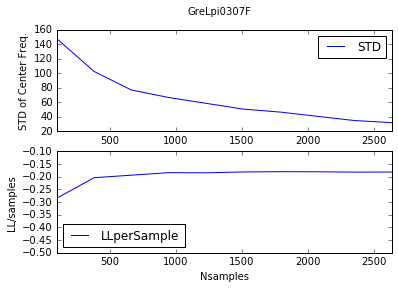

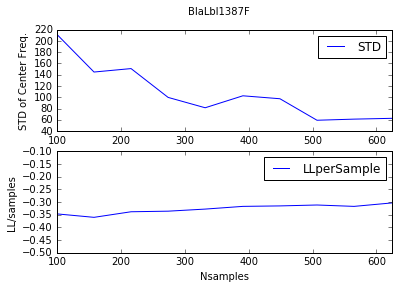

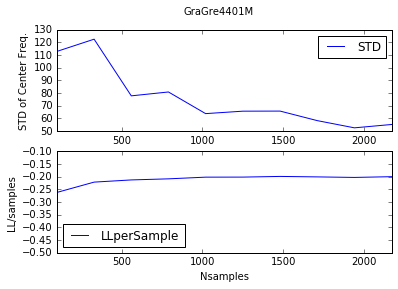

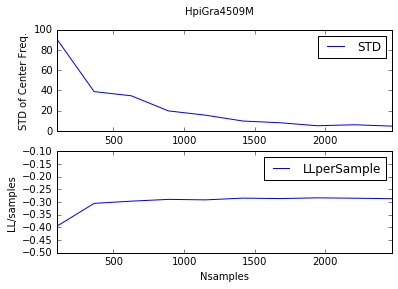

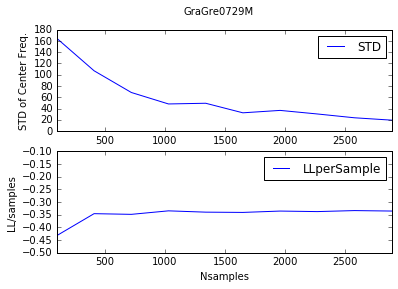

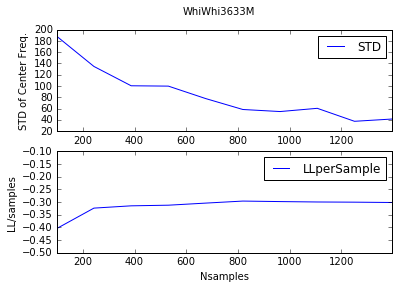

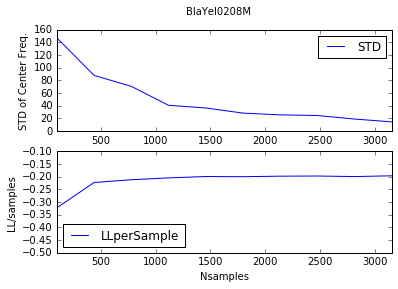

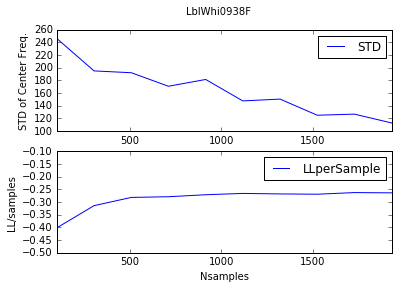

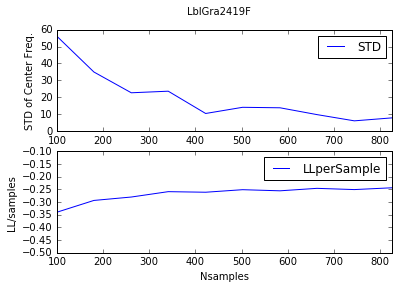

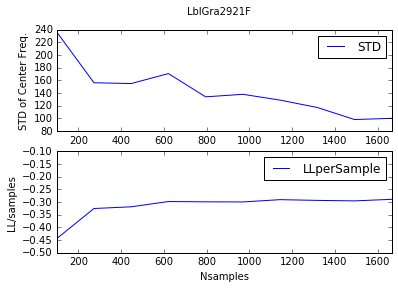

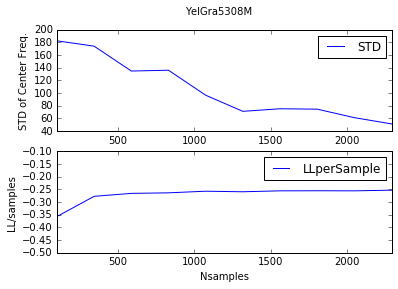

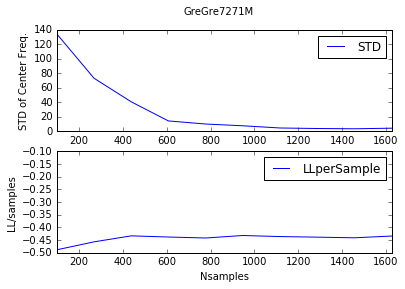

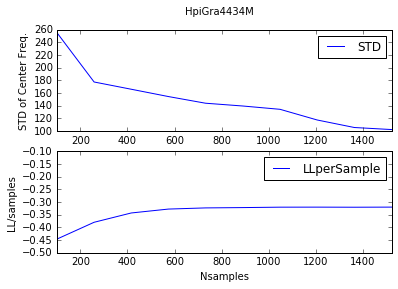

In [3]:
results = pd.DataFrame()
full_lls = dict()
from numpy.linalg.linalg import LinAlgError
bird_names = ["GreLpi0307F","BlaLbl1387F","GraGre4401M","HpiGra4509M","GraGre0729M","WhiWhi3633M","BlaYel0208M","LblWhi0938F","LblGra2419F","LblGra2921F","YelGra5308M","GreGre7271M","HpiGra4434M"]

for bird in bird_names:
    data = dict(bird=[], nsamples=[], ll_mean=[])
    blocks = get_blocks(filename, birds=bird)
    blocks = [blk for blk in blocks if "Probe" in blk.data["Class"].unique()]
    blocks = filter_blocks(blocks)
    
    max_samples = 3 * np.sum([len(blk.data[blk.data["Class"] == "Probe"]) for blk in blocks])
    nsamples = np.int32(np.linspace(100, max_samples, 10))
    
    bird_results = pd.DataFrame()

    for samples in nsamples:
        print("Computing models with %d samples" % samples)
        cfs, models = bootstrap_center_frequency(blocks, log=False, nsamples=samples, sample_function=sample_mean_probe_count)
        lls = [model.llf for model in models]
        full_lls.setdefault("lls", list()).extend(lls)
        full_lls.setdefault("Bird", list()).extend([bird] * len(lls))
        full_lls.setdefault("Nsamples", list()).extend([samples] * len(lls))
        df = pd.DataFrame({"Mean": [np.mean(cfs)],
                           "STD": [np.std(cfs)],
                           "LL Mean": [np.mean(lls)],
                           "LL STD": [np.std(lls)], 
                           "Nsamples": samples, 
                           "Bird": bird,
                           "LLperSample":[np.mean(lls)/samples]})
        bird_results = pd.concat([bird_results, df])

    results = pd.concat([results, bird_results])
        
    fig = plt.figure(facecolor="white")
    ax = fig.add_subplot(2, 1, 1)
    bx = fig.add_subplot(2, 1, 2)

    
    bird_results.plot(x='Nsamples', y='STD', ax=ax)
    bird_results.plot(x='Nsamples', y='LLperSample', ax=bx)

    bx.set_xlabel('Nsamples')
    ax.set_ylabel('STD of Center Freq.')
    bx.set_ylabel('LL/samples')
    bx.set_ylim([-0.5,-0.1])
    fig.suptitle(bird)
    fig.show()
    fig.savefig("/Users/theunissenlab/Google Drive/School/Thesis_Milan/Graphs/linear_LLgraph/%s.png" % bird, dpi=600, facecolor="white", edgecolor="white")


# Plot sigmoids and compute distribution of CFs

In [2]:
import os
import numpy as np
from matplotlib.pyplot import *
from pecking_analysis.objects import get_blocks
from pecking_analysis.flicker_fusion import *

%matplotlib notebook

# This should be the path to your flicker_fusion.h5 file
filename = os.path.expanduser("/Users/theunissenlab/Dropbox/data/data/flicker_fusion_significant.h5")
bird = "HpiGra4509M"

# Get the blocks for this bird and clean them up
blocks = get_blocks(filename, birds=bird)
blocks = [blk for blk in blocks if "Probe" in blk.data["Class"].unique()]
blocks = filter_blocks(blocks)

Getting data from all blocks
Estimating models


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/User

p = 0.03) 7010.12 (Hz), p = 0.05) 4302.79 (Hz), p = 0.08) 3209.01 (Hz), p = 0.10) 2591.17 (Hz), p = 0.12) 2184.82 (Hz), p = 0.15) 1892.90 (Hz), p = 0.18) 1670.67 (Hz), p = 0.20) 1494.37 (Hz), p = 0.23) 1350.15 (Hz), p = 0.25) 1229.30 (Hz), p = 0.28) 1126.09 (Hz), p = 0.30) 1036.52 (Hz), p = 0.33) 957.78 (Hz), p = 0.35) 887.76 (Hz), p = 0.38) 824.89 (Hz), p = 0.40) 767.96 (Hz), p = 0.43) 716.02 (Hz), p = 0.45) 668.30 (Hz), p = 0.48) 624.20 (Hz), p = 0.50) 583.21 (Hz), p = 0.53) 544.91 (Hz), p = 0.55) 508.95 (Hz), p = 0.58) 475.03 (Hz), p = 0.60) 442.90 (Hz), p = 0.63) 412.33 (Hz), p = 0.65) 383.13 (Hz), p = 0.68) 355.12 (Hz), p = 0.70) 328.14 (Hz), p = 0.73) 302.05 (Hz), p = 0.75) 276.69 (Hz), p = 0.78) 251.92 (Hz), p = 0.80) 227.61 (Hz), p = 0.83) 203.59 (Hz), p = 0.85) 179.69 (Hz), p = 0.88) 155.68 (Hz), p = 0.90) 131.27 (Hz), p = 0.93) 105.99 (Hz), p = 0.95) 79.05 (Hz), p = 0.98) 48.52 (Hz)


<IPython.core.display.Javascript object>


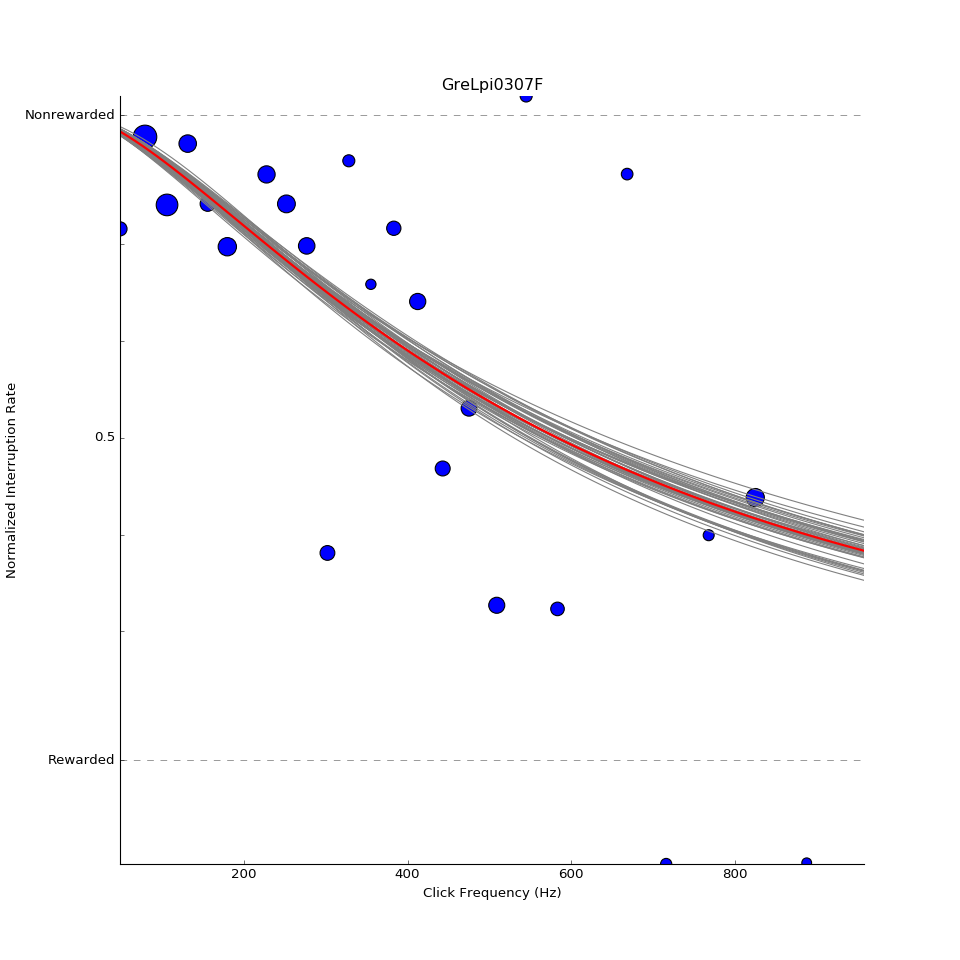

Saving figure to /Users/theunissenlab/Google Drive/School/Thesis_Milan/Graphs/Plot_sigmoids.GreLpi0307F.png
Getting data from all blocks
Estimating models


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/User

Getting data from all blocks
Estimating models


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/User

p = 0.03) 2155.42 (Hz), p = 0.05) 1068.27 (Hz), p = 0.08) 700.63 (Hz), p = 0.10) 515.14 (Hz), p = 0.12) 403.07 (Hz), p = 0.15) 327.95 (Hz), p = 0.18) 274.03 (Hz), p = 0.20) 233.43 (Hz), p = 0.23) 201.73 (Hz), p = 0.25) 176.28 (Hz), p = 0.28) 155.39 (Hz), p = 0.30) 137.93 (Hz), p = 0.33) 123.12 (Hz), p = 0.35) 110.38 (Hz), p = 0.38) 99.32 (Hz), p = 0.40) 89.61 (Hz), p = 0.43) 81.03 (Hz), p = 0.45) 73.37 (Hz), p = 0.48) 66.51 (Hz), p = 0.50) 60.32 (Hz), p = 0.53) 54.71 (Hz), p = 0.55) 49.59 (Hz), p = 0.58) 44.91 (Hz), p = 0.60) 40.61 (Hz), p = 0.63) 36.64 (Hz), p = 0.65) 32.97 (Hz), p = 0.68) 29.56 (Hz), p = 0.70) 26.38 (Hz), p = 0.73) 23.42 (Hz), p = 0.75) 20.64 (Hz), p = 0.78) 18.04 (Hz), p = 0.80) 15.59 (Hz), p = 0.83) 13.28 (Hz), p = 0.85) 11.10 (Hz), p = 0.88) 9.03 (Hz), p = 0.90) 7.06 (Hz), p = 0.93) 5.19 (Hz), p = 0.95) 3.41 (Hz), p = 0.98) 1.69 (Hz)


<IPython.core.display.Javascript object>


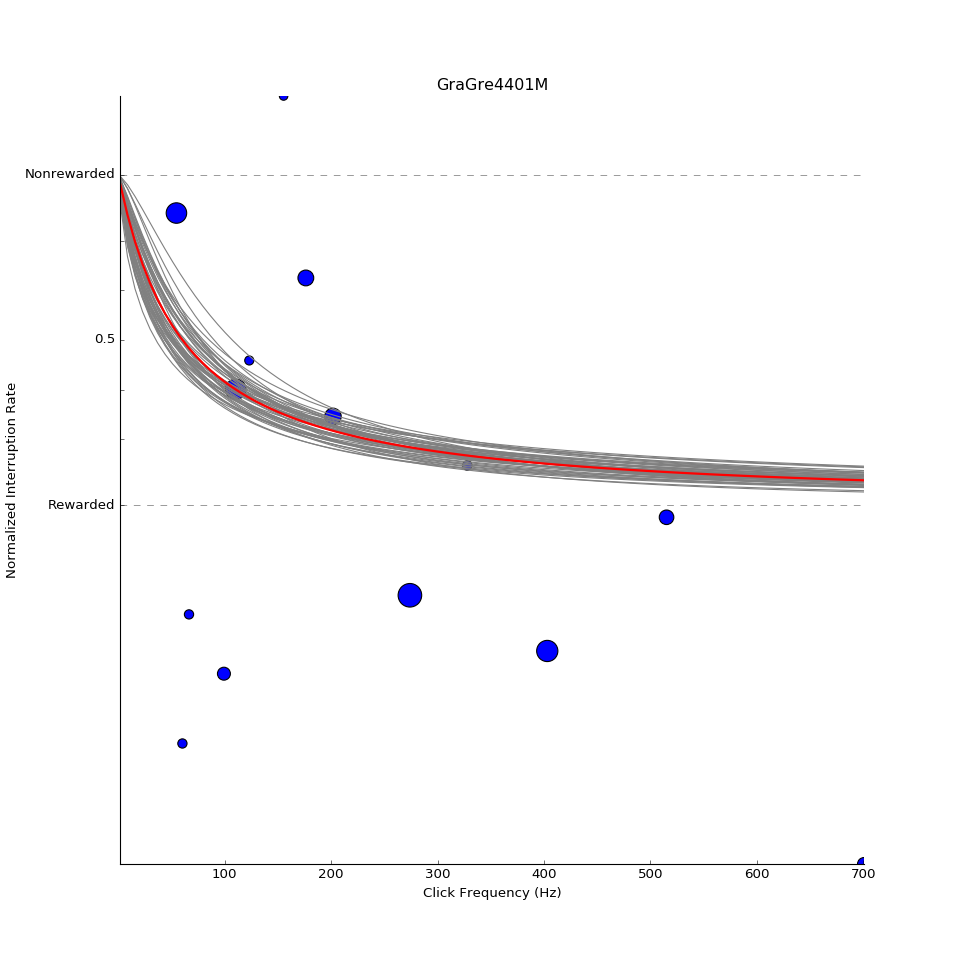

Saving figure to /Users/theunissenlab/Google Drive/School/Thesis_Milan/Graphs/Plot_sigmoids.GraGre4401M.png
Getting data from all blocks
Estimating models
p = 0.03) 1195.80 (Hz), p = 0.05) 567.71 (Hz), p = 0.08) 362.84 (Hz), p = 0.10) 261.79 (Hz), p = 0.12) 201.79 (Hz), p = 0.15) 162.12 (Hz), p = 0.18) 133.98 (Hz), p = 0.20) 113.01 (Hz), p = 0.23) 96.80 (Hz), p = 0.25) 83.89 (Hz), p = 0.28) 73.38 (Hz), p = 0.30) 64.66 (Hz), p = 0.33) 57.31 (Hz), p = 0.35) 51.04 (Hz), p = 0.38) 45.63 (Hz), p = 0.40) 40.91 (Hz), p = 0.43) 36.77 (Hz), p = 0.45) 33.09 (Hz), p = 0.48) 29.82 (Hz), p = 0.50) 26.88 (Hz), p = 0.53) 24.23 (Hz), p = 0.55) 21.84 (Hz), p = 0.58) 19.65 (Hz), p = 0.60) 17.66 (Hz), p = 0.63) 15.84 (Hz), p = 0.65) 14.16 (Hz), p = 0.68) 12.61 (Hz), p = 0.70) 11.17 (Hz), p = 0.73) 9.85 (Hz), p = 0.75) 8.61 (Hz), p = 0.78) 7.46 (Hz), p = 0.80) 6.39 (Hz), p = 0.83) 5.39 (Hz), p = 0.85) 4.46 (Hz), p = 0.88) 3.58 (Hz), p = 0.90) 2.76 (Hz), p = 0.93) 1.99 (Hz), p = 0.95) 1.27 (Hz), p = 0.98) 

<IPython.core.display.Javascript object>


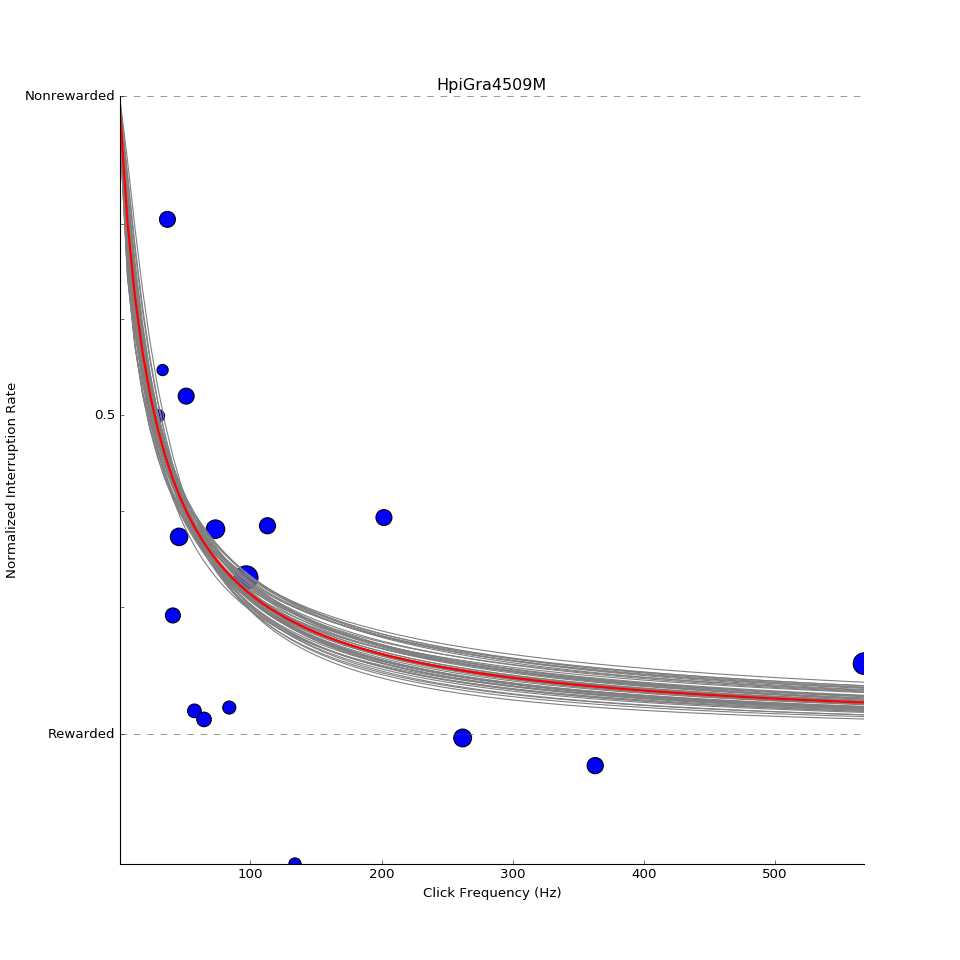

Saving figure to /Users/theunissenlab/Google Drive/School/Thesis_Milan/Graphs/Plot_sigmoids.HpiGra4509M.png
Getting data from all blocks
Estimating models


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/User

p = 0.03) 0.32 (Hz), p = 0.05) 0.85 (Hz), p = 0.08) 1.53 (Hz), p = 0.10) 2.35 (Hz), p = 0.12) 3.31 (Hz), p = 0.15) 4.41 (Hz), p = 0.18) 5.67 (Hz), p = 0.20) 7.09 (Hz), p = 0.23) 8.70 (Hz), p = 0.25) 10.50 (Hz), p = 0.28) 12.53 (Hz), p = 0.30) 14.80 (Hz), p = 0.33) 17.35 (Hz), p = 0.35) 20.21 (Hz), p = 0.38) 23.42 (Hz), p = 0.40) 27.04 (Hz), p = 0.43) 31.13 (Hz), p = 0.45) 35.76 (Hz), p = 0.48) 41.02 (Hz), p = 0.50) 47.02 (Hz), p = 0.53) 53.90 (Hz), p = 0.55) 61.82 (Hz), p = 0.58) 71.02 (Hz), p = 0.60) 81.75 (Hz), p = 0.63) 94.39 (Hz), p = 0.65) 109.40 (Hz), p = 0.68) 127.44 (Hz), p = 0.70) 149.38 (Hz), p = 0.73) 176.45 (Hz), p = 0.75) 210.47 (Hz), p = 0.78) 254.12 (Hz), p = 0.80) 311.63 (Hz), p = 0.83) 389.93 (Hz), p = 0.85) 501.20 (Hz), p = 0.88) 668.67 (Hz), p = 0.90) 942.14 (Hz), p = 0.93) 1448.12 (Hz), p = 0.95) 2611.23 (Hz), p = 0.98) 6965.12 (Hz)


<IPython.core.display.Javascript object>


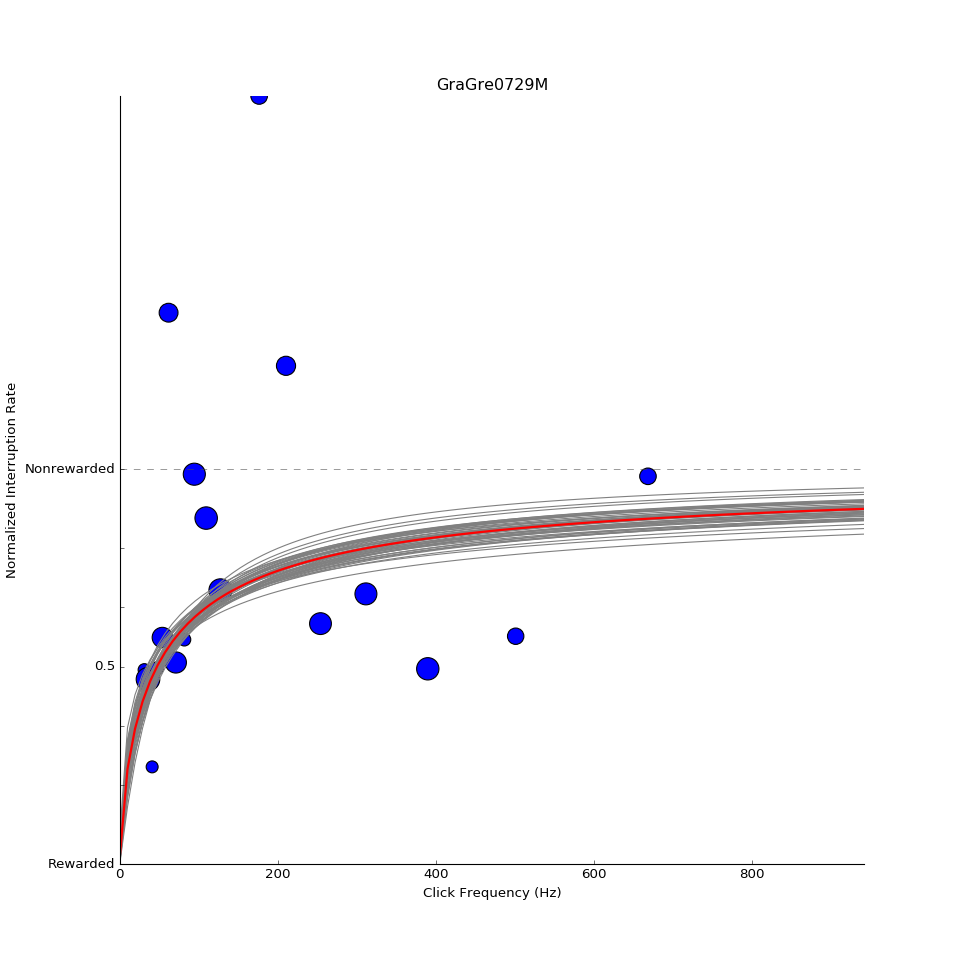

Saving figure to /Users/theunissenlab/Google Drive/School/Thesis_Milan/Graphs/Plot_sigmoids.GraGre0729M.png
Getting data from all blocks
Estimating models


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/User

p = 0.03) 15.58 (Hz), p = 0.05) 21.05 (Hz), p = 0.08) 25.21 (Hz), p = 0.10) 28.75 (Hz), p = 0.12) 31.94 (Hz), p = 0.15) 34.88 (Hz), p = 0.18) 37.67 (Hz), p = 0.20) 40.35 (Hz), p = 0.23) 42.95 (Hz), p = 0.25) 45.50 (Hz), p = 0.28) 48.02 (Hz), p = 0.30) 50.54 (Hz), p = 0.33) 53.05 (Hz), p = 0.35) 55.59 (Hz), p = 0.38) 58.16 (Hz), p = 0.40) 60.78 (Hz), p = 0.43) 63.46 (Hz), p = 0.45) 66.21 (Hz), p = 0.48) 69.05 (Hz), p = 0.50) 72.00 (Hz), p = 0.53) 75.07 (Hz), p = 0.55) 78.29 (Hz), p = 0.58) 81.69 (Hz), p = 0.60) 85.28 (Hz), p = 0.63) 89.12 (Hz), p = 0.65) 93.24 (Hz), p = 0.68) 97.70 (Hz), p = 0.70) 102.57 (Hz), p = 0.73) 107.94 (Hz), p = 0.75) 113.92 (Hz), p = 0.78) 120.69 (Hz), p = 0.80) 128.47 (Hz), p = 0.83) 137.59 (Hz), p = 0.85) 148.59 (Hz), p = 0.88) 162.30 (Hz), p = 0.90) 180.26 (Hz), p = 0.93) 205.62 (Hz), p = 0.95) 246.29 (Hz), p = 0.98) 332.59 (Hz)


<IPython.core.display.Javascript object>


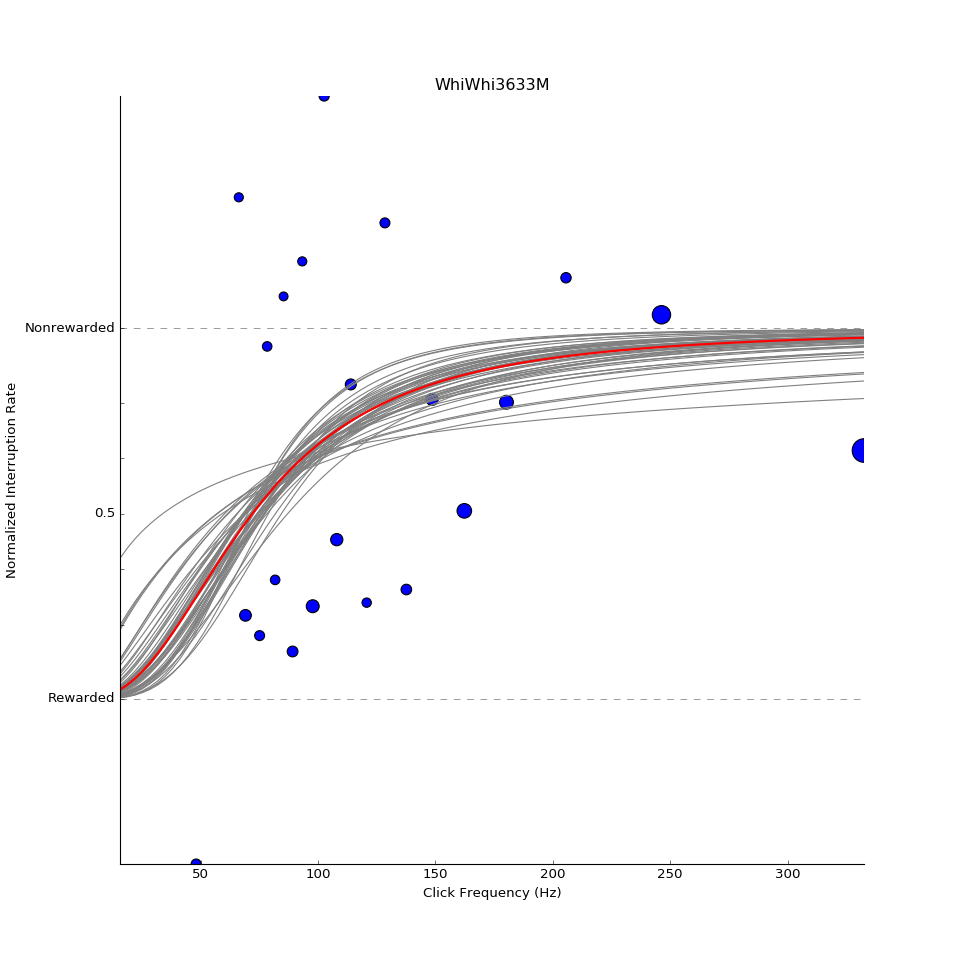

Saving figure to /Users/theunissenlab/Google Drive/School/Thesis_Milan/Graphs/Plot_sigmoids.WhiWhi3633M.png
Getting data from all blocks
Estimating models
p = 0.03) 208.69 (Hz), p = 0.05) 274.64 (Hz), p = 0.08) 323.92 (Hz), p = 0.10) 365.34 (Hz), p = 0.12) 402.15 (Hz), p = 0.15) 435.94 (Hz), p = 0.18) 467.68 (Hz), p = 0.20) 497.97 (Hz), p = 0.23) 527.23 (Hz), p = 0.25) 555.79 (Hz), p = 0.28) 583.91 (Hz), p = 0.30) 611.78 (Hz), p = 0.33) 639.59 (Hz), p = 0.35) 667.50 (Hz), p = 0.38) 695.67 (Hz), p = 0.40) 724.23 (Hz), p = 0.43) 753.34 (Hz), p = 0.45) 783.14 (Hz), p = 0.48) 813.81 (Hz), p = 0.50) 845.52 (Hz), p = 0.53) 878.46 (Hz), p = 0.55) 912.86 (Hz), p = 0.58) 948.98 (Hz), p = 0.60) 987.13 (Hz), p = 0.63) 1027.66 (Hz), p = 0.65) 1071.01 (Hz), p = 0.68) 1117.75 (Hz), p = 0.70) 1168.57 (Hz), p = 0.73) 1224.35 (Hz), p = 0.75) 1286.28 (Hz), p = 0.78) 1355.96 (Hz), p = 0.80) 1435.65 (Hz), p = 0.83) 1528.62 (Hz), p = 0.85) 1639.90 (Hz), p = 0.88) 1777.73 (Hz), p = 0.90) 1956.80 (Hz), p = 0

<IPython.core.display.Javascript object>


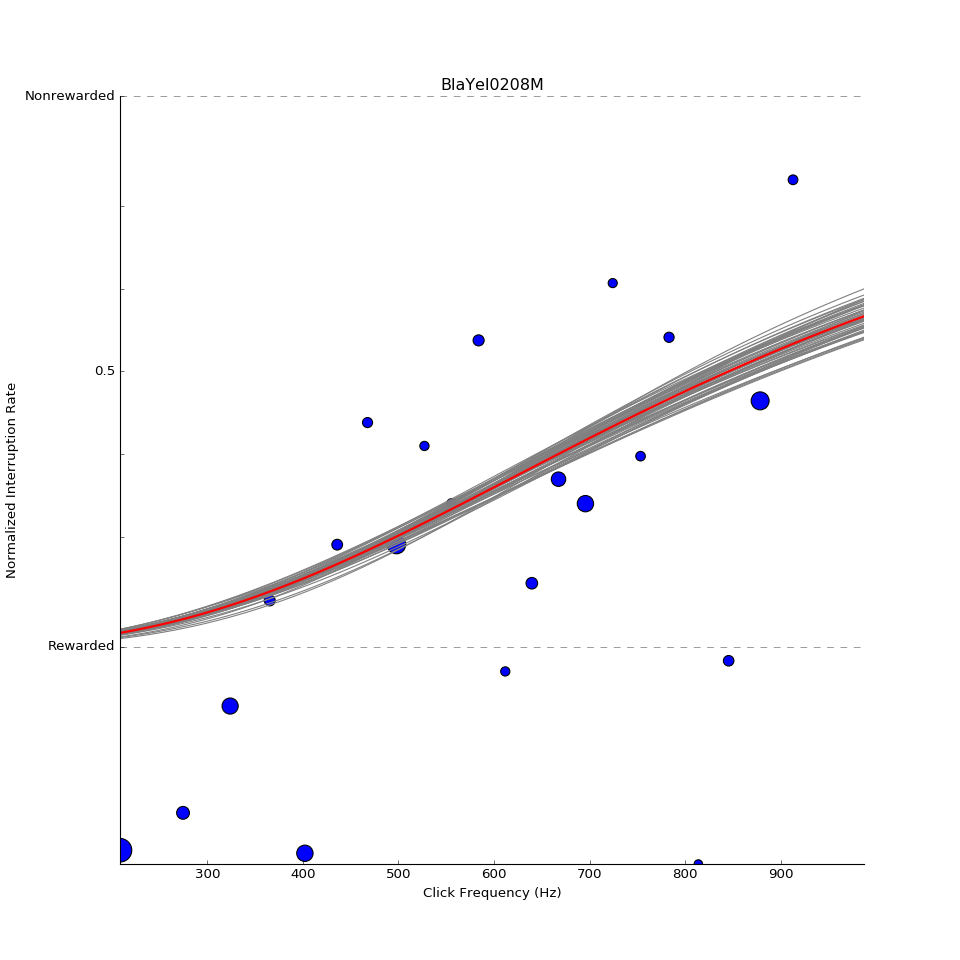

Saving figure to /Users/theunissenlab/Google Drive/School/Thesis_Milan/Graphs/Plot_sigmoids.BlaYel0208M.png
Getting data from all blocks
Estimating models


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/User

p = 0.03) 7.22 (Hz), p = 0.05) 16.98 (Hz), p = 0.08) 28.39 (Hz), p = 0.10) 41.29 (Hz), p = 0.12) 55.68 (Hz), p = 0.15) 71.58 (Hz), p = 0.18) 89.09 (Hz), p = 0.20) 108.32 (Hz), p = 0.23) 129.40 (Hz), p = 0.25) 152.51 (Hz), p = 0.28) 177.84 (Hz), p = 0.30) 205.63 (Hz), p = 0.33) 236.16 (Hz), p = 0.35) 269.76 (Hz), p = 0.38) 306.81 (Hz), p = 0.40) 347.77 (Hz), p = 0.43) 393.18 (Hz), p = 0.45) 443.68 (Hz), p = 0.48) 500.06 (Hz), p = 0.50) 563.27 (Hz), p = 0.53) 634.46 (Hz), p = 0.55) 715.08 (Hz), p = 0.58) 806.93 (Hz), p = 0.60) 912.29 (Hz), p = 0.63) 1034.07 (Hz), p = 0.65) 1176.09 (Hz), p = 0.68) 1343.42 (Hz), p = 0.70) 1542.89 (Hz), p = 0.73) 1784.02 (Hz), p = 0.75) 2080.35 (Hz), p = 0.78) 2451.83 (Hz), p = 0.80) 2929.02 (Hz), p = 0.83) 3561.10 (Hz), p = 0.85) 4432.21 (Hz), p = 0.88) 5698.49 (Hz), p = 0.90) 7683.55 (Hz), p = 0.93) 11176.32 (Hz), p = 0.95) 18684.97 (Hz), p = 0.98) 43945.42 (Hz)


<IPython.core.display.Javascript object>


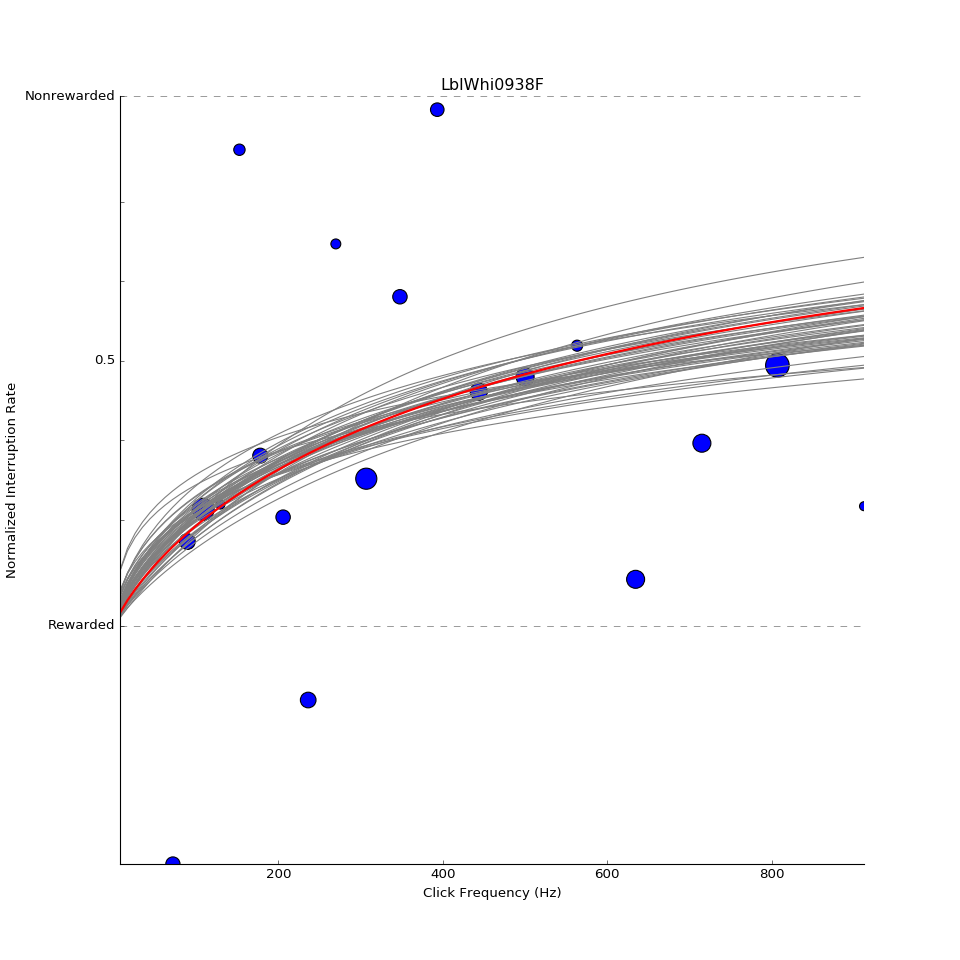

Saving figure to /Users/theunissenlab/Google Drive/School/Thesis_Milan/Graphs/Plot_sigmoids.LblWhi0938F.png
Getting data from all blocks
Estimating models
p = 0.03) 1239.47 (Hz), p = 0.05) 638.60 (Hz), p = 0.08) 428.70 (Hz), p = 0.10) 320.60 (Hz), p = 0.12) 254.28 (Hz), p = 0.15) 209.26 (Hz), p = 0.18) 176.60 (Hz), p = 0.20) 151.77 (Hz), p = 0.23) 132.22 (Hz), p = 0.25) 116.40 (Hz), p = 0.28) 103.33 (Hz), p = 0.30) 92.32 (Hz), p = 0.33) 82.93 (Hz), p = 0.35) 74.80 (Hz), p = 0.38) 67.70 (Hz), p = 0.40) 61.43 (Hz), p = 0.43) 55.85 (Hz), p = 0.45) 50.86 (Hz), p = 0.48) 46.35 (Hz), p = 0.50) 42.26 (Hz), p = 0.53) 38.54 (Hz), p = 0.55) 35.12 (Hz), p = 0.58) 31.98 (Hz), p = 0.60) 29.08 (Hz), p = 0.63) 26.39 (Hz), p = 0.65) 23.88 (Hz), p = 0.68) 21.54 (Hz), p = 0.70) 19.35 (Hz), p = 0.73) 17.29 (Hz), p = 0.75) 15.35 (Hz), p = 0.78) 13.51 (Hz), p = 0.80) 11.77 (Hz), p = 0.83) 10.11 (Hz), p = 0.85) 8.54 (Hz), p = 0.88) 7.02 (Hz), p = 0.90) 5.57 (Hz), p = 0.93) 4.17 (Hz), p = 0.95) 2.80 (Hz), p 

<IPython.core.display.Javascript object>


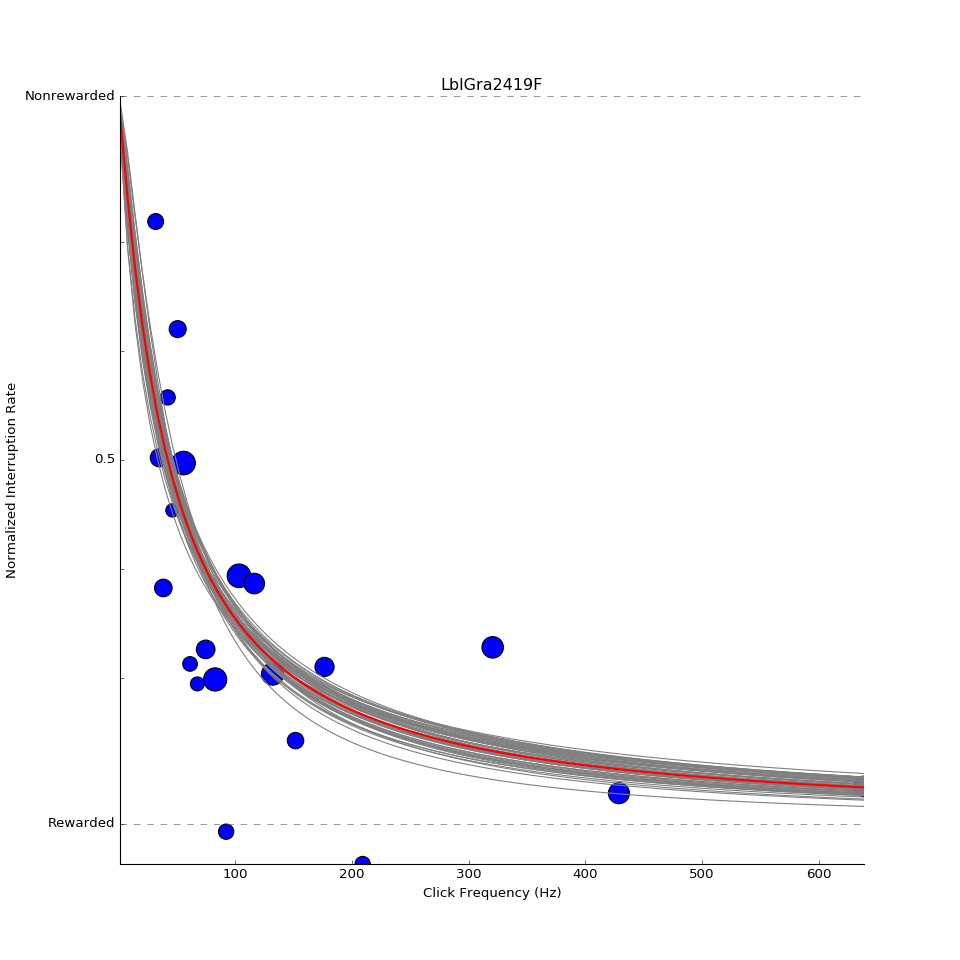

Saving figure to /Users/theunissenlab/Google Drive/School/Thesis_Milan/Graphs/Plot_sigmoids.LblGra2419F.png
Getting data from all blocks
Estimating models


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p = 0.03) 12.08 (Hz), p = 0.05) 23.71 (Hz), p = 0.08) 35.55 (Hz), p = 0.10) 47.77 (Hz), p = 0.12) 60.46 (Hz), p = 0.15) 73.70 (Hz), p = 0.18) 87.58 (Hz), p = 0.20) 102.17 (Hz), p = 0.23) 117.54 (Hz), p = 0.25) 133.80 (Hz), p = 0.28) 151.03 (Hz), p = 0.30) 169.35 (Hz), p = 0.33) 188.87 (Hz), p = 0.35) 209.75 (Hz), p = 0.38) 232.15 (Hz), p = 0.40) 256.25 (Hz), p = 0.43) 282.28 (Hz), p = 0.45) 310.50 (Hz), p = 0.48) 341.20 (Hz), p = 0.50) 374.77 (Hz), p = 0.53) 411.64 (Hz), p = 0.55) 452.34 (Hz), p = 0.58) 497.55 (Hz), p = 0.60) 548.09 (Hz), p = 0.63) 605.00 (Hz), p = 0.65) 669.60 (Hz), p = 0.68) 743.62 (Hz), p = 0.70) 829.38 (Hz), p = 0.73) 929.97 (Hz), p = 0.75) 1049.73 (Hz), p = 0.78) 1194.89 (Hz), p = 0.80) 1374.71 (Hz), p = 0.83) 1603.65 (Hz), p = 0.85) 1905.59 (Hz), p = 0.88) 2323.10 (Hz), p = 0.90) 2940.31 (Hz), p = 0.93) 3950.78 (Hz), p = 0.95) 5924.23 (Hz), p = 0.98) 11626.08 (Hz)


<IPython.core.display.Javascript object>


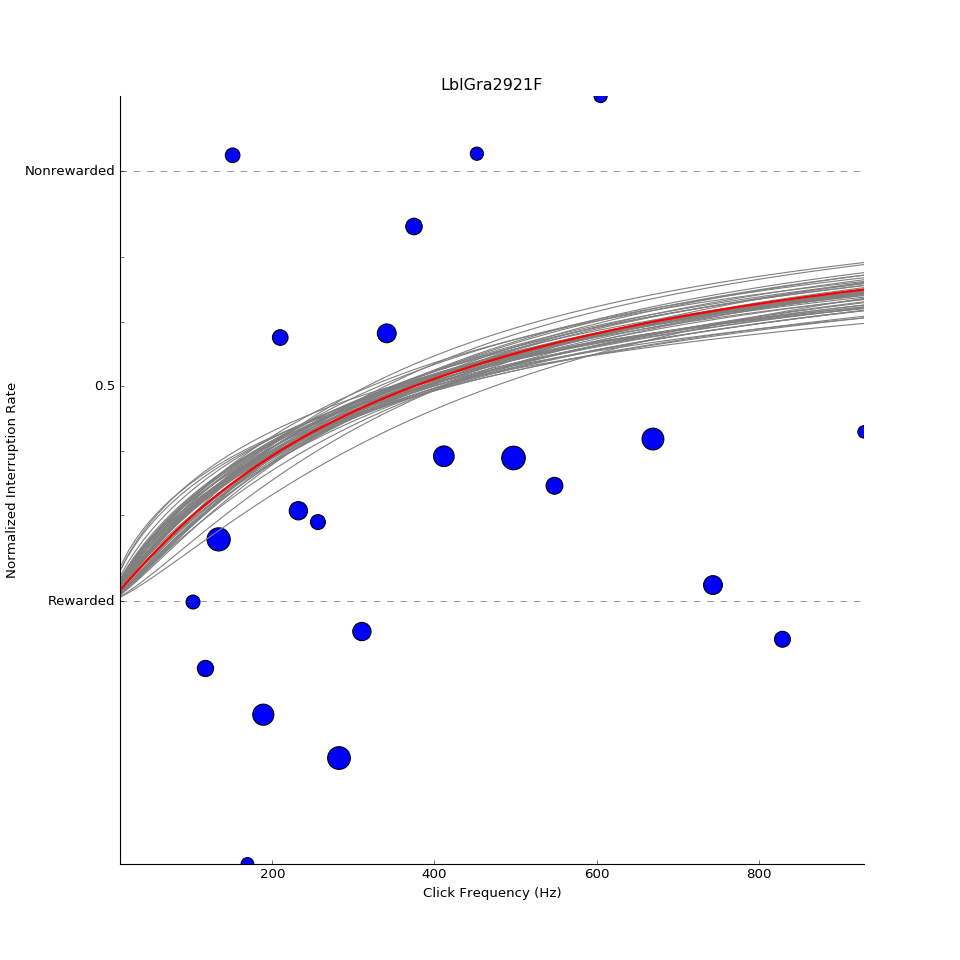

Saving figure to /Users/theunissenlab/Google Drive/School/Thesis_Milan/Graphs/Plot_sigmoids.LblGra2921F.png
Getting data from all blocks
Estimating models


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/User

p = 0.03) 35.90 (Hz), p = 0.05) 50.74 (Hz), p = 0.08) 62.46 (Hz), p = 0.10) 72.68 (Hz), p = 0.12) 82.02 (Hz), p = 0.15) 90.80 (Hz), p = 0.18) 99.20 (Hz), p = 0.20) 107.36 (Hz), p = 0.23) 115.37 (Hz), p = 0.25) 123.30 (Hz), p = 0.28) 131.20 (Hz), p = 0.30) 139.14 (Hz), p = 0.33) 147.15 (Hz), p = 0.35) 155.29 (Hz), p = 0.38) 163.58 (Hz), p = 0.40) 172.09 (Hz), p = 0.43) 180.85 (Hz), p = 0.45) 189.90 (Hz), p = 0.48) 199.32 (Hz), p = 0.50) 209.15 (Hz), p = 0.53) 219.46 (Hz), p = 0.55) 230.34 (Hz), p = 0.58) 241.88 (Hz), p = 0.60) 254.19 (Hz), p = 0.63) 267.40 (Hz), p = 0.65) 281.69 (Hz), p = 0.68) 297.26 (Hz), p = 0.70) 314.38 (Hz), p = 0.73) 333.40 (Hz), p = 0.75) 354.78 (Hz), p = 0.78) 379.16 (Hz), p = 0.80) 407.43 (Hz), p = 0.83) 440.94 (Hz), p = 0.85) 481.75 (Hz), p = 0.88) 533.29 (Hz), p = 0.90) 601.82 (Hz), p = 0.93) 700.30 (Hz), p = 0.95) 862.11 (Hz), p = 0.98) 1218.40 (Hz)


<IPython.core.display.Javascript object>


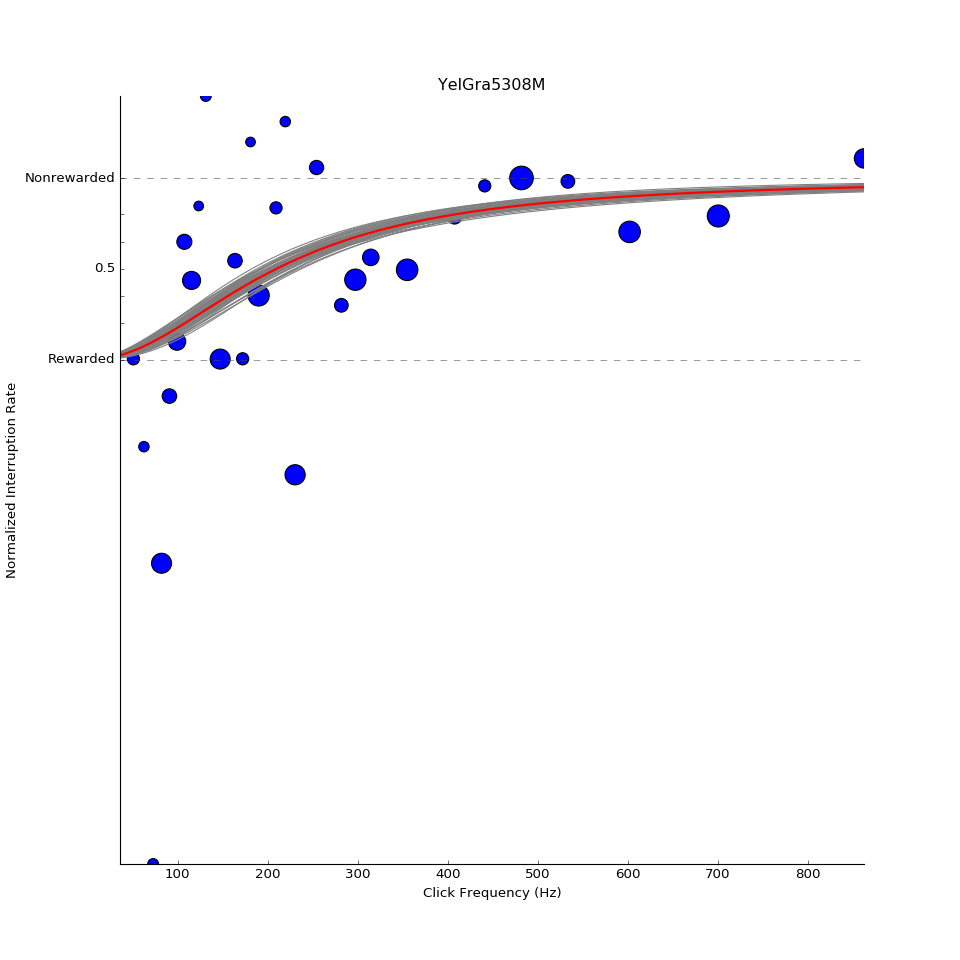

Saving figure to /Users/theunissenlab/Google Drive/School/Thesis_Milan/Graphs/Plot_sigmoids.YelGra5308M.png
Getting data from all blocks
Estimating models


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/User

p = 0.03) 2275.52 (Hz), p = 0.05) 805.27 (Hz), p = 0.08) 431.36 (Hz), p = 0.10) 273.64 (Hz), p = 0.12) 190.33 (Hz), p = 0.15) 140.27 (Hz), p = 0.18) 107.53 (Hz), p = 0.20) 84.81 (Hz), p = 0.23) 68.33 (Hz), p = 0.25) 55.97 (Hz), p = 0.28) 46.44 (Hz), p = 0.30) 38.93 (Hz), p = 0.33) 32.91 (Hz), p = 0.35) 28.00 (Hz), p = 0.38) 23.95 (Hz), p = 0.40) 20.56 (Hz), p = 0.43) 17.72 (Hz), p = 0.45) 15.30 (Hz), p = 0.48) 13.23 (Hz), p = 0.50) 11.45 (Hz), p = 0.53) 9.91 (Hz), p = 0.55) 8.57 (Hz), p = 0.58) 7.40 (Hz), p = 0.60) 6.37 (Hz), p = 0.63) 5.47 (Hz), p = 0.65) 4.68 (Hz), p = 0.68) 3.98 (Hz), p = 0.70) 3.37 (Hz), p = 0.73) 2.82 (Hz), p = 0.75) 2.34 (Hz), p = 0.78) 1.92 (Hz), p = 0.80) 1.55 (Hz), p = 0.83) 1.22 (Hz), p = 0.85) 0.93 (Hz), p = 0.88) 0.69 (Hz), p = 0.90) 0.48 (Hz), p = 0.93) 0.30 (Hz), p = 0.95) 0.16 (Hz), p = 0.98) 0.06 (Hz)


<IPython.core.display.Javascript object>


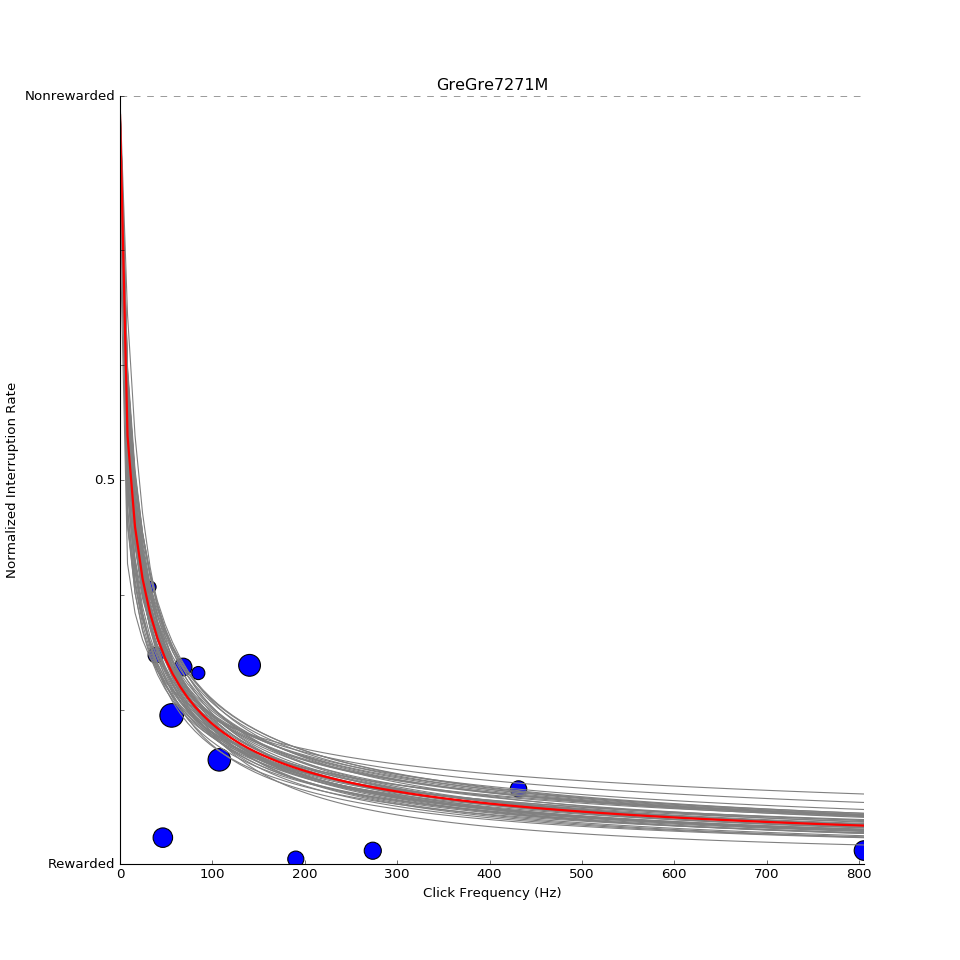

Saving figure to /Users/theunissenlab/Google Drive/School/Thesis_Milan/Graphs/Plot_sigmoids.GreGre7271M.png
Getting data from all blocks
Estimating models


/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/theunissenlab/psychopy_path/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/User

p = 0.03) 2.89 (Hz), p = 0.05) 6.73 (Hz), p = 0.08) 11.18 (Hz), p = 0.10) 16.20 (Hz), p = 0.12) 21.76 (Hz), p = 0.15) 27.90 (Hz), p = 0.18) 34.63 (Hz), p = 0.20) 42.01 (Hz), p = 0.23) 50.08 (Hz), p = 0.25) 58.90 (Hz), p = 0.28) 68.56 (Hz), p = 0.30) 79.14 (Hz), p = 0.33) 90.75 (Hz), p = 0.35) 103.50 (Hz), p = 0.38) 117.53 (Hz), p = 0.40) 133.03 (Hz), p = 0.43) 150.18 (Hz), p = 0.45) 169.23 (Hz), p = 0.48) 190.46 (Hz), p = 0.50) 214.24 (Hz), p = 0.53) 240.98 (Hz), p = 0.55) 271.22 (Hz), p = 0.58) 305.62 (Hz), p = 0.60) 345.02 (Hz), p = 0.63) 390.51 (Hz), p = 0.65) 443.47 (Hz), p = 0.68) 505.77 (Hz), p = 0.70) 579.92 (Hz), p = 0.73) 669.41 (Hz), p = 0.75) 779.19 (Hz), p = 0.78) 916.55 (Hz), p = 0.80) 1092.65 (Hz), p = 0.83) 1325.39 (Hz), p = 0.85) 1645.36 (Hz), p = 0.88) 2109.19 (Hz), p = 0.90) 2833.94 (Hz), p = 0.93) 4104.05 (Hz), p = 0.95) 6819.93 (Hz), p = 0.98) 15879.26 (Hz)


<IPython.core.display.Javascript object>


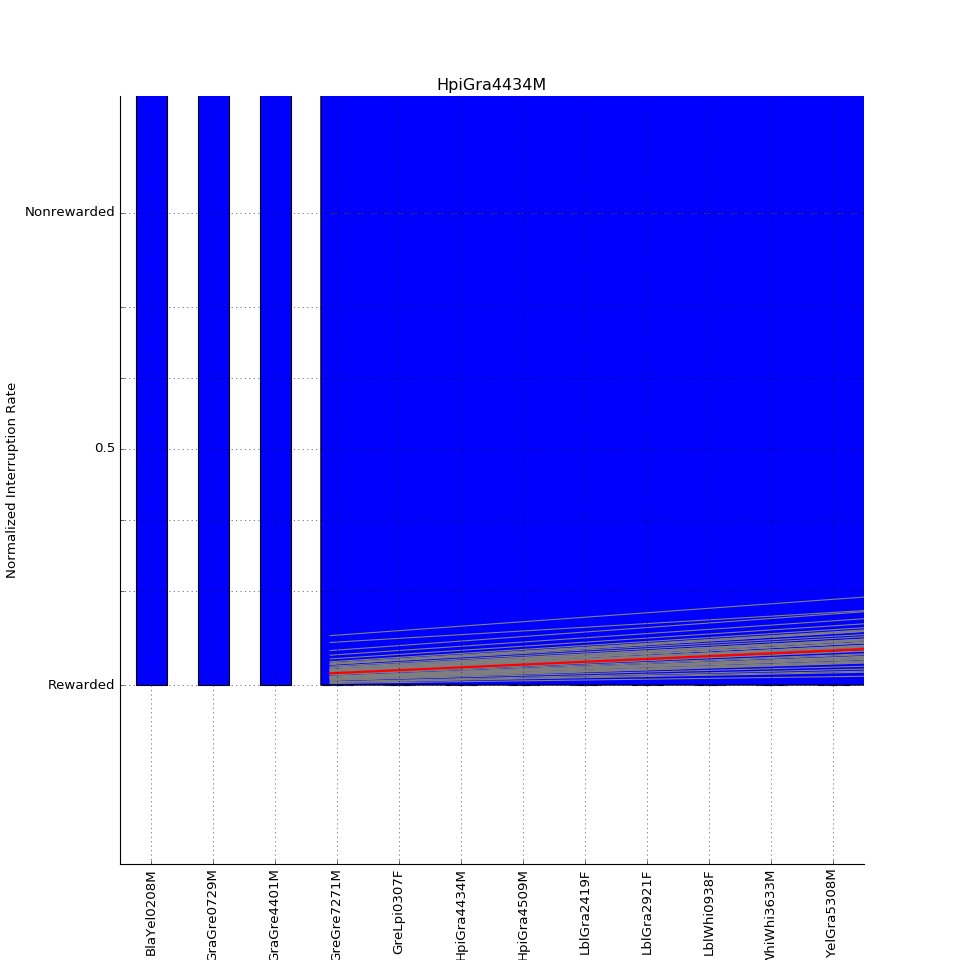

Saving figure to /Users/theunissenlab/Google Drive/School/Thesis_Milan/Graphs/Plot_sigmoids.HpiGra4434M.png


In [7]:
import os
import numpy as np
from matplotlib.pyplot import *
from pecking_analysis.objects import get_blocks
from pecking_analysis.flicker_fusion import *

%matplotlib notebook

# This should be the path to your flicker_fusion.h5 file
filename = os.path.expanduser("/Users/theunissenlab/Dropbox/data/data/flicker_fusion_significant.h5")

results = pd.DataFrame()
full_lls = dict()
bird_names = ["GreLpi0307F","BlaLbl1387F","GraGre4401M","HpiGra4509M","GraGre0729M","WhiWhi3633M","BlaYel0208M","LblWhi0938F","LblGra2419F","LblGra2921F","YelGra5308M","GreGre7271M","HpiGra4434M"]
nbootstraps = 50
sample_function = lambda df: sample_only_probe(df, 0.9)
data = dict(bird=[], ll=[], llr=[], pvalue=[], cf=[])
est_freqs = np.linspace(10, 1000, 200)
estimates = np.zeros((len(bird_names), len(est_freqs)))

bad_birds = list()
for ii, bird in enumerate(bird_names):
    blocks = get_blocks(filename, birds=bird)
    blocks = [blk for blk in blocks if "Probe" in blk.data["Class"].unique()]
    blocks = filter_blocks(blocks)
    
    try:
        models = get_response_by_frequency(blocks, log=True, scaled=True, nbootstraps=nbootstraps, sample_function=sample_function,
                                      global_interruption=True, daily_interruption=True,
                                      fracs=np.arange(.025, 1.0, .025), show_fracs=False, maxiter=100,filename= "/Users/theunissenlab/Google Drive/School/Thesis_Milan/Graphs/Plot_sigmoids.%s.png" % bird)[0]
    except ValueError:
        bad_birds.append(bird)
        continue
    agg_model = aggregate_models(models, log=True)
    estimates[ii] = model_predict(agg_model, est_freqs, log=True, min_value=0.0, max_value=1.0)

    for m in models:
        data["bird"].append(bird)
        data["ll"].append(m.llf)
        data["llr"].append(m.llr)
        data["pvalue"].append(m.llr_pvalue)
        data["cf"].append(get_frequency_probability(m, 0.5, log=True, min_val=0, max_val=1))

data = pd.DataFrame(data)

In [27]:
data.groupby("bird")["cf"].agg({"Mean": np.mean, "STD":np.std})

,STD,Mean
bird,,
BlaYel0208M,25.219764,847.954710
GraGre0729M,5.855245,46.963451
GraGre4401M,14.860879,59.766070
GreGre7271M,3.720450,11.469298
GreLpi0307F,25.567504,583.817850
HpiGra4434M,41.444116,217.710889
HpiGra4509M,2.843666,26.676923
LblGra2419F,3.183776,42.175388
LblGra2921F,29.353489,376.774829


In [4]:
plt.figure()
plt.plot(est_freqs, estimates.T)

NameError: name 'plt' is not defined

In [5]:
fig = plt.figure(facecolor="white")
ax = fig.add_subplot(1, 1, 1)
bar_data.plot(ax=ax, xerr="std", y='mean', kind='barh', color='c', fontsize='16')

ax.set_xlabel('Cener Frequency',fontsize='20')

fig.show()
fig.set_size_inches(18, 8.5)

NameError: name 'plt' is not defined

<IPython.core.display.Javascript object>


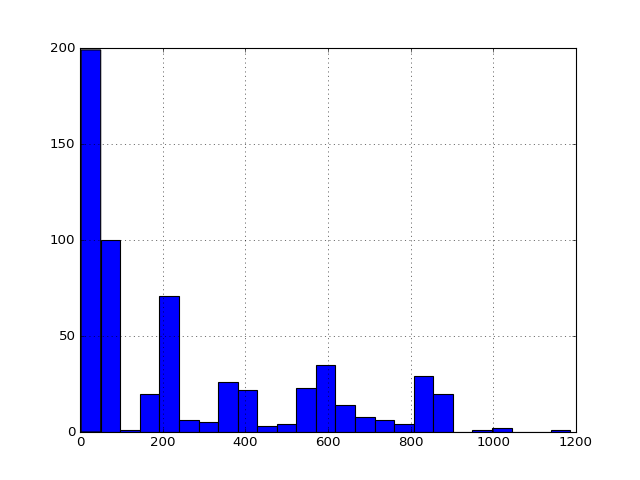

In [32]:
figure()
data["cf"].hist(bins=25)